# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


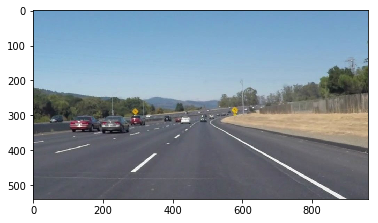

In [26]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [27]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    min_y = 330 # <-- Just below the horizon
    max_y = img.shape[0]
    print(min_y,max_y)
    positive_slope=[]
    negative_slope=[]
    left_intercept=[]
    right_intercept=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2==x1:
                continue
            slope=(y2-y1)/(x2-x1)
            b=y1-x1*slope
            #print('slope=',slope)
            '''if np.isneginf(slope)|np.isposinf(slope)| np.isnan(slope):
                #print('slope=',slope)
                continue'''
            if slope<0:
                negative_slope.append(slope)
                left_intercept.append(b)
            else:
                positive_slope.append(slope)
                right_intercept.append(b)
                
    avg_mean_postive_slope=mean(positive_slope)
    avg_mean_negative_slope=mean(negative_slope)
    avg_left_intercept=mean(left_intercept)
    avg_right_intercept=mean(right_intercept)
    print(positive_slope)
    print(negative_slope)
    print(avg_mean_postive_slope,avg_mean_negative_slope,avg_left_intercept,avg_right_intercept)
    if avg_mean_negative_slope !=0:
        x1_left=(max_y-avg_left_intercept)/avg_mean_negative_slope
        y1_left=max_y
        x2_left=(min_y-avg_left_intercept)/avg_mean_negative_slope
        y2_left=min_y
        print(x1_left,y1_left,x2_left,y2_left)
        cv2.line(img, (int(x1_left), int(y1_left)), (int(x2_left), int(y2_left)), color, thickness) #avg Left Line
    if avg_mean_postive_slope!=0:
        x1_right=(max_y-avg_right_intercept)/avg_mean_postive_slope
        y1_right=max_y
        x2_right=(min_y-avg_right_intercept)/avg_mean_postive_slope
        y2_right=min_y
        print(x1_right,y1_right,x2_right,y2_right)
        cv2.line(img, (int(x1_right), int(y1_right)), (int(x2_right), int(y2_right)), color, thickness) #avg Right Line
        
def mean(list):
    """
    calculate mean of list
    """
    return float(sum(list)) / max(len(list), 1)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [28]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Converted gray image 
gaussian image shape : (540, 960)


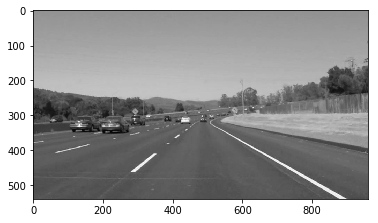

In [29]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
image_output_directory="/test_images_output/"
gray_image=grayscale(image)
print('Converted gray image ')
plt.imshow(gray_image,cmap='gray')
gaussian_image=gaussian_blur(gray_image,5)
print('gaussian image shape : {}'.format(gaussian_image.shape))

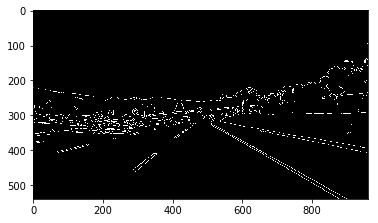

In [30]:
#Applying canny edge detection on gaussian image
canny_image=canny(gaussian_image,50,100)
plt.imshow(canny_image,cmap='gray')

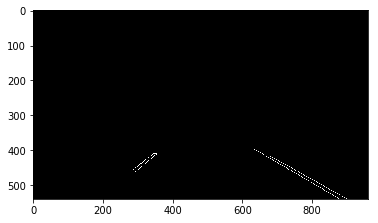

In [31]:
#creating Region of interest
shape=image.shape
vertices=np.array([[(0,shape[0]),(480,340),(500,340),(shape[1],shape[0])]])
interested_region=region_of_interest(canny_image,vertices)
plt.imshow(interested_region,cmap='gray')

330 540
[0.5539906103286385, 0.5748987854251012, 0.5525114155251142, 0.5789473684210527]
[-0.8333333333333334, -0.8125]
0.5650870449249766 -0.8229166666666667 697.8333333333334 36.721277947759745
191.7974683544304 540 446.9873417721519 330
890.6215893147182 540 518.9974264782113 330


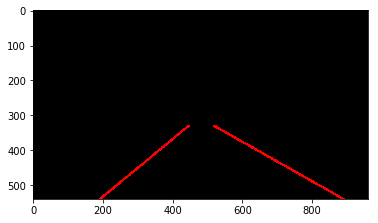

In [32]:
#creating hough lines for canny image
rho=1
theta=np.pi/180
threshold=50
min_line_length=40
max_line_gap=20
line_img=hough_lines(interested_region,rho,theta,threshold,min_line_length,max_line_gap)
plt.imshow(line_img)

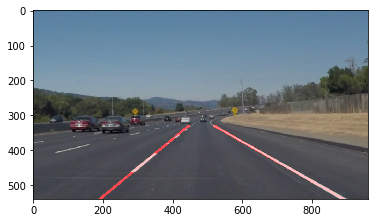

In [40]:
final_image=weighted_img(line_img,image)
plt.imshow(final_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray_image=grayscale(image)
    print('Converted gray image ')
    #plt.imshow(gray_image,cmap='gray')
    gaussian_image=gaussian_blur(gray_image,5)
    print('gaussian image shape : {}'.format(gaussian_image.shape))
    canny_image=canny(gaussian_image,50,100)
    #plt.imshow(canny_image,cmap='gray')
    vertices=np.array([[(100,shape[0]),(480,310),(500,310),(900,shape[0])]])
    interested_region=region_of_interest(canny_image,vertices)
    rho=1
    theta=np.pi/180
    threshold=50
    min_line_length=40
    max_line_gap=20
    line_img=hough_lines(interested_region,rho,theta,threshold,min_line_length,max_line_gap)
    #plt.imshow(interested_region,cmap='gray')
    #line_img=hough_lines(interested_region,rho,theta,threshold,min_line_length,max_line_gap)
    plt.imshow(line_img)
    result=weighted_img(line_img,image)
    return result

Let's try the one with the solid white lane on the right first ...

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6005361930294906, 0.624390243902439, 0.6266094420600858, 0.6277372262773723, 0.602803738317757]
[-0.75, -0.7321428571428571]
0.616415368717429 -0.7410714285714286 657.7053571428571 9.529637067045053
158.83132530120477 540 442.20481927710836 330
860.5729023867474 540 519.8935315317581 330
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



t:   0%|                                     | 0/221 [00:00<?, ?it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6005361930294906, 0.624390243902439, 0.6266094420600858, 0.6277372262773723, 0.602803738317757]
[-0.75, -0.7321428571428571]
0.616415368717429 -0.7410714285714286 657.7053571428571 9.529637067045053
158.83132530120477 540 442.20481927710836 330
860.5729023867474 540 519.8935315317581 330


t:   1%|▎                            | 2/221 [00:00<00:38,  5.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6486486486486487, 0.6027027027027027, 0.6024096385542169, 0.6016260162601627, 0.6275862068965518, 0.6284153005464481]
[-0.7222222222222222, -0.7563025210084033, -0.71875, -0.7563025210084033]
0.6185647522681218 -0.7383943160597572 656.9315476190476 7.551456415678321
158.35921956038524 540 442.76010866880705 330
860.7806080640166 540 521.2850269951266 330


t:   1%|▍                            | 3/221 [00:00<00:34,  6.34it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6031746031746031, 0.6258503401360545, 0.625, 0.6326530612244898, 0.602112676056338]
[-0.7472527472527473, -0.7216494845360825, -0.7012987012987013]
0.6177581361182971 -0.723400311029177 651.7904329347629 8.984213215802754
154.5346763477601 540 444.830376803341 330
859.5852579471502 540 519.6463923588448 330
Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6033057851239669, 0.6253968253968254, 0.6272727272727273, 0.6283783783783784, 0.6023391812865497, 0.6233766233766234]
[-0.7540983606557377, -0.75, -0.7333333333333333, -0.7833333333333333]
0.6183449201391786 -0.7551912568306011 662.0856557377049 9.428202556312593
161.66190303907376 540 439.7371562952243 330
858.0515181142993 540 518.435240596029 330


t:   2%|▋                            | 5/221 [00:00<00:30,  7.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6007462686567164, 0.6246575342465753, 0.625, 0.6027777777777777, 0.6268656716417911]
[-0.7209302325581395]
0.6160094504645721 -0.7209302325581395 652.8604651162791 10.053548694881773
156.54838709677423 540 447.83870967741944 330
860.2894824185761 540 519.385621541725 330


t:   3%|▊                            | 6/221 [00:00<00:28,  7.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6005665722379604, 0.6276595744680851, 0.6274509803921569, 0.6333333333333333, 0.6]
[-0.7564102564102564]
0.6178020920863071 -0.7564102564102564 666.3076923076924 8.484144841108048
166.98305084745772 540 444.61016949152554 330
860.3335307007007 540 520.4188514045629 330


t:   3%|▉                            | 7/221 [00:00<00:26,  7.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6274509803921569, 0.6268656716417911, 0.6, 0.6009852216748769, 0.6229508196721312]
[]
0.6130421155634926 0.0 0.0 10.796378557103878
863.2418687196811 540 520.687915787796 330
Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6256983240223464, 0.6022727272727273, 0.5970149253731343, 0.6245353159851301, 0.6009852216748769]
[-0.7254901960784313]
0.6084177523880359 -0.7254901960784313 654.0196078431372 12.368957051018896
157.16216216216213 540 446.6216216216216 330
867.2183559372364 540 522.0607743647868 330


t:   4%|█▏                           | 9/221 [00:01<00:25,  8.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5980861244019139, 0.62751677852349, 0.60062893081761, 0.6302521008403361, 0.631578947368421, 0.624, 0.5918367346938775]
[-0.7380952380952381, -0.7209302325581395, -0.7021276595744681]
0.6148428023779499 -0.7203843767426154 648.5334425044964 10.46353638492248
150.6604612877024 540 442.17150286464994 330
861.2550420482378 540 519.7043250392567 330


t:   5%|█▎                          | 10/221 [00:01<00:25,  8.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6023054755043228, 0.6275303643724697, 0.6299212598425197, 0.6275510204081632, 0.6201117318435754, 0.626984126984127]
[-0.7017543859649122, -0.7222222222222222]
0.6224006631591964 -0.7119883040935673 648.6535087719299 9.127342603097276
152.60574948665302 540 447.5544147843943 330
852.9435921586047 540 515.5403526856952 330


t:   5%|█▍                          | 11/221 [00:01<00:26,  7.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6027397260273972, 0.6468401486988847, 0.6190476190476191, 0.64, 0.6492890995260664, 0.6440677966101694, 0.601593625498008, 0.6428571428571429, 0.6103896103896104]
[-0.7205882352941176, -0.7012987012987013, -0.6744186046511628, -0.676056338028169, -0.696078431372549]
0.6285360854061 -0.6936880621289399 643.1388236061481 6.778025140547982
148.68184885525258 540 451.4115792120164 330
848.3553884021392 540 514.2456930704573 330


t:   5%|█▌                          | 12/221 [00:01<00:25,  8.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6023622047244095, 0.6511627906976745, 0.6462093862815884, 0.6475409836065574, 0.6244725738396625, 0.6009174311926605, 0.6488095238095238]
[-0.7011494252873564, -0.7283950617283951, -0.7564102564102564, -0.75, -0.7023809523809523, -0.7439024390243902]
0.6316392705931538 -0.7303730224718917 657.4653639411255 6.786805470523859
160.82927535243965 540 448.3535862713603 330
844.1735961552095 540 511.7053507866225 330


t:   6%|█▋                          | 13/221 [00:01<00:25,  8.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6447368421052632, 0.6176470588235294, 0.6245353159851301, 0.649402390438247, 0.6283185840707964, 0.6245733788395904, 0.6487455197132617]
[-0.72, -0.6956521739130435, -0.7547169811320755]
0.6339941557108312 -0.7234563850150396 653.4141536778781 4.409791940728577
156.76709201415142 540 447.04029209881776 330
844.787295332037 540 513.5539580711454 330


t:   6%|█▊                          | 14/221 [00:01<00:23,  8.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6245733788395904, 0.6507177033492823, 0.625, 0.6554054054054054, 0.6231884057971014, 0.6510416666666666]
[-0.696969696969697, -0.7295081967213115, -0.7375, -0.7, -0.7377049180327869]
0.6383210933430077 -0.7203365623447591 650.5883097367114 0.024764859412992262
153.5231106092084 540 445.0535020646018 330
845.9304271344615 540 516.9423955778191 330


t:   7%|█▉                          | 15/221 [00:01<00:24,  8.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6246246246246246, 0.6524390243902439, 0.653179190751445, 0.6517412935323383, 0.6181818181818182, 0.6275510204081632]
[-0.6952380952380952, -0.7525773195876289, -0.75, -0.7047619047619048]
0.6379528286481055 -0.7256443298969073 648.6924275895926 -1.0569606693500855
149.78746902774617 540 439.1854445205538 330
848.1143689195818 540 518.9364257086175 330


t:   7%|██                          | 16/221 [00:01<00:23,  8.58it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6271676300578035, 0.6713615023474179, 0.6703910614525139, 0.6243654822335025, 0.67, 0.6666666666666666, 0.6621621621621622]
[-0.71875, -0.6956521739130435, -0.7301587301587301]
0.6560163578457238 -0.7148536346905913 645.7362764550265 -13.128601421770838
147.91318295638544 540 441.6796126268366 330
843.1628187415577 540 523.0488498008839 330


t:   8%|██▏                         | 17/221 [00:02<00:22,  8.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6260387811634349, 0.6524390243902439, 0.6264150943396226, 0.6521739130434783, 0.6547619047619048, 0.6280193236714976, 0.6567164179104478, 0.6521739130434783, 0.6363636363636364]
[-0.7241379310344828]
0.6427891120764161 -0.7241379310344828 650.7586206896551 -5.368108672572835
152.95238095238088 540 442.95238095238085 330
848.4401780093287 540 521.7389379686686 330


t:   8%|██▎                         | 18/221 [00:02<00:23,  8.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6253602305475504, 0.6521739130434783, 0.6549295774647887, 0.6494845360824743, 0.6535433070866141, 0.625]
[]
0.6434152607041509 0.0 0.0 -5.218678266665942
847.3822608279154 540 520.9989547027593 330


t:   9%|██▍                         | 19/221 [00:02<00:22,  9.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6256983240223464, 0.6525821596244131, 0.6545454545454545, 0.6507936507936508, 0.6517857142857143]
[]
0.6470810606543159 0.0 0.0 -5.373169417157544
842.8204788835678 540 518.2861774350723 330
Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6239554317548747, 0.6525821596244131, 0.6506024096385542, 0.6507936507936508]
[-0.7045454545454546, -0.6666666666666666, -0.675]
0.6444834129528731 -0.6820707070707069 635.4611111111111 -2.770882685934879
139.95779340984822 540 447.843761569789 330
842.1797547885444 540 516.3373889814419 330


t:  10%|██▋                         | 21/221 [00:02<00:21,  9.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6253869969040248, 0.6225895316804407, 0.6503267973856209, 0.6528497409326425, 0.6521739130434783]
[-0.7333333333333333, -0.6666666666666666, -0.7142857142857143, -0.6595744680851063]
0.6406653959892414 -0.6934650455927052 641.9884498480243 -0.6064489087918105
147.07078676309442 540 449.8978742055665 330
843.8202723186723 540 516.0360634092116 330


t:  10%|██▊                         | 22/221 [00:02<00:23,  8.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6504297994269341, 0.6267409470752089, 0.6505376344086021, 0.6518987341772152, 0.6246056782334385]
[-0.7111111111111111, -0.6777777777777778, -0.6964285714285714, -0.7307692307692307, -0.676056338028169, -0.6428571428571429]
0.6408425586642797 -0.6891666953286673 639.9838458815572 -0.7269395463388151
145.0793350277531 540 449.79516274175757 330
843.7750149949251 540 516.0814229249681 330


t:  10%|██▉                         | 23/221 [00:02<00:24,  8.02it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6260623229461756, 0.65, 0.6524390243902439, 0.6484848484848484, 0.6213592233009708, 0.6236559139784946]
[-0.6666666666666666, -0.734375, -0.6666666666666666, -0.7191011235955056]
0.6370002221834555 -0.6967023642322097 643.4903002106741 0.7448136643771003
148.54305873459188 540 449.96302051615885 330
846.5541573709496 540 516.883942688481 330


t:  11%|███                         | 24/221 [00:02<00:25,  7.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6264044943820225, 0.6510416666666666, 0.6495176848874598, 0.65, 0.6242038216560509]
[-0.7228915662650602, -0.6744186046511628, -0.6704545454545454]
0.6402335335184399 -0.6892549054569228 639.5738981295159 -0.7883504060982205
144.4659984878977 540 449.14282898616773 330
844.6735793955761 540 516.6682672621534 330


t:  11%|███▏                        | 25/221 [00:03<00:26,  7.32it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6253521126760564, 0.6508620689655172, 0.6506849315068494, 0.6253869969040248, 0.6585365853658537]
[-0.7247706422018348, -0.6754385964912281, -0.6666666666666666, -0.68, -0.6741573033707865]
0.6421645390836603 -0.6842066417461032 637.3182454187215 -2.6857184178256714
142.2351662216611 540 449.1599856944414 330
845.0882684867862 540 518.069276906123 330


t:  12%|███▎                        | 26/221 [00:03<00:27,  7.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6269113149847095, 0.6253869969040248, 0.6533333333333333, 0.6542553191489362, 0.6470588235294118]
[-0.7244094488188977, -0.6739130434782609, -0.6785714285714286, -0.6744186046511628, -0.7301587301587301]
0.6413891575800832 -0.696294251135696 642.5768935543825 -2.035947597461586
147.31831174402737 540 448.91494227411994 330
845.096835815756 540 517.6825078400299 330


t:  12%|███▍                        | 27/221 [00:03<00:28,  6.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6253776435045317, 0.6496598639455783, 0.6264044943820225, 0.6535947712418301, 0.6512820512820513]
[-0.6788990825688074, -0.7319587628865979, -0.7291666666666666, -0.6764705882352942, -0.7319587628865979]
0.6412637648712027 -0.7096907726487928 648.9207582020797 -2.2795301990877532
153.47636238181965 540 449.3798855687041 330
845.6419337961565 540 518.1635832266709 330


t:  13%|███▌                        | 28/221 [00:03<00:28,  6.88it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.65, 0.625, 0.6269113149847095, 0.6538461538461539, 0.652317880794702]
[-0.7213114754098361, -0.6666666666666666, -0.7555555555555555]
0.6416150699251131 -0.7145112325440195 651.2094717668488 -2.389226609710852
155.6441196464989 540 449.5513256288238 330
845.349886611947 540 518.0508410572496 330


t:  13%|███▋                        | 29/221 [00:03<00:26,  7.26it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6253521126760564, 0.6506024096385542, 0.6524590163934426, 0.6666666666666666, 0.6238532110091743]
[-0.6730769230769231]
0.6437866832767789 -0.6730769230769231 631.6538461538462 -3.8242295516004106
136.1714285714286 540 448.1714285714286 330
844.7273664991261 540 518.5323620744755 330


t:  14%|███▊                        | 30/221 [00:03<00:25,  7.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6271186440677966, 0.6521739130434783, 0.6518218623481782, 0.6218487394957983, 0.6546762589928058, 0.6240601503759399]
[-0.6666666666666666]
0.6386165947206661 -0.6666666666666666 627.6666666666666 -1.4969226415344299
131.49999999999994 540 446.49999999999994 330
847.9217845542953 540 519.0859827038048 330


t:  14%|███▉                        | 31/221 [00:03<00:25,  7.31it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6265060240963856, 0.6494464944649446, 0.6503267973856209, 0.6238532110091743, 0.624113475177305, 0.6458333333333334]
[-0.719626168224299]
0.6366798892444606 -0.719626168224299 651.9906542056075 -1.010279228063278
155.62337662337663 540 447.44155844155847 330
849.7367175678704 540 519.9006358138132 330


t:  14%|████                        | 32/221 [00:04<00:25,  7.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6517857142857143, 0.625, 0.6554054054054054, 0.6238095238095238, 0.6506849315068494, 0.6585365853658537, 0.648854961832061]
[-0.7317073170731707, -0.6739130434782609]
0.6448681603150582 -0.7028101802757158 643.801961823966 -5.54995254421291
147.69558657110522 540 446.496039230479 330
845.9868018257838 540 520.3388431835057 330


t:  15%|████▏                       | 33/221 [00:04<00:24,  7.63it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6333333333333333, 0.624390243902439, 0.6509090909090909, 0.6501766784452296, 0.6246153846153846, 0.6568627450980392, 0.6363636363636364]
[-0.7321428571428571, -0.6808510638297872, -0.7560975609756098]
0.6395215875238789 -0.7230304939827513 651.7360318284034 -3.1892393687160654
154.5384776413994 540 444.98265910770664 330
849.3681057301824 540 520.997642407615 330


t:  15%|████▎                       | 34/221 [00:04<00:25,  7.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6496598639455783, 0.6246418338108882, 0.6194690265486725, 0.6244897959183674, 0.6227544910179641, 0.652014652014652, 0.6304347826086957]
[-0.6904761904761905, -0.7551020408163265, -0.6607142857142857, -0.7346938775510204]
0.6319234922664025 -0.7102465986394557 646.6734693877552 1.3051558161121355
150.19215803651613 540 445.86411254115546 330
852.4684566668842 540 520.1497463008048 330


t:  16%|████▍                       | 35/221 [00:04<00:23,  7.79it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6515679442508711, 0.6261682242990654, 0.6379310344827587, 0.625, 0.6190476190476191, 0.6705202312138728]
[-0.6777777777777778, -0.6935483870967742, -0.75, -0.703125, -0.7647058823529411]
0.6383725088823645 -0.7178314094454986 649.1633919723803 -1.4497653755432698
152.0738582011972 540 444.62165875260825 330
848.1721218281948 540 519.2105874919824 330


t:  16%|████▌                       | 36/221 [00:04<00:23,  7.79it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6261980830670927, 0.6510791366906474, 0.6346153846153846, 0.654320987654321, 0.6054421768707483, 0.6508620689655172]
[-0.6987951807228916, -0.7283950617283951]
0.6370863063106186 -0.7135951212256433 649.0652238583966 1.1890072374641818
152.83908285565408 540 447.1236060448151 330
845.7425429260952 540 516.1168738136719 330


t:  17%|████▋                       | 37/221 [00:04<00:24,  7.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6245733788395904, 0.6509090909090909, 0.6363636363636364, 0.6363636363636364, 0.6217948717948718, 0.6521739130434783, 0.6243093922651933]
[-0.6904761904761905, -0.7064220183486238, -0.7264150943396226, -0.726027397260274, -0.6923076923076923, -0.7027027027027027]
0.6352125599399282 -0.7073918492391843 646.2618313344623 1.2909696498577756
150.21636374344607 540 447.08153150846863 330
848.0767924379326 540 517.4787954149208 330


t:  17%|████▊                       | 38/221 [00:04<00:25,  7.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.6529680365296804, 0.6542553191489362, 0.6290322580645161, 0.6526315789473685, 0.6363636363636364]
[-0.696969696969697, -0.7295081967213115, -0.7321428571428571, -0.6981132075471698]
0.641708471509023 -0.7141834895952589 649.9201145217809 -2.128368358967824
153.91018712022404 540 447.95226882532046 330
844.8203388746209 540 517.5689321631431 330


t:  18%|████▉                       | 39/221 [00:04<00:27,  6.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6267123287671232, 0.6713615023474179, 0.6723404255319149, 0.6666666666666666, 0.6186440677966102, 0.6666666666666666, 0.6349206349206349]
[-0.6944444444444444, -0.7551020408163265, -0.7045454545454546, -0.6952380952380952, -0.7454545454545455]
0.6510446132424335 -0.7189569160997732 649.2883632240776 -8.305926581802598
152.00961389585 540 444.0994391655151 330
842.1940915094042 540 519.6355513901251 330


t:  18%|█████                       | 40/221 [00:05<00:26,  6.90it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6245487364620939, 0.673469387755102, 0.6690140845070423, 0.6740331491712708, 0.6666666666666666, 0.6333333333333333, 0.6307692307692307]
[-0.6944444444444444, -0.7538461538461538, -0.7307692307692307]
0.6531192269521056 -0.7263532763532763 652.8505698005698 -10.126474999750267
155.3659541086488 540 444.48146695430484 330
842.3063543344316 540 520.77241178002 330


t:  19%|█████▏                      | 41/221 [00:05<00:24,  7.47it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6731707317073171, 0.6273062730627307, 0.668918918918919, 0.6666666666666666, 0.6287128712871287, 0.6716417910447762]
[]
0.6560695421145897 0.0 0.0 -12.445876217750557
842.0538384347979 540 521.9658195288368 330


t:  19%|█████▎                      | 42/221 [00:05<00:22,  7.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6259541984732825, 0.6731707317073171, 0.6718266253869969, 0.6697247706422018, 0.6473684210526316]
[]
0.6576089494524859 0.0 0.0 -13.191854913861937
841.2170414871027 540 521.8783217588473 330
Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6707317073170732, 0.6254826254826255, 0.6733067729083665, 0.6326530612244898, 0.6727941176470589, 0.6338028169014085, 0.6272189349112426]
[-0.6956521739130435]
0.6479985766274664 -0.6956521739130435 637.6086956521739 -8.270140489104692
140.31249999999994 540 442.18749999999994 330
846.097754323162 540 522.0229683985491 330


t:  20%|█████▌                      | 44/221 [00:05<00:22,  8.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6732673267326733, 0.6451612903225806, 0.672566371681416, 0.6422018348623854, 0.6694214876033058, 0.6404494382022472, 0.6477987421383647]
[]
0.6558380702204248 0.0 0.0 -13.586601114047417
844.0903726860336 540 523.8893817166929 330


t:  20%|█████▋                      | 45/221 [00:05<00:22,  7.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6721311475409836, 0.6742671009771987, 0.6455696202531646, 0.6464088397790055, 0.6422764227642277, 0.6435643564356436]
[-0.7560975609756098, -0.7142857142857143]
0.6540362479583706 -0.735191637630662 653.2526132404181 -12.79981610835651
154.04502369668245 540 439.68483412322274 330
845.2128117271295 540 524.1296903320498 330


t:  21%|█████▊                      | 46/221 [00:05<00:24,  7.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6726618705035972, 0.625, 0.6267123287671232, 0.6666666666666666, 0.6310679611650486]
[-0.7254901960784313, -0.7755102040816326]
0.6444217654204871 -0.750500200080032 658.2751100440175 -6.320394887707335
157.59504132231396 540 437.4084244201545 330
847.7683781075142 540 521.8948411344506 330


t:  21%|█████▉                      | 47/221 [00:06<00:26,  6.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6721311475409836, 0.6269230769230769, 0.6274509803921569, 0.6710526315789473, 0.6293706293706294, 0.6288659793814433, 0.6717557251908397]
[-0.703125, -0.75, -0.6774193548387096]
0.6467928814825824 -0.7101814516129031 643.4371639784946 -7.977119420111892
145.64892358646793 540 441.34800094629765 330
847.2219393695792 540 522.5430413603174 330


t:  22%|██████                      | 48/221 [00:06<00:24,  7.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6732673267326733, 0.6262626262626263, 0.6296296296296297, 0.6730769230769231, 0.6666666666666666, 0.6449704142011834]
[-0.7215189873417721, -0.7]
0.6523122644282837 -0.7107594936708861 644.6898734177215 -10.400131523671766
147.29296527159394 540 442.7515583259127 330
843.7678724407667 540 521.8361666433085 330


t:  22%|██████▏                     | 49/221 [00:06<00:25,  6.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6714801444043321, 0.6244541484716157, 0.6293706293706294, 0.6351351351351351, 0.6743295019157088, 0.6264367816091954]
[-0.6981132075471698, -0.76, -0.7551020408163265]
0.6435343901511028 -0.7377384161211653 653.9184135541008 -4.969092094796404
154.4157265837583 540 439.06946754539183 330
846.8375590103847 540 520.5146721314228 330


t:  23%|██████▎                     | 50/221 [00:06<00:23,  7.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6721854304635762, 0.645320197044335, 0.676056338028169, 0.6460674157303371, 0.6410256410256411, 0.6666666666666666, 0.6441717791411042]
[-0.6971830985915493, -0.7286821705426356, -0.7307692307692307, -0.7]
0.6559276382999756 -0.7141586249758538 645.7836684387781 -13.021747897595471
148.12349069137792 540 442.17580996022417 330
843.1139589283199 540 522.9566919708317 330


t:  23%|██████▍                     | 51/221 [00:06<00:22,  7.62it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6722972972972973, 0.6256410256410256, 0.6292134831460674, 0.6299212598425197, 0.6713780918727915, 0.6730769230769231]
[-0.6982758620689655, -0.7547169811320755, -0.7439024390243902, -0.7540983606557377]
0.6502546801461041 -0.7377484107202922 653.3574039967617 -8.725931607225968
153.6531998572339 540 438.3030844906266 330
843.8631021985634 540 520.9127161239632 330


t:  24%|██████▌                     | 52/221 [00:06<00:23,  7.34it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6736842105263158, 0.6284403669724771, 0.6696428571428571, 0.6263736263736264, 0.6265822784810127, 0.6719367588932806]
[-0.726027397260274, -0.691358024691358, -0.6724137931034483]
0.6494433497315949 -0.6965997383516934 638.407160532705 -8.49582813541509
141.26786892794098 540 442.73223711289853 330
844.5630067073596 540 521.2091682443285 330


t:  24%|██████▋                     | 53/221 [00:06<00:23,  7.03it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.628, 0.6726618705035972, 0.6235294117647059, 0.673992673992674, 0.6293706293706294, 0.6256983240223464, 0.6595744680851063, 0.6140350877192983]
[]
0.6408578081822947 0.0 0.0 -3.9293608296825795
848.7520225000669 540 521.066228055842 330


t:  24%|██████▊                     | 54/221 [00:07<00:38,  4.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6730769230769231, 0.6727272727272727, 0.6282051282051282, 0.6265060240963856, 0.625, 0.6690647482014388, 0.6274509803921569]
[]
0.6460044395284721 0.0 0.0 -6.383672388078919
845.7893459476721 540 520.714180592335 330


t:  25%|██████▉                     | 55/221 [00:07<00:33,  4.97it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6267605633802817, 0.6716417910447762, 0.6735751295336787, 0.624, 0.6709677419354839, 0.631578947368421]
[]
0.649754028877107 0.0 0.0 -8.19177559807332
843.6912296572416 540 520.4920024621166 330


t:  25%|███████                     | 56/221 [00:07<00:32,  5.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6271676300578035, 0.6497890295358649, 0.632183908045977, 0.6556291390728477, 0.6259842519685039, 0.6274509803921569, 0.6551724137931034, 0.6521739130434783]
[-0.6341463414634146]
0.640693908238717 -0.6341463414634146 613.1951219512196 -1.5694978366061179
115.423076923077 540 446.57692307692315 330
845.2858547155439 540 517.5162329045685 330


t:  26%|███████▏                    | 57/221 [00:07<00:29,  5.54it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.6503496503496503, 0.660377358490566, 0.6549707602339181, 0.6528497409326425, 0.6267409470752089]
[-0.7209302325581395, -0.6818181818181818, -0.6458333333333334]
0.645048076180331 -0.6828605825698849 632.4384249471458 -3.063970946130818
135.36939648685245 540 442.89922813957975 330
841.8968926500769 540 516.3397632597834 330


t:  26%|███████▎                    | 58/221 [00:07<00:28,  5.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.628099173553719, 0.6705202312138728, 0.6256983240223464, 0.6689655172413793, 0.6666666666666666, 0.6625]
[-0.6923076923076923, -0.6428571428571429, -0.6785714285714286]
0.6537416521163307 -0.6712454212454212 629.5531135531136 -7.607712954727428
133.41336971350617 540 446.2646657571624 330
837.6515572810447 540 516.4237460804341 330


t:  27%|███████▍                    | 59/221 [00:08<00:30,  5.40it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6719367588932806, 0.6288659793814433, 0.625, 0.672566371681416, 0.6666666666666666, 0.6615384615384615]
[-0.6885245901639344, -0.723404255319149, -0.6764705882352942, -0.71875, -0.6714285714285714]
0.6544290396935447 -0.6957156010293898 638.5842926645719 -7.246563652437591
141.70200081571448 540 443.5494794251941 330
836.2198656537331 540 515.3294600287956 330


t:  27%|███████▌                    | 60/221 [00:08<00:26,  6.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6725978647686833, 0.6446700507614214, 0.6736401673640168, 0.6476190476190476, 0.625, 0.6730769230769231, 0.6474358974358975, 0.6727272727272727, 0.6818181818181818]
[-0.725, -0.6704545454545454, -0.6666666666666666]
0.6598428228412716 -0.6873737373737373 633.729797979798 -11.30325939795756
136.35929463629694 540 441.8699485672301 330
835.5069424322227 540 517.2493320883779 330


t:  28%|███████▋                    | 61/221 [00:08<00:23,  6.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6714285714285714, 0.6301369863013698, 0.6296296296296297, 0.6294117647058823, 0.6666666666666666, 0.6329113924050633, 0.6292134831460674]
[-0.672566371681416, -0.6911764705882353, -0.719626168224299, -0.6666666666666666, -0.723404255319149]
0.6413426420404643 -0.6946879864959531 638.1876835765022 -0.482698361111399
141.34069608971737 540 443.6346814215385 330
842.7362581747849 540 515.2981833699125 330


t:  28%|███████▊                    | 62/221 [00:08<00:27,  5.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6714285714285714, 0.646551724137931, 0.6714285714285714, 0.6473214285714286, 0.646551724137931]
[-0.6714285714285714, -0.7, -0.6949152542372882, -0.6739130434782609]
0.6566564039408866 -0.6850642172860301 634.1146594378356 -9.500763546798021
137.3807842579823 540 443.92138979703964 330
836.8162714153093 540 517.0143190705263 330


t:  29%|███████▉                    | 63/221 [00:08<00:25,  6.24it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6737160120845922, 0.6465116279069767, 0.645, 0.65]
[-0.691358024691358, -0.6697247706422018, -0.7252747252747253, -0.6756756756756757]
0.6538069099978923 -0.6905082990709901 635.7695347664767 -8.483843971755789
138.69425594931303 540 442.81804458810853 330
838.9079949820718 540 517.7122462239608 330


t:  29%|████████                    | 64/221 [00:08<00:23,  6.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6736111111111112, 0.6473429951690821, 0.6464088397790055, 0.6493506493506493, 0.6460674157303371, 0.668918918918919]
[-0.6666666666666666, -0.6923076923076923, -0.6666666666666666, -0.6714285714285714]
0.6552833216765174 -0.6742673992673992 630.7008241758242 -8.904225844097274
134.51758793969856 540 445.96672551948944 330
837.6593874535777 540 517.1873213208353 330


t:  29%|████████▏                   | 65/221 [00:08<00:21,  7.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6755952380952381, 0.624390243902439, 0.6463414634146342, 0.6736842105263158, 0.6470588235294118, 0.6466666666666666]
[-0.6973684210526315, -0.6178861788617886]
0.6522894410224509 -0.6576272999572101 623.865051347882 -6.476094200410169
127.52671817812124 540 446.85652704351367 330
837.7816040434744 540 515.8386339551818 330


t:  30%|████████▎                   | 66/221 [00:09<00:30,  5.13it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6735905044510386, 0.6476190476190476, 0.6494252873563219, 0.6738351254480287, 0.6521739130434783, 0.648, 0.6464646464646465]
[]
0.6558726463403659 0.0 0.0 -9.310002745923637
837.525403462029 540 517.3412927634708 330


t:  30%|████████▍                   | 67/221 [00:09<00:25,  5.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.672566371681416, 0.6455026455026455, 0.6736526946107785, 0.6494845360824743, 0.6483516483516484, 0.6458333333333334, 0.647887323943662]
[]
0.6547540790722797 0.0 0.0 -10.094281304849849
840.1540347549691 540 519.4229286615962 330


t:  31%|████████▌                   | 68/221 [00:09<00:25,  6.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6722408026755853, 0.6736526946107785, 0.6487603305785123, 0.6438356164383562, 0.65]
[]
0.6576978888606464 0.0 0.0 -10.825876601148446
837.5059216859642 540 518.2103856096805 330


t:  31%|████████▋                   | 69/221 [00:09<00:22,  6.82it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6735294117647059, 0.6443298969072165, 0.6491228070175439, 0.6716417910447762, 0.6716417910447762, 0.6756756756756757, 0.625615763546798]
[-0.6666666666666666, -0.7045454545454546]
0.6587938767144988 -0.6856060606060606 631.4280303030303 -9.506864460152062
133.35359116022093 540 439.6519337016574 330
834.110461379245 540 515.3461142555276 330


t:  32%|████████▊                   | 70/221 [00:10<00:39,  3.85it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.672566371681416, 0.646875, 0.6467661691542289, 0.6465116279069767]
[-0.6206896551724138, -0.6976744186046512, -0.660377358490566]
0.6531797921856555 -0.6595804774225437 625.148280401265 -8.296566333701179
129.0946037911866 540 447.4787997889538 330
839.4267135837189 540 517.922584839468 330


t:  32%|████████▉                   | 71/221 [00:10<00:33,  4.42it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6745562130177515, 0.6457399103139013, 0.649746192893401, 0.6761363636363636, 0.6421052631578947]
[-0.6984126984126984, -0.6290322580645161, -0.6222222222222222]
0.6576567886038625 -0.6498890595664789 619.473766854412 -10.220279960842106
122.28820547837277 540 445.4202799590304 330
836.637421669292 540 517.3219312205302 330


t:  33%|█████████                   | 72/221 [00:10<00:29,  5.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6745562130177515, 0.6486486486486487, 0.6486486486486487, 0.6440677966101694]
[-0.6428571428571429, -0.6951219512195121, -0.6923076923076923]
0.6539803267313046 -0.6767622621281157 629.639060126865 -9.249336589623425
132.4528052805281 540 442.753795379538 330
839.8560539807934 540 518.745477077643 330


t:  33%|█████████▏                  | 73/221 [00:10<00:43,  3.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6753246753246753, 0.6456310679611651, 0.6484848484848484, 0.6748251748251748, 0.6462585034013606]
[-0.7058823529411765, -0.6454545454545455, -0.6509433962264151]
0.658104853999445 -0.6674267648740457 624.8885312615613 -10.429389584063653
127.18778408231972 540 441.82904669280316 330
836.3855489577165 540 517.2874618918261 330


t:  33%|█████████▍                  | 74/221 [00:11<00:54,  2.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6745562130177515, 0.6464968152866242, 0.6497175141242938, 0.6496815286624203, 0.6732673267326733, 0.6743295019157088]
[-0.7050359712230215, -0.647887323943662, -0.6992481203007519, -0.6363636363636364, -0.6486486486486487]
0.6613414832899119 -0.6674367400959441 625.7869192273095 -10.849948800653882
128.53191032752792 540 443.168470445289 330
832.928166036695 540 515.3917566233112 330


t:  34%|█████████▌                  | 75/221 [00:11<00:43,  3.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6744186046511628, 0.6491228070175439, 0.6743421052631579, 0.6482412060301508, 0.6446280991735537]
[-0.6475409836065574, -0.6991150442477876, -0.6991150442477876]
0.6581505644271138 -0.6819236907007108 631.5314812128246 -9.557504990796895
134.22540155302627 540 442.1777470481864 330
835.0027101612508 540 515.9267853646288 330


t:  34%|█████████▋                  | 76/221 [00:11<00:36,  4.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6492307692307693, 0.6771929824561403, 0.6487804878048781, 0.644927536231884, 0.6972972972972973]
[-0.6436781609195402, -0.6666666666666666]
0.6634858146041938 -0.6551724137931034 623.2758620689656 -12.665342185424128
127.10526315789484 540 447.63157894736855 330
832.9723560331427 540 516.4621980499209 330


t:  35%|█████████▊                  | 77/221 [00:11<00:30,  4.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.648936170212766, 0.6770428015564203, 0.6568627450980392, 0.6745562130177515, 0.6766917293233082, 0.6504854368932039, 0.680672268907563, 0.6496815286624203]
[]
0.6643661117089341 0.0 0.0 -12.079769059873179
830.9872513511725 540 514.8964750473937 330


t:  35%|█████████▉                  | 78/221 [00:12<00:26,  5.42it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6517571884984026, 0.6974789915966386, 0.6975308641975309, 0.6497890295358649, 0.7011494252873564, 0.6929824561403509, 0.6504854368932039]
[]
0.6773104845927641 0.0 0.0 -19.546255871005478
826.1296238569746 540 516.0797947505149 330


t:  36%|██████████                  | 79/221 [00:12<00:24,  5.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6521739130434783, 0.6978021978021978, 0.6983050847457627, 0.6495726495726496, 0.6950354609929078]
[]
0.6785778612313992 0.0 0.0 -19.184037895969404
824.0528756438227 540 514.5821251260886 330


t:  36%|██████████▏                 | 80/221 [00:13<00:58,  2.40it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.65234375, 0.6995884773662552, 0.700507614213198, 0.65, 0.6979166666666666]
[]
0.6800713016492239 0.0 0.0 -20.117097365184566
823.6152532930865 540 514.8241022906338 330


t:  37%|██████████▎                 | 81/221 [00:13<00:45,  3.09it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6516393442622951, 0.698170731707317, 0.6497695852534562, 0.6923076923076923]
[-0.6666666666666666]
0.6729718383826901 -0.6666666666666666 625.6666666666666 -17.4075926834158
128.49999999999994 540 443.49999999999994 330
828.2777389660132 540 516.2290201003331 330


t:  37%|██████████▍                 | 82/221 [00:13<00:43,  3.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7003058103975535, 0.6723404255319149, 0.6689655172413793, 0.6739130434782609]
[-0.6792452830188679]
0.6788811991622772 -0.6792452830188679 629.6603773584906 -21.602942058153033
132.0 540 441.1666666666667 330
827.2477463673429 540 517.9152736767825 330


t:  38%|██████████▌                 | 83/221 [00:13<00:43,  3.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6993865030674846, 0.6706586826347305, 0.6785714285714286, 0.67, 0.6690647482014388, 0.6739130434782609]
[-0.676923076923077, -0.6461538461538462]
0.6769324009922238 -0.6615384615384616 621.2384615384615 -20.939320405668195
122.80232558139524 540 440.24418604651146 330
828.6489457196361 540 518.4259460638516 330


t:  38%|██████████▋                 | 84/221 [00:14<00:35,  3.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6993865030674846, 0.6705202312138728, 0.672566371681416, 0.6730769230769231, 0.7, 0.6756756756756757]
[-0.6746987951807228, -0.6206896551724138]
0.6818709507858953 -0.6476942251765683 616.9420440382219 -23.359626084419016
118.79377806286084 540 443.0208466966005 330
826.1968418439219 540 518.2206775008552 330


t:  38%|██████████▊                 | 85/221 [00:14<00:31,  4.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7003484320557491, 0.6527196652719666, 0.6527777777777778, 0.6538461538461539, 0.7, 0.6904761904761905]
[-0.6486486486486487, -0.6761904761904762, -0.6759259259259259]
0.6750280365713063 -0.6669216835883502 624.4644024977358 -17.737909129589422
126.64815761166719 540 441.5277081911324 330
826.2440653021276 540 515.1458758600114 330


t:  39%|██████████▉                 | 86/221 [00:14<00:28,  4.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7, 0.6536312849162011, 0.6521739130434783, 0.6993865030674846, 0.7]
[-0.6442953020134228, -0.676056338028169, -0.6363636363636364]
0.6810383402054327 -0.6522384254684094 618.4040738226389 -20.739660095578564
120.20768903079039 540 442.17584024663927 330
823.3599005988906 540 515.0072167593079 330


t:  39%|███████████                 | 87/221 [00:14<00:26,  5.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7015384615384616, 0.6529680365296804, 0.7027027027027027, 0.6540880503144654, 0.6510067114093959, 0.6904761904761905, 0.7101449275362319]
[-0.625, -0.6694915254237288, -0.6235294117647059]
0.6804178686438755 -0.6393403123961449 616.5017530741111 -20.24839940317774
119.65732739015752 540 448.1208951150734 330
823.3887221683276 540 514.7548521928876 330


t:  40%|███████████▏                | 88/221 [00:14<00:24,  5.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7018867924528301, 0.7007042253521126, 0.6692307692307692, 0.6746031746031746, 0.6666666666666666, 0.7049180327868853, 0.6829268292682927]
[-0.6707317073170732, -0.6266666666666667, -0.6229508196721312, -0.6195652173913043, -0.627906976744186]
0.6858480700515329 -0.6335642775582724 614.5401279795462 -24.127076363548706
117.65203724367237 540 449.1101188282755 330
822.5248433245013 540 516.3345817054504 330


t:  40%|███████████▎                | 89/221 [00:14<00:27,  4.79it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7022058823529411, 0.6730769230769231, 0.6745562130177515, 0.6904761904761905, 0.7191011235955056, 0.725]
[-0.625, -0.6708860759493671]
0.6974027220865519 -0.6479430379746836 620.4699367088608 -30.45634253651596
124.19291819291827 540 448.2954822954824 330
817.9726354232942 540 516.8553708222854 330


t:  41%|███████████▍                | 90/221 [00:15<00:29,  4.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.70042194092827, 0.6701030927835051, 0.7018867924528301, 0.6698113207547169, 0.7, 0.7121212121212122, 0.6851851851851852]
[]
0.691361363460817 0.0 0.0 -27.36851130829005
820.6540621074868 540 516.9055289977077 330


t:  41%|███████████▌                | 91/221 [00:15<00:29,  4.44it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7034220532319392, 0.6745283018867925, 0.6717171717171717, 0.7004405286343612, 0.6710526315789473, 0.674074074074074, 0.7011494252873564]
[-0.6666666666666666]
0.685197740915806 -0.6666666666666666 627.6666666666666 -23.222061061432335
131.49999999999994 540 446.49999999999994 330
821.9847022680691 540 515.5038319147562 330


t:  42%|███████████▋                | 92/221 [00:15<00:25,  5.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.673469387755102, 0.7013574660633484, 0.6727272727272727, 0.7202797202797203, 0.6808510638297872, 0.6732673267326733, 0.71900826446281]
[-0.6714285714285714, -0.6712328767123288]
0.6915657859786736 -0.67133072407045 630.6615459882584 -27.24089233718765
135.04751493951326 540 447.85905844629076 330
820.2269456324437 540 516.5681986879035 330


t:  42%|███████████▊                | 93/221 [00:15<00:25,  5.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6735537190082644, 0.7028301886792453, 0.6708860759493671, 0.7052023121387283, 0.7033898305084746, 0.6739130434782609, 0.6716417910447762, 0.6521739130434783, 0.7040816326530612]
[-0.6590909090909091, -0.625]
0.6841858340559619 -0.6420454545454546 618.1306818181818 -22.85170365845186
121.69026548672556 540 448.76991150442467 330
822.6591017264678 540 515.7249479526507 330


t:  43%|███████████▉                | 94/221 [00:15<00:23,  5.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6739130434782609, 0.7253218884120172, 0.7222222222222222, 0.6988636363636364, 0.7215909090909091]
[-0.6140350877192983, -0.6666666666666666, -0.6538461538461539]
0.7083823399134092 -0.6448493027440395 620.1704903283851 -37.54642129448996
124.32438088594354 540 449.98186257411936 330
815.3032462174139 540 518.8531681061077 330


t:  43%|████████████                | 95/221 [00:16<00:20,  6.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6814159292035398, 0.7038834951456311, 0.6556291390728477, 0.6576576576576577, 0.654320987654321, 0.7246376811594203, 0.675]
[-0.6470588235294118, -0.6666666666666666]
0.6789349842704882 -0.6568627450980392 622.4411764705883 -21.155649483510356
125.50746268656725 540 445.2089552238807 330
826.5233969147562 540 517.2154294874422 330


t:  43%|████████████▏               | 96/221 [00:16<00:21,  5.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6766917293233082, 0.7254098360655737, 0.7252252252252253, 0.6756756756756757, 0.697560975609756, 0.7285714285714285, 0.72]
[-0.675, -0.6547619047619048, -0.6506024096385542]
0.7070192672101382 -0.6601214381334864 621.9630522088354 -39.214335516874606
124.1635969899545 540 442.28688138711243 330
819.234160056804 540 522.2125515387656 330


t:  44%|████████████▎               | 97/221 [00:16<00:23,  5.24it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7239819004524887, 0.6790123456790124, 0.7228915662650602, 0.6495726495726496, 0.6753246753246753, 0.6753246753246753, 0.7241379310344828, 0.7142857142857143]
[-0.6666666666666666, -0.6481481481481481, -0.6947368421052632, -0.6962025316455697]
0.6955664322423448 -0.6764385471414119 629.2137081451872 -32.127651186536816
131.88738063819525 540 442.33686771643346 330
822.5348790080769 540 520.6226672255032 330


t:  44%|████████████▍               | 98/221 [00:16<00:27,  4.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.726984126984127, 0.6758893280632411, 0.7234848484848485, 0.6791044776119403, 0.6774193548387096]
[-0.6762589928057554, -0.6503496503496503, -0.6690647482014388]
0.6965764271965733 -0.6652244637856147 625.6441615938019 -34.86918388679298
128.74475647877384 540 444.42767470001013 330
825.2779758861483 540 523.8035190987409 330


t:  45%|████████████▌               | 99/221 [00:16<00:25,  4.74it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6727272727272727, 0.7262773722627737, 0.6771653543307087, 0.6714285714285714, 0.6742857142857143, 0.723404255319149, 0.7204301075268817]
[-0.680327868852459, -0.6461538461538462, -0.6730769230769231, -0.6747967479674797]
0.6951026639830102 -0.668588846512677 626.2500881698602 -34.04727474140811
129.0031812820928 540 443.09756244825877 330
825.8453096008262 540 523.7316638313246 330


t:  45%|████████████▏              | 100/221 [00:17<00:21,  5.55it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7263157894736842, 0.6768060836501901, 0.7254901960784313, 0.68, 0.6787878787878788, 0.7196969696969697, 0.6545454545454545]
[-0.6704545454545454, -0.6458333333333334, -0.6744186046511628]
0.6945203388903727 -0.6635688278130139 624.1646112285647 -34.84434020891272
126.8362944443215 540 443.3068566497776 330
827.6853938177463 540 525.3184388981616 330


t:  46%|████████████▎              | 101/221 [00:17<00:19,  6.31it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.725752508361204, 0.6769911504424779, 0.68, 0.6778523489932886, 0.7222222222222222, 0.6551724137931034]
[-0.6708860759493671, -0.6739130434782609, -0.62]
0.6896651073020493 -0.6549330398092094 622.9249018528711 -32.19695011523169
126.61584744148539 540 447.259313621136 330
829.6736257306827 540 525.1780121690309 330


t:  46%|████████████▍              | 102/221 [00:17<00:17,  6.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6753731343283582, 0.7058823529411765, 0.7058823529411765, 0.6736842105263158, 0.7054263565891473, 0.7043478260869566, 0.6774193548387096]
[-0.6260162601626016]
0.6925736554645487 -0.6260162601626016 610.1056910569106 -30.90467210362205
111.98701298701302 540 447.44155844155847 330
824.3234024266828 540 521.1065556074936 330


t:  47%|████████████▌              | 103/221 [00:17<00:16,  7.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6735905044510386, 0.704225352112676, 0.7032258064516129, 0.7039106145251397, 0.7011494252873564, 0.6733333333333333, 0.6829268292682927]
[-0.6265060240963856]
0.6917659807756357 -0.6265060240963856 611.0963855421687 -29.932044753643115
113.4807692307693 540 448.67307692307696 330
823.8798388359783 540 520.3089697329044 330


t:  47%|████████████▋              | 104/221 [00:17<00:18,  6.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6745562130177515, 0.702928870292887, 0.6717557251908397, 0.6742857142857143, 0.7045454545454546, 0.7016574585635359]
[-0.6341463414634146, -0.6923076923076923, -0.6746987951807228]
0.6882882393160306 -0.6670509429839432 630.3495558217861 -27.82869085945624
135.44626054739112 540 450.2647945870844 330
824.9867692403433 540 519.8820354900146 330


t:  48%|████████████▊              | 105/221 [00:17<00:18,  6.16it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6715976331360947, 0.7037037037037037, 0.7012448132780082, 0.7054263565891473, 0.6759776536312849, 0.6764705882352942]
[-0.6444444444444445, -0.7045454545454546, -0.7, -0.6521739130434783]
0.6890701247622556 -0.6752909530083444 632.1745772946861 -29.25804431919654
136.49609384526596 540 447.47316093682684 330
826.1249818595794 540 521.3664493771929 330


t:  48%|████████████▉              | 106/221 [00:18<00:25,  4.56it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6754385964912281, 0.7021276595744681, 0.6781609195402298, 0.66875, 0.6746987951807228, 0.7005347593582888]
[-0.6363636363636364, -0.6862745098039216, -0.648936170212766]
0.6832851216908229 -0.6571914387934413 625.3055966422675 -26.964946085755628
129.8032682818917 540 449.3448624109109 330
829.7633419600485 540 522.4245849264626 330


t:  48%|█████████████              | 107/221 [00:18<00:22,  5.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.672077922077922, 0.7021276595744681, 0.7027027027027027, 0.673469387755102, 0.7027027027027027, 0.675]
[-0.6511627906976745, -0.6935483870967742, -0.6231884057971014, -0.66]
0.6880133958021496 -0.6569748958978876 624.7151348163128 -30.352788776914924
128.9472936413082 540 448.59421061062864 330
828.98500560726 540 523.7583904260794 330


t:  49%|█████████████▏             | 108/221 [00:18<00:20,  5.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6717791411042945, 0.7031963470319634, 0.7029702970297029, 0.7015384615384616, 0.6666666666666666, 0.7006802721088435, 0.674074074074074]
[-0.6463414634146342, -0.6973684210526315, -0.6463414634146342]
0.6887007513648581 -0.6633504492939667 627.2700042789901 -30.33376198250713
131.55942589904842 540 448.13417190775664 330
828.1300127119466 540 523.2080279691904 330


t:  49%|█████████████▎             | 109/221 [00:18<00:19,  5.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7015384615384616, 0.6731391585760518, 0.6511627906976745, 0.7207792207792207, 0.6744186046511628]
[-0.6470588235294118, -0.6761904761904762, -0.7, -0.6966292134831461]
0.6842076472485142 -0.6799696283007585 633.7394596040664 -28.656819357958206
137.858303816188 540 446.69562721957175 330
831.1173101393497 540 524.1929417191808 330


t:  50%|█████████████▍             | 110/221 [00:18<00:24,  4.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6727272727272727, 0.7019230769230769, 0.6779661016949152, 0.7011494252873564, 0.6737588652482269, 0.6752136752136753, 0.6736111111111112]
[-0.6524822695035462, -0.6946564885496184, -0.696969696969697, -0.6524822695035462, -0.6704545454545454]
0.6823356468865194 -0.6734090539961907 632.671086863437 -27.727278522714023
137.6148513500106 540 449.4609703675727 330
832.03520307526 540 524.2687820210108 330


t:  50%|█████████████▌             | 111/221 [00:19<00:23,  4.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7006172839506173, 0.6720257234726688, 0.7040816326530612, 0.6721311475409836, 0.7027027027027027]
[-0.6956521739130435, -0.6507936507936508, -0.7017543859649122, -0.6701030927835051]
0.6903116980640067 -0.6795758258637778 636.077312472875 -31.037099523821997
141.37835516846917 540 450.39464445904036 330
827.2163156517661 540 523.0059124542695 330


t:  51%|█████████████▋             | 112/221 [00:19<00:21,  5.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6724738675958188, 0.6973684210526315, 0.6996336996336996, 0.7031802120141343, 0.672645739910314, 0.7]
[-0.6486486486486487, -0.7, -0.7037037037037037, -0.675, -0.6701030927835051, -0.6483516483516484]
0.6908836567010997 -0.6743011822479176 633.1245401428391 -30.878360941342255
138.10526007442235 540 449.53879382550235 330
826.301730261256 540 522.3431723142797 330


t:  51%|█████████████▊             | 113/221 [00:19<00:19,  5.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7003484320557491, 0.670995670995671, 0.6713615023474179, 0.7008547008547008, 0.6582278481012658]
[-0.6696428571428571, -0.6829268292682927]
0.6803576308709609 -0.6762848432055749 630.4592770034843 -26.15752744120916
133.75913701497342 540 444.2791820962808 330
832.1469500039879 540 523.4857540809435 330


t:  52%|█████████████▉             | 114/221 [00:19<00:23,  4.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6985294117647058, 0.6494252873563219, 0.6518518518518519, 0.6519337016574586, 0.6222222222222222, 0.6486486486486487]
[-0.672566371681416]
0.6537685205835349 -0.672566371681416 632.1061946902655 -11.54190965612699
136.94736842105266 540 449.1842105263158 330
843.6348528433836 540 522.4202434085945 330


t:  52%|██████████████             | 115/221 [00:19<00:23,  4.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6984732824427481, 0.6544502617801047, 0.6506849315068494, 0.6363636363636364, 0.6541353383458647, 0.6989247311827957, 0.6428571428571429]
[-0.6666666666666666]
0.6622699034970203 -0.6666666666666666 629.0 -17.081760194674093
133.5 540 448.5 330
841.1702800521125 540 524.0790172737114 330


t:  52%|██████████████▏            | 116/221 [00:20<00:21,  4.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6992481203007519, 0.639344262295082, 0.6703910614525139, 0.6991525423728814, 0.6494252873563219, 0.6538461538461539]
[-0.6612903225806451, -0.625, -0.6753246753246753]
0.6685679046039509 -0.6538716659684402 623.1918377321604 -22.11275227165105
127.22961104140535 540 448.39355028164135 330
840.7713687731358 540 526.6671490613016 330


t:  53%|██████████████▎            | 117/221 [00:20<00:18,  5.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6965811965811965, 0.65, 0.6526315789473685, 0.6986301369863014, 0.6952380952380952, 0.65]
[-0.6666666666666666, -0.7, -0.6708860759493671, -0.7073170731707317]
0.6738468346254937 -0.6862174539466914 635.223054955233 -24.01562280012173
138.76513109302286 540 444.79057359993084 330
837.0086402699907 540 525.3651195035653 330


t:  53%|██████████████▍            | 118/221 [00:20<00:17,  5.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6504297994269341, 0.6746031746031746, 0.6739130434782609, 0.6571428571428571, 0.6488095238095238, 0.6948051948051948]
[-0.6703296703296703, -0.7346938775510204, -0.6226415094339622, -0.6666666666666666]
0.6666172655443242 -0.6735829309953298 628.9536792946496 -19.286475617883685
132.0604712521529 540 443.82609109897766 330
838.9918841378944 540 523.9685403777758 330


t:  54%|██████████████▌            | 119/221 [00:20<00:15,  6.41it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6460674157303371, 0.6774193548387096, 0.6486486486486487, 0.66, 0.6808510638297872, 0.6783625730994152]
[-0.6774193548387096, -0.6666666666666666, -0.6176470588235294]
0.6652248426911497 -0.6539110267763019 621.4189331646637 -17.329140752750874
124.5107206190553 540 445.6553280670644 330
837.8056635679606 540 522.1229251566131 330


t:  54%|██████████████▋            | 120/221 [00:20<00:15,  6.56it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6757679180887372, 0.6483516483516484, 0.6756756756756757, 0.6503067484662577, 0.6456692913385826, 0.676056338028169]
[-0.6708860759493671, -0.7297297297297297, -0.6507936507936508, -0.654320987654321]
0.6619712699915117 -0.6764326110317671 631.336897777826 -16.24692985488902
135.02734239632426 540 445.47955385858006 330
840.288627423395 540 523.054316026931 330


t:  55%|██████████████▊            | 121/221 [00:20<00:14,  6.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6745098039215687, 0.6666666666666666, 0.6292134831460674, 0.6277777777777778, 0.6736526946107785, 0.627906976744186]
[-0.6979166666666666, -0.6463414634146342, -0.6767676767676768, -0.6666666666666666, -0.6732673267326733]
0.6499545671445075 -0.6721919600496635 629.7924910478853 -7.61082063761351
133.58162010930798 540 445.99237846542485 330
842.537076158218 540 519.4375694917625 330


t:  55%|██████████████▉            | 122/221 [00:20<00:15,  6.31it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6746268656716418, 0.6265060240963856, 0.628140703517588, 0.6257668711656442, 0.6526315789473685]
[-0.6976744186046512, -0.6716417910447762, -0.6976744186046512, -0.6976744186046512, -0.6741573033707865]
0.6415344086797254 -0.6877644700459032 638.7416627341474 -3.059971946980272
143.56900804654413 540 448.9060952996615 330
846.5017068446803 540 519.161509407447 330


t:  56%|███████████████            | 123/221 [00:21<00:15,  6.34it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6726190476190477, 0.6280193236714976, 0.6273584905660378, 0.6752136752136753, 0.626984126984127]
[-0.6746031746031746, -0.7058823529411765, -0.6933333333333334, -0.7033898305084746, -0.6956521739130435]
0.6460389328108771 -0.6945721730598404 640.3847724404426 -6.004385512855583
144.52748948782605 540 446.8718795241767 330
845.1570915969768 540 520.0992826406305 330


t:  56%|███████████████▏           | 124/221 [00:21<00:14,  6.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6723404255319149, 0.6282051282051282, 0.6742424242424242, 0.6273764258555133, 0.6304347826086957, 0.6615384615384615, 0.6287425149700598]
[-0.7011494252873564, -0.6464646464646465, -0.6470588235294118, -0.6385542168674698, -0.6666666666666666]
0.6461257375645998 -0.6599787557631103 626.6643904278988 -6.270151589442897
131.3139092298384 540 449.50596945332904 330
845.4548702060126 540 520.4407316398266 330


t:  57%|███████████████▎           | 125/221 [00:21<00:13,  6.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6711111111111111, 0.6245210727969349, 0.6686390532544378, 0.6264367816091954, 0.6229508196721312, 0.6730769230769231, 0.6254980079681275]
[-0.6538461538461539, -0.6956521739130435, -0.6944444444444444, -0.6707317073170732]
0.6446048242126946 -0.6786686198801788 634.4450188523624 -5.938244000527667
139.16220094136222 540 448.5915658014558 330
846.9347784781536 540 521.1537850509184 330


t:  57%|███████████████▍           | 126/221 [00:21<00:17,  5.41it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6254681647940075, 0.6236559139784946, 0.6493506493506493, 0.6243093922651933, 0.6541353383458647, 0.65]
[-0.6949152542372882, -0.6744186046511628]
0.6378199097890349 -0.6846669294442255 637.1633819471817 -1.3743698323808076
141.91335636154292 540 448.63183649971216 330
848.7887592148787 540 519.5422167708532 330


t:  57%|███████████████▌           | 127/221 [00:21<00:18,  5.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6225895316804407, 0.6525096525096525, 0.6491935483870968, 0.6269592476489029, 0.6521739130434783, 0.625]
[-0.6492537313432836, -0.6953125]
0.6380709822115952 -0.6722831156716418 633.0205223880597 -2.395294620067318
138.36510276645564 540 450.7335009973116 330
850.0547897352895 540 520.9378014150774 330


t:  58%|███████████████▋           | 128/221 [00:22<00:17,  5.26it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6239782016348774, 0.649390243902439, 0.6218181818181818, 0.6507936507936508]
[-0.6951219512195121, -0.6610169491525424, -0.7216494845360825]
0.6364950695372873 -0.6925961283027123 641.3996148759321 -1.3576551027559418
146.40511364743506 540 449.61212191447447 330
850.5292201184004 540 520.5973635328282 330


t:  58%|███████████████▊           | 129/221 [00:22<00:16,  5.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6494252873563219, 0.6253443526170799, 0.6503496503496503, 0.625, 0.6229508196721312, 0.648936170212766]
[-0.6666666666666666, -0.7, -0.6555555555555556, -0.6829268292682927]
0.637001046701325 -0.6762872628726287 634.2771002710027 -1.9060002772439475
139.40392706872373 540 449.9228611500701 330
850.7144581370384 540 521.0446701712674 330


t:  59%|███████████████▉           | 130/221 [00:22<00:19,  4.63it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.65, 0.6256830601092896, 0.6564885496183206, 0.6198830409356725, 0.625, 0.6494252873563219]
[-0.6666666666666666, -0.717391304347826, -0.7164179104477612]
0.6377466563366008 -0.7001586271540846 646.4408753334775 -2.1273886755935414
152.02394315431744 540 451.95597549044845 330
850.0670027652177 540 520.7826420971429 330


t:  59%|████████████████           | 131/221 [00:22<00:18,  4.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6484149855907781, 0.625, 0.6235294117647059, 0.6505190311418685, 0.6223776223776224, 0.6510067114093959]
[-0.7263157894736842, -0.6666666666666666, -0.7464788732394366, -0.711864406779661]
0.6368079603807285 -0.712831434039862 651.9734632894003 -1.5000412151983273
157.0826677140317 540 451.68247065742526 330
850.3349124144924 540 520.5651653867586 330


t:  60%|████████████████▏          | 132/221 [00:22<00:16,  5.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6508474576271186, 0.6219081272084805, 0.6256830601092896, 0.654320987654321, 0.6484149855907781]
[-0.726027397260274, -0.6759259259259259, -0.6753246753246753, -0.6973684210526315]
0.6402349236379975 -0.6936616048908767 642.9957477017228 -2.4518682900242994
148.48125797293568 540 451.2225348712529 330
847.2700383285218 540 519.2654383814896 330


t:  60%|████████████████▏          | 133/221 [00:22<00:15,  5.83it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6238805970149254, 0.6485714285714286, 0.6525096525096525, 0.625, 0.6363636363636364, 0.6519337016574586, 0.6086956521739131]
[-0.7283950617283951, -0.67, -0.7012987012987013, -0.7076923076923077, -0.6885245901639344]
0.6352792383272877 -0.6991821321766677 647.4644708236511 -0.624777711270992
153.7002533075277 540 454.0511781033829 330
851.0033778764041 540 520.4400801477749 330


t:  61%|████████████████▎          | 134/221 [00:23<00:16,  5.31it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6246575342465753, 0.6485714285714286, 0.6582278481012658]
[-0.7235772357723578, -0.6759259259259259, -0.7295081967213115, -0.6742424242424242, -0.6451612903225806]
0.6438189369730899 -0.68968301459692 641.382735844513 -5.848927147068291
146.99903245227142 540 451.4867399286298 330
847.8298723448133 540 521.6512094628027 330


t:  61%|████████████████▍          | 135/221 [00:23<00:16,  5.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6246575342465753, 0.6518218623481782, 0.6518771331058021, 0.6232558139534884]
[-0.7264957264957265, -0.6744186046511628, -0.6764705882352942, -0.7203389830508474, -0.6914893617021277, -0.6521739130434783]
0.6379030859135111 -0.6902311961964394 640.8108556515944 -4.362515371959375
146.053751564865 540 450.2996349112244 330
853.3624109881886 540 524.1587989704337 330


t:  62%|████████████████▌          | 136/221 [00:23<00:16,  5.22it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6510067114093959, 0.6246575342465753, 0.625, 0.6220095693779905, 0.6276595744680851]
[-0.7272727272727273, -0.6666666666666666, -0.7272727272727273, -0.6716417910447762]
0.6300666779004094 -0.6982134780642243 643.5417232021709 -1.4415063294955188
148.29522267206477 540 449.0628340080972 330
859.3400116536201 540 526.0419538991782 330


t:  62%|████████████████▋          | 137/221 [00:23<00:14,  5.80it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6515679442508711, 0.6209150326797386, 0.6242774566473989, 0.6232558139534884, 0.6554621848739496, 0.6, 0.6494252873563219]
[-0.7215189873417721, -0.75, -0.6727272727272727]
0.6321291028231099 -0.7147487533563482 648.1508822401228 -2.785791046678168
151.31314567848236 540 445.12268226581165 330
858.6628722243265 540 526.4522540734886 330


t:  62%|████████████████▊          | 138/221 [00:23<00:16,  5.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6485714285714286, 0.6224188790560472, 0.6493055555555556, 0.624113475177305, 0.624390243902439]
[-0.723404255319149]
0.633759916452555 -0.723404255319149 654.4893617021277 -3.6785686660597547
158.26470588235293 540 448.55882352941177 330
857.8620303241613 540 526.5062683891587 330


t:  63%|████████████████▉          | 139/221 [00:24<00:15,  5.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6494252873563219, 0.6216216216216216, 0.6225165562913907, 0.6488095238095238, 0.6236559139784946]
[-0.7258064516129032, -0.6987951807228916]
0.6332057806114705 -0.7123008161678974 648.6278663039254 -2.1178128149354394
152.50279634429143 540 447.3220570181422 330
856.147921283072 540 524.5021807827115 330


t:  63%|█████████████████          | 140/221 [00:24<00:14,  5.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6502890173410405, 0.6242236024844721, 0.6474820143884892, 0.6153846153846154, 0.625]
[-0.72, -0.6981132075471698]
0.6324758499197234 -0.7090566037735848 648.7954716981133 -0.3753056102050323
153.43693453964883 540 449.60510910058554 330
854.3809311909566 540 522.3524434207848 330


t:  64%|█████████████████▏         | 141/221 [00:24<00:14,  5.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6221590909090909, 0.6526315789473685, 0.6244343891402715, 0.6494252873563219]
[-0.7195121951219512, -0.7049180327868853, -0.6585365853658537, -0.7283950617283951]
0.6371625865882632 -0.7028404687507713 647.5406392998356 -2.1643072959166147
153.00860448599138 540 451.7961805247673 330
850.9041784750384 540 521.3179717197714 330


t:  64%|█████████████████▎         | 142/221 [00:24<00:16,  4.79it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6243093922651933, 0.625, 0.6502890173410405, 0.6542553191489362, 0.65, 0.6153846153846154]
[-0.6666666666666666, -0.717391304347826, -0.7272727272727273]
0.6365397240232976 -0.7037768994290733 649.578612209047 -0.6090840448852172
155.70078003120133 540 454.09079563182536 330
849.2935533196962 540 519.3848420884802 330


t:  65%|█████████████████▍         | 143/221 [00:24<00:15,  5.12it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6512455516014235, 0.6239782016348774, 0.6538461538461539, 0.6245059288537549, 0.6532258064516129]
[-0.711864406779661, -0.7192982456140351, -0.759493670886076, -0.7204301075268817, -0.75]
0.6413603284775645 -0.7322172861613307 660.8037851565332 -3.593591269798503
164.98351983719255 540 451.7836322750329 330
847.5634789575452 540 520.1344337303643 330


t:  65%|█████████████████▌         | 144/221 [00:25<00:14,  5.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6239782016348774, 0.6507352941176471, 0.6521739130434783, 0.6219512195121951, 0.6530612244897959]
[-0.6973684210526315, -0.6933333333333334, -0.7183098591549296, -0.7288135593220338, -0.6698113207547169]
0.6403799705595987 -0.701527298723529 647.9430927734395 -3.5321884629788314
153.86869900836138 540 453.2155674511256 330
848.7651292216573 540 520.8348227561213 330


t:  66%|█████████████████▋         | 145/221 [00:25<00:12,  5.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6243386243386243, 0.6238938053097345, 0.6501457725947521, 0.6256830601092896, 0.65]
[-0.6947368421052632, -0.7528089887640449, -0.75, -0.7558139534883721, -0.6705882352941176]
0.6348122524704801 -0.7247896039303596 656.8452900080171 -1.662530616662457
161.21270141623606 540 450.9519565893519 330
853.2641399227731 540 522.4576704780684 330


t:  66%|█████████████████▊         | 146/221 [00:25<00:13,  5.56it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6496815286624203, 0.622568093385214, 0.6220095693779905, 0.6494464944649446, 0.6235632183908046]
[-0.6956521739130435, -0.704, -0.7522123893805309, -0.75, -0.7051282051282052, -0.7209302325581395]
0.6334537808562748 -0.7213205001633197 654.3910966169044 -2.20341427812084
158.58567251451225 540 449.7183936176173 330
855.9478697012341 540 524.4319701258439 330


t:  67%|█████████████████▉         | 147/221 [00:25<00:12,  6.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6476190476190476, 0.6224489795918368, 0.652014652014652, 0.625, 0.6178861788617886, 0.6236559139784946]
[-0.7049180327868853, -0.7522123893805309, -0.7522123893805309, -0.7027027027027027, -0.7252747252747253, -0.7021276595744681]
0.6314374620109698 -0.7232413165166406 654.5841515187104 -2.402921063924784
158.43142378892847 540 448.79094170395376 330
858.9970562350031 540 526.4225533995162 330


t:  67%|██████████████████         | 148/221 [00:25<00:11,  6.58it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6472491909385113, 0.6227758007117438, 0.6136363636363636, 0.6206896551724138, 0.6487341772151899, 0.6223776223776224, 0.622093023255814]
[-0.7021276595744681, -0.7529411764705882, -0.7529411764705882, -0.7291666666666666, -0.7311827956989247]
0.6282222619010941 -0.7336718949762471 659.7038712368956 -1.781062129379141
163.15722607961018 540 449.3887165291644 330
862.4034756263953 540 528.1268784161839 330


t:  67%|██████████████████▏        | 149/221 [00:25<00:10,  6.97it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6023622047244095, 0.6460481099656358, 0.603448275862069, 0.6439393939393939, 0.6082474226804123, 0.6460674157303371, 0.5952380952380952, 0.6491228070175439]
[-0.6973684210526315, -0.6825396825396826, -0.7211538461538461, -0.7446808510638298]
0.6243092156447371 -0.7114357002024976 651.0526521312146 1.8667713500798655
156.09654126100983 540 451.2743063636427 330
861.9658578869107 540 525.5940813096122 330


t:  68%|██████████████████▎        | 150/221 [00:25<00:11,  6.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6285714285714286, 0.6008064516129032, 0.601123595505618, 0.6259541984732825, 0.6301369863013698, 0.6272727272727273, 0.6, 0.6242038216560509]
[-0.7551020408163265, -0.725]
0.6172586511741726 -0.7400510204081632 662.1589285714285 6.848562060186062
165.06825232678383 540 448.8324715615305 330
863.7407299608249 540 523.5267862590555 330


t:  68%|██████████████████▍        | 151/221 [00:26<00:10,  6.91it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6452991452991453, 0.6016597510373444, 0.6025641025641025, 0.6442307692307693, 0.6021505376344086, 0.6440677966101694]
[-0.7070707070707071, -0.7323943661971831, -0.7575757575757576]
0.6233286837293233 -0.7323469436145492 659.9491155688339 2.5882972298527798
163.78728226380892 540 450.53661853266857 330
862.1642430360465 540 525.2633342833999 330


t:  69%|██████████████████▌        | 152/221 [00:26<00:09,  6.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6470588235294118, 0.6203703703703703, 0.6473029045643154, 0.6326530612244898, 0.6171875, 0.6444444444444445, 0.6162790697674418]
[-0.7534246575342466, -0.6666666666666666, -0.711864406779661, -0.7]
0.6321851677000677 -0.7079889327451436 649.5069866883368 -2.7959854921397533
154.67330296214718 540 451.2881090520528 330
858.6028480656516 540 526.4216917693182 330


t:  69%|██████████████████▋        | 153/221 [00:26<00:10,  6.19it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6485714285714286, 0.6220472440944882, 0.6466431095406361, 0.6245059288537549, 0.6078431372549019]
[-0.6785714285714286, -0.7076923076923077, -0.7586206896551724]
0.6299221696630419 -0.7149614753063028 652.860376405204 -1.6509549376675523
157.8551856333972 540 451.5773052903089 330
859.8696490193503 540 526.4951305255288 330


t:  70%|██████████████████▊        | 154/221 [00:26<00:11,  5.99it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6486486486486487, 0.6213991769547325, 0.6466666666666666, 0.6224489795918368, 0.6142857142857143]
[-0.7391304347826086, -0.6973684210526315, -0.7083333333333334, -0.7209302325581395]
0.6306898372295198 -0.7164406054316783 652.9511091302575 -3.186053609164708
157.65592887103435 540 450.7716434297706 330
861.2570261085231 540 528.2882867952605 330


t:  70%|██████████████████▉        | 155/221 [00:26<00:10,  6.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6494845360824743, 0.6215139442231076, 0.6496350364963503, 0.6475095785440613, 0.6, 0.6161616161616161]
[-0.7454545454545455, -0.7]
0.6307174519179349 -0.7227272727272727 656.3181818181818 -3.221634463287908
160.94339622641502 540 451.5094339622641 330
861.2757310130188 540 528.3215700627936 330


t:  71%|███████████████████        | 156/221 [00:26<00:11,  5.57it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6468531468531469, 0.6486486486486487, 0.6036036036036037, 0.6058823529411764, 0.6031746031746031, 0.6030534351145038]
[-0.7464788732394366, -0.7536231884057971, -0.7027027027027027, -0.6973684210526315, -0.693069306930693]
0.6185359650559471 -0.7186484984662522 653.3459223195296 3.5506784010825263
157.7209478088853 540 449.93612734127754 330
867.2888108461003 540 527.7774293518888 330


t:  71%|███████████████████▏       | 157/221 [00:27<00:11,  5.64it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6487455197132617, 0.603448275862069, 0.6033519553072626, 0.6055045871559633, 0.6487603305785123, 0.6013071895424836]
[-0.7528089887640449, -0.7052631578947368, -0.7472527472527473, -0.6962025316455697, -0.7068965517241379, -0.6973684210526315]
0.6185196430265921 -0.717632066388978 652.9163753820352 3.3179277567871566
157.3457774123922 540 449.97484157432405 330
867.688000363376 540 528.1676595502526 330


t:  71%|███████████████████▎       | 158/221 [00:27<00:19,  3.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6006944444444444, 0.602803738317757, 0.6307692307692307, 0.6027397260273972, 0.6299212598425197, 0.6017699115044248]
[-0.7478991596638656, -0.728, -0.7565217391304347, -0.7213114754098361]
0.6114497184842956 -0.738433093551034 661.023955102212 8.78204365282511
163.89291888344636 540 448.27887318857614 330
868.7843665444726 540 525.3383011499825 330


t:  72%|███████████████████▍       | 159/221 [00:30<00:57,  1.09it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5957446808510638, 0.6005291005291006, 0.6287128712871287, 0.6242774566473989, 0.625, 0.6277372262773723, 0.6041666666666666]
[-0.7543859649122807, -0.7272727272727273, -0.7522123893805309, -0.7235772357723578]
0.6151668574655329 -0.7393620793344742 660.934879656414 6.370056485030846
163.56651637486155 540 447.595148447835 330
867.4556131217907 540 526.0848168061489 330


t:  72%|███████████████████▌       | 160/221 [00:30<00:41,  1.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6006389776357828, 0.6245954692556634, 0.6007194244604317, 0.6276595744680851, 0.5985401459854015, 0.6233766233766234, 0.6111111111111112]
[-0.7580645161290323, -0.7032967032967034, -0.7530864197530864, -0.7560975609756098, -0.6947368421052632, -0.6966292134831461]
0.6123773323275855 -0.7269852092904734 659.1242986776791 6.866825486515585
163.860690912739 540 452.724889683656 330
870.5958669095377 540 527.6700450117695 330


t:  73%|███████████████████▋       | 161/221 [00:30<00:32,  1.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6233766233766234, 0.5992217898832685, 0.623574144486692, 0.597457627118644, 0.5952380952380952, 0.6133333333333333, 0.5897435897435898]
[-0.7525773195876289, -0.7735849056603774, -0.7, -0.7735849056603774, -0.7619047619047619]
0.6059921718828923 -0.7523303785626292 669.703939941275 9.920464547411664
172.40290122151114 540 451.5355881152894 330
874.7300048539668 540 528.1908749053008 330


t:  73%|███████████████████▊       | 162/221 [00:30<00:25,  2.34it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6232394366197183, 0.5770925110132159, 0.5827338129496403, 0.6234309623430963, 0.5785714285714286, 0.5773195876288659]
[-0.7027027027027027, -0.7027027027027027]
0.5937312898543275 -0.7027027027027027 648.5 17.957197975937618
154.40384615384613 540 453.25 330
879.2576893701291 540 525.5623332578991 330


t:  74%|███████████████████▉       | 163/221 [00:30<00:22,  2.55it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6221374045801527, 0.5772058823529411, 0.5827814569536424, 0.6231884057971014, 0.5789473684210527, 0.5813953488372093, 0.5826086956521739]
[-0.7024793388429752, -0.7454545454545455]
0.5926092232277533 -0.7239669421487603 657.1371900826446 18.422402850106145
161.79908675799078 540 451.8675799086757 330
880.1374948385501 540 525.7724398092053 330


t:  74%|████████████████████       | 164/221 [00:31<00:18,  3.03it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5773195876288659, 0.6007326007326007, 0.6037735849056604, 0.6, 0.5780730897009967, 0.6074766355140186, 0.5979381443298969]
[-0.75, -0.7323943661971831, -0.7768595041322314]
0.5950448061160055 -0.7530846234431382 670.7960462499515 18.69197842382551
173.68041011373438 540 452.53353426845445 330
876.0819625985343 540 523.1673621490013 330


t:  75%|████████████████████▏      | 165/221 [00:31<00:18,  3.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5786802030456852, 0.6021798365122616, 0.6033755274261603, 0.5796178343949044, 0.6019417475728155]
[-0.7575757575757576, -0.7866666666666666, -0.7307692307692307, -0.7540983606557377, -0.7]
0.5931590297903654 -0.7458220031334785 667.3539294585196 19.545051113856914
170.75646591741446 540 452.32498912765914 330
877.4290245064338 540 523.392434902094 330


t:  75%|████████████████████▎      | 166/221 [00:31<00:19,  2.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5761421319796954, 0.6020761245674741, 0.6026490066225165]
[-0.7804878048780488, -0.7333333333333333, -0.7906976744186046, -0.7294117647058823, -0.7241379310344828]
0.593622421056562 -0.7516137016740704 671.6962807955737 20.0135934733554
175.2180415315026 540 454.6168863533395 330
875.954795644585 540 522.1945727301096 330


t:  76%|████████████████████▍      | 167/221 [00:31<00:15,  3.47it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5780346820809249, 0.6, 0.5776081424936387, 0.6026058631921825]
[-0.7547169811320755, -0.7710843373493976, -0.7962962962962963, -0.8]
0.5895621719416866 -0.7805244036944423 684.1581489479933 22.44910185461596
184.69396762695956 540 453.74385127699117 330
877.856353030355 540 521.6598228011885 330


t:  76%|████████████████████▌      | 168/221 [00:32<00:13,  4.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6021798365122616, 0.5776081424936387, 0.578125, 0.5772058823529411, 0.6027397260273972, 0.6136363636363636, 0.6010928961748634]
[-0.75, -0.8125, -0.8023255813953488, -0.7575757575757576, -0.8333333333333334]
0.5932268353139236 -0.7911469344608879 686.8522286821706 20.793148650855944
185.61941187605086 540 451.0568304550668 330
875.2248220099319 540 521.2286986065255 330


t:  76%|████████████████████▋      | 169/221 [00:32<00:11,  4.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5750636132315522, 0.6, 0.601010101010101, 0.5770392749244713]
[-0.7804878048780488, -0.7586206896551724, -0.75, -0.725, -0.7558139534883721]
0.5882782472915311 -0.7539844896043186 671.238514776928 24.127645071130587
174.05996620142716 540 452.58028445121676 330
876.9189704089471 540 519.9450367868001 330


t:  77%|████████████████████▊      | 170/221 [00:32<00:10,  4.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5776081424936387, 0.6, 0.5772357723577236, 0.5769230769230769]
[-0.75, -0.7522123893805309, -0.7870370370370371, -0.7808219178082192, -0.8, -0.8181818181818182]
0.5829417479436099 -0.7813755270679343 684.0414364003445 25.868504289417544
184.34341927862977 540 453.10023687184594 330
881.9603288394372 540 521.7185023777063 330


t:  77%|████████████████████▉      | 171/221 [00:32<00:09,  5.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5748987854251012, 0.6006493506493507, 0.6006600660066007, 0.5786350148367952]
[-0.7589285714285714, -0.8055555555555556, -0.8061224489795918, -0.7471264367816092, -0.8130841121495327, -0.7565217391304347]
0.5887108042294619 -0.7812231440042159 682.5380374656405 23.80205204899636
182.45495996835356 540 451.2642004673354 330
876.8277127623518 540 520.1160667533067 330


t:  78%|█████████████████████      | 172/221 [00:32<00:09,  4.99it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6006600660066007, 0.5786350148367952, 0.6030534351145038, 0.5745614035087719]
[-0.8, -0.75, -0.7441860465116279, -0.810126582278481, -0.810126582278481]
0.5892274798666679 -0.782887842213718 684.5911716220195 23.42662592329401
184.68950956393576 540 452.9271659390782 330
876.6959989605333 540 520.297142533268 330


t:  78%|█████████████████████▏     | 173/221 [00:33<00:09,  5.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5794392523364486, 0.6019108280254777, 0.6038461538461538, 0.575107296137339, 0.6007067137809188]
[-0.75, -0.7916666666666666, -0.813953488372093, -0.7558139534883721]
0.5922020488252675 -0.7778585271317829 682.343265503876 21.846671196910073
182.99377141077545 540 452.965742759265 330
874.9603785244146 540 520.3516762806951 330


t:  79%|█████████████████████▎     | 174/221 [00:33<00:10,  4.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5796178343949044, 0.6020066889632107, 0.5756097560975609, 0.6086956521739131, 0.6008771929824561]
[-0.775, -0.8072289156626506]
0.5933614249224091 -0.7911144578313254 686.5073795180723 21.128567644619615
185.19112887873595 540 450.6394441271654 330
874.461012397681 540 520.5451844055584 330


t:  79%|█████████████████████▍     | 175/221 [00:33<00:11,  3.86it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5769230769230769, 0.6033898305084746, 0.5703125, 0.6091954022988506, 0.5798816568047337, 0.6009389671361502]
[-0.7280701754385965, -0.8095238095238095]
0.590106905611881 -0.768796992481203 678.811403508772 22.378017206737923
180.55664221678893 540 453.71067644661775 330
877.1664555535757 540 521.2987339544676 330


t:  80%|█████████████████████▌     | 176/221 [00:33<00:10,  4.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5778443113772455, 0.6007194244604317, 0.5833333333333334, 0.5769230769230769, 0.6]
[-0.7244094488188977, -0.8034188034188035]
0.5877640292188174 -0.7639141261188506 677.4736523319201 23.726727518952146
179.95956303409397 540 454.8595718438905 330
878.3682682439988 540 521.0820282556386 330


t:  80%|█████████████████████▌     | 177/221 [00:33<00:08,  5.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5776173285198556, 0.603112840466926, 0.6019736842105263, 0.5799373040752351, 0.5851063829787234, 0.5783132530120482]
[-0.75, -0.8108108108108109, -0.7741935483870968, -0.7215189873417721]
0.5876767988772191 -0.7641308366349199 676.6103587509518 23.949997420250316
178.77875384869515 540 453.6007999328425 330
878.1187271059273 540 520.7794542246195 330


t:  81%|█████████████████████▋     | 178/221 [00:34<00:08,  4.92it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6028368794326241, 0.577639751552795, 0.5774058577405857, 0.6024096385542169, 0.6038647342995169, 0.5714285714285714, 0.5555555555555556]
[-0.8, -0.7727272727272727]
0.5844487126519808 -0.7863636363636364 686.6681818181819 25.110605936188936
186.51445086705212 540 453.5664739884394 330
880.9830236898991 540 521.670058404872 330


t:  81%|█████████████████████▊     | 179/221 [00:34<00:07,  5.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5778546712802768, 0.6028880866425993, 0.577639751552795, 0.6050420168067226, 0.5862068965517241, 0.6056338028169014]
[-0.8163265306122449, -0.7755102040816326, -0.7837837837837838, -0.7592592592592593]
0.59254420427517 -0.7837199444342302 684.0482446732447 20.042579535745336
183.8006620811896 540 451.75352137916195 330
877.4997995302189 540 523.0958605753477 330


t:  81%|█████████████████████▉     | 180/221 [00:34<00:11,  3.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5782747603833865, 0.6008230452674898, 0.6033898305084746, 0.6016260162601627, 0.5793650793650794]
[-0.7692307692307693, -0.8064516129032258, -0.7733333333333333, -0.7553191489361702]
0.5926957463569187 -0.7760837161008747 681.0071442021716 19.150596168342883
181.69063630223576 540 452.28000139684417 330
878.780397924442 540 524.4670739453309 330


t:  82%|██████████████████████     | 181/221 [00:34<00:09,  4.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6020408163265306, 0.5769230769230769, 0.6008583690987125, 0.5822784810126582, 0.6057692307692307, 0.5735294117647058]
[-0.7831325301204819, -0.8441558441558441, -0.8428571428571429, -0.7818181818181819, -0.7627118644067796]
0.5902332309824859 -0.8029351126716862 691.0390509429309 19.950481946919144
188.10866352620147 540 449.64910021385117 330
881.0915596660337 540 525.3000030801062 330


t:  82%|██████████████████████▏    | 182/221 [00:35<00:11,  3.54it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5775577557755776, 0.6028368794326241, 0.5771812080536913, 0.6040268456375839, 0.5967741935483871]
[-0.7818181818181819, -0.8392857142857143, -0.8349514563106796, -0.8253968253968254, -0.7777777777777778, -0.7777777777777778, -0.8113207547169812]
0.5916753764895728 -0.8069040697262767 693.7768244425782 18.38339978825213
190.57634012769748 540 450.83032555032344 330
881.5925437129297 540 526.6681910282937 330


t:  83%|██████████████████████▎    | 183/221 [00:35<00:10,  3.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5791139240506329, 0.6013986013986014, 0.6, 0.6046511627906976, 0.5777777777777777, 0.5584415584415584, 0.5770925110132159]
[-0.782608695652174, -0.8333333333333334, -0.8363636363636363, -0.7857142857142857, -0.8365384615384616, -0.7011494252873564]
0.5854965050674977 -0.7959513063148745 687.6701608153631 22.403725710020144
185.52662662123396 540 449.3618616838736 330
884.0296565567199 540 525.3597103103447 330


t:  83%|██████████████████████▍    | 184/221 [00:35<00:08,  4.32it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5798045602605864, 0.6026200873362445, 0.5771144278606966, 0.6019900497512438, 0.578125, 0.6551724137931034, 0.6]
[-0.7790697674418605, -0.8194444444444444, -0.84, -0.7857142857142857, -0.7021276595744681]
0.5992609341431249 -0.7852712314350118 683.1647842102369 16.30376974740059
182.3125290717913 540 449.7360530639336 330
873.9035041578768 540 523.4718507074876 330


t:  84%|██████████████████████▌    | 185/221 [00:35<00:07,  4.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5778546712802768, 0.6187050359712231, 0.5804597701149425, 0.6193181818181818, 0.5543478260869565, 0.6036585365853658]
[-0.78125, -0.75, -0.8409090909090909, -0.8026315789473685]
0.5923906703094911 -0.7936976674641149 687.9266223086124 18.23487176751171
186.37653652333628 540 450.96090990439404 330
880.7787738451302 540 526.2829815830968 330


t:  84%|██████████████████████▋    | 186/221 [00:35<00:06,  5.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.579136690647482, 0.6196319018404908, 0.6201923076923077, 0.5810055865921788, 0.5692307692307692, 0.6111111111111112, 0.6176470588235294]
[-0.7037037037037037]
0.5997079179911242 -0.7037037037037037 648.4814814814815 13.799326088716148
154.15789473684217 540 452.5789473684211 330
877.4282581993051 540 527.2577940449398 330


t:  85%|██████████████████████▊    | 187/221 [00:36<00:05,  5.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5795053003533569, 0.6046511627906976, 0.6007194244604317, 0.5789473684210527, 0.6024844720496895]
[-0.7777777777777778, -0.8089887640449438]
0.5932615456150456 -0.7933832709113608 686.6229712858926 18.871426317855047
184.80723839496457 540 449.4964594807238 330
878.4128645012395 540 524.4374525565988 330


t:  85%|██████████████████████▉    | 188/221 [00:36<00:05,  6.22it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5776081424936387, 0.6005291005291006, 0.5769230769230769, 0.6043956043956044, 0.5769230769230769]
[-0.8061224489795918, -0.7222222222222222]
0.5872758002528995 -0.764172335600907 674.3520408163265 20.35651309391768
175.81379821958453 540 450.6209198813056 330
884.8372207441673 540 527.2539525257811 330


t:  86%|███████████████████████    | 189/221 [00:36<00:06,  4.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5775075987841946, 0.5988372093023255, 0.5758426966292135, 0.5987654320987654, 0.6]
[-0.7164179104477612, -0.8076923076923077]
0.5901905873628999 -0.7620551090700345 672.6033295063146 17.20757605307167
174.0075329566855 540 449.57815442561207 330
885.8027138028053 540 529.9854498604477 330


t:  86%|███████████████████████▏   | 190/221 [00:36<00:07,  4.02it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5987654320987654, 0.5966850828729282, 0.6]
[-0.7674418604651163, -0.825]
0.5984835049905645 -0.7962209302325581 683.0718023255813 11.149703294454696
179.68857247170487 540 443.4344651332602 330
883.6505806686904 540 532.7637170394065 330


t:  86%|███████████████████████▎   | 191/221 [00:37<00:07,  4.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.580952380952381, 0.5823529411764706, 0.5779816513761468, 0.5465116279069767]
[-0.7547169811320755, -0.8125]
0.5719496503529938 -0.7836084905660378 680.8466981132076 27.327331557756438
179.74115876598952 540 447.73212942061707 330
896.3597899322677 540 529.1946035030201 330


t:  87%|███████████████████████▍   | 192/221 [00:37<00:05,  4.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5806451612903226, 0.5728643216080402, 0.5808080808080808, 0.5779816513761468, 0.5769230769230769, 0.5580110497237569]
[-0.7571428571428571, -0.7313432835820896, -0.8032786885245902, -0.7846153846153846]
0.5745388902882373 -0.7690950534662304 675.83338191048 26.728078522031115
176.61455667708861 540 449.66273070129034 330
893.3632346810645 540 527.8527295616525 330


t:  87%|███████████████████████▌   | 193/221 [00:37<00:05,  5.47it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5972222222222222, 0.5732758620689655, 0.5975103734439834, 0.5739910313901345, 0.5915492957746479, 0.5586206896551724, 0.5681818181818182, 0.5684210526315789]
[-0.810126582278481, -0.7575757575757576, -0.7666666666666667, -0.7702702702702703, -0.8111111111111111, -0.782608695652174]
0.5785965431710653 -0.7830598472590767 683.6442662330114 25.337786565162922
183.43970353709946 540 451.6184394728742 330
889.5010167433273 540 526.5538085746254 330


t:  88%|███████████████████████▋   | 194/221 [00:37<00:04,  5.76it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5743944636678201, 0.599290780141844, 0.5992647058823529, 0.5758620689655173, 0.5652173913043478]
[-0.8076923076923077, -0.7545454545454545, -0.7545454545454545, -0.6744186046511628, -0.8131868131868132]
0.5828058819923764 -0.7608777269242385 676.2477355202938 23.9647460949824
179.06653158459469 540 455.0635710154912 330
885.4324739155048 540 525.1066664921217 330


t:  88%|███████████████████████▊   | 195/221 [00:37<00:06,  4.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5764705882352941, 0.5987261146496815, 0.5745454545454546, 0.5992647058823529, 0.573170731707317, 0.6018518518518519, 0.5882352941176471]
[-0.8113207547169812, -0.7521367521367521, -0.7478991596638656, -0.6739130434782609, -0.8113207547169812]
0.5874663915699427 -0.7593180929425681 675.6392842515943 22.428002237672672
178.63302022207117 540 455.1969556159873 330
881.0240129297781 540 523.5567552049628 330


t:  89%|███████████████████████▉   | 196/221 [00:38<00:05,  4.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6006944444444444, 0.5747800586510264, 0.5942028985507246, 0.5763358778625954, 0.6]
[-0.8095238095238095, -0.8372093023255814, -0.7586206896551724, -0.8354430379746836]
0.5892026559017582 -0.8101992098698116 695.3343703006565 22.7785437567597
191.7236753731427 540 450.91918857753626 330
877.8328662684781 540 521.4189942389964 330


t:  89%|████████████████████████   | 197/221 [00:38<00:04,  5.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5987460815047022, 0.5742971887550201, 0.5714285714285714, 0.5789473684210527]
[-0.7551020408163265, -0.8095238095238095, -0.8372093023255814, -0.8372093023255814, -0.7846153846153846]
0.5808548025273366 -0.8047319679213368 691.7527119613499 26.703347105157604
188.5754735869817 540 449.53192663114316 330
883.6918463296777 540 522.155711849466 330


t:  90%|████████████████████████▏  | 198/221 [00:38<00:05,  3.86it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5981308411214953, 0.5751633986928104, 0.5882352941176471, 0.5752212389380531, 0.6, 0.5932203389830508, 0.5757575757575758]
[-0.6972477064220184]
0.5865326696586618 -0.6972477064220184 646.6788990825688 22.61335123396358
153.0 540 454.1842105263158 330
882.1105379639541 540 524.074215584484 330


t:  90%|████████████████████████▎  | 199/221 [00:38<00:05,  4.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5978260869565217, 0.5774058577405857, 0.59375, 0.5722222222222222, 0.5738636363636364, 0.5714285714285714]
[-0.7901234567901234, -0.8351648351648352]
0.5810827291185895 -0.8126441459774794 694.4129019129019 24.577017748125854
190.01293823038398 540 448.4286310517529 330
887.0044770280631 540 525.6101531621022 330


t:  90%|████████████████████████▍  | 200/221 [00:38<00:04,  4.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6013745704467354, 0.5741444866920152, 0.5736842105263158, 0.5960264900662252, 0.5977653631284916, 0.5760869565217391, 0.6]
[-0.7297297297297297, -0.75]
0.5884402967687888 -0.7398648648648649 664.6351351351351 22.43461592369702
168.45662100456616 540 452.29223744292227 330
879.5546241790878 540 522.6789969435968 330


t:  91%|████████████████████████▌  | 201/221 [00:39<00:03,  5.12it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5986394557823129, 0.5625, 0.5736842105263158, 0.5974025974025974, 0.5722222222222222, 0.5952380952380952, 0.576271186440678, 0.5742574257425742]
[-0.8333333333333334, -0.7341772151898734, -0.7727272727272727, -0.7540983606557377]
0.5812768991693494 -0.7735840454765542 677.6436776459343 25.071405559679974
177.92982992706513 540 449.393546413918 330
885.857661256035 540 524.5840577460864 330


t:  91%|████████████████████████▋  | 202/221 [00:39<00:03,  5.42it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6014492753623188, 0.5571428571428572, 0.5959595959595959, 0.5555555555555556, 0.5584415584415584, 0.5671641791044776, 0.5773809523809523, 0.609375]
[-0.7160493827160493, -0.7804878048780488, -0.7441860465116279, -0.7777777777777778]
0.5778086217434145 -0.7546252529708759 670.8225807581073 26.959933666690908
173.36098976687208 540 451.64481233079147 330
887.9065611470454 540 524.4644246029943 330


t:  92%|████████████████████████▊  | 203/221 [00:39<00:03,  4.54it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.597457627118644, 0.5576036866359447, 0.5973451327433629, 0.5588235294117647, 0.56, 0.56, 0.5949367088607594]
[-0.7755102040816326, -0.8, -0.7358490566037735, -0.7454545454545455]
0.5751666692529251 -0.7642034515349879 675.1394843700773 28.904427870702005
176.83705052448346 540 451.6329829142045 330
888.6042941138295 540 523.4927338894415 330


t:  92%|████████████████████████▉  | 204/221 [00:39<00:04,  3.92it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5548172757475083, 0.5808080808080808, 0.5804878048780487, 0.5577889447236181, 0.5585106382978723, 0.5795454545454546, 0.5811965811965812]
[-0.8125, -0.746268656716418, -0.7555555555555555]
0.5704506828853092 -0.7714414040906578 678.8494264787175 31.669070232800404
179.9870032156069 540 452.20469711491097 330
891.1040779127283 540 522.9740952508947 330


t:  93%|█████████████████████████  | 205/221 [00:40<00:03,  4.32it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5972222222222222, 0.5560165975103735, 0.56, 0.5925925925925926, 0.6, 0.5567010309278351, 0.5538461538461539]
[-0.7678571428571429, -0.8354430379746836, -0.7529411764705882, -0.8148148148148148]
0.5737683710141681 -0.7927640430293074 686.7373419691364 28.149510596678756
185.09585955541598 540 449.991829354385 330
892.0855788871675 540 526.0842260610905 330


t:  93%|█████████████████████████▏ | 206/221 [00:40<00:03,  4.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5972850678733032, 0.556910569105691, 0.5572519083969466, 0.558252427184466, 0.5971563981042654, 0.6, 0.5529411764705883, 0.5607476635514018]
[-0.8037383177570093, -0.7589285714285714, -0.7555555555555555, -0.8076923076923077]
0.5725681513358327 -0.7814786881083611 683.4154517989798 28.268888708530042
183.51805875362987 540 452.2393984338248 330
893.7470763918205 540 526.9785100472578 330


t:  94%|█████████████████████████▎ | 207/221 [00:40<00:03,  4.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5542635658914729, 0.5787671232876712, 0.5813953488372093, 0.5770925110132159, 0.5619047619047619, 0.5801526717557252, 0.5567567567567567]
[-0.7520661157024794, -0.8108108108108109, -0.8090909090909091, -0.7796610169491526]
0.5700475342066876 -0.787907213138338 685.0831615829304 29.858366760887407
184.13736943090686 540 450.6662150846259 330
894.9106918759965 540 526.520360546437 330


t:  94%|█████████████████████████▍ | 208/221 [00:40<00:02,  5.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5801749271137027, 0.5588235294117647, 0.5806451612903226, 0.5793650793650794, 0.5572916666666666]
[-0.7532467532467533, -0.7752808988764045, -0.8072289156626506, -0.7553191489361702]
0.5712600727695072 -0.7727689291804947 678.4206080183206 29.024870485828718
179.12289533316618 540 450.8729516180386 330
894.4702314603041 540 526.8618337966867 330


t:  95%|█████████████████████████▌ | 209/221 [00:40<00:02,  5.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5769230769230769, 0.5521739130434783, 0.5544041450777202]
[-0.7547169811320755, -0.8444444444444444, -0.8444444444444444, -0.7407407407407407, -0.6764705882352942]
0.5611670450147584 -0.7721634397993998 678.1168939861059 34.03873533540127
178.87002526561895 540 450.8331734490603 330
901.6232673664794 540 527.4031454516632 330


t:  95%|█████████████████████████▋ | 210/221 [00:41<00:02,  4.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5758426966292135, 0.5546218487394958, 0.5793650793650794]
[]
0.5699432082445962 0.0 0.0 30.71214990365682
893.5764874976416 540 525.1187237025572 330


t:  95%|█████████████████████████▊ | 211/221 [00:41<00:01,  5.28it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5754985754985755, 0.5518518518518518, 0.5541125541125541, 0.5772151898734177]
[-0.8333333333333334, -0.7008547008547008]
0.5646695428340998 -0.767094017094017 675.7884615384615 33.665770118301765
177.01671309192204 540 450.77715877437333 330
896.6912352672429 540 524.7923031130464 330


t:  96%|█████████████████████████▉ | 212/221 [00:41<00:01,  5.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5761421319796954, 0.5563380281690141, 0.5529801324503312, 0.5761421319796954]
[-0.703125, -0.8018018018018018]
0.565400606144684 -0.7524634009009009 671.1290118243244 33.85185007412274
174.26629875596302 540 453.34963988401466 330
895.2027012796582 540 523.7846346597195 330


t:  96%|██████████████████████████ | 213/221 [00:41<00:01,  5.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5566037735849056, 0.576530612244898, 0.5751445086705202, 0.5496688741721855]
[-0.8103448275862069, -0.7540983606557377, -0.8333333333333334, -0.7678571428571429]
0.5644869421681273 -0.7914084161081052 687.4113241608119 35.2315222085675
186.26453947221572 540 451.6142574253216 330
894.2075362322407 540 522.1883019282284 330


t:  97%|██████████████████████████▏| 214/221 [00:41<00:01,  4.20it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5555555555555556, 0.5774647887323944, 0.5757575757575758, 0.5769230769230769]
[-0.8363636363636363, -0.7906976744186046, -0.8, -0.7619047619047619, -0.7469879518072289]
0.5714252492421505 -0.7871908048988463 684.9684902339652 33.06106706282762
184.1592779435395 540 450.9306867215993 330
887.1482903660578 540 519.6461537724941 330


t:  97%|██████████████████████████▎| 215/221 [00:42<00:01,  4.91it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5550122249388753, 0.5784061696658098, 0.5543766578249337, 0.5776892430278885, 0.5714285714285714]
[-0.8412698412698413, -0.8, -0.7222222222222222, -0.7547169811320755]
0.5673825733772156 -0.7795522611560348 683.2197888589399 34.9137280827189
183.7205739696688 540 453.10597692980014 330
890.2040626853765 540 520.0834247707808 330


t:  98%|██████████████████████████▍| 216/221 [00:42<00:00,  5.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5777027027027027, 0.5776081424936387, 0.553921568627451, 0.5550122249388753]
[-0.7631578947368421, -0.7162162162162162, -0.85, -0.8125]
0.566061159690667 -0.7854685277382646 683.2756578947369 36.09716662473937
182.40789138591626 540 449.76424314795224 330
890.1915009512863 540 519.2068530825688 330


t:  98%|██████████████████████████▌| 217/221 [00:42<00:00,  5.52it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5552825552825553, 0.5772151898734177, 0.553921568627451, 0.5786516853932584]
[-0.7738095238095238, -0.8125, -0.84, -0.8354430379746836, -0.7727272727272727]
0.5662677497941706 -0.8068959669022959 692.804399446545 36.090177227509784
189.37311092676148 540 449.6297098117428 330
889.8790774428766 540 519.0297750124773 330


t:  99%|██████████████████████████▋| 218/221 [00:42<00:00,  3.26it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5541871921182266, 0.5772151898734177, 0.577639751552795, 0.5681818181818182, 0.5568862275449101, 0.5806451612903226]
[-0.7798165137614679, -0.8365384615384616, -0.7767857142857143, -0.8380952380952381]
0.5691258900935817 -0.8078089819202205 691.2242343188157 35.5136394498256
187.20296221434018 540 447.1654096493944 330
886.4231435108696 540 517.4362398128678 330


t:  99%|██████████████████████████▊| 219/221 [00:43<00:00,  3.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5525672371638142, 0.5761421319796954, 0.553921568627451, 0.5771812080536913, 0.5775401069518716, 0.5547945205479452]
[-0.8292682926829268, -0.8476190476190476, -0.7528089887640449, -0.7580645161290323, -0.7325581395348837, -0.7536231884057971]
0.5653577955540782 -0.7789903621892887 680.440739845077 37.00424853768678
180.28559358601024 540 449.8653088084325 330
889.6945534630029 540 518.2483619513253 330


t: 100%|██████████████████████████▉| 220/221 [00:43<00:00,  3.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5559006211180124, 0.5686274509803921, 0.58, 0.5781818181818181, 0.5778894472361809, 0.5588235294117647, 0.5625, 0.556420233463035]
[-0.8181818181818182, -0.7450980392156863, -0.7472527472527473, -0.7555555555555555, -0.7407407407407407, -0.8125]
0.5672928875489004 -0.769888150157758 677.8431515697447 35.77158725660623
179.04308767643613 540 451.80998239610267 330
888.8326009550569 540 518.6534490405213 330


t: 100%|███████████████████████████| 221/221 [00:43<00:00,  4.33it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5558912386706949, 0.5775193798449613, 0.578125, 0.5306122448979592, 0.5576208178438662]
[-0.8048780487804879, -0.75, -0.7450980392156863, -0.8409090909090909, -0.75]
0.5599537362514964 -0.7781770357810529 680.3824225033693 38.99680567193767
180.39908150523624 540 450.26055305229096 330
894.7224777567033 540 519.6914950083694 330


Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 48.5 s


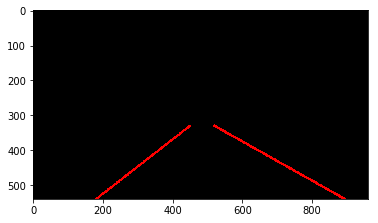

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6728971962616822, 0.696969696969697, 0.696969696969697, 0.6764705882352942]
[-0.603225806451613, -0.6288659793814433, -0.6277777777777778, -0.639344262295082]
0.6858267946090926 -0.6248034564764791 612.6400629557141 -28.423299098738923
116.26066117713404 540 452.3663562132586 330
828.8146563633879 540 522.6148962334331 330
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



t:   0%|                                     | 0/681 [00:00<?, ?it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6728971962616822, 0.696969696969697, 0.696969696969697, 0.6764705882352942]
[-0.603225806451613, -0.6288659793814433, -0.6277777777777778, -0.639344262295082]
0.6858267946090926 -0.6248034564764791 612.6400629557141 -28.423299098738923
116.26066117713404 540 452.3663562132586 330
828.8146563633879 540 522.6148962334331 330


t:   0%|                             | 2/681 [00:00<02:38,  4.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.647887323943662, 0.6962962962962963, 0.6438356164383562, 0.6966292134831461, 0.691358024691358]
[-0.6025641025641025, -0.6282051282051282, -0.6018099547511312, -0.6264367816091954, -0.6044444444444445]
0.6752012949705637 -0.6126920823148004 607.3219230595863 -21.140526918152545
109.87888533704992 540 452.62854060695804 330
831.0714613523012 540 520.0531005105092 330


t:   0%|▏                            | 3/681 [00:00<02:30,  4.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7021276595744681, 0.6528925619834711, 0.6923076923076923, 0.6619718309859155, 0.7282608695652174, 0.717391304347826]
[-0.6019900497512438, -0.6032786885245902, -0.6290322580645161, -0.6294117647058823, -0.6287878787878788, -0.625]
0.692491986460765 -0.6195834399723519 612.032466203351 -32.31507588777749
116.25950849584572 540 455.1969081290105 330
826.4573266945719 540 523.2047200134718 330


t:   1%|▏                            | 4/681 [00:00<02:26,  4.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7, 0.6444444444444445, 0.7142857142857143, 0.6511627906976745, 0.7]
[-0.646551724137931, -0.6201923076923077, -0.6235294117647059, -0.6741573033707865, -0.6058823529411764, -0.6487455197132617]
0.6819785898855667 -0.636509769936695 617.7316739522148 -25.614640088593603
122.12172950612482 540 452.0459662085495 330
829.3730162166844 540 521.4454608439604 330


t:   1%|▏                            | 5/681 [00:01<02:18,  4.88it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7073170731707317, 0.6511627906976745, 0.6764705882352942, 0.7011494252873564, 0.6555555555555556]
[-0.6237942122186495, -0.6513157894736842, -0.6507936507936508, -0.6210526315789474, -0.625]
0.6783310865893225 -0.6343912568129864 616.6018283114001 -25.53691225656066
120.74855617687331 540 451.77455589664305 330
833.7181111661921 540 524.1347761964078 330


t:   1%|▎                            | 6/681 [00:01<02:04,  5.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6756756756756757, 0.7070707070707071]
[-0.6363636363636364, -0.6505576208178439, -0.6266666666666667, -0.6494845360824743, -0.6491803278688525]
0.6913731913731913 -0.6424505575598947 621.9758119036518 -32.64742014742015
127.59863142621572 540 454.4720344124401 330
828.2754195459033 540 524.5320829220138 330


t:   1%|▎                            | 7/681 [00:01<02:01,  5.54it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6612903225806451, 0.6730769230769231, 0.6981132075471698]
[-0.6262975778546713, -0.6515151515151515, -0.6512605042016807, -0.6265060240963856, -0.6244541484716157]
0.6774934844015794 -0.6360066812279008 619.0164796708945 -25.25862243862851
124.23844277601293 540 454.42365340079016 330
834.3380939492188 540 524.3720133374028 330


t:   1%|▎                            | 8/681 [00:01<01:58,  5.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6521739130434783, 0.7068965517241379, 0.7246376811594203, 0.6888888888888889]
[-0.6272401433691757, -0.6527777777777778, -0.6487603305785123, -0.6610169491525424, -0.647887323943662]
0.6931492587039814 -0.647536504964334 624.240408691737 -33.91034066300183
130.0936828208271 540 454.3997233143537 330
827.9751200139391 540 525.0100697552857 330


t:   1%|▍                            | 9/681 [00:01<01:52,  5.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.627906976744186, 0.6666666666666666, 0.7014925373134329]
[-0.625, -0.6530612244897959, -0.6278195488721805, -0.6754385964912281, -0.6495726495726496]
0.6653553935747619 -0.6461784038851708 623.9010309656926 -18.46554051448186
129.84189886451583 540 454.8295473797981 330
839.3492348713191 540 523.7284372826339 330


t:   1%|▍                           | 10/681 [00:01<01:54,  5.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6764705882352942, 0.654320987654321, 0.66, 0.627906976744186, 0.6111111111111112]
[-0.6265060240963856, -0.6747967479674797, -0.6746987951807228, -0.6296296296296297, -0.6746031746031746, -0.6756756756756757, -0.6666666666666666]
0.6459619327489825 -0.6603681019742478 627.938546335381 -8.417817432571667
133.1659510392438 540 451.1704085110393 330
848.9940190418063 540 523.8974624903773 330


t:   2%|▍                           | 11/681 [00:02<01:58,  5.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6666666666666666, 0.6507936507936508, 0.6567164179104478]
[-0.6767676767676768, -0.6441717791411042, -0.6482758620689655, -0.6741573033707865, -0.6434782608695652, -0.6690140845070423, -0.6495327102803738]
0.658058911790255 -0.6579139538579305 626.4879853785943 -16.720524362315416
131.4578979081366 540 450.6485743918691 330
846.0040801632067 540 526.883715348614 330


t:   2%|▍                           | 12/681 [00:02<02:09,  5.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6986301369863014, 0.6538461538461539, 0.7, 0.6447368421052632]
[-0.673469387755102, -0.6442953020134228, -0.674074074074074, -0.6724137931034483, -0.6486486486486487, -0.6691729323308271, -0.673469387755102]
0.6743032832344297 -0.6650776465258036 628.9700012742517 -27.41000707115522
133.77385593848828 540 449.5264618138873 330
841.4759666443567 540 530.0434032543444 330


t:   2%|▌                           | 13/681 [00:02<01:59,  5.57it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6237623762376238, 0.6666666666666666, 0.6229508196721312, 0.6129032258064516]
[-0.6497695852534562, -0.673992673992674, -0.6811594202898551, -0.6385542168674698, -0.6737588652482269, -0.6692913385826772]
0.6315707720957183 -0.6644210167057266 629.6996208780519 -0.6864638473366114
135.00418954655072 540 451.0688454197249 330
856.0979825795238 540 523.5936785833703 330


t:   2%|▌                           | 14/681 [00:02<02:04,  5.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.627906976744186, 0.676923076923077, 0.6747967479674797, 0.6119402985074627]
[-0.6495327102803738, -0.6744186046511628, -0.6557377049180327, -0.6835443037974683, -0.6496815286624203, -0.6732673267326733]
0.6478917750355513 -0.6643636965070219 630.4760568760505 -10.376602718767955
136.18452867268348 540 452.276454080562 330
849.488485462819 540 525.3602774940163 330


t:   2%|▌                           | 15/681 [00:02<01:54,  5.83it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.6518518518518519, 0.6444444444444445]
[-0.6506550218340611, -0.6942148760330579, -0.6512455516014235, -0.7005649717514124, -0.6951219512195121, -0.7, -0.6593406593406593]
0.6389953171562367 -0.6787347188257324 635.5650650136962 -2.156236696466616
140.79884579800444 540 450.19807671301857 330
848.4510326449035 540 519.8101265822786 330


t:   2%|▋                           | 16/681 [00:02<02:01,  5.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6283185840707964, 0.6476190476190476, 0.6153846153846154, 0.6226415094339622]
[-0.65, -0.700507614213198, -0.7004048582995951, -0.6578947368421053, -0.691358024691358, -0.6607142857142857]
0.6284909391271054 -0.6768132532934237 635.1357336950135 0.6844396656385356
140.56422984047072 540 450.84184183776 330
858.1119102264269 540 523.9782148518151 330


t:   2%|▋                           | 17/681 [00:03<01:56,  5.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6792452830188679, 0.6346153846153846, 0.5945945945945946, 0.6557377049180327, 0.6507936507936508]
[-0.701195219123506, -0.671875, -0.6745562130177515, -0.6666666666666666, -0.7, -0.6727272727272727]
0.6429973235881061 -0.6811700619225328 635.1594274506779 -5.5774814190063235
139.6999556646693 540 447.9930115974219 330
848.4910611673006 540 521.8956115499665 330


t:   3%|▋                           | 18/681 [00:03<01:52,  5.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6486486486486487, 0.6744186046511628]
[-0.7018181818181818, -0.6733870967741935, -0.6719745222929936, -0.7022900763358778, -0.6666666666666666]
0.6615336266499057 -0.6832273087775825 637.289379284432 -17.628849780012587
142.39679537766185 540 449.7615586154312 330
842.9334916864609 540 525.4893111638956 330


t:   3%|▊                           | 19/681 [00:03<01:49,  6.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.631578947368421, 0.6515151515151515, 0.6744186046511628]
[-0.7007299270072993, -0.6768707482993197, -0.6747572815533981, -0.7045454545454546, -0.7073170731707317]
0.6525042345115785 -0.6928440969152406 641.3331848785165 -13.290710037956046
146.25683516635794 540 449.35532577194425 330
847.9496082536734 540 526.112616410713 330


t:   3%|▊                           | 20/681 [00:03<01:45,  6.28it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6779661016949152, 0.6428571428571429, 0.7258064516129032]
[-0.6742671009771987, -0.7014925373134329, -0.6738197424892703, -0.7041420118343196, -0.7014925373134329]
0.6822098987216538 -0.6910427859855309 640.6402617535089 -30.746296440938313
145.63535542879697 540 449.5239195797249 330
836.613918253635 540 528.7907682326451 330


t:   3%|▊                           | 21/681 [00:03<01:45,  6.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6176470588235294, 0.5909090909090909, 0.6341463414634146]
[-0.6736842105263158, -0.7018867924528301, -0.7038834951456311, -0.6717948717948717, -0.673469387755102, -0.7008547008547008]
0.6142341637320117 -0.6875955764215753 637.5568688685277 8.43243772009913
141.8811758159335 540 447.2932628059257 330
865.4151684597961 540 523.5260121744054 330


t:   3%|▉                           | 22/681 [00:03<01:39,  6.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6122448979591837, 0.6888888888888889, 0.6790123456790124]
[-0.7018867924528301, -0.6738351254480287, -0.676056338028169]
0.6600487108423616 -0.6839260853096759 634.424711783698 -19.234181573864117
138.0627436383615 540 445.1134681401383 330
847.2619859527688 540 529.1036492263844 330


t:   3%|▉                           | 23/681 [00:04<01:45,  6.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7021276595744681, 0.6290322580645161]
[-0.7011070110701108, -0.6736842105263158, -0.7, -0.6709677419354839]
0.6655799588194922 -0.6864397408829777 636.3767438400191 -23.036890871654094
140.40088022300148 540 446.32722377920913 330
845.9342614075792 540 530.4199535962878 330


t:   4%|▉                           | 24/681 [00:04<01:45,  6.22it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6428571428571429, 0.631578947368421, 0.5974025974025974, 0.6]
[-0.700374531835206, -0.6712328767123288, -0.7019607843137254, -0.6737588652482269, -0.6736111111111112]
0.6179596719070404 -0.6841876338441197 635.1413174175121 6.544190020505809
139.05734729953983 540 445.9906936684466 330
863.2534358322042 540 523.4254348367115 330


t:   4%|█                           | 25/681 [00:04<01:47,  6.09it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6229508196721312, 0.651685393258427, 0.6236559139784946, 0.6511627906976745, 0.6333333333333333]
[-0.702928870292887, -0.7011494252873564, -0.6736842105263158, -0.6744186046511628, -0.6716417910447762]
0.6365576501880121 -0.6847645803604996 636.573137485095 -4.515100614350513
141.03115180731652 540 447.7058923282761 330
855.4057915312524 540 525.5063708927996 330


t:   4%|█                           | 26/681 [00:04<01:48,  6.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6218487394957983, 0.6454545454545455, 0.6434782608695652, 0.6212121212121212, 0.6263736263736264]
[-0.6754385964912281, -0.7041666666666667, -0.6737588652482269, -0.7023809523809523, -0.6742424242424242]
0.6316734586811312 -0.6859975010058996 638.7429814017635 -1.3543984234009827
143.94073047929993 540 450.0642946206713 330
857.0162177681059 540 524.5659665917176 330


t:   4%|█                           | 27/681 [00:04<01:46,  6.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5986842105263158, 0.6442953020134228, 0.5987654320987654, 0.624113475177305]
[-0.6742424242424242, -0.703862660944206, -0.7009803921568627, -0.6741071428571429, -0.7843137254901961]
0.6131716839631618 -0.7075012691381664 648.1374592414024 10.357304150815537
152.8441911816338 540 449.6634467227706 330
863.7755292708599 540 521.2939609070206 330


t:   4%|█▏                          | 28/681 [00:04<01:44,  6.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5984848484848485, 0.6260162601626016, 0.6, 0.6341463414634146, 0.6477272727272727, 0.6507936507936508]
[-0.6743295019157088, -0.7257383966244726, -0.6751054852320675, -0.7272727272727273, -0.7115384615384616]
0.6261947289386314 -0.7027969145166877 645.457443029835 1.1854202595056336
150.05393571250647 540 448.86002842908687 330
860.4585041042392 540 525.0995649513349 330


t:   4%|█▏                          | 29/681 [00:05<01:40,  6.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6071428571428571, 0.6477272727272727, 0.6041666666666666, 0.6329113924050633, 0.5901639344262295]
[-0.7272727272727273, -0.6752136752136753, -0.7226277372262774, -0.6781609195402298, -0.7261904761904762]
0.6164224246736177 -0.7058931070886773 646.4036153012745 4.556366113481192
150.73615853838848 540 448.23162618235705 330
868.631010901371 540 527.9555396753032 330


t:   4%|█▏                          | 30/681 [00:05<01:36,  6.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.574468085106383, 0.6341463414634146, 0.6341463414634146, 0.6274509803921569]
[-0.7272727272727273, -0.6767241379310345, -0.6761904761904762, -0.7268722466960352, -0.6793893129770993]
0.6175529371063423 -0.6972897802134745 642.3219117544144 5.031851297862147
146.7423080875911 540 447.9083454497173 330
866.2709163182501 540 526.2190966572612 330


t:   5%|█▎                          | 31/681 [00:05<01:39,  6.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6382978723404256]
[-0.7291666666666666, -0.6748768472906403, -0.6785714285714286, -0.7267080745341615, -0.7441860465116279, -0.7183098591549296]
0.6382978723404256 -0.7119698204549091 649.4673072677666 -11.382978723404278
153.752735190128 540 448.70905772894247 330
863.8333333333333 540 534.8333333333334 330


t:   5%|█▎                          | 32/681 [00:05<01:36,  6.74it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6229508196721312]
[-0.728110599078341, -0.6777251184834123, -0.6763005780346821, -0.7222222222222222, -0.6842105263157895, -0.8]
0.6229508196721312 -0.7147615073557412 650.3885244540028 -2.6885245901639223
154.44105945546076 540 448.24535338966353 330
871.1578947368422 540 534.0526315789473 330


t:   5%|█▎                          | 33/681 [00:05<01:38,  6.58it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5853658536585366, 0.6774193548387096]
[-0.7291666666666666, -0.7007874015748031, -0.7, -0.728448275862069, -0.6981132075471698, -0.7831325301204819]
0.6313926042486231 -0.7232746802951985 652.0597220298533 -5.0735641227379915
154.93383783892048 540 445.2799618236427 330
863.2878504672897 540 530.6897196261682 330


t:   5%|█▍                          | 34/681 [00:05<01:47,  6.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6222222222222222, 0.6666666666666666, 0.6122448979591837]
[-0.7004608294930875, -0.7295918367346939, -0.7303370786516854, -0.711864406779661, -0.7014925373134329, -0.7741935483870968, -0.7027027027027027]
0.6337112622826908 -0.7215204200089086 651.2323053851933 -7.697656840513996
154.1637662643282 540 445.21581992263924 330
864.270038167939 540 532.8888358778627 330


t:   5%|█▍                          | 35/681 [00:05<01:44,  6.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.65, 0.6111111111111112, 0.6]
[-0.7022222222222222, -0.754601226993865, -0.7692307692307693, -0.7142857142857143, -0.7459016393442623, -0.75, -0.7]
0.6204501915708812 -0.7337487960109762 656.0420440073743 1.5046455938697108
158.14955286909725 540 444.3510446353046 330
867.9106908529526 540 529.4467773060594 330


t:   5%|█▍                          | 36/681 [00:06<01:46,  6.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6078431372549019, 0.6507936507936508, 0.5774647887323944, 0.5853658536585366]
[-0.7014925373134329, -0.7540106951871658, -0.765625, -0.7674418604651163, -0.6966292134831461, -0.7212121212121212, -0.7323943661971831]
0.605366857609871 -0.7341151134083094 655.8300779904218 10.005692051239365
157.78190078753767 540 443.84058036576283 330
875.4927715093312 540 528.5956836358247 330


t:   5%|█▌                          | 37/681 [00:06<01:46,  6.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5930232558139535, 0.6511627906976745, 0.6538461538461539, 0.6022727272727273]
[-0.7012987012987013, -0.7551020408163265, -0.754601226993865, -0.7045454545454546, -0.7450980392156863]
0.6250762319076273 -0.7321290925740067 655.353455838554 -1.74090299235651
157.55890185021386 540 444.393562745447 330
866.6797349485752 540 530.7207122240742 330


t:   6%|█▌                          | 38/681 [00:06<01:52,  5.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6031746031746031, 0.5765765765765766, 0.6285714285714286, 0.6213592233009708]
[-0.7543103448275862, -0.7239583333333334, -0.7254901960784313, -0.7527472527472527, -0.7209302325581395, -0.7608695652173914]
0.6074204579058948 -0.7397176541270224 656.3274900501384 9.745451970694702
157.25931292990737 540 441.15141531298684 330
872.9612925079574 540 527.2370132764297 330


t:   6%|█▌                          | 39/681 [00:06<01:51,  5.74it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6268656716417911, 0.6, 0.5724137931034483, 0.5769230769230769]
[-0.7554585152838428, -0.7, -0.7024390243902439, -0.7079646017699115, -0.7573529411764706]
0.5940506354170791 -0.7246430165240938 650.5017469167265 16.999311136624556
152.49128798173186 540 442.2891542570604 330
880.3974908572903 540 526.8922718071325 330


t:   6%|█▋                          | 40/681 [00:06<01:45,  6.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6283783783783784, 0.5934959349593496, 0.5929203539823009]
[-0.7534246575342466, -0.703862660944206, -0.7029702970297029, -0.7530864197530864, -0.7053571428571429]
0.6049315557733429 -0.7237402356236768 648.8778750226286 8.730790633067746
150.43778093780296 540 440.5971359984406 330
878.2302796020602 540 531.083568547226 330


t:   6%|█▋                          | 41/681 [00:06<01:48,  5.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.576, 0.6260869565217392, 0.6229508196721312, 0.5975609756097561, 0.5748031496062992]
[-0.7533039647577092, -0.7046632124352331, -0.7004830917874396, -0.7540322580645161]
0.599480380281985 -0.7281206317612245 650.8786732745189 13.976108260865454
152.28063652903018 540 440.6943839763984 330
877.4664009716251 540 527.163026737393 330


t:   6%|█▋                          | 42/681 [00:07<01:52,  5.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6197183098591549, 0.6052631578947368, 0.5955056179775281]
[-0.7030567685589519, -0.7538461538461538, -0.7540322580645161, -0.7016574585635359]
0.6068290285771399 -0.7281481597582895 651.2054906091207 7.376997248620853
152.72371305042594 540 441.1265568751085 330
877.7151020613579 540 531.6538721093291 330


t:   6%|█▊                          | 43/681 [00:07<01:50,  5.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6020408163265306]
[-0.7033492822966507, -0.7631578947368421, -0.7485380116959064, -0.7008547008547008, -0.7531380753138075]
0.6020408163265306 -0.7338075929795815 653.4978456494202 10.132653061224516
154.66976184938218 540 440.8483214733125 330
880.1186440677965 540 531.3050847457627 330


t:   6%|█▊                          | 44/681 [00:07<01:46,  5.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6129032258064516, 0.6444444444444445, 0.6]
[-0.7008928571428571, -0.7528089887640449, -0.7540322580645161, -0.7014925373134329, -0.7101449275362319]
0.619115890083632 -0.7238743137642165 648.8947060421067 0.9058542413381095
150.4331677081394 540 440.53877859517263 330
870.748359706677 540 531.5549980702432 330


t:   7%|█▊                          | 45/681 [00:07<01:39,  6.38it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6338028169014085, 0.6530612244897959, 0.5961538461538461, 0.6716417910447762]
[-0.7009345794392523, -0.7631578947368421, -0.7540983606557377, -0.7543103448275862, -0.7011494252873564, -0.7101449275362319]
0.6386649196474566 -0.7306325887471677 653.0600161744031 -8.155710092934186
154.74264071394586 540 442.16480506072344 330
858.2837309985907 540 529.4728106870131 330


t:   7%|█▉                          | 46/681 [00:07<01:47,  5.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6086956521739131, 0.6511627906976745]
[-0.7004608294930875, -0.7543103448275862, -0.7580645161290323, -0.725, -0.7533333333333333]
0.6299292214357938 -0.7382338047566079 655.7795874251815 -2.844287158746255
156.83322367410884 540 441.29594896103333 330
861.7544141252007 540 528.3836276083468 330


t:   7%|█▉                          | 47/681 [00:07<01:44,  6.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6326530612244898, 0.6226415094339622, 0.620253164556962]
[-0.7014218009478673, -0.7567567567567568, -0.7525773195876289, -0.7068965517241379, -0.7018633540372671, -0.7592592592592593]
0.625182578405138 -0.7297958403854862 652.5429506100289 -0.15734968455975226
154.2115539471731 540 441.9632625470408 330
863.9993632940309 540 528.0974887796815 330


t:   7%|█▉                          | 48/681 [00:08<01:36,  6.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.6379310344827587, 0.6703296703296703, 0.6590909090909091]
[-0.7009345794392523, -0.752895752895753, -0.7532467532467533, -0.7046979865771812, -0.7090909090909091]
0.6480879034758346 -0.7241731962499698 650.0427606702685 -12.146357952392421
151.95641214023064 540 441.9422899488209 330
851.9621412328682 540 527.9320229823578 330


t:   7%|██                          | 49/681 [00:08<01:34,  6.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.603448275862069, 0.6233766233766234, 0.573170731707317]
[-0.7534883720930232, -0.7011494252873564, -0.751937984496124, -0.7063492063492064, -0.7019230769230769]
0.5999985436486698 -0.7229696130297574 649.3411312718289 16.195968455430204
151.23890313122803 540 441.707542774256 330
873.0088382535879 540 523.0079887132498 330


t:   7%|██                          | 50/681 [00:08<01:36,  6.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6195652173913043, 0.6065573770491803, 0.5742574257425742, 0.6210526315789474, 0.5816326530612245]
[-0.7529411764705882, -0.7538461538461538, -0.7039473684210527, -0.7010309278350515]
0.6005108841372052 -0.7279414066432115 650.9958863241861 15.162069166697506
152.47914916123042 540 440.96390642814055 330
873.9857089973862 540 524.2834712074396 330


t:   7%|██                          | 51/681 [00:08<01:34,  6.63it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6229508196721312, 0.5952380952380952, 0.625]
[-0.7529411764705882, -0.7043478260869566, -0.7559055118110236, -0.7037037037037037, -0.704]
0.6143963049700755 -0.7241796436144543 648.8412469934863 7.734810044236269
150.29592167248518 540 440.2792177395614 330
866.3222510455821 540 524.5233204510562 330


t:   8%|██▏                         | 52/681 [00:08<01:38,  6.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6212121212121212, 0.5922330097087378, 0.625, 0.5932203389830508, 0.6235294117647059]
[-0.7031963470319634, -0.751937984496124, -0.7027027027027027, -0.7540322580645161, -0.7027027027027027]
0.6091991469447693 -0.7229143989996017 648.5382619882109 9.506169880326667
150.13985354062746 540 440.63067830578154 330
870.8052740720082 540 526.0904118579301 330


t:   8%|██▏                         | 53/681 [00:11<08:50,  1.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6194029850746269, 0.5763888888888888, 0.5789473684210527, 0.6237623762376238, 0.6296296296296297]
[-0.7033492822966507, -0.75390625, -0.7, -0.751004016064257]
0.6056262496503644 -0.7270648870902269 650.5123228109808 14.802739526702078
151.99788185791797 540 440.8304244944317 330
867.1969895236556 540 520.4484790004814 330


t:   8%|██▏                         | 54/681 [00:11<07:22,  1.42it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6326530612244898, 0.5897435897435898, 0.5959595959595959, 0.6236559139784946, 0.6236559139784946]
[-0.701195219123506, -0.75, -0.7, -0.752]
0.613133614976933 -0.7257988047808765 649.7742290836653 8.199177576136094
151.24608687776345 540 440.5824685536748 330
867.3489912045861 540 524.8461584282417 330


t:   8%|██▎                         | 55/681 [00:11<05:41,  1.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6229508196721312, 0.5918367346938775, 0.62, 0.6271186440677966, 0.6326530612244898, 0.6511627906976745]
[-0.70042194092827, -0.75, -0.6964285714285714, -0.7558139534883721, -0.75, -0.6851851851851852]
0.6242870083926616 -0.7229749418383998 649.003778232583 1.9271067676474445
150.7711705130545 540 441.23766920802507 330
861.8998729730373 540 525.5161309171478 330


t:   8%|██▎                         | 56/681 [00:11<04:22,  2.38it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6290322580645161, 0.6727272727272727]
[-0.6972111553784861, -0.75, -0.7016806722689075, -0.75, -0.7300613496932515]
0.6508797653958944 -0.725790635468129 650.747061134233 -12.677859237536666
152.58816485390733 540 441.92780322572474 330
849.1243523316064 540 526.4841180446047 330


t:   8%|██▎                         | 57/681 [00:11<03:28,  3.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6338028169014085, 0.6521739130434783, 0.6086956521739131]
[-0.6987951807228916, -0.751269035532995, -0.7512953367875648, -0.7]
0.6315574607062666 -0.7253398882608628 649.3066917679926 -1.6795264339661269
150.69720214901687 540 440.2166445493432 330
857.6884292178408 540 525.1771170006465 330


t:   9%|██▍                         | 58/681 [00:12<02:57,  3.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6491228070175439, 0.6301369863013698, 0.6]
[-0.7019607843137254, -0.75, -0.6996047430830039, -0.75]
0.6264199311063047 -0.7253913818491824 649.5680762225838 1.6450692942401777
151.04684031849217 540 440.5457305102446 330
859.4153920916668 540 524.1770167271983 330


t:   9%|██▍                         | 59/681 [00:12<02:28,  4.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6282051282051282, 0.6, 0.6341463414634146, 0.5714285714285714]
[-0.701195219123506, -0.75, -0.75, -0.75, -0.7008196721311475]
0.6084450102742787 -0.7304029782509307 651.1868199333812 12.351820334137415
152.2266793046713 540 439.7391980828385 330
867.2076699716972 540 522.0655512035034 330


t:   9%|██▍                         | 60/681 [00:12<02:07,  4.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.66, 0.627906976744186, 0.5714285714285714, 0.6794871794871795]
[-0.7, -0.7311827956989247, -0.7291666666666666, -0.7272727272727273]
0.6347056819149842 -0.7219055474095797 649.5386119257087 -2.4492145838657393
151.7353791209488 540 442.63216022139187 330
854.6468545030675 540 523.7848408428077 330


t:   9%|██▌                         | 61/681 [00:12<02:08,  4.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6736842105263158, 0.6538461538461539, 0.6714285714285714, 0.5797101449275363, 0.609375]
[-0.7293233082706767, -0.6980392156862745, -0.6979591836734694, -0.7142857142857143]
0.6376088161457154 -0.7099018554790337 644.6005454813504 -2.696379205748485
147.34507970931722 540 443.16061868729946 330
851.1431546481688 540 521.7876082969907 330


t:   9%|██▌                         | 62/681 [00:12<02:36,  3.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5925925925925926, 0.6486486486486487, 0.660377358490566, 0.6712328767123288, 0.6511627906976745]
[-0.7283018867924528, -0.6954022988505747, -0.7, -0.7276119402985075, -0.6979166666666666]
0.6448028534283621 -0.7098465585216402 642.364831559509 -8.297585883442457
144.20698435546234 540 440.04556732662707 330
850.3336841147503 540 524.6527432140582 330


t:   9%|██▌                         | 63/681 [00:13<02:13,  4.63it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6185567010309279, 0.5961538461538461, 0.6708860759493671]
[-0.7238805970149254, -0.6785714285714286, -0.7293233082706767, -0.6756756756756757, -0.678082191780822]
0.6285322077113804 -0.6971066402627057 637.9917240446489 2.1152700120793497
140.56920187666057 540 441.8143598927443 330
855.7791046961197 540 521.6673480931371 330


t:   9%|██▋                         | 64/681 [00:13<02:00,  5.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6060606060606061, 0.624, 0.5824175824175825, 0.6190476190476191, 0.5964912280701754, 0.5760869565217391]
[-0.7286245353159851, -0.677570093457944, -0.676923076923077, -0.6790123456790124, -0.6744186046511628]
0.6006839986862871 -0.6873097312054363 634.0121804093822 18.8886636239428
136.78284496932577 540 442.32194977974666 330
867.5299117601643 540 517.9284566535258 330


t:  10%|██▋                         | 65/681 [00:13<01:45,  5.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6258503401360545, 0.5945945945945946, 0.5986394557823129, 0.6258503401360545]
[-0.726027397260274, -0.678391959798995, -0.7279411764705882, -0.6739130434782609, -0.6783625730994152]
0.6112336826622541 -0.6969272300215067 638.3303969725731 13.019305019305023
141.09134029608614 540 442.4140479674732 330
862.1591216724321 540 518.5916679199879 330


t:  10%|██▋                         | 66/681 [00:13<01:59,  5.13it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5982142857142857, 0.6404494382022472, 0.6428571428571429, 0.5983606557377049, 0.6494845360824743, 0.6206896551724138, 0.7045454545454546]
[-0.7256317689530686, -0.6774193548387096, -0.6785714285714286, -0.7242647058823529, -0.676923076923077]
0.6363715954731033 -0.6965620670337274 638.7605984445001 -2.224991853334838
141.78291227523619 540 443.2635841904811 330
852.0571875151401 540 522.0613148302854 330


t:  10%|██▊                         | 67/681 [00:13<01:46,  5.76it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6509433962264151, 0.6266666666666667, 0.5769230769230769, 0.6052631578947368, 0.5697674418604651]
[-0.7230215827338129, -0.7282608695652174, -0.6954022988505747, -0.6940298507462687, -0.6944444444444444, -0.6904761904761905]
0.6059127479142721 -0.704272539469418 640.905028056526 17.460623681930723
143.2755395127935 540 441.455559648477 330
862.4003672423163 540 515.8158124151055 330


t:  10%|██▊                         | 68/681 [00:13<01:52,  5.47it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.65625, 0.6744186046511628, 0.6481481481481481]
[-0.7282608695652174, -0.6797385620915033, -0.6783625730994152, -0.7256317689530686, -0.6808510638297872]
0.6596055842664369 -0.6985689675077984 640.0422015453266 -14.556883433821403
143.2101999924722 540 443.8247559885567 330
840.7401281336291 540 522.3680509269965 330


t:  10%|██▊                         | 69/681 [00:14<01:41,  6.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.647887323943662, 0.6567164179104478, 0.6222222222222222]
[-0.7285714285714285, -0.6778242677824268, -0.6797385620915033, -0.6744186046511628]
0.6422753213587774 -0.6901382157741304 636.8438706467634 -7.376493121248245
140.32532677259923 540 444.61220032943055 330
852.2458748114996 540 525.2832888044105 330


t:  10%|██▉                         | 70/681 [00:14<01:36,  6.31it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6363636363636364, 0.6527777777777778]
[-0.7266187050359713, -0.6792452830188679, -0.6758241758241759, -0.723404255319149]
0.6445707070707071 -0.701273104799541 642.0965579810934 -8.194444444444457
145.58744272714935 540 445.0428169069827 330
850.4799216454456 540 524.6816846229187 330


t:  10%|██▉                         | 71/681 [00:14<01:29,  6.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.6716417910447762, 0.603448275862069, 0.6428571428571429, 0.7323943661971831, 0.625]
[-0.7262569832402235, -0.6772727272727272, -0.7217391304347827, -0.6772727272727272, -0.7413793103448276, -0.7285714285714285]
0.6500569293268618 -0.7120820511894528 646.3355728569364 -9.821348251630221
149.33050577432033 540 444.24034046151496 330
845.8049186876199 540 522.7562893660983 330


t:  11%|██▉                         | 72/681 [00:14<01:47,  5.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6304347826086957, 0.6078431372549019, 0.6904761904761905, 0.6753246753246753]
[-0.6739130434782609, -0.7272727272727273, -0.7259786476868327, -0.676]
0.6510196964161159 -0.7007911046094553 641.9209109335659 -9.064719168299732
145.43693586174373 540 445.09827376789644 330
843.391870001658 540 520.8209844262191 330


t:  11%|███                         | 73/681 [00:14<01:36,  6.28it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6481481481481481, 0.6727272727272727, 0.6282051282051282, 0.6, 0.6235294117647059, 0.5901639344262295]
[-0.6752136752136753, -0.7255813953488373, -0.7235294117647059, -0.676, -0.7244094488188977]
0.6271289825452474 -0.7049467862292232 644.194919687875 3.6912040148620044
147.80536875019465 540 445.70019443383933 330
855.1810088707601 540 520.3216643899802 330


t:  11%|███                         | 74/681 [00:14<01:59,  5.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.632183908045977, 0.6461538461538462, 0.6, 0.5942028985507246, 0.6122448979591837]
[-0.6744186046511628, -0.7243816254416962, -0.7262569832402235, -0.7252747252747253, -0.68]
0.6169571101419462 -0.7060663877215616 644.6836354515517 10.197582464654635
148.2631623201328 540 445.68561954495374 330
858.7346005518135 540 518.3543754958378 330


t:  11%|███                         | 75/681 [00:15<01:47,  5.64it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6410256410256411, 0.6043956043956044, 0.6463414634146342]
[-0.6775510204081633, -0.7263157894736842, -0.7268518518518519, -0.6777251184834123, -0.72]
0.6305875696119599 -0.7056887560434223 644.8184596400351 4.912043241311551
148.53355497361144 540 446.1151703835052 330
848.5545585491983 540 515.5318189331506 330


t:  11%|███                         | 76/681 [00:15<01:37,  6.20it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6216216216216216, 0.6415094339622641, 0.6448598130841121, 0.6266666666666667, 0.627906976744186]
[-0.726890756302521, -0.6796875, -0.7263157894736842, -0.6766169154228856, -0.6752136752136753]
0.6325129024157702 -0.6969449272825532 640.8157928497778 1.5734827120592514
144.65388713404815 540 445.96894343097483 330
851.249856297819 540 519.2408186988348 330


t:  11%|███▏                        | 77/681 [00:15<01:29,  6.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.646551724137931, 0.5986394557823129, 0.6474820143884892, 0.6, 0.6506024096385542]
[-0.726775956284153, -0.6751269035532995, -0.7218934911242604, -0.6793478260869565, -0.7266187050359713, -0.6865671641791045]
0.6286551207894575 -0.7027216743772908 643.4582740462283 5.417487001555514
147.2251074906815 540 446.06319326068314 330
850.3589572723471 540 516.3125253650009 330


t:  11%|███▏                        | 78/681 [00:15<02:04,  4.85it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6013986013986014, 0.6222222222222222, 0.6028368794326241, 0.6230769230769231, 0.6483516483516484, 0.7]
[-0.7262569832402235, -0.6772727272727272, -0.6748466257668712, -0.7456140350877193, -0.6836734693877551, -0.7476635514018691]
0.6329810457470031 -0.7092212320261941 645.5158749211006 3.967320425831067
148.77709543416984 540 444.87652184311287 330
846.8384372261542 540 515.0749485545912 330


t:  12%|███▏                        | 79/681 [00:15<02:10,  4.62it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5981308411214953, 0.6435643564356436, 0.6732673267326733, 0.6018518518518519, 0.6363636363636364, 0.7011494252873564]
[-0.6756756756756757, -0.7265625, -0.7225806451612903, -0.6795580110497238]
0.6423879062987761 -0.7010942079716724 642.3453756319783 -1.9010502529108446
145.9794910131586 540 445.511276630884 330
843.572933019806 540 516.6676504936302 330


t:  12%|███▎                        | 80/681 [00:16<01:53,  5.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6440677966101694, 0.625, 0.6442307692307693, 0.7052631578947368]
[-0.6761904761904762, -0.7272727272727273, -0.7243589743589743, -0.6666666666666666, -0.676923076923077, -0.6666666666666666]
0.6546404309339189 -0.6896797646797648 637.0067182817182 -11.917040931860285
140.65472593176753 540 445.14386821870727 330
843.0842564130785 540 522.297470145675 330


t:  12%|███▎                        | 81/681 [00:16<01:42,  5.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6521739130434783, 0.6238532110091743, 0.7]
[-0.7240143369175627, -0.6741071428571429, -0.6785714285714286, -0.7]
0.6586757080175508 -0.6941732270865335 639.6415770609319 -14.698603909054649
143.5399309177202 540 446.0580802871168 330
842.1421910010296 540 523.320656452492 330


t:  12%|███▎                        | 82/681 [00:16<01:30,  6.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.672566371681416, 0.6617647058823529, 0.6666666666666666]
[-0.723404255319149, -0.6764705882352942, -0.6767676767676768, -0.7222222222222222, -0.725609756097561]
0.6669992480768118 -0.7048948997283807 643.0220851483176 -19.28920122621319
146.1524053983302 540 444.06915877662806 330
838.5154898432589 540 523.6725562035251 330


t:  12%|███▍                        | 83/681 [00:16<01:28,  6.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6792452830188679, 0.6493506493506493, 0.6268656716417911]
[-0.723404255319149, -0.6747967479674797, -0.6745562130177515, -0.7039473684210527, -0.6756756756756757]
0.6518205346704361 -0.6904760520802217 636.7498345942756 -10.709270359791352
140.1204781871782 540 444.25847018172396 330
844.878676058024 540 522.7041067861658 330


t:  12%|███▍                        | 84/681 [00:16<01:42,  5.85it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6222222222222222, 0.6666666666666666, 0.654320987654321, 0.676056338028169]
[-0.7241379310344828, -0.6742081447963801, -0.6764705882352942, -0.7252252252252253]
0.6548165536428447 -0.7000104723228455 639.8758326902343 -11.836306729264479
142.67762646295313 540 442.67313839173437 330
842.7342034334878 540 522.0336975715974 330


t:  12%|███▍                        | 85/681 [00:16<01:30,  6.58it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6666666666666666, 0.6111111111111112, 0.6511627906976745, 0.6037735849056604, 0.6756756756756757]
[-0.7236363636363636, -0.6811594202898551, -0.6756756756756757, -0.7239819004524887, -0.673469387755102]
0.6416779658113576 -0.6955845495618971 637.4239027431865 -4.026098454751366
140.06047547281986 540 441.9648235959419 330
847.8179514343583 540 520.5509870241506 330


t:  13%|███▌                        | 86/681 [00:17<02:00,  4.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6521739130434783, 0.625, 0.6756756756756757, 0.6666666666666666, 0.625]
[-0.6756756756756757, -0.7242798353909465, -0.7194244604316546, -0.725925925925926]
0.6489032510771641 -0.7113264743560507 644.6495110618213 -8.405532706619658
147.11881932492156 540 442.3419096648512 330
845.1268071107355 540 521.5038330365497 330


t:  13%|███▌                        | 87/681 [00:17<01:46,  5.55it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.620253164556962, 0.6710526315789473, 0.6666666666666666, 0.6219512195121951, 0.6486486486486487]
[-0.6718146718146718, -0.7040358744394619, -0.7034482758620689, -0.7021276595744681, -0.7045454545454546]
0.645714466192684 -0.6971943872472252 640.1937494066306 -6.412088388741347
143.709919700059 540 444.9171638219684 330
846.2131747032745 540 520.9920266651645 330


t:  13%|███▌                        | 88/681 [00:17<01:38,  6.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6212121212121212, 0.6494845360824743, 0.6268656716417911, 0.5980392156862745]
[-0.6745098039215687, -0.7030075187969925, -0.7014925373134329, -0.7019230769230769, -0.6740331491712708]
0.6239003861556652 -0.6909932172252683 636.326613764878 6.319832387486457
139.4031248985109 540 443.31348865471347 330
855.3932317640184 540 518.8010374652248 330


t:  13%|███▋                        | 89/681 [00:17<01:30,  6.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6446280991735537, 0.6220472440944882, 0.626984126984127, 0.6511627906976745, 0.648, 0.6506024096385542]
[-0.6722689075630253, -0.7024221453287197, -0.7012195121951219, -0.7]
0.6405707784313995 -0.6939776412717167 638.3665340957043 -2.98651903216224
141.74308831542075 540 444.3464972886179 330
847.6604573842767 540 519.8278320587218 330


t:  13%|███▋                        | 90/681 [00:17<02:19,  4.24it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6190476190476191, 0.6518987341772152, 0.6222222222222222, 0.6455696202531646, 0.7051282051282052, 0.6242038216560509]
[-0.7017543859649122, -0.6729857819905213, -0.6745098039215687, -0.6956521739130435]
0.6446783704140795 -0.6862255364475115 634.216443203134 -4.904353217680646
137.29661488681785 540 443.31845296521266 330
845.2344273124696 540 519.490599634311 330


t:  13%|███▋                        | 91/681 [00:18<02:16,  4.31it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6209677419354839, 0.6736842105263158, 0.6541353383458647, 0.6470588235294118, 0.6204379562043796, 0.6461538461538462, 0.6829268292682927, 0.6515151515151515]
[-0.7010309278350515, -0.6715328467153284, -0.703862660944206]
0.6496099871848432 -0.6921421451648619 638.469567965847 -7.050902560128684
142.26784000039822 540 445.67372485657893 330
842.1220630101983 540 518.8511710245959 330


t:  14%|███▊                        | 92/681 [00:18<01:56,  5.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6262626262626263, 0.6666666666666666, 0.6818181818181818, 0.6526315789473685, 0.6136363636363636, 0.6790123456790124]
[-0.7010309278350515, -0.6736842105263158, -0.6735537190082644, -0.7044334975369458, -0.7062937062937062]
0.6533379605017031 -0.6917992122400568 638.9360834253488 -8.621700435150737
143.01271478033658 540 446.5690014664932 330
839.7211452612672 540 518.2948503024692 330


t:  14%|███▊                        | 93/681 [00:18<01:46,  5.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6153846153846154, 0.6486486486486487, 0.6428571428571429, 0.6781609195402298]
[-0.702054794520548, -0.6711409395973155, -0.6741573033707865, -0.7004608294930875]
0.6462628316076592 -0.6869534667454343 637.8875801848807 -2.280745931608024
142.49521244668972 540 448.1927744590234 330
839.1024818534237 540 514.1572896974724 330


t:  14%|███▊                        | 94/681 [00:18<01:35,  6.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6486486486486487, 0.6261682242990654]
[-0.6719242902208202, -0.7009803921568627, -0.7024221453287197, -0.668918918918919, -0.7777777777777778]
0.637408436473857 -0.7044047048806198 646.583276695752 0.14928012124272527
151.30971720839858 540 449.43379069196527 330
846.9463047354864 540 517.4872201307708 330


t:  14%|███▉                        | 95/681 [00:18<01:28,  6.62it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6515151515151515, 0.6730769230769231]
[-0.7014388489208633, -0.6717557251908397, -0.6745283018867925, -0.7079646017699115, -0.7027027027027027, -0.6746987951807228]
0.6622960372960374 -0.6888481626086387 639.68334558151 -11.265442890442898
144.71018577448683 540 449.56691821424386 330
832.3550373955126 540 515.2762868455785 330


t:  14%|███▉                        | 96/681 [00:19<02:06,  4.63it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6506024096385542, 0.6285714285714286, 0.691358024691358]
[-0.6766666666666666, -0.7021276595744681, -0.7041420118343196, -0.6738197424892703, -0.7063492063492064]
0.656843954300447 -0.6926210573827862 641.8079569674067 -9.546595553288986
146.98940478666552 540 450.1854999119408 330
836.6471091883125 540 516.9364707252478 330


t:  14%|███▉                        | 97/681 [00:19<01:52,  5.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.65, 0.7317073170731707, 0.6904761904761905, 0.6774193548387096]
[-0.6768707482993197, -0.7014925373134329, -0.7058823529411765, -0.7024793388429752, -0.6744186046511628, -0.6666666666666666]
0.6874007155970178 -0.6879683747857889 639.3137813571904 -26.574529335731143
144.35806208114357 540 449.6046514543647 330
824.2274360212917 540 518.7287723813917 330


t:  14%|████                        | 98/681 [00:19<03:06,  3.12it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6382978723404256, 0.6590909090909091, 0.6219512195121951]
[-0.6757679180887372, -0.7052023121387283, -0.7030075187969925, -0.71, -0.6754385964912281, -0.7064220183486238]
0.6397800003145099 -0.6959730606440516 642.4935342720605 -0.8188187007595312
147.2665251974168 540 449.0023421062876 330
845.3199825485292 540 517.0821509552222 330


t:  15%|████                        | 99/681 [00:19<02:44,  3.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6491228070175439, 0.6714285714285714, 0.6888888888888889, 0.6464646464646465]
[-0.6748251748251748, -0.7047619047619048, -0.7, -0.6755555555555556, -0.7214285714285714]
0.6639762284499128 -0.6953142413142412 641.8210986790988 -15.033297258297267
146.4389661955473 540 448.46068173393553 330
835.9234464674307 540 519.6470633651984 330


t:  15%|███▉                       | 100/681 [00:20<02:27,  3.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6779661016949152, 0.6176470588235294, 0.7045454545454546, 0.6417910447761194, 0.6323529411764706]
[-0.6759581881533101, -0.7054794520547946, -0.703862660944206, -0.7054263565891473]
0.6548605202032978 -0.6976816644353645 643.5299957351012 -9.32730512668237
148.3914527392494 540 449.38832667881826 330
838.846270586211 540 518.1672961768104 330


t:  15%|████                       | 101/681 [00:20<02:06,  4.57it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6338028169014085, 0.6463414634146342, 0.6162790697674418, 0.660377358490566, 0.6724137931034483]
[-0.6746575342465754, -0.7048192771084337, -0.7028301886792453, -0.6744186046511628, -0.7]
0.6458429003354997 -0.6913451209370833 640.5718195445531 -3.014873726278779
145.47266842388808 540 449.2283378287081 330
840.7847689340484 540 515.6282952917585 330


t:  15%|████                       | 102/681 [00:21<03:35,  2.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6710526315789473, 0.625, 0.6238532110091743, 0.6666666666666666, 0.660377358490566, 0.7837837837837838]
[-0.6724137931034483, -0.7012448132780082, -0.6747404844290658, -0.7024390243902439, -0.7043010752688172]
0.6717889419215229 -0.6910278380939167 639.7538947522031 -19.125873565182577
144.355826571846 540 448.25096425435885 330
832.2939522730319 540 519.6957731494883 330


t:  15%|████                       | 103/681 [00:21<02:55,  3.29it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6309523809523809, 0.6474820143884892, 0.6232876712328768, 0.6223776223776224, 0.6190476190476191, 0.6428571428571429]
[-0.6724137931034483, -0.7045454545454546, -0.7, -0.6733870967741935]
0.6310007418093552 -0.6875865861057741 637.9343430832238 3.9236966809894605
142.43201519954923 540 447.8480955064081 330
849.5652505603167 540 516.7605704931616 330


t:  15%|████                       | 104/681 [00:21<02:38,  3.63it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6451612903225806, 0.6201550387596899, 0.6212121212121212, 0.6756756756756757, 0.7021276595744681]
[-0.7003891050583657, -0.6751054852320675, -0.6708860759493671, -0.7034220532319392]
0.6528663571089071 -0.6874506798679348 637.4104410700074 -8.075001731770168
141.6980794734552 540 447.1745393124982 330
839.490342493393 540 517.8318626018198 330


t:  15%|████▏                      | 105/681 [00:21<02:15,  4.24it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6276595744680851, 0.5961538461538461, 0.6612903225806451, 0.6610169491525424, 0.675]
[-0.7014925373134329, -0.6724890829694323, -0.6740331491712708, -0.7777777777777778, -0.676056338028169]
0.6442241384710238 -0.7003697770520165 641.6004683040617 -2.70883508915731
145.06689413657523 540 444.90850192828793 330
842.4223848196702 540 516.4488804762817 330


t:  16%|████▏                      | 106/681 [00:22<03:32,  2.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.6808510638297872, 0.6197183098591549, 0.5892857142857143]
[-0.7034220532319392, -0.6738197424892703, -0.6693548387096774, -0.7054263565891473, -0.674074074074074]
0.6287137719936642 -0.6852194130188216 635.8604377474668 4.183842416199326
139.89743420306993 540 446.3686111868308 330
852.2418013601272 540 518.2265318455344 330


t:  16%|████▏                      | 107/681 [00:22<03:03,  3.13it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.628099173553719, 0.6736842105263158]
[-0.6744186046511628, -0.6996197718631179, -0.6687898089171974, -0.7007299270072993, -0.6737588652482269]
0.6508916920400174 -0.683463395537401 635.205890720196 -7.75454545454545
139.29918023676518 540 446.55777136420795 330
841.5448409516172 540 518.9105185779204 330


t:  16%|████▎                      | 108/681 [00:22<02:31,  3.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6271186440677966, 0.7213114754098361]
[-0.7011494252873564, -0.6754385964912281, -0.6730769230769231, -0.6690140845070423, -0.7015706806282722, -0.7049180327868853]
0.6742150597388163 -0.6875279571296179 637.8129205138758 -21.06696304529035
142.26755363118335 540 447.7096783074447 330
832.1780342056459 540 520.704718730682 330


t:  16%|████▎                      | 109/681 [00:22<02:13,  4.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.627906976744186, 0.5961538461538461, 0.7215189873417721]
[-0.7003891050583657, -0.6745098039215687, -0.7043478260869566, -0.6708860759493671, -0.6721311475409836, -0.6722689075630253]
0.6485266034132681 -0.6824221443533779 635.2885161912042 -6.163137912033979
139.63280204146045 540 447.3602134943572 330
842.1599592638395 540 518.3490332436168 330


t:  16%|████▎                      | 110/681 [00:23<02:33,  3.73it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.6764705882352942, 0.6428571428571429, 0.6413043478260869, 0.6585365853658537]
[-0.7027027027027027, -0.6755725190839694, -0.6742857142857143, -0.7063492063492064, -0.7025862068965517, -0.6666666666666666]
0.6488337328568756 -0.6880271693308019 638.9657192501605 -6.209831620877412
143.83984188650265 540 449.0603467747805 330
841.8332832602035 540 518.1756351361605 330


t:  16%|████▍                      | 111/681 [00:23<02:34,  3.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.7021276595744681, 0.62, 0.6037735849056604, 0.6703296703296703]
[-0.7004048582995951, -0.6741573033707865, -0.6753246753246753, -0.673469387755102, -0.725]
0.6490577287024496 -0.6896712449500318 639.1058446660209 -6.071639374274852
143.70012580878486 540 448.19302954760167 330
841.3298466778027 540 517.7838958117417 330


t:  16%|████▍                      | 112/681 [00:23<02:23,  3.96it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6219512195121951, 0.6101694915254238, 0.6764705882352942, 0.6557377049180327, 0.6964285714285714, 0.7010309278350515]
[-0.6745098039215687, -0.7, -0.7049180327868853, -0.675, -0.6730769230769231]
0.6602980839090948 -0.6855009519570755 637.8567109264891 -12.520958812408102
142.75211529190793 540 449.0974229103133 330
836.7750449030158 540 518.7368662114185 330


t:  17%|████▍                      | 113/681 [00:23<02:00,  4.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.6025641025641025, 0.6527777777777778, 0.6206896551724138]
[-0.6770833333333334, -0.7030567685589519, -0.6735537190082644, -0.7055555555555556, -0.7108433734939759]
0.6241802976716769 -0.6940185499900162 642.2913683147547 7.57602048334806
147.38996287091487 540 449.97553497561 330
852.9970931519382 540 516.5558424694929 330


t:  17%|████▌                      | 114/681 [00:23<02:21,  4.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6153846153846154, 0.6444444444444445, 0.6185567010309279, 0.6941176470588235, 0.6666666666666666, 0.6666666666666666]
[-0.6742424242424242, -0.7028301886792453, -0.6721311475409836, -0.70625, -0.7142857142857143, -0.6904761904761905]
0.6509727902086907 -0.6933692775374264 641.313351841735 -7.330889306996046
146.11745158591387 540 448.9863654579519 330
840.789196629142 540 518.1950680286553 330


t:  17%|████▌                      | 115/681 [00:24<02:02,  4.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6185567010309279, 0.6495726495726496, 0.6031746031746031, 0.6, 0.6]
[-0.6771929824561403, -0.6745098039215687, -0.7012987012987013, -0.7257142857142858]
0.6142607907556361 -0.6946789433476741 641.8851558039485 13.855190765706231
146.66509871878586 540 448.96301923442013 330
856.549558676949 540 514.6752226287903 330


t:  17%|████▌                      | 116/681 [00:24<01:50,  5.12it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6453900709219859, 0.6216216216216216, 0.6125, 0.6226415094339622, 0.671875, 0.6464646464646465]
[-0.6739130434782609, -0.7033898305084746, -0.6728971962616822, -0.7222222222222222, -0.6762589928057554]
0.6367488080737027 -0.689736257055279 639.3209531086554 -0.45813513038146425
143.99845171644404 540 448.4626550288263 330
848.777615721621 540 518.9772339426687 330


t:  17%|████▋                      | 117/681 [00:24<02:05,  4.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6428571428571429, 0.5984251968503937, 0.6238532110091743, 0.6, 0.7526881720430108]
[-0.7257142857142858, -0.675, -0.7241379310344828, -0.719626168224299, -0.6666666666666666, -0.6733333333333333]
0.6435647445519443 -0.6974130641621779 642.3297364046058 -2.4351191555332092
146.72758751305787 540 447.84038678686983 330
842.860215304649 540 516.5527197842038 330


t:  17%|████▋                      | 118/681 [00:24<02:19,  4.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6438356164383562, 0.6046511627906976, 0.6239316239316239, 0.5925925925925926, 0.7142857142857143, 0.6585365853658537]
[-0.7, -0.6773049645390071, -0.673469387755102, -0.7041666666666667, -0.6739130434782609, -0.7101449275362319, -0.7101449275362319]
0.6396388825674731 -0.6927348453587859 641.0953480652206 -0.2589004425511803
145.93657117516676 540 449.0828635942169 330
844.6311116578521 540 516.3208639176394 330


t:  17%|████▋                      | 119/681 [00:25<02:14,  4.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6722689075630253, 0.6617647058823529, 0.6290322580645161]
[-0.7035175879396985, -0.675, -0.6764705882352942, -0.7232704402515723, -0.7263157894736842, -0.6811594202898551]
0.6543552905032981 -0.6976223043650175 642.852902936076 -11.508041926448016
147.43350706037663 540 448.455992560097 330
842.8265957814064 540 521.9000241654296 330


t:  18%|████▊                      | 120/681 [00:25<01:54,  4.88it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6144578313253012, 0.6447368421052632]
[-0.6761133603238867, -0.7238095238095238, -0.6785714285714286, -0.7209302325581395, -0.6688311688311688, -0.7282608695652174, -0.7267441860465116]
0.6295973367152822 -0.7033229671008395 645.1287096788861 0.9999207355738804
149.47430212927088 540 448.0569019064954 330
856.1028578622687 540 522.5563389147677 330


t:  18%|████▊                      | 121/681 [00:25<01:39,  5.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.6590909090909091, 0.6707317073170732]
[-0.6782608695652174, -0.7238493723849372, -0.7205882352941176, -0.6823529411764706, -0.7272727272727273, -0.7230769230769231, -0.6750902527075813]
0.6501707571934654 -0.7043559030682821 645.4292264253708 -9.154726406198241
149.68175316783024 540 447.8264823952107 330
844.6315376850936 540 521.6394657154336 330


t:  18%|████▊                      | 122/681 [00:25<02:33,  3.64it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6666666666666666, 0.6428571428571429, 0.6395348837209303, 0.6222222222222222]
[-0.723404255319149, -0.6756756756756757, -0.7255813953488373, -0.6772486772486772, -0.7232142857142857, -0.68]
0.6428202288667405 -0.7008540482177708 644.2010825749998 -4.186092654115939
148.6772928543065 540 448.3117182157883 330
846.5603106695762 540 519.8748851498794 330


t:  18%|████▉                      | 123/681 [00:25<02:14,  4.14it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6739130434782609, 0.6153846153846154, 0.6170212765957447, 0.6470588235294118]
[-0.6774193548387096, -0.7254901960784313, -0.6724137931034483, -0.726530612244898, -0.6792452830188679, -0.7252747252747253, -0.6785714285714286]
0.6383444397470082 -0.6978493418757871 643.1157653914397 -2.8800669524196394
147.76221628907646 540 448.6867674759123 330
850.4500597946409 540 521.474060437259 330


t:  18%|████▉                      | 124/681 [00:26<02:13,  4.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6491228070175439, 0.6213592233009708, 0.6166666666666667, 0.6]
[-0.7265917602996255, -0.6962616822429907, -0.7248322147651006, -0.6875, -0.726457399103139, -0.680327868852459]
0.6217871742462954 -0.7069951542105525 647.1350002515932 9.984229688298427
151.53569244929642 540 448.5674312799408 330
852.4070490102416 540 514.6709092216503 330


t:  18%|████▉                      | 125/681 [00:26<02:24,  3.86it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6111111111111112, 0.6521739130434783, 0.6144578313253012, 0.647887323943662]
[-0.7247386759581882, -0.6962616822429907, -0.724025974025974, -0.6948051948051948, -0.6923076923076923, -0.696969696969697]
0.6314075448558881 -0.704851486051623 644.9318067041739 2.7275123150286333
148.87080297151957 540 446.8059058346207 330
850.9123656537837 540 518.322104877077 330


t:  19%|████▉                      | 126/681 [00:26<02:25,  3.80it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6229508196721312, 0.6436781609195402, 0.6222222222222222, 0.625, 0.6292134831460674]
[-0.7263843648208469, -0.6785714285714286, -0.6836734693877551, -0.6787878787878788, -0.7263843648208469]
0.6286129371919922 -0.6987603012777512 643.9298495827113 3.3345767091587617
148.7346224344249 540 449.2668644865199 330
853.7295234299828 540 519.6606750571385 330


t:  19%|█████                      | 127/681 [00:26<02:13,  4.14it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6491228070175439, 0.6194690265486725, 0.6186440677966102, 0.6021505376344086, 0.6777777777777778, 0.6741573033707865, 0.6486486486486487]
[-0.7253521126760564, -0.677570093457944, -0.725609756097561, -0.6783625730994152, -0.6764705882352942, -0.7263843648208469]
0.6414243098277783 -0.7016249147311863 645.7978457222133 -2.938833148427388
150.78975033654223 540 450.09497110461797 330
846.4581476405313 540 519.0617630906771 330


t:  19%|█████                      | 128/681 [00:27<01:53,  4.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6545454545454545, 0.6225165562913907, 0.6209150326797386, 0.625, 0.6666666666666666, 0.6307692307692307, 0.6]
[-0.7261146496815286, -0.6776556776556777, -0.7259786476868327, -0.6755555555555556]
0.6314875629932116 -0.7013261326448986 646.091119578716 2.9902152569760654
151.27216089698018 540 450.7048930098287 330
850.3885368662386 540 517.8404198382276 330


t:  19%|█████                      | 129/681 [00:27<01:43,  5.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6481481481481481, 0.6504065040650406, 0.6046511627906976, 0.6074766355140186, 0.6595744680851063, 0.5945945945945946, 0.6071428571428571]
[-0.7233009708737864, -0.7253521126760564, -0.6754716981132075, -0.6752577319587629]
0.6245706243343518 -0.6998456284054533 645.7763963457357 7.404973484309688
151.1424692138743 540 451.208643062055 330
852.7378742529137 540 516.5068832039647 330


t:  19%|█████▏                     | 130/681 [00:27<01:37,  5.63it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6470588235294118, 0.5957446808510638, 0.6363636363636364, 0.6422018348623854, 0.651685393258427, 0.6551724137931034]
[-0.7261146496815286, -0.677536231884058, -0.676923076923077, -0.673469387755102, -0.726530612244898]
0.6380377971096712 -0.6961147916977328 643.5532833726124 0.8490419305076765
148.75891822390318 540 450.43330081795426 330
845.014136328382 540 515.8800302435925 330


t:  19%|█████▏                     | 131/681 [00:27<01:51,  4.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.648936170212766, 0.6446280991735537, 0.65, 0.627906976744186, 0.6190476190476191]
[-0.6764705882352942, -0.6766917293233082, -0.7243589743589743, -0.7266187050359713, -0.6794871794871795]
0.638103773035625 -0.6967254352881455 643.8585502665808 0.19571022757698983
149.06668395654006 540 450.4766646516615 330
845.9506315163035 540 516.850555832727 330


t:  19%|█████▏                     | 132/681 [00:27<01:52,  4.90it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6538461538461539, 0.5977011494252874, 0.6464646464646465, 0.6307692307692307]
[-0.677536231884058, -0.7240143369175627, -0.6764705882352942, -0.7265917602996255, -0.675392670157068]
0.6321952951263297 -0.6960011174987216 643.5135701895099 1.8990314283417575
148.72615515549086 540 450.44980863854107 330
851.1625643530472 540 518.9867294189446 330


t:  20%|█████▎                     | 133/681 [00:28<01:39,  5.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6470588235294118, 0.6265060240963856, 0.5915492957746479, 0.6, 0.6190476190476191]
[-0.725, -0.6741573033707865, -0.7262773722627737, -0.6753246753246753, -0.7238095238095238]
0.6168323524896129 -0.7049137749535518 647.4901276351522 9.89968625359528
152.4869160660607 540 450.39569223352504 330
859.3912294108006 540 518.9421606283128 330


t:  20%|█████▎                     | 134/681 [00:28<01:49,  4.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6153846153846154, 0.6206896551724138, 0.575]
[-0.7244897959183674, -0.7236363636363636, -0.6763636363636364, -0.6744186046511628, -0.6813186813186813]
0.6027685676392573 -0.6960454163776422 643.4564659659278 18.053249336870024
148.6346487336066 540 450.33909941856547 330
865.9156742484665 540 517.5232542149124 330


t:  20%|█████▎                     | 135/681 [00:28<01:45,  5.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5869565217391305, 0.648936170212766, 0.6236559139784946, 0.675, 0.648936170212766]
[-0.7258064516129032, -0.6771653543307087, -0.6774193548387096, -0.675531914893617, -0.7251184834123223, -0.7262569832402235]
0.6366969552286315 -0.701216423721414 645.9886997751034 0.37553688838490873
151.1497680168593 540 450.6293479238907 330
847.5373702986241 540 517.7101294496537 330


t:  20%|█████▍                     | 136/681 [00:28<01:32,  5.92it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6470588235294118, 0.6176470588235294, 0.5961538461538461, 0.5963302752293578]
[-0.7246376811594203, -0.6768060836501901, -0.6763636363636364, -0.7236180904522613, -0.6811594202898551]
0.6142975009340363 -0.6965169823830726 644.1314725913189 13.068760637635435
149.50313520718777 540 451.0033215795332 330
857.7785821384072 540 515.9246763668616 330


t:  20%|█████▍                     | 137/681 [00:28<01:22,  6.58it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.6, 0.65, 0.6463414634146342]
[-0.726984126984127, -0.6772908366533864, -0.6772727272727272, -0.6788990825688074]
0.6303353658536586 -0.690111693369762 641.4606925469416 4.725762195121959
147.02068306003753 540 451.31925098400103 330
849.1896009673518 540 516.03361547763 330


t:  20%|█████▍                     | 138/681 [00:28<01:20,  6.74it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6436781609195402, 0.627906976744186, 0.618421052631579, 0.6707317073170732, 0.6486486486486487, 0.6438356164383562]
[-0.726984126984127, -0.7242647058823529, -0.675, -0.6761133603238867, -0.6756756756756757]
0.6422036937832305 -0.6956075737732086 643.5297709549955 -2.1851630515123097
148.8335878711258 540 450.72794313366217 330
844.2573101027998 540 517.2582566359982 330


t:  20%|█████▌                     | 139/681 [00:28<01:15,  7.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6413043478260869, 0.594059405940594, 0.6, 0.5773195876288659]
[-0.7269372693726938, -0.67578125, -0.723404255319149, -0.676056338028169, -0.7202797202797203]
0.6031708353488867 -0.7044917665999464 647.6066899912512 20.21572214875009
152.74371553068391 540 450.83094657599844 330
861.7530016195093 540 513.5929320456354 330


t:  21%|█████▌                     | 140/681 [00:29<01:12,  7.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6526315789473685, 0.5954198473282443, 0.65, 0.6451612903225806, 0.6056338028169014, 0.6210526315789474]
[-0.7256944444444444, -0.676923076923077, -0.7238805970149254, -0.6730769230769231, -0.6754385964912281, -0.6782608695652174]
0.6283165251656737 -0.6922124179193027 641.4746804334738 5.589464008135877
146.59471255730008 540 449.96979593305304 330
850.543499315017 540 516.3170519927419 330


t:  21%|█████▌                     | 141/681 [00:29<01:15,  7.16it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6496350364963503, 0.5955056179775281, 0.5943396226415094, 0.6476190476190476, 0.6041666666666666, 0.6176470588235294]
[-0.7252747252747253, -0.6772908366533864, -0.7250996015936255, -0.6777777777777778, -0.6763285024154589]
0.6155590071749474 -0.6963542887429948 643.474290743804 11.805458984155077
148.59431817471508 540 450.1649459352992 330
858.0729627204161 540 516.9196410205581 330


t:  21%|█████▋                     | 142/681 [00:29<01:30,  5.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5932203389830508, 0.651685393258427, 0.6481481481481481, 0.5982905982905983, 0.6595744680851063, 0.6203703703703703]
[-0.6759259259259259, -0.7238095238095238, -0.7243589743589743, -0.6764705882352942, -0.6742424242424242, -0.6770833333333334]
0.6285482195226167 -0.6919817949842461 642.0121825047682 5.9501259077165685
147.42032701465897 540 450.89651890606694 330
849.6561719606732 540 515.5529266130127 330


t:  21%|█████▋                     | 143/681 [00:29<01:32,  5.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5979381443298969, 0.65, 0.569620253164557, 0.5955056179775281, 0.603448275862069]
[-0.7232472324723247, -0.6751269035532995, -0.6774193548387096, -0.6767676767676768]
0.6033024582668102 -0.6881402919080026 639.6964087938809 20.533708962841548
144.8780284576176 540 450.048358504321 330
861.0379154255407 540 512.9538041767719 330


t:  21%|█████▋                     | 144/681 [00:29<01:24,  6.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5769230769230769, 0.6216216216216216]
[-0.7269372693726938, -0.6758241758241759, -0.6767241379310345, -0.6797385620915033, -0.7251908396946565]
0.5992723492723493 -0.6968829969828129 643.8932996077501 20.48804573804577
149.0828446920946 540 450.42467812640814 330
866.9045967042497 540 516.4796183868169 330


t:  21%|█████▋                     | 145/681 [00:29<01:16,  6.97it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.6666666666666666, 0.6466165413533834]
[-0.7266881028938906, -0.7255639097744361, -0.6782178217821783, -0.6746987951807228, -0.6826923076923077, -0.68]
0.6282372598162071 -0.6946434895539225 642.6692199943965 6.184628237259839
147.8013132467812 540 450.1146626957988 330
849.7034574468084 540 515.4348404255319 330


t:  21%|█████▊                     | 146/681 [00:29<01:13,  7.33it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5789473684210527, 0.5934065934065934, 0.6162790697674418, 0.6533333333333333]
[-0.7265917602996255, -0.6763005780346821, -0.6761363636363636, -0.724907063197026, -0.6754385964912281, -0.6781609195402298, -0.6666666666666666, -0.7261904761904762]
0.6104915912321054 -0.6937990530070374 642.5582725933346 15.106107016198834
147.82129227307303 540 450.5025932777746 330
859.7888988519082 540 515.8038169670388 330


t:  22%|█████▊                     | 147/681 [00:30<01:10,  7.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6506024096385542, 0.6195652173913043, 0.5681818181818182, 0.625, 0.5853658536585366]
[-0.7248062015503876, -0.6766169154228856, -0.675, -0.7142857142857143]
0.6097430597740428 -0.6976772078147468 644.1415159460174 16.403754824561908
149.2689094319245 540 450.26770607852643 330
858.7162031323016 540 514.3088390241783 330


t:  22%|█████▊                     | 148/681 [00:30<01:09,  7.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6304347826086957, 0.5660377358490566, 0.6060606060606061, 0.5754716981132075, 0.5754716981132075]
[-0.7238805970149254, -0.6790123456790124, -0.6802721088435374, -0.7272727272727273, -0.6542056074766355, -0.7192982456140351, -0.7244094488188977]
0.5906953041489547 -0.7011930115313957 645.654456678116 26.979364605861736
150.67813703300922 540 450.16771628788933 330
868.5029858723419 540 512.9897482945387 330


t:  22%|█████▉                     | 149/681 [00:30<01:18,  6.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.65, 0.6206896551724138, 0.6229508196721312, 0.6140350877192983, 0.5752212389380531, 0.6666666666666666]
[-0.7261904761904762, -0.6762589928057554, -0.6739130434782609, -0.725, -0.7246963562753036, -0.7166666666666667]
0.6249272446947606 -0.7071209225694104 649.0156308782531 7.028244755844573
154.16830049679686 540 451.1472093331233 330
852.8540878458263 540 516.8149700400847 330


t:  22%|█████▉                     | 150/681 [00:30<01:46,  4.99it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6521739130434783, 0.6, 0.603448275862069, 0.6136363636363636, 0.5813953488372093, 0.5833333333333334, 0.6515151515151515, 0.5797101449275363]
[-0.6747404844290658, -0.7261904761904762, -0.6756756756756757, -0.7257383966244726, -0.6732673267326733, -0.6833333333333333]
0.6081515663943927 -0.6931576154976161 642.3235675168728 16.30161366858853
147.61948109509692 540 450.58087876976793 330
861.1313614405583 540 515.8227054996595 330


t:  22%|█████▉                     | 151/681 [00:30<01:41,  5.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6506024096385542, 0.5979381443298969, 0.6, 0.5773195876288659, 0.6021505376344086]
[-0.7238493723849372, -0.6746987951807228, -0.6759776536312849, -0.7227722772277227, -0.6740331491712708, -0.7226890756302521, -0.72]
0.6056021358463451 -0.7020029033180271 646.6932986502169 17.463134827303918
151.9841273389746 540 451.1281892900462 330
862.8385440590245 540 516.0762267390578 330


t:  22%|██████                     | 152/681 [00:31<01:32,  5.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6458333333333334, 0.6238532110091743, 0.6, 0.6025641025641025, 0.625, 0.5764705882352941]
[-0.6756756756756757, -0.717391304347826, -0.723404255319149, -0.6748466257668712, -0.724, -0.7183098591549296]
0.6122868725236508 -0.7056046200440753 648.7763796037676 15.38865128620256
154.16052632559712 540 451.7776252426683 330
856.8064615717094 540 513.8299755097967 330


t:  22%|██████                     | 153/681 [00:31<01:24,  6.24it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6453900709219859, 0.6, 0.6435643564356436, 0.640625, 0.6013071895424836, 0.6304347826086957, 0.5576923076923077]
[-0.7257383966244726, -0.6745562130177515, -0.6753246753246753, -0.6792452830188679, -0.6666666666666666]
0.6170019581715881 -0.6843062469304868 639.329100817183 11.447269421510596
145.1529943833364 540 452.03313897060656 330
856.6467635609984 540 516.2912797270247 330


t:  23%|██████                     | 154/681 [00:31<01:18,  6.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5970149253731343, 0.624, 0.6290322580645161, 0.6, 0.5760869565217391]
[-0.6768060836501901, -0.7229437229437229, -0.6763285024154589, -0.7031963470319634]
0.605226827991878 -0.6948186640103338 644.6409372112957 19.285606028762242
150.60179386565738 540 452.8389254762682 330
860.3623796700329 540 513.3850311992572 330


t:  23%|██████▏                    | 155/681 [00:31<01:34,  5.54it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5979381443298969, 0.6153846153846154, 0.594059405940594, 0.5538461538461539, 0.5772357723577236, 0.625]
[-0.6746268656716418, -0.7235294117647059, -0.6767241379310345, -0.6747967479674797, -0.7264957264957265, -0.7268292682926829, -0.7230769230769231]
0.5939106819764973 -0.7037255830285992 649.8351495397752 26.04966836633567
156.0766756085256 540 454.4884501190249 330
865.3663711238027 540 511.7778495280415 330


t:  23%|██████▏                    | 156/681 [00:31<01:28,  5.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6046511627906976, 0.5957446808510638, 0.64, 0.6190476190476191, 0.5970149253731343, 0.5984251968503937]
[-0.7235023041474654, -0.6745562130177515, -0.6762295081967213, -0.675, -0.7021276595744681]
0.6091472641521514 -0.6902831369872813 644.8537193740195 17.74317434747755
151.8995811365902 540 456.1225713092001 330
857.357253962934 540 512.6130314106241 330


t:  23%|██████▏                    | 157/681 [00:31<01:26,  6.03it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5955056179775281, 0.5769230769230769]
[-0.6755952380952381, -0.725, -0.7]
0.5908095649668683 -0.7001984126984127 650.4710317460317 26.875309709017586
157.77103995466135 540 457.6860300368376 330
868.5111425366949 540 513.0666601648218 330


t:  23%|██████▎                    | 158/681 [00:32<01:32,  5.64it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6222222222222222, 0.543859649122807, 0.5957446808510638]
[-0.7035175879396985, -0.6753246753246753, -0.6761565836298933, -0.7009803921568627, -0.7079646017699115, -0.7, -0.6708860759493671]
0.5872755173986977 -0.6906899881100584 648.1110372823963 29.67702708307411
156.52613928605155 540 460.569926824691 330
868.9668780632495 540 511.3834376191755 330


t:  23%|██████▎                    | 159/681 [00:32<01:29,  5.85it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.55, 0.625, 0.6483516483516484, 0.5975609756097561]
[-0.7268518518518519, -0.6714285714285714, -0.695364238410596, -0.7218934911242604, -0.7, -0.75, -0.6875, -0.6953125, -0.6989247311827957, -0.7272727272727273]
0.6052281559903512 -0.7074548111270803 653.2643057733551 20.937136491557226
160.10111740269073 540 456.9398648351082 330
857.6317185030597 540 510.65513137391116 330


t:  23%|██████▎                    | 160/681 [00:32<01:22,  6.33it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6136363636363636, 0.5740740740740741, 0.5510204081632653, 0.5555555555555556, 0.5727272727272728]
[-0.722488038277512, -0.6761133603238867, -0.680327868852459, -0.725, -0.6724137931034483]
0.5734027348313062 -0.6952686121114613 649.258388719519 38.834247921390784
157.14557915639563 540 459.1871158255845 330
874.0205123473139 540 507.7857749741454 330


t:  24%|██████▍                    | 161/681 [00:32<01:17,  6.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6153846153846154, 0.5636363636363636, 0.5833333333333334, 0.5789473684210527]
[-0.7238095238095238, -0.7275641025641025, -0.6993865030674846, -0.6944444444444444, -0.6991150442477876, -0.7272727272727273]
0.5853254201938413 -0.7119320575676785 656.2351848500174 31.401257514415406
163.26724385348766 540 458.2392117087724 330
868.9162044545285 540 510.1414225042509 330


t:  24%|██████▍                    | 162/681 [00:32<01:24,  6.13it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6222222222222222, 0.5909090909090909, 0.6, 0.59375, 0.5978260869565217]
[-0.7261146496815286, -0.6777251184834123, -0.7255813953488373, -0.6791044776119403, -0.675392670157068, -0.7244094488188977]
0.600941480017567 -0.7013879600169474 652.9783628732857 22.673861989459805
161.07827523950635 540 460.48461234704075 330
860.8594267705026 540 511.4077630346907 330


t:  24%|██████▍                    | 163/681 [00:32<01:20,  6.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6233766233766234, 0.5975609756097561, 0.5789473684210527, 0.58, 0.5816326530612245, 0.5517241379310345]
[-0.7266881028938906, -0.6778242677824268, -0.7259615384615384, -0.7265625, -0.677570093457944, -0.6935483870967742]
0.5855402930666153 -0.704692481615429 653.8718489404928 29.91936879461223
161.59083843133143 540 459.5931663667713 330
871.1281482167058 540 512.4850241027707 330


t:  24%|██████▌                    | 164/681 [00:32<01:17,  6.64it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5714285714285714, 0.5769230769230769, 0.5728155339805825, 0.5769230769230769]
[-0.7252396166134185, -0.6774193548387096, -0.7251461988304093, -0.6777777777777778, -0.7265625, -0.6788990825688074, -0.6888888888888889]
0.5796180518510615 -0.6999904885025732 652.038838897286 33.731848927771274
160.05765897899653 540 460.0617353904263 330
873.451317562344 540 511.14376118216154 330


t:  24%|██████▌                    | 165/681 [00:33<01:13,  7.02it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5727272727272728, 0.6, 0.5714285714285714, 0.5789473684210527, 0.5833333333333334, 0.6, 0.5666666666666667, 0.5769230769230769, 0.5932203389830508]
[-0.7266187050359713, -0.7115384615384616, -0.6780487804878049, -0.6986301369863014, -0.6796875]
0.582582958720336 -0.6989047168097079 650.6651129780015 31.384400010403585
158.34077280684957 540 458.81091551612695 330
873.0354919869069 540 512.5718071903718 330


t:  24%|██████▌                    | 166/681 [00:33<01:29,  5.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.58, 0.5985915492957746, 0.5723684210526315, 0.5752212389380531, 0.5692307692307692]
[-0.7241379310344828, -0.6754966887417219, -0.7272727272727273, -0.6779661016949152, -0.6810344827586207, -0.7741935483870968, -0.7520661157024794]
0.5790823957034457 -0.7160239422274348 658.7068565515237 32.754104403786485
165.78615539341587 540 459.0724376184542 330
875.9477051275785 540 513.3050111722553 330


t:  25%|██████▌                    | 167/681 [00:33<01:31,  5.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.6036036036036037, 0.5354330708661418, 0.5757575757575758, 0.5737704918032787]
[-0.7289377289377289, -0.7, -0.6966292134831461, -0.7269076305220884, -0.6904761904761905, -0.7009345794392523, -0.6991150442477876]
0.5719986626918343 -0.7061429124437419 652.8977879259148 35.523990873235746
159.8795172144553 540 457.2697427613705 330
881.9531268704242 540 514.819401396772 330


t:  25%|██████▋                    | 168/681 [00:33<01:23,  6.12it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5736434108527132, 0.5942028985507246, 0.5769230769230769, 0.5657894736842105, 0.5733333333333334]
[-0.7279693486590039, -0.7051282051282052, -0.6790123456790124, -0.6818181818181818, -0.6759259259259259, -0.7276595744680852]
0.5767784386688117 -0.6995855969464024 652.3611365466382 34.32152960023143
160.61099176009282 540 460.7886982718076 330
876.7291502207678 540 512.6378702404099 330


t:  25%|██████▋                    | 169/681 [00:33<01:15,  6.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5785714285714286, 0.5730337078651685, 0.5774647887323944]
[-0.7018348623853211, -0.726530612244898, -0.7011494252873564, -0.7512953367875648, -0.7738095238095238]
0.5763566417229972 -0.7309239521029328 664.5047761626743 32.374872832500635
170.33889203447637 540 457.64648319469416 330
880.7482909366197 540 516.3905568568794 330


t:  25%|██████▋                    | 170/681 [00:33<01:11,  7.10it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5789473684210527, 0.5733333333333334, 0.5972222222222222, 0.6197183098591549]
[-0.6992481203007519, -0.7276995305164319, -0.701067615658363, -0.7307692307692307, -0.7407407407407407, -0.7027027027027027]
0.5923053084589408 -0.7170379901147035 659.4546314171594 24.462639403673506
166.59456411514594 540 459.4660756600316 330
870.3912547021584 540 515.8443732190636 330


t:  25%|██████▊                    | 171/681 [00:34<01:17,  6.55it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5288461538461539, 0.575, 0.5742574257425742, 0.6236559139784946, 0.6029411764705882]
[-0.703125, -0.7307692307692307, -0.6993865030674846, -0.7397260273972602, -0.73125, -0.75, -0.7788461538461539]
0.5809401340075622 -0.7333004164400185 666.7294167357769 29.783712912234154
172.8205983449662 540 459.197089196417 330
878.2596643273475 540 516.7766341374133 330


t:  25%|██████▊                    | 172/681 [00:34<01:15,  6.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5922330097087378, 0.6210526315789474, 0.6341463414634146, 0.5303030303030303, 0.5813953488372093]
[-0.7004048582995951, -0.7518248175182481, -0.7540983606557377, -0.7532467532467533, -0.717391304347826]
0.5918260723782679 -0.7353932188136321 666.9664316934208 22.590022038569096
172.65107760749882 540 458.2125903160074 330
874.2601958751258 540 519.4262171081721 330


t:  25%|██████▊                    | 173/681 [00:34<01:41,  5.03it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5660377358490566, 0.5545454545454546, 0.5565217391304348, 0.5533980582524272]
[-0.7028301886792453, -0.7605633802816901, -0.7536231884057971, -0.701195219123506, -0.75, -0.75, -0.7542372881355932]
0.5661005975554746 -0.738921323517976 668.739620188306 37.442174962910734
174.2264245067143 540 458.42447552545883 330
887.7535674882264 540 516.7947645708329 330


t:  26%|██████▉                    | 174/681 [00:34<01:56,  4.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5901639344262295, 0.5806451612903226, 0.5730337078651685, 0.5526315789473685, 0.5531914893617021, 0.5529411764705883]
[-0.7538461538461538, -0.726775956284153, -0.7529411764705882, -0.7018348623853211, -0.7605633802816901]
0.5671011747268966 -0.7391923058535813 668.4950408325227 36.06596049748483
173.83168062625222 540 457.9255467785829 330
888.613993341133 540 518.3096995770945 330


t:  26%|██████▉                    | 175/681 [00:34<01:45,  4.80it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.5789473684210527, 0.5555555555555556, 0.5510204081632653]
[-0.7539267015706806, -0.7015706806282722, -0.7568627450980392, -0.7073170731707317, -0.7543859649122807, -0.703125, -0.7540983606557377, -0.7526881720430108]
0.5776308330349684 -0.7354968372598442 666.4499705204074 28.779489646735883
171.92456053449192 540 457.445842695776 330
885.029816824747 540 521.4758166052208 330


t:  26%|██████▉                    | 176/681 [00:35<02:04,  4.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5959595959595959, 0.5934065934065934, 0.574468085106383, 0.5773195876288659, 0.5588235294117647, 0.5045871559633027]
[-0.7258687258687259, -0.7788018433179723, -0.7226890756302521, -0.7745098039215687, -0.7790055248618785, -0.726027397260274, -0.775]
0.5674274245794176 -0.7545574815515245 673.8629050178391 35.08643905250181
177.40584155708007 540 455.7146584920034 330
889.8293227926808 540 519.737940347333 330


t:  26%|███████                    | 177/681 [00:35<02:03,  4.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5948275862068966, 0.5806451612903226, 0.5714285714285714, 0.5932203389830508, 0.5514018691588785, 0.575]
[-0.7184466019417476, -0.7788461538461539, -0.7268292682926829, -0.7758620689655172, -0.7790697674418605, -0.7293233082706767, -0.780952380952381]
0.5777539211779533 -0.7556185071015742 675.1545781545263 29.396663002893025
178.86615651191053 540 456.7841773469543 330
883.7730360290132 540 520.2964895231208 330


t:  26%|███████                    | 178/681 [00:35<02:16,  3.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6025641025641025, 0.5508982035928144, 0.5974025974025974, 0.5595238095238095, 0.5555555555555556, 0.5083333333333333, 0.5584415584415584]
[-0.7300380228136882, -0.7264957264957265, -0.7542857142857143, -0.7555555555555555, -0.8076923076923077, -0.8041237113402062, -0.7450980392156863]
0.561817022916253 -0.7604698681998406 678.5487159819859 39.04853790824706
182.18830459378208 540 458.33336803607875 330
891.6630177765671 540 517.8758389724397 330


t:  26%|███████                    | 179/681 [00:36<02:09,  3.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6015625, 0.5565217391304348, 0.5539568345323741, 0.5573770491803278, 0.5934959349593496, 0.5537190082644629, 0.5573770491803278]
[-0.7288135593220338, -0.7793103448275862, -0.7304964539007093, -0.7792792792792793]
0.567715730749611 -0.7544749093324021 675.4697257493514 36.14824368372748
179.55497800347248 540 457.89425397199835 330
887.5071255309192 540 517.6036886070976 330


t:  26%|███████▏                   | 180/681 [00:36<01:54,  4.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5777777777777777, 0.553030303030303, 0.5729166666666666, 0.5760869565217391, 0.5522388059701493]
[-0.7795918367346939, -0.7297297297297297, -0.7802197802197802, -0.7717391304347826, -0.782608695652174, -0.7297297297297297]
0.5720084183277726 -0.7622698170834816 678.705341301304 34.409469963260136
181.9635753544645 540 457.4565770365728 330
883.8865195634693 540 516.7590555762772 330


t:  27%|███████▏                   | 181/681 [00:36<01:47,  4.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5539568345323741, 0.5714285714285714, 0.5517241379310345, 0.5764705882352941]
[-0.7815699658703071, -0.728448275862069, -0.7808219178082192, -0.7482993197278912, -0.7792207792207793, -0.7804878048780488]
0.5633950330318185 -0.7664746772278858 678.949728063901 40.706023798752966
181.28417310072325 540 455.2658273407674 330
886.2236032049802 540 513.4833628980693 330


t:  27%|███████▏                   | 182/681 [00:36<02:03,  4.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5531914893617021, 0.504950495049505, 0.5777777777777777]
[-0.7800687285223368, -0.7842323651452282, -0.751131221719457, -0.7346938775510204, -0.7481481481481481, -0.75]
0.5453065873963283 -0.7580457235143649 675.0110381050146 48.704522934562966
178.10408253355988 540 455.1322267283744 330
900.9527638593588 540 515.8483017939259 330


t:  27%|███████▎                   | 183/681 [00:36<01:56,  4.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5544554455445545, 0.5510204081632653, 0.5340909090909091]
[-0.7293577981651376, -0.7827586206896552, -0.782051282051282, -0.7802197802197802]
0.546522254266243 -0.7685968702814637 680.3820384192418 48.66903782214956
182.64716374376235 540 455.8723200251001 330
899.0136418827226 540 514.7657940399215 330


t:  27%|███████▎                   | 184/681 [00:37<01:48,  4.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5523809523809524, 0.5581395348837209, 0.5333333333333333, 0.5283018867924528]
[-0.728110599078341, -0.7811158798283262, -0.7827586206896552, -0.7317073170731707, -0.7413793103448276, -0.7341772151898734]
0.5430389268476148 -0.749874823700699 672.6977933523909 51.44125974215924
176.95992605474538 540 457.00666634085246 330
899.6753567814449 540 512.9627481309617 330


t:  27%|███████▎                   | 185/681 [00:37<01:32,  5.34it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5535714285714286, 0.5652173913043478, 0.5754716981132075, 0.5263157894736842, 0.5294117647058824, 0.5531914893617021, 0.5333333333333333]
[-0.7808219178082192, -0.7510548523206751, -0.75, -0.7857142857142857, -0.75, -0.7857142857142857, -0.7473684210526316]
0.5480732706947979 -0.7643819660871568 678.3715775448927 49.63566570908871
181.02412626662522 540 455.75588253107804 330
894.7058003198579 540 511.54535220353046 330


t:  27%|███████▎                   | 186/681 [00:37<02:11,  3.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5483870967741935, 0.559322033898305, 0.5546218487394958, 0.5777777777777777]
[-0.7592592592592593, -0.7368421052631579, -0.7808219178082192, -0.7305389221556886, -0.785234899328859, -0.7482014388489209, -0.7522935779816514]
0.560027189297443 -0.7561703029493938 675.2674021350559 42.8215638287391
178.8848379888156 540 456.6000552896121 330
887.775532461154 540 512.7937386960225 330


t:  27%|███████▍                   | 187/681 [00:38<02:27,  3.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5652173913043478, 0.5578947368421052, 0.5263157894736842, 0.532608695652174, 0.56]
[-0.7841409691629956, -0.7323943661971831, -0.7303370786516854, -0.7852760736196319, -0.7758620689655172, -0.784]
0.5484073226544621 -0.7653350927661688 679.892641516471 50.7030938215103
182.7861322951411 540 457.17574540041767 330
892.2143924157328 540 509.2873392474151 330


t:  28%|███████▍                   | 188/681 [00:38<02:32,  3.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5268817204301075, 0.5795454545454546, 0.5833333333333334, 0.5294117647058824, 0.55, 0.5257731958762887]
[-0.754601226993865, -0.7842105263157895, -0.7516778523489933, -0.7823834196891192, -0.7509157509157509, -0.7818181818181819]
0.5491575781485111 -0.7676011596802833 679.5251364615464 49.17985359621369
181.76775100191426 540 455.3473272592872 330
893.7692311532696 540 511.3653304222325 330


t:  28%|███████▍                   | 189/681 [00:38<02:02,  4.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5344827586206896, 0.5714285714285714, 0.5727272727272728, 0.5490196078431373, 0.5272727272727272, 0.514018691588785]
[-0.7516556291390728, -0.7848837209302325, -0.7865853658536586, -0.7529411764705882, -0.7847222222222222]
0.5448249382468638 -0.7721576229231549 681.875068876367 52.09193616156802
183.73848119153564 540 455.70367814834816 330
895.5318113895836 540 510.0869000833254 330


t:  28%|███████▌                   | 190/681 [00:38<02:12,  3.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5294117647058824, 0.5763888888888888, 0.55, 0.5675675675675675, 0.5350877192982456, 0.5087719298245614]
[-0.7485380116959064, -0.7836538461538461, -0.7508305647840532, -0.7843137254901961, -0.7875, -0.7766990291262136]
0.5445379783808577 -0.7719225295417026 680.8685234692454 52.305621875745715
182.49049364173925 540 454.5385191407215 330
895.6113209484056 540 509.96328841921627 330


t:  28%|███████▌                   | 191/681 [00:39<02:09,  3.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5782312925170068, 0.551948051948052, 0.5526315789473685, 0.5739130434782609, 0.5583333333333333, 0.5279503105590062, 0.5546218487394958]
[-0.7542087542087542, -0.7535714285714286, -0.7836538461538461, -0.7864077669902912, -0.7876712328767124, -0.7534246575342466]
0.5568042085032178 -0.7698229477225466 679.6331943217425 45.82082718195304
181.3835177748793 540 454.17351529478503 330
887.527725673056 540 510.3754039179549 330


t:  28%|███████▌                   | 192/681 [00:39<01:55,  4.22it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.57, 0.5508474576271186, 0.5765765765765766, 0.5487804878048781, 0.5546218487394958, 0.55]
[-0.7517482517482518, -0.7823529411764706, -0.7857142857142857, -0.78125, -0.7523809523809524]
0.5584710617913449 -0.7706892862039921 680.9198033828916 44.02430054126162
182.84904942300162 540 455.3324013511813 330
888.0956120946587 540 512.0689665485017 330


t:  28%|███████▋                   | 193/681 [00:39<02:06,  3.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5742574257425742, 0.5342465753424658, 0.5735294117647058, 0.5454545454545454, 0.5053763440860215, 0.5576923076923077, 0.5697674418604651]
[-0.7528735632183908, -0.8072289156626506, -0.75, -0.8105263157894737, -0.7517241379310344, -0.8045112781954887]
0.551474864563298 -0.7794773684661731 682.361352843749 49.96442432805816
182.63692905399228 540 452.04821473792464 330
888.5909533882225 540 507.79390624393454 330


t:  28%|███████▋                   | 194/681 [00:39<02:23,  3.39it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5581395348837209, 0.5666666666666667, 0.5106382978723404]
[-0.7517006802721088, -0.782608695652174, -0.7851851851851852, -0.7536231884057971, -0.7851851851851852, -0.7333333333333333]
0.5451481664742426 -0.7652727113389638 677.2244908913646 51.93364670954974
179.31449646397155 540 453.7264765182091 330
895.2911947719275 540 510.07482073882835 330


t:  29%|███████▋                   | 195/681 [00:40<02:30,  3.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5517241379310345, 0.5675675675675675, 0.574468085106383]
[-0.7535211267605634, -0.806282722513089, -0.7535714285714286, -0.7814207650273224, -0.7818181818181819]
0.5645865968683283 -0.775322844938117 680.5115245456661 40.99495680566846
181.22969736159544 540 452.0846081526754 330
883.8414619869349 540 511.88789248167836 330


t:  29%|███████▊                   | 196/681 [00:40<02:05,  3.86it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5769230769230769, 0.5510204081632653, 0.525]
[-0.7535714285714286, -0.7843137254901961, -0.7846153846153846, -0.8029197080291971]
0.5509811616954474 -0.7813550616765516 683.6352649032661 48.61263736263739
183.82841802428248 540 452.5922749440848 330
891.8405869363914 540 510.7023292257283 330


t:  29%|███████▊                   | 197/681 [00:40<02:12,  3.64it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5777777777777777, 0.5294117647058824, 0.5434782608695652, 0.5533980582524272]
[-0.7526881720430108, -0.7840909090909091, -0.732824427480916, -0.7322834645669292, -0.7861635220125787, -0.7835820895522388, -0.7333333333333333]
0.5510164654014131 -0.7578522740114165 673.1683130617738 48.63332257343631
175.71803586059795 540 452.8168943075629 330
891.7459064832212 540 510.63206835677636 330


t:  29%|███████▊                   | 198/681 [00:40<01:51,  4.33it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5740740740740741, 0.5555555555555556, 0.5545454545454546, 0.5480769230769231]
[-0.75390625, -0.7833333333333333, -0.7538461538461538, -0.7844827586206896, -0.7876712328767124]
0.558063001813002 -0.7726479457353778 679.7746923447852 45.84144651644651
180.90346724697858 540 452.69607493990367 330
885.4888281039247 540 509.187228969482 330


t:  29%|███████▉                   | 199/681 [00:41<03:12,  2.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5795454545454546, 0.5588235294117647, 0.6031746031746031, 0.5967741935483871, 0.5454545454545454, 0.5274725274725275]
[-0.7526501766784452, -0.7522123893805309, -0.783625730994152, -0.7818181818181819, -0.7853658536585366, -0.7850467289719626, -0.7522123893805309]
0.5685408089345471 -0.7704187786974771 677.9570171267732 38.98075061666143
179.0675681088833 540 451.64659370719545 330
881.2370924125133 540 511.87046700959326 330


t:  29%|███████▉                   | 200/681 [00:41<02:44,  2.92it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.5578947368421052, 0.5238095238095238, 0.574468085106383, 0.5543478260869565, 0.5247524752475248]
[-0.7510729613733905, -0.7845303867403315, -0.7510373443983402, -0.7834394904458599, -0.78125]
0.5511168697535108 -0.7702660365915844 678.1336509813697 50.873842189554445
179.33239221166883 540 451.96546964715697 330
887.5180286700516 540 506.4736231632427 330


t:  30%|███████▉                   | 201/681 [00:42<02:29,  3.20it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5544554455445545, 0.5729166666666666, 0.5567010309278351, 0.5567010309278351, 0.5757575757575758]
[-0.75, -0.7844311377245509, -0.7847222222222222, -0.751131221719457, -0.78125, -0.06557377049180328, -0.057692307692307696]
0.5633063499648934 -0.5678286656929059 648.2337993634175 43.4127016696515
190.6099601916763 540 560.4398273466617 330
881.5581403641146 540 508.75921840435376 330


t:  30%|████████                   | 202/681 [00:42<02:05,  3.80it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.5504587155963303, 0.5523809523809524, 0.553030303030303, 0.5454545454545454, 0.5544554455445545, 0.5533980582524272, 0.5798319327731093]
[-0.7793103448275862, -0.75, -0.7846153846153846, -0.7468354430379747, -0.78125]
0.5575548155575991 -0.768402234496189 675.9876500856193 47.178780826680466
176.97456355626167 540 450.2689275916405 330
883.8973414308316 540 507.2527602339437 330


t:  30%|████████                   | 203/681 [00:42<02:03,  3.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5486725663716814, 0.5523255813953488, 0.5796178343949044, 0.5535714285714286, 0.5779816513761468, 0.5614035087719298, 0.5578947368421052]
[-0.7793103448275862, -0.7487179487179487, -0.75, -0.8053691275167785, -0.7469879518072289]
0.5616381868176493 -0.7660770745739085 673.0459030646647 45.43960467884224
173.67169372437456 540 447.7955475373892 330
880.5676090570563 540 506.6614094271831 330


t:  30%|████████                   | 204/681 [00:42<01:48,  4.39it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5929203539823009, 0.576, 0.5514705882352942, 0.5555555555555556, 0.5603448275862069, 0.5775862068965517, 0.5789473684210527]
[-0.7835820895522388, -0.7512953367875648, -0.7804878048780488, -0.7513812154696132, -0.7536231884057971, -0.782608695652174, -0.7604166666666666, -0.75]
0.5704035572395659 -0.764174374676513 673.3998022518844 41.7300219357443
174.567227942385 540 449.3736163257907 330
873.5393945921439 540 505.3789977385855 330


t:  30%|████████▏                  | 205/681 [00:42<01:54,  4.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6024096385542169, 0.5454545454545454, 0.5523809523809524, 0.5511811023622047, 0.5795454545454546]
[-0.7797202797202797, -0.7272727272727273, -0.7777777777777778, -0.7549019607843137, -0.7819548872180451]
0.5661943386594748 -0.7643255265546287 674.576196936878 41.971287982485194
176.0718336119308 540 450.8238766931331 330
879.6073680225251 540 508.70998233478167 330


t:  30%|████████▏                  | 206/681 [00:43<02:41,  2.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5494505494505495, 0.5555555555555556, 0.5476190476190477]
[-0.7797202797202797, -0.7276264591439688, -0.7808219178082192, -0.7764705882352941, -0.7326732673267327, -0.7277227722772277]
0.550875050875051 -0.7541725474186204 670.7041767987689 51.4301994301994
173.30805429890387 540 451.758921701579 330
886.8976727004062 540 505.6859992611747 330


t:  30%|████████▏                  | 207/681 [00:43<02:24,  3.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5760869565217391, 0.5473684210526316, 0.5568181818181818]
[-0.7285714285714285, -0.7802690582959642, -0.7261904761904762, -0.7578947368421053]
0.5600911864641841 -0.7482314249749936 668.1972668498601 46.95604847097983
171.33371116315317 540 451.9955398306919 330
880.2922871212661 540 505.35333954432764 330


t:  31%|████████▏                  | 208/681 [00:43<01:58,  3.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5773195876288659, 0.5578947368421052, 0.569620253164557]
[-0.7272727272727273, -0.7577319587628866, -0.7225433526011561, -0.7593984962406015, -0.7540983606557377]
0.5682781925451761 -0.7442089791066218 667.7817137689042 43.14194248507869
171.70138678291474 540 453.88019125271893 330
874.321879728691 540 504.7845602347606 330


t:  31%|████████▎                  | 209/681 [00:44<02:14,  3.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5544554455445545, 0.5784313725490197, 0.5523809523809524, 0.575, 0.5238095238095238]
[-0.7248322147651006, -0.76, -0.7593984962406015, -0.7572815533980582]
0.55681545885681 -0.7503780661009402 669.9832687537571 48.9392152702665
173.22370499069447 540 453.08263142652 330
881.9093955076669 540 504.7646940456276 330


t:  31%|████████▎                  | 210/681 [00:44<02:14,  3.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6041666666666666, 0.5514018691588785, 0.5192307692307693, 0.5794392523364486, 0.5869565217391305]
[-0.7572815533980582, -0.7558139534883721, -0.7291666666666666, -0.7260869565217392, -0.7573529411764706]
0.5682390158263786 -0.7451404142502613 667.0599852686615 43.17184097563008
170.51817729750385 540 452.344254616496 330
874.3295430037354 540 504.7667460975757 330


t:  31%|████████▎                  | 211/681 [00:44<01:53,  4.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.55, 0.5476190476190477, 0.5789473684210527, 0.5842696629213483]
[-0.7222222222222222, -0.7558139534883721, -0.7546468401486989, -0.7227722772277227]
0.5721672157922897 -0.7388638232717539 663.6787052365218 41.04596096984034
167.3903923037693 540 451.6105603316226 330
872.0423422709557 540 505.0167696694053 330


t:  31%|████████▍                  | 212/681 [00:44<02:00,  3.90it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6022727272727273, 0.6, 0.5774647887323944, 0.6228070175438597, 0.6326530612244898, 0.5463917525773195, 0.5949367088607594]
[-0.7536764705882353, -0.722488038277512, -0.7241379310344828, -0.7559523809523809, -0.7261904761904762, -0.7538461538461538]
0.5966465794587928 -0.7393819084815402 663.6894650156968 26.51270073626053
167.2876541836361 540 451.30866902192787 330
860.6222124486399 540 508.65505596131504 330


t:  31%|████████▍                  | 213/681 [00:45<01:40,  4.64it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5952380952380952, 0.5555555555555556, 0.5568181818181818, 0.5773195876288659, 0.5520833333333334]
[-0.7542087542087542, -0.7216494845360825, -0.7567567567567568, -0.7207792207792207, -0.7266666666666667]
0.5674029507148064 -0.7360121765894961 661.9368168607756 44.1505388940956
165.67228198017258 540 450.993648500343 330
873.8929899487483 540 503.7856443040968 330


t:  31%|████████▍                  | 214/681 [00:45<02:00,  3.86it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5803571428571429, 0.59375, 0.6213592233009708, 0.5588235294117647, 0.5526315789473685, 0.5981308411214953]
[-0.7546468401486989, -0.7052631578947368, -0.7039473684210527, -0.704225352112676, -0.725, -0.6862745098039216]
0.5841753859397903 -0.713226204730181 653.1085200100167 34.50138734525826
158.58716247365948 540 453.02390443190626 330
865.3199446969551 540 505.8388623809599 330


t:  32%|████████▌                  | 215/681 [00:45<02:41,  2.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5782312925170068, 0.580952380952381, 0.5769230769230769, 0.5733333333333334, 0.5588235294117647]
[-0.7565543071161048, -0.7045454545454546, -0.7516778523489933, -0.7021276595744681, -0.7044025157232704]
0.5780439355229271 -0.7238615578616582 657.650330002326 38.1723428858723
162.5315348281154 540 452.64225796190897 330
868.1479491003562 540 504.853764878834 330


t:  32%|████████▌                  | 216/681 [00:46<02:23,  3.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.574468085106383, 0.6226415094339622, 0.5753424657534246, 0.6219512195121951, 0.5565217391304348]
[-0.7525083612040134, -0.7032520325203252, -0.7046979865771812, -0.7546468401486989, -0.7018633540372671]
0.5918208364894 -0.7233937148974972 656.5544920364528 29.00417587365708
161.1217925123502 540 451.42013997553823 330
863.4299311891417 540 508.5928131760431 330


t:  32%|████████▌                  | 217/681 [00:46<02:02,  3.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5737704918032787, 0.6060606060606061, 0.576271186440678, 0.5555555555555556, 0.6020408163265306, 0.5726495726495726]
[-0.7016806722689075, -0.7536231884057971, -0.7035573122529645, -0.7536764705882353]
0.5810580381393703 -0.728134410878976 658.2031371095869 37.15836805242592
162.33697425025775 540 450.7452637946236 330
865.3896838906899 540 503.9800032459653 330


t:  32%|████████▋                  | 218/681 [00:46<02:31,  3.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6037735849056604, 0.5789473684210527, 0.5769230769230769, 0.6, 0.6111111111111112, 0.5737704918032787]
[-0.752542372881356, -0.7012448132780082, -0.7546468401486989, -0.7051282051282052]
0.5907542721940299 -0.728390557859067 658.0730396138462 30.455482917044616
162.10127704139128 540 450.4081444687309 330
862.5320900186371 540 507.0543391425051 330


t:  32%|████████▋                  | 219/681 [00:47<02:17,  3.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5777777777777777, 0.5909090909090909, 0.5764705882352941, 0.5524475524475524]
[-0.7030075187969925, -0.7568493150684932, -0.7021276595744681, -0.7538461538461538, -0.703125]
0.5744012523424288 -0.7237911294572216 655.445509171325 39.11136592166005
159.50113848162084 540 449.6400908026878 330
872.0187012749332 540 506.42061258064064 330


t:  32%|████████▋                  | 220/681 [00:47<02:00,  3.82it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5698924731182796, 0.574468085106383, 0.5934065934065934, 0.5934065934065934]
[-0.6984126984126984, -0.7004048582995951, -0.7509727626459144, -0.75]
0.5827934362594624 -0.7249475798395519 656.8831839338443 35.07896764640071
161.2298422455777 540 450.90595930562495 330
866.3807808034509 540 506.04727851172817 330


t:  32%|████████▊                  | 221/681 [00:47<01:50,  4.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5816326530612245, 0.5957446808510638, 0.5979381443298969, 0.5757575757575758]
[-0.7008196721311475, -0.7511111111111111, -0.7524752475247525, -0.6984126984126984, -0.7549668874172185, -0.7253521126760564]
0.5877682634999403 -0.7305229548788307 658.3780561128898 32.24765493048402
162.04563501023011 540 449.5109344885086 330
863.8648538899338 540 506.5811877907665 330


t:  33%|████████▊                  | 222/681 [00:47<02:28,  3.09it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5769230769230769, 0.5909090909090909, 0.5555555555555556, 0.5869565217391305, 0.5416666666666666]
[-0.7011494252873564, -0.7521008403361344, -0.6971830985915493, -0.7528089887640449, -0.7551020408163265, -0.7232704402515723]
0.5704021823587041 -0.7302691390078305 658.1109432657573 42.32090976656194
161.7361832190075 540 449.301395525957 330
872.5055857525922 540 504.34430149590077 330


t:  33%|████████▊                  | 223/681 [00:48<02:23,  3.19it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5740740740740741, 0.5918367346938775, 0.6226415094339622, 0.6363636363636364, 0.5833333333333334, 0.6458333333333334]
[-0.7536945812807881, -0.7004048582995951, -0.75, -0.7021276595744681]
0.6090137702053695 -0.7265567747887127 656.8708462348942 19.268979004631518
160.85576556475021 540 449.89030118114346 330
855.039814321061 540 510.2200248946503 330


t:  33%|████████▉                  | 224/681 [00:48<02:00,  3.80it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6166666666666667, 0.5692307692307692, 0.5730337078651685]
[-0.7022058823529411, -0.752, -0.6994219653179191, -0.75, -0.7540106951871658, -0.7019230769230769]
0.5863103812542015 -0.7265936032968505 657.1405224098412 31.471016997983288
161.21876366420932 540 450.23864912307465 330
867.3375046066909 540 509.1654395806887 330


t:  33%|████████▉                  | 225/681 [00:48<01:45,  4.31it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.569620253164557, 0.6263736263736264, 0.575, 0.5789473684210527]
[-0.7004048582995951, -0.7532467532467533, -0.7543859649122807, -0.7533783783783784, -0.7050359712230215]
0.5874853119898089 -0.7332903852120058 660.5522000687279 31.036965740788204
164.39899185896775 540 450.7794002687762 330
866.3417176088324 540 508.88597239414537 330


t:  33%|████████▉                  | 226/681 [00:48<01:36,  4.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6210526315789474, 0.6276595744680851, 0.5833333333333334, 0.5742574257425742, 0.6349206349206349, 0.5773195876288659, 0.6481481481481481]
[-0.704, -0.753968253968254, -0.7533783783783784, -0.7014925373134329, -0.7043478260869566]
0.6095273336886555 -0.7234373991494043 655.7864150403486 18.27182152731476
160.05035843666192 540 450.3311764409725 330
855.9553438159382 540 511.4260858265544 330


t:  33%|█████████                  | 227/681 [00:48<01:26,  5.24it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6265822784810127, 0.5725190839694656, 0.5794392523364486, 0.5714285714285714, 0.5862068965517241, 0.5714285714285714]
[-0.7037037037037037, -0.7526501766784452, -0.7561837455830389, -0.7032258064516129]
0.5846007756992989 -0.7289408581042002 657.5896008798038 31.643319975021466
161.31569464445454 540 449.4049102032579 330
869.5792088487784 540 510.3597060200348 330


t:  33%|█████████                  | 228/681 [00:48<01:19,  5.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6201550387596899, 0.5732484076433121, 0.6203703703703703, 0.5789473684210527, 0.6506024096385542, 0.5963302752293578]
[-0.7044025157232704, -0.7520661157024794, -0.7510548523206751, -0.7003257328990228]
0.6066089783437228 -0.7269623041613619 656.8057357881784 19.10780910538128
160.6764685315118 540 449.5497688359343 330
858.6951553484353 540 512.5083900727527 330


t:  34%|█████████                  | 229/681 [00:49<01:22,  5.47it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6194690265486725, 0.5725806451612904, 0.625, 0.6166666666666667, 0.6153846153846154, 0.5757575757575758, 0.6142857142857143]
[-0.7543859649122807, -0.7003257328990228, -0.7512437810945274, -0.7522123893805309, -0.7055214723926381]
0.6055920348292193 -0.7327378681358 658.6364696127546 20.604135050749164
161.90847337341026 540 448.50482540073614 330
857.6662754418883 540 510.8981742742082 330


t:  34%|█████████                  | 230/681 [00:49<01:50,  4.10it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6197183098591549, 0.5769230769230769, 0.6166666666666667, 0.6, 0.6033057851239669, 0.5742574257425742]
[-0.75, -0.6996699669966997, -0.753731343283582, -0.7536231884057971]
0.5984785440525733 -0.7392561246715197 661.7545094426705 22.728557046091698
164.69868206607117 540 448.7680228419913 330
864.3107561571474 540 513.4209839390935 330


t:  34%|█████████▏                 | 231/681 [00:49<01:40,  4.47it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.6153846153846154, 0.6]
[-0.7, -0.7298578199052133, -0.6987179487179487, -0.7, -0.7482517482517482]
0.5956043956043956 -0.7153655033749822 649.801912858074 24.314285714285727
153.49064546731125 540 447.0468751278875 330
865.819188191882 540 513.2361623616235 330


t:  34%|█████████▏                 | 232/681 [00:49<01:35,  4.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6212121212121212, 0.5971223021582733, 0.5901639344262295]
[-0.7296296296296296, -0.702054794520548, -0.6956521739130435, -0.696969696969697, -0.7289156626506024, -0.730593607305936]
0.602832785932208 -0.7139692608315761 650.6731292520376 21.11640940600724
155.01105625070485 540 449.1413662242859 330
860.7421538820288 540 512.3868472354927 330


t:  34%|█████████▏                 | 233/681 [00:50<01:35,  4.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6268656716417911, 0.6043956043956044, 0.5544554455445545, 0.5753424657534246, 0.5573770491803278]
[-0.7256317689530686, -0.7009803921568627, -0.6987179487179487, -0.7293233082706767]
0.5836872473031406 -0.7136633545246391 650.9982040884142 31.402501999857567
155.5330021987027 540 449.78938886700513 330
871.3527669998931 540 511.5710500439707 330


t:  34%|█████████▎                 | 234/681 [00:50<01:51,  4.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6197183098591549, 0.6086956521739131, 0.6097560975609756, 0.578125]
[-0.7286245353159851, -0.6970954356846473, -0.6966292134831461, -0.7258064516129032]
0.604073764898511 -0.7120389090241703 651.0352355570482 21.19257270491987
155.93984282294193 540 450.86754598427507 330
858.8478054203262 540 511.20814251379073 330


t:  35%|█████████▎                 | 235/681 [00:50<01:49,  4.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6170212765957447, 0.5972222222222222, 0.5660377358490566, 0.5802469135802469, 0.5833333333333334]
[-0.7296296296296296, -0.6978723404255319, -0.7266881028938906, -0.6956521739130435, -0.7009345794392523]
0.5887722963161208 -0.7101553652602696 649.5925811099532 29.538627329992902
154.32197864165673 540 450.0319180054686 330
866.9928525236395 540 510.3184619078694 330


t:  35%|█████████▎                 | 236/681 [00:51<01:57,  3.80it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.5714285714285714, 0.6206896551724138, 0.575, 0.55, 0.5714285714285714]
[-0.7265917602996255, -0.7008547008547008, -0.7288732394366197, -0.6948051948051948, -0.7]
0.585591133004926 -0.7102249790792282 648.2936520213447 31.154474548440067
152.4779544669663 540 448.15890935573225 330
868.94335786891 540 510.33137048720647 330


t:  35%|█████████▍                 | 237/681 [00:51<01:42,  4.34it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6461538461538462, 0.6, 0.5697674418604651, 0.5681818181818182, 0.6521739130434783, 0.6027397260273972]
[-0.7262773722627737, -0.6766467065868264, -0.6795580110497238, -0.6842105263157895, -0.7276264591439688, -0.6590909090909091]
0.6065027908778342 -0.6922349974083318 641.6750912274413 15.910910085016354
146.87944355327895 540 450.2446313669866 330
864.116534660018 540 517.8691584590739 330


t:  35%|█████████▍                 | 238/681 [00:51<02:29,  2.97it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6419753086419753, 0.5692307692307692, 0.5955056179775281, 0.5957446808510638, 0.6206896551724138, 0.6506024096385542]
[-0.7279151943462897, -0.6993464052287581, -0.6972477064220184, -0.6976744186046512, -0.7272727272727273]
0.6122914069187174 -0.709891290374889 647.56561319088 13.416035189145807
151.52406382401912 540 447.34400533802244 330
860.0218112823508 540 517.047865172606 330


t:  35%|█████████▍                 | 239/681 [00:51<02:09,  3.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6216216216216216, 0.5729166666666666, 0.5925925925925926, 0.5833333333333334]
[-0.7272727272727273, -0.6985645933014354, -0.7245508982035929, -0.7263681592039801, -0.6747572815533981, -0.7]
0.5926160535535535 -0.7085856099225222 648.0106899008139 25.020669106606604
152.431390629883 540 448.7964269209272 330
868.9932171181989 540 514.6322464007179 330


t:  35%|█████████▌                 | 240/681 [00:52<02:17,  3.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6216216216216216, 0.6025641025641025, 0.58, 0.5789473684210527, 0.6, 0.5979381443298969]
[-0.7263157894736842, -0.7260869565217392, -0.7, -0.696551724137931, -0.7014925373134329, -0.6885245901639344]
0.5968452061561124 -0.7064952662684535 646.4327123729032 22.141267160979584
150.64886837113073 540 447.8907750425965 330
867.6600356300222 540 515.8100118148492 330


t:  35%|█████████▌                 | 241/681 [00:52<01:57,  3.74it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6190476190476191, 0.5754716981132075, 0.5970149253731343, 0.5754716981132075, 0.5849056603773585]
[-0.7279151943462897, -0.7, -0.696078431372549, -0.7276119402985075, -0.7]
0.5903823202049054 -0.7103211132034692 647.9837679922979 26.801878746429587
152.0210591873063 540 447.661996921683 330
869.2640407582895 540 513.5623321991395 330


t:  36%|█████████▌                 | 242/681 [00:52<02:04,  3.54it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6222222222222222, 0.5757575757575758, 0.6179775280898876, 0.5752212389380531, 0.5739130434782609, 0.5730337078651685]
[-0.7269503546099291, -0.6777251184834123, -0.6775956284153005, -0.6739130434782609]
0.5896875527251947 -0.6890460362467257 640.6880580575728 28.173856146301905
146.12675026189333 540 450.89593686643775 330
867.9615865865471 540 511.84079171899134 330


t:  36%|█████████▋                 | 243/681 [00:52<01:47,  4.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.574468085106383, 0.6349206349206349, 0.576271186440678, 0.6]
[-0.6792452830188679, -0.7275641025641025, -0.6793893129770993, -0.7264150943396226, -0.6770428015564203]
0.596414976616924 -0.6979313188912226 644.5055477169901 23.492329377958654
149.73614865573617 540 450.6253541059503 330
866.0206246862796 540 513.9167905552287 330


t:  36%|█████████▋                 | 244/681 [00:53<01:33,  4.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5748031496062992, 0.5967741935483871, 0.5813953488372093]
[-0.67578125, -0.7234726688102894, -0.6790123456790124, -0.6764705882352942]
0.5843242306639652 -0.688684213181149 640.7047693238547 31.2807020652801
146.22778829019813 540 451.15709548307603 330
870.6113339791922 540 511.22182216418855 330


t:  36%|█████████▋                 | 245/681 [00:53<01:27,  5.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.572463768115942, 0.5952380952380952, 0.5925925925925926]
[-0.6781609195402298, -0.7279151943462897, -0.7246376811594203, -0.6763005780346821, -0.6788321167883211, -0.7243243243243244, -0.726457399103139]
0.5867648186488766 -0.7052326018994866 648.8541017087497 31.560654857756315
154.35205549993015 540 452.12615079045145 330
866.5130031364348 540 508.6183350757971 330


t:  36%|█████████▊                 | 246/681 [00:53<01:59,  3.65it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5795454545454546, 0.6]
[-0.676, -0.7205882352941176, -0.7258064516129032, -0.6757990867579908, -0.7266187050359713]
0.5897727272727273 -0.7049624957401965 649.5707950825583 30.709090909090918
155.4278358702064 540 453.3160232120084 330
863.5375722543351 540 507.46820809248544 330


t:  36%|█████████▊                 | 247/681 [00:53<01:44,  4.14it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6022727272727273, 0.5760869565217391, 0.5813953488372093]
[-0.6766917293233082, -0.7258064516129032, -0.6758893280632411, -0.7225433526011561]
0.5865850108772253 -0.7002327154001522 646.5302713316084 31.448532340595005
152.13552436025654 540 452.0358223347581 330
866.9697626587443 540 508.96538800561524 330


t:  36%|█████████▊                 | 248/681 [00:54<01:43,  4.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5686274509803921, 0.6222222222222222, 0.5729166666666666]
[-0.7275985663082437, -0.67578125, -0.6736401673640168, -0.7176470588235294, -0.7283236994219653]
0.5879221132897604 -0.7045981483835511 648.9656180593439 30.672208605664498
154.649310829622 540 452.6915360068667 330
866.3184797461611 540 509.12830905343117 330


t:  37%|█████████▊                 | 249/681 [00:54<01:31,  4.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.576271186440678, 0.6153846153846154, 0.6, 0.5784313725490197, 0.5784313725490197]
[-0.6770428015564203, -0.7261410788381742, -0.7251908396946565, -0.6764705882352942]
0.5897037093846665 -0.7012113270811362 646.746209224948 30.07178566863512
152.2311535800341 540 451.71291020559585 330
864.7193602757826 540 508.6083223799433 330


t:  37%|█████████▉                 | 250/681 [00:54<01:42,  4.19it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.6153846153846154, 0.5818181818181818, 0.5428571428571428]
[-0.6748971193415638, -0.7288732394366197, -0.725925925925926, -0.7266666666666667, -0.6774193548387096, -0.6904761904761905, -0.6736111111111112]
0.5778721278721278 -0.6996956582566839 645.9191132422535 37.81228771228771
151.3788344866319 540 451.5093233955131 330
869.0291295704038 540 505.62693404788666 330


t:  37%|█████████▉                 | 251/681 [00:54<01:47,  4.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5747126436781609, 0.5714285714285714, 0.6216216216216216, 0.6470588235294118, 0.5975609756097561, 0.5697674418604651]
[-0.6752136752136753, -0.7268292682926829, -0.7272727272727273, -0.7191011235955056, -0.7192982456140351, -0.6733333333333333, -0.74]
0.5970250129546645 -0.7115783390459942 650.5095601002888 26.250858661639672
155.30202935694732 540 450.4206248464402 330
860.5152718741656 540 508.77121518763863 330


t:  37%|█████████▉                 | 252/681 [00:55<01:40,  4.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5779816513761468, 0.6161616161616161, 0.5773195876288659, 0.574468085106383]
[-0.6744186046511628, -0.7279411764705882, -0.676595744680851, -0.7424242424242424, -0.7346938775510204, -0.7464788732394366]
0.586482735068253 -0.7170920865028836 652.4311612681826 32.438000416251924
156.78761958800456 540 449.6370373303318 330
865.4338299058021 540 507.3670234284369 330


t:  37%|██████████                 | 253/681 [00:55<02:55,  2.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5742574257425742, 0.6162790697674418, 0.6259541984732825, 0.5797101449275363, 0.574468085106383]
[-0.6788321167883211, -0.728448275862069, -0.6780487804878049, -0.7326732673267327, -0.7424242424242424, -0.726027397260274]
0.5941337848034435 -0.7144090133582406 652.8663636394999 29.445420865485083
157.985637819638 540 451.93489668025575 330
859.32595013667 540 505.8702043580084 330


t:  37%|██████████                 | 254/681 [00:56<03:01,  2.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5740740740740741, 0.6237623762376238, 0.6033057851239669, 0.6, 0.5798816568047337, 0.5555555555555556]
[-0.6764705882352942, -0.75, -0.7424242424242424, -0.6891891891891891, -0.7226277372262774, -0.7435897435897436, -0.7439024390243902, -0.753731343283582]
0.5894299079659923 -0.72774191037159 657.876245452451 33.69976632831535
161.97534286882367 540 450.53918261356586 330
858.965971745187 540 502.68951348966834 330


t:  37%|██████████                 | 255/681 [00:56<02:38,  2.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6173913043478261, 0.574468085106383, 0.6307692307692307, 0.5777777777777777, 0.6190476190476191, 0.5754716981132075, 0.5785714285714286]
[-0.7, -0.7524752475247525, -0.7, -0.7277227722772277, -0.696969696969697]
0.5962138776762104 -0.7154335433543355 651.8475307530753 27.59264728567934
156.3353183423217 540 449.86362988249294 330
859.4354675397155 540 507.21287114781137 330


t:  38%|██████████▏                | 256/681 [00:56<02:08,  3.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6153846153846154, 0.5769230769230769, 0.5769230769230769, 0.6119402985074627, 0.625]
[-0.7007299270072993, -0.7282608695652174, -0.7279411764705882, -0.7079646017699115, -0.7006802721088435, -0.7510548523206751]
0.6012342135476464 -0.7194386165404225 653.7379675129679 25.033094144661334
158.09266405506798 540 449.9869204543572 330
856.5163030505561 540 507.234783023822 330


t:  38%|██████████▏                | 257/681 [00:56<02:06,  3.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6186440677966102, 0.6216216216216216, 0.5740740740740741]
[-0.751131221719457, -0.7007575757575758, -0.75, -0.7049180327868853, -0.7551020408163265]
0.604779921164102 -0.732381774216049 658.8262764856029 22.62452282791266
162.2463593018765 540 448.9820583500768 330
855.477272089696 540 508.24352200787365 330


t:  38%|██████████▏                | 258/681 [00:57<02:46,  2.55it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5735294117647058, 0.6075949367088608, 0.5909090909090909, 0.5975609756097561]
[-0.7, -0.7520661157024794, -0.753731343283582, -0.704225352112676, -0.7005988023952096]
0.5923986037481034 -0.7221243226987895 654.221018251095 28.770044498615647
158.17362005508645 540 448.98227086353546 330
862.983052739886 540 508.4920079073511 330


t:  38%|██████████▎                | 259/681 [00:58<02:51,  2.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.6086956521739131]
[-0.7522123893805309, -0.7025089605734767, -0.7509157509157509, -0.7016806722689075]
0.6146926536731634 -0.7268294432846665 656.4481254706441 15.751874062968511
160.213825329358 540 449.1399302639271 330
852.8621951219513 540 511.2280487804878 330


t:  38%|██████████▎                | 260/681 [00:58<02:21,  2.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.55, 0.6043956043956044, 0.5833333333333334, 0.6153846153846154, 0.525]
[-0.7531380753138075, -0.7011070110701108, -0.7537878787878788, -0.7018633540372671]
0.5756227106227106 -0.727474079802266 656.2503129218242 37.4467032967033
159.79993810009293 540 448.47001698053896 330
873.06023099685 540 508.23793311909384 330


t:  38%|██████████▎                | 261/681 [00:58<02:08,  3.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5784313725490197, 0.6046511627906976, 0.6097560975609756, 0.5742574257425742]
[-0.7003610108303249, -0.7536231884057971, -0.7024793388429752, -0.7539267015706806, -0.7531645569620253, -0.7010869565217391]
0.5917740146608168 -0.7274402921889237 656.0563620637561 28.08239466467751
159.5407393705586 540 448.2242261871795 330
865.0559042014288 540 510.1907110746838 330


t:  38%|██████████▍                | 262/681 [00:58<02:02,  3.41it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6195652173913043, 0.5882352941176471, 0.6, 0.4673913043478261]
[-0.7007575757575758, -0.751219512195122, -0.7540983606557377, -0.7003257328990228, -0.75]
0.5687979539641944 -0.7312802363014916 659.0202284921586 41.863650895140665
162.7559758679011 540 449.9235890145271 330
875.7702900179855 540 506.5706497302158 330


t:  39%|██████████▍                | 263/681 [00:58<01:41,  4.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.5818181818181818, 0.5873015873015873, 0.5932203389830508, 0.4673913043478261]
[-0.7003257328990228, -0.7511111111111111, -0.7015503875968992, -0.7525252525252525, -0.746031746031746, -0.75]
0.570084213524612 -0.7335907050273386 660.0765110334427 39.44427383564069
163.68325036093225 540 449.94641940173136 330
878.0382166164807 540 509.6715875852178 330


t:  39%|██████████▍                | 264/681 [00:58<01:27,  4.79it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.6190476190476191, 0.647887323943662, 0.6153846153846154, 0.6376811594202898]
[-0.6990291262135923, -0.7307692307692307, -0.7266666666666667, -0.7301587301587301, -0.6989966555183946]
0.6182858578449515 -0.717124081865323 653.5267702492151 13.571043653223693
158.3084059231686 540 451.14475783282086 330
851.4329572111768 540 511.78423755266886 330


t:  39%|██████████▌                | 265/681 [00:59<01:21,  5.09it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5773195876288659, 0.5957446808510638, 0.6222222222222222, 0.625, 0.5934065934065934]
[-0.7003367003367004, -0.7280701754385965, -0.7288135593220338, -0.7279411764705882, -0.6995515695067265]
0.602738616821749 -0.7169426362149292 652.7927144635061 20.028600599760942
157.3246013920874 540 450.2350650641698 330
862.6814093015263 540 514.2716772234099 330


t:  39%|██████████▌                | 266/681 [00:59<01:28,  4.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6239316239316239, 0.58, 0.5797101449275363, 0.5797101449275363, 0.6260869565217392, 0.575, 0.48623853211009177]
[-0.7268722466960352, -0.7, -0.7265625, -0.6961325966850829, -0.6993464052287581]
0.5786682003455039 -0.7097827497219752 648.8164296103569 34.61945396844878
153.3094875199217 540 449.1746661006323 330
873.351163464322 540 510.4488994819296 330


t:  39%|██████████▌                | 267/681 [00:59<01:21,  5.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6216216216216216, 0.6, 0.6232876712328768, 0.5985915492957746, 0.504424778761062, 0.5299145299145299]
[-0.7266187050359713, -0.6986754966887417, -0.7294685990338164, -0.6981132075471698, -0.6951219512195121]
0.5796400251376441 -0.7095995919050424 649.3426186696519 32.775673967933635
154.0905884346731 540 450.0321340550966 330
875.06780766497 540 512.7739858224697 330


t:  39%|██████████▋                | 268/681 [00:59<01:20,  5.14it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6203703703703703, 0.5851063829787234, 0.6041666666666666, 0.5934959349593496, 0.5945945945945946, 0.6460176991150443, 0.512396694214876]
[-0.7291666666666666, -0.6989966555183946, -0.728, -0.6951219512195121, -0.7]
0.5937354775570893 -0.7102570546809147 649.9684335753325 25.745672303330142
154.8290620284457 540 450.496663801642 330
866.1337365463779 540 512.4408750989871 330


t:  40%|██████████▋                | 269/681 [00:59<01:13,  5.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5785123966942148, 0.625, 0.6, 0.6176470588235294, 0.5942028985507246, 0.5084745762711864, 0.5072463768115942, 0.5595238095238095]
[-0.7269503546099291, -0.7, -0.7007299270072993, -0.726530612244898, -0.6983240223463687]
0.5738258895843823 -0.710506983241699 650.6441411461708 36.4995547524265
155.7256209381014 540 451.2892184158796 330
877.4446297852734 540 511.47996382692605 330


t:  40%|██████████▋                | 270/681 [01:00<01:27,  4.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.572463768115942, 0.6190476190476191, 0.5158730158730159, 0.5740740740740741]
[-0.7249190938511327, -0.6992481203007519, -0.7021276595744681, -0.6984924623115578, -0.7285714285714285]
0.5703646192776627 -0.7106717529218678 651.1496452406357 39.05776972624799
156.40082046831486 540 451.89589134541455 330
878.2841946054954 540 510.098663977817 330


t:  40%|██████████▋                | 271/681 [01:00<01:19,  5.13it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5434782608695652, 0.5151515151515151, 0.5052631578947369, 0.5555555555555556, 0.631578947368421]
[-0.7269503546099291, -0.6975806451612904, -0.6974789915966386, -0.7272727272727273]
0.5502054873679588 -0.7123206796601464 652.365852009363 49.7853551533643
157.7461601465419 540 452.55719960729795 330
890.9664772550636 540 509.29089454761765 330


t:  40%|██████████▊                | 272/681 [01:00<01:15,  5.38it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5463917525773195, 0.53]
[-0.6987577639751553, -0.7272727272727273, -0.7249190938511327, -0.6981132075471698, -0.6904761904761905, -0.7297297297297297]
0.5381958762886598 -0.7115447854753509 652.5142615080113 56.444587628866
158.12674592625334 540 453.2592580136106 330
898.47476295374 540 508.2822526577914 330


t:  40%|██████████▊                | 273/681 [01:00<01:08,  5.92it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5327102803738317, 0.5471698113207547, 0.5813953488372093, 0.6263736263736264]
[-0.6996904024767802, -0.7269736842105263, -0.7272727272727273, -0.7, -0.7285714285714285]
0.5719122667263555 -0.7165016485062925 655.8626986249044 37.514005555409604
161.70611591256772 540 454.79685818481767 330
878.6067788348668 540 511.41759228000086 330


t:  40%|██████████▊                | 274/681 [01:00<01:07,  5.99it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5957446808510638, 0.5471698113207547, 0.5957446808510638, 0.5288461538461539, 0.5514018691588785]
[-0.7006172839506173, -0.728448275862069, -0.6964285714285714, -0.7276995305164319, -0.7279411764705882]
0.5637814392055829 -0.7162269676456556 655.9693178793292 43.278482681434625
161.91699435800018 540 455.1201401293765 330
881.0533351691911 540 508.56856465970384 330


t:  40%|██████████▉                | 275/681 [01:00<01:03,  6.38it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5964912280701754, 0.5315315315315315, 0.578125, 0.550561797752809, 0.5523809523809524]
[-0.7047619047619048, -0.7285714285714285, -0.698051948051948, -0.6829268292682927, -0.6986301369863014, -0.7285714285714285, -0.7272727272727273]
0.5618181019470937 -0.7098266290691474 652.5249990960148 43.66487778434852
158.52462346133424 540 454.3715125466167 330
883.4445178884451 540 509.65805698196533 330


t:  41%|██████████▉                | 276/681 [01:01<00:59,  6.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5466666666666666, 0.6197183098591549, 0.5955056179775281, 0.5714285714285714, 0.6176470588235294, 0.5581395348837209]
[-0.7006172839506173, -0.726027397260274, -0.6981132075471698, -0.7288732394366197, -0.7307692307692307]
0.5848509599398619 -0.7168800717927823 655.8734658678311 30.61668728435175
161.63577483476885 540 454.5718017420721 330
870.9626000580153 540 511.8967621194171 330


t:  41%|██████████▉                | 277/681 [01:01<01:04,  6.22it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6046511627906976, 0.5490196078431373, 0.5760869565217391, 0.5789473684210527, 0.5769230769230769]
[-0.6990595611285266, -0.7276785714285714, -0.7, -0.6896551724137931, -0.7266187050359713, -0.7258064516129032]
0.5771256344999408 -0.7114697436032943 652.5736326913651 35.13311365883654
158.2268728972607 540 453.3905139207546 330
874.7954624795223 540 510.92321795176423 330


t:  41%|███████████                | 278/681 [01:01<01:10,  5.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5982142857142857, 0.5714285714285714, 0.5510204081632653, 0.5775862068965517, 0.49074074074074076]
[-0.7, -0.7317073170731707, -0.6975806451612904, -0.7294685990338164, -0.6987951807228916]
0.557798042588683 -0.7115103483982338 651.607943298525 44.07876788646495
156.860604416758 540 452.00740090785075 330
889.0695094805566 540 512.5891636094744 330


t:  41%|███████████                | 279/681 [01:01<01:09,  5.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6013513513513513, 0.5523809523809524, 0.5741935483870968, 0.5769230769230769, 0.5350877192982456]
[-0.7012578616352201, -0.7313432835820896, -0.7291666666666666, -0.7264150943396226, -0.6805555555555556]
0.5679873296681446 -0.7137476923558308 654.6629361056354 39.701952917300964
160.6491163945809 540 454.87073314946474 330
880.8260694389186 540 511.09951211818435 330


t:  41%|███████████                | 280/681 [01:01<01:06,  6.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5982142857142857, 0.627906976744186, 0.5584415584415584, 0.56, 0.6197183098591549, 0.56, 0.5041322314049587]
[-0.6987577639751553, -0.7252252252252253, -0.7282608695652174, -0.7297297297297297, -0.7, -0.7021276595744681]
0.5754876231663063 -0.7140168746782992 654.2000082149019 36.91462424170238
159.9402090690851 540 454.0509051147712 330
874.1897401552185 540 509.28180548133327 330


t:  41%|███████████▏               | 281/681 [01:01<01:03,  6.26it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5934959349593496, 0.5950413223140496, 0.6142857142857143, 0.5757575757575758, 0.5078125, 0.6304347826086957]
[-0.6987577639751553, -0.6981981981981982, -0.7289719626168224, -0.7272727272727273, -0.7315436241610739, -0.7299270072992701]
0.5861379716542309 -0.7191118805872079 657.8022008517479 30.614715094985524
163.81623504197108 540 455.8431166289079 330
869.0535497425619 540 510.776130166201 330


t:  41%|███████████▏               | 282/681 [01:02<01:01,  6.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5625, 0.5968992248062015, 0.5968992248062015, 0.5, 0.5294117647058824]
[-0.7018633540372671, -0.7289377289377289, -0.7286821705426356, -0.7283950617283951, -0.7009345794392523]
0.5571420428636571 -0.7177625789370559 656.9259575173697 50.08038075695395
162.9033902694216 540 455.47924496359053 330
879.3441915187477 540 502.4205637116988 330


t:  42%|███████████▏               | 283/681 [01:02<00:58,  6.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5578947368421052, 0.5760869565217391]
[-0.7009345794392523, -0.7289377289377289, -0.7323943661971831, -0.7014925373134329, -0.7286821705426356]
0.5669908466819222 -0.7184882764860465 657.6870611701714 45.25543478260869
163.79816487159758 540 456.0785080207712 330
872.5794571688023 540 502.2031076581576 330


t:  42%|███████████▎               | 284/681 [01:02<01:05,  6.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.550561797752809, 0.574468085106383, 0.6]
[-0.700507614213198, -0.7522123893805309, -0.7010869565217391, -0.7511737089201878, -0.7310924369747899, -0.7457627118644068]
0.575009960953064 -0.7303059696458086 661.5456757176206 41.11820862220096
166.43116826303515 540 453.9818781413181 330
867.6054768702015 540 502.3944122619807 330


t:  42%|███████████▎               | 285/681 [01:02<01:00,  6.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5238095238095238, 0.5742574257425742, 0.5576923076923077, 0.58, 0.6176470588235294]
[-0.6996904024767802, -0.75, -0.7012987012987013, -0.7471264367816092, -0.7542372881355932]
0.570681263213587 -0.7304705657385367 660.384995437161 42.956850252058175
164.80471778550952 540 452.2906341929435 330
870.9645502447748 540 502.9833082858918 330


t:  42%|███████████▎               | 286/681 [01:02<01:09,  5.65it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5909090909090909, 0.5833333333333334, 0.58, 0.5510204081632653, 0.5370370370370371]
[-0.6996904024767802, -0.75, -0.7482517482517482, -0.7435897435897436, -0.7, -0.7007299270072993]
0.5684599738885454 -0.7237103035542619 656.6977475932528 43.106598776884496
161.24925542738671 540 451.42061124290433 330
874.1044647772131 540 504.68531541565494 330


t:  42%|███████████▍               | 287/681 [01:02<01:08,  5.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5892857142857143, 0.5714285714285714, 0.5977011494252874, 0.5775862068965517]
[-0.7, -0.7522522522522522, -0.746268656716418, -0.7054263565891473, -0.7006802721088435, -0.7340425531914894, -0.7450980392156863, -0.7446808510638298]
0.5840004105090312 -0.7285561226422083 659.1852107779121 35.25897988505747
163.59098094690444 540 451.8323304786417 330
864.2819611633425 540 504.69317283191293 330


t:  42%|███████████▍               | 288/681 [01:03<01:01,  6.42it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5735294117647058, 0.6, 0.5789473684210527, 0.5729166666666666, 0.013888888888888888, 0.02]
[-0.7012987012987013, -0.7526881720430108, -0.7019867549668874, -0.75, -0.7543859649122807, -0.7111111111111111, -0.7228915662650602]
0.3932137226235523 -0.7277660386567216 659.2162293944612 169.2941353485839
163.81120176273296 540 452.3654744897329 330
942.7592256395275 540 408.69851534980563 330


t:  42%|███████████▍               | 289/681 [01:03<00:56,  6.90it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5925925925925926, 0.5747126436781609, 0.5714285714285714, 0.59375, 0.025]
[-0.7, -0.7303921568627451, -0.7027027027027027, -0.7006369426751592, -0.7307692307692307, -0.7297297297297297, -0.7272727272727273]
0.471496761539865 -0.7173576414303279 657.5863926700757 119.99251801678528
163.91599653921872 540 456.6570058651727 330
890.7961119637577 540 445.405990270961 330


t:  43%|███████████▍               | 290/681 [01:03<01:11,  5.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5961538461538461, 0.5727272727272728, 0.6, 0.5978260869565217, 0.020833333333333332, 0.594059405940594]
[-0.7003154574132492, -0.7304347826086957, -0.7005649717514124, -0.7319587628865979, -0.696551724137931, -0.7291666666666666, -0.011494252873563218]
0.4969333241852614 -0.6143552311911593 630.5363392404487 107.35772382004086
147.36806108887498 540 489.1898432406047 330
870.6243979296224 540 448.032493182035 330


t:  43%|███████████▌               | 291/681 [01:03<01:05,  5.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5985401459854015, 0.5779816513761468, 0.574468085106383, 0.5774647887323944, 0.6018518518518519, 0.04081632653061224, 0.6029411764705882, 0.0]
[-0.7, -0.732484076433121, -0.7297297297297297, -0.7007874015748031, -0.7272727272727273, -0.6888888888888889]
0.44675800325667225 -0.7131938039832116 655.7359826198634 150.79874149933582
162.27844657857938 540 456.7285649435215 330
871.1679604250078 540 401.1148254633709 330


t:  43%|███████████▌               | 292/681 [01:03<01:00,  6.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.574468085106383, 0.625, 0.625, 0.032520325203252036, 0.578125, 0.62, 0.0, 0.5573770491803278, 0.0]
[-0.6984126984126984, -0.75, -0.7536231884057971, -0.6948051948051948, -0.7, -0.7303370786516854]
0.4013878288322181 -0.721196360045896 657.9332922708838 197.52077474605116
163.52452508686915 540 454.70735910260913 330
853.2376934555897 540 330.0529207359841 330


t:  43%|███████████▌               | 293/681 [01:03<01:00,  6.44it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6033057851239669, 0.5754716981132075, 0.6216216216216216, 0.6041666666666666]
[-0.6996904024767802, -0.7526315789473684, -0.7, -0.7532467532467533, -0.752, -0.7]
0.6011414428813656 -0.7262614557784838 658.5769449827777 27.646331687605283
163.2703264634558 540 452.42239192024067 330
852.3013583235967 540 502.9659357091834 330


t:  43%|███████████▋               | 294/681 [01:03<01:03,  6.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5801526717557252, 0.5961538461538461, 0.5483870967741935, 0.6041666666666666, 0.5813953488372093]
[-0.6996904024767802, -0.7280701754385965, -0.7023809523809523, -0.7338709677419355, -0.7264957264957265, -0.7, -0.7287234042553191]
0.5820511260375282 -0.7170330898270443 656.4339871666505 39.210883851688116
162.38300410199415 540 455.2565171649047 330
860.3868178343206 540 499.59376958505027 330


t:  43%|███████████▋               | 295/681 [01:04<01:06,  5.80it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5955056179775281, 0.55]
[-0.6984615384615385, -0.7531380753138075, -0.7534246575342466, -0.7516339869281046]
0.5727528089887641 -0.7391645645594243 665.3280309559516 40.70140449438202
169.55362440927183 540 453.6581527766044 330
871.7523295733201 540 505.1020107896027 330


t:  43%|███████████▋               | 296/681 [01:04<01:01,  6.28it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5913978494623656, 0.5473684210526316, 0.6214285714285714]
[-0.7015503875968992, -0.75, -0.6984615384615385, -0.7531914893617021]
0.5867316139811896 -0.7258008538550349 658.5664166000583 33.1033160859137
163.359433886447 540 452.6949987106013 330
863.9327962483666 540 506.0178739978458 330


t:  44%|███████████▊               | 297/681 [01:04<00:57,  6.73it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.55, 0.6, 0.6020408163265306, 0.574468085106383, 0.5795454545454546]
[-0.6993865030674846, -0.7309941520467836, -0.7257142857142858, -0.7024793388429752, -0.7272727272727273, -0.7]
0.5812108711956736 -0.7143078344907096 654.8593838285993 34.78666581139224
160.7981577165429 540 454.78905332211434 330
869.2427468696123 540 507.9281011748654 330


t:  44%|███████████▊               | 298/681 [01:04<00:53,  7.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5961538461538461, 0.6195652173913043, 0.5952380952380952, 0.6222222222222222]
[-0.7018633540372671, -0.7536764705882353, -0.7016129032258065, -0.7530864197530864, -0.75]
0.608294845251367 -0.732047829520879 661.0122167195797 22.50231260285608
165.30643468853867 540 452.1729364817941 330
850.7349543350103 540 505.50763301319114 330


t:  44%|███████████▊               | 299/681 [01:04<01:05,  5.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5980392156862745, 0.6153846153846154, 0.5918367346938775, 0.62, 0.6037735849056604, 0.6224489795918368]
[-0.7539267015706806, -0.7005988023952096, -0.7023809523809523, -0.75, -0.7472527472527473, -0.7021276595744681, -0.7023411371237458, -0.7536231884057971]
0.6085805217103775 -0.72653139858795 658.8012177289171 20.891974581801765
163.51835303995557 540 452.56298401962897 330
852.9816629018584 540 507.9163962551241 330


t:  44%|███████████▉               | 300/681 [01:04<01:03,  6.02it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5797101449275363, 0.6, 0.65, 0.6458333333333334, 0.6, 0.59375]
[-0.7003058103975535, -0.7272727272727273, -0.7004830917874396, -0.7531380753138075, -0.7544910179640718, -0.7029702970297029]
0.6115489130434782 -0.7231101699608837 658.8249500981782 19.117738526570047
164.324822183881 540 454.73700102429177 330
851.7426004097855 540 508.3522427114962 330


t:  44%|███████████▉               | 301/681 [01:05<00:58,  6.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5979381443298969, 0.5698924731182796, 0.6027397260273972, 0.569620253164557, 0.575, 0.5897435897435898]
[-0.7028112449799196, -0.7534246575342466, -0.7, -0.75, -0.7536231884057971, -0.7526881720430108, -0.7169811320754716]
0.5841556977306201 -0.732789770719778 661.857334228838 35.83180463722329
166.2923516374204 540 452.86840440318 330
863.0716045763381 540 503.5784064173086 330


t:  44%|███████████▉               | 302/681 [01:05<00:56,  6.76it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5742574257425742, 0.5979381443298969, 0.5957446808510638, 0.5979381443298969, 0.5789473684210527]
[-0.6995884773662552, -0.7541666666666667, -0.6990291262135923, -0.700507614213198, -0.7283236994219653, -0.7013888888888888]
0.5889651527348969 -0.7138340787950943 653.8961029599217 32.94753374807586
159.55542939638147 540 453.7414401770189 330
860.9209965944402 540 504.3633988743515 330


t:  44%|████████████               | 303/681 [01:05<00:52,  7.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6041666666666666, 0.6122448979591837, 0.5757575757575758, 0.608, 0.5757575757575758]
[-0.7045454545454546, -0.7529880478087649, -0.7023809523809523, -0.7011494252873564, -0.7432432432432432]
0.5951853432282004 -0.7208614246531543 656.4658013914093 29.94109480519479
161.56475767509315 540 452.88288459670287 330
856.9749087373666 540 504.1436396389208 330


t:  45%|████████████               | 304/681 [01:05<00:50,  7.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6017699115044248, 0.6194029850746269, 0.577922077922078, 0.5818181818181818, 0.6119402985074627, 0.5714285714285714]
[-0.7521367521367521, -0.701195219123506, -0.7535545023696683, -0.75390625, -0.7261146496815286]
0.5940470043758909 -0.737381474662291 661.7168888163344 29.86957849529505
165.06637744334276 540 449.8579096637266 330
858.7374698415504 540 505.23009003306674 330


t:  45%|████████████               | 305/681 [01:05<01:06,  5.64it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5932203389830508, 0.6486486486486487, 0.6238532110091743, 0.6068376068376068, 0.6238532110091743, 0.6181818181818182]
[-0.7079646017699115, -0.7545126353790613, -0.703125, -0.7525252525252525, -0.69921875]
0.6190991391115789 -0.723469247934845 655.5315296597569 14.751082581668802
159.6910027475854 540 449.9590419205682 330
848.4084118935702 540 509.20587269870936 330


t:  45%|████████████▏              | 306/681 [01:05<01:00,  6.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6421052631578947, 0.652542372881356, 0.6268656716417911, 0.5503875968992248]
[-0.7012987012987013, -0.7553191489361702, -0.7083333333333334, -0.7536945812807881, -0.7011494252873564]
0.6143801809160533 -0.7239590380272699 654.6394573022966 15.964656569031273
158.35075091358743 540 448.4224110067235 330
852.9496225767267 540 511.14172166611183 330


t:  45%|████████████▏              | 307/681 [01:05<00:56,  6.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6220472440944882, 0.6044776119402985, 0.5897435897435898]
[-0.7007874015748031, -0.7562724014336918, -0.7545454545454545]
0.6054228152594588 -0.7372017525179831 660.7840987129786 18.769423124635257
163.84130707832546 540 448.7022685216819 330
860.9364624819881 540 514.0714374002974 330


t:  45%|████████████▏              | 308/681 [01:06<00:53,  6.96it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5473684210526316, 0.6219512195121951]
[-0.7034220532319392, -0.7535714285714286, -0.7004048582995951]
0.5897732135216089 -0.7191327800343209 651.847333326736 28.486307231493356
155.5308510917804 540 447.54924578931826 330
867.3057389537836 540 511.23666835957334 330


t:  45%|████████████▎              | 309/681 [01:06<00:51,  7.22it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6206896551724138, 0.55]
[-0.7, -0.7513812154696132, -0.7524752475247525, -0.700374531835206]
0.5902298850574713 -0.7260577487073929 655.0969103940625 28.13850574712643
158.5230797398287 540 447.7562714162 330
867.2239532619279 540 511.4303797468354 330


t:  46%|████████████▎              | 310/681 [01:06<00:50,  7.38it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6341463414634146, 0.5909090909090909, 0.58, 0.5789473684210527]
[-0.700374531835206, -0.7519685039370079, -0.75, -0.753968253968254, -0.7035573122529645, -0.7]
0.5960007001983896 -0.7266447669989055 654.3136024115456 24.124895553740217
157.3170379849688 540 446.31657329754654 330
865.5612388954265 540 513.2126595563458 330


t:  46%|████████████▎              | 311/681 [01:06<00:51,  7.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6122448979591837, 0.5961538461538461, 0.5454545454545454, 0.5769230769230769, 0.6041666666666666]
[-0.7018181818181818, -0.7276785714285714, -0.7295918367346939, -0.7007299270072993, -0.7263157894736842]
0.5869886066314638 -0.7172268612924861 652.1622479453208 29.527039032396193
156.38322265733 540 449.17761078379715 330
869.6471365893142 540 511.88891500283137 330


t:  46%|████████████▎              | 312/681 [01:06<01:11,  5.19it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.620253164556962, 0.5913978494623656, 0.6166666666666667, 0.6229508196721312, 0.6363636363636364]
[-0.7, -0.7280701754385965, -0.7, -0.7294685990338164, -0.6995073891625616, -0.7954545454545454]
0.6175264273443524 -0.7254167848482534 654.5606545658211 12.486532595296762
157.92390934238654 540 447.4126617206885 330
854.2362626863659 540 514.169844957336 330


t:  46%|████████████▍              | 313/681 [01:06<01:04,  5.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6164383561643836, 0.5974025974025974, 0.5777777777777777, 0.5730337078651685]
[-0.7276422764227642, -0.7, -0.6804123711340206, -0.6767676767676768, -0.75]
0.5911631098024818 -0.7069644648648924 647.2936196767779 27.609915754213134
151.76663751732235 540 448.8112705034131 330
866.7490845580429 540 511.51717560119886 330


t:  46%|████████████▍              | 314/681 [01:07<00:59,  6.16it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6195652173913043, 0.59375, 0.5977011494252874, 0.5824175824175825, 0.5978260869565217]
[-0.7296137339055794, -0.6780487804878049, -0.676056338028169, -0.6823529411764706, -0.7555555555555555, -0.7464788732394366, -0.7407407407407407, -0.7203389830508474]
0.5982520072381392 -0.7161482432730756 651.5252218504033 23.33572911346524
155.72924027669154 540 448.96461713137523 330
863.6231297772682 540 512.6004880489511 330


t:  46%|████████████▍              | 315/681 [01:07<00:57,  6.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6476190476190476, 0.6039603960396039, 0.5858585858585859, 0.5764705882352941, 0.58, 0.6170212765957447, 0.62, 0.6428571428571429]
[-0.7302325581395349, -0.7, -0.6967741935483871, -0.7276422764227642]
0.6092233796506774 -0.7136622570276715 650.1029595813587 18.085617898818313
154.27880415019567 540 448.53564333716344 330
856.6880384670105 540 511.9868877652566 330


t:  46%|████████████▌              | 316/681 [01:07<00:58,  6.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.62, 0.5960264900662252, 0.625, 0.5986394557823129, 0.5760869565217391]
[-0.7292576419213974, -0.695364238410596, -0.700507614213198, -0.7272727272727273, -0.74]
0.6067921503950462 -0.7184804443635837 652.732801656121 18.931042635021175
156.90448159097429 540 449.1880108748005 330
858.7272545067399 540 512.6449924615214 330


t:  47%|████████████▌              | 317/681 [01:07<01:01,  5.90it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6173913043478261, 0.578125, 0.6260869565217392, 0.5714285714285714, 0.5982905982905983, 0.5714285714285714, 0.5964912280701754]
[-0.7007299270072993, -0.75, -0.7361111111111112, -0.7, -0.6981132075471698, -0.7243589743589743, -0.7280701754385965]
0.5941774614410689 -0.7196261993518788 653.166686482414 27.364111909212436
157.25759649153403 540 449.0757656870602 330
862.7656236698762 540 509.33585962146645 330


t:  47%|████████████▌              | 318/681 [01:07<01:23,  4.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5747126436781609, 0.618421052631579, 0.5714285714285714, 0.575, 0.5982142857142857, 0.618421052631579, 0.5714285714285714]
[-0.7226890756302521, -0.6793478260869565, -0.7291666666666666, -0.6774193548387096, -0.6842105263157895, -0.7530864197530864, -0.7227722772277227]
0.589660882501821 -0.7098131637884547 650.0709716572401 30.825347543736182
155.07034424349516 540 450.92284559635283 330
863.504206512616 540 507.3673043850588 330


t:  47%|████████████▋              | 319/681 [01:08<01:12,  5.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5833333333333334, 0.6, 0.5740740740740741]
[-0.7535545023696683, -0.7009345794392523, -0.7267441860465116, -0.7058823529411765, -0.6751592356687898, -0.7450980392156863]
0.5858024691358025 -0.7178954826135141 652.8837092733238 31.855555555555572
157.2425401847748 540 449.7642304390308 330
867.4330874604847 540 508.9504741833509 330


t:  47%|████████████▋              | 320/681 [01:08<01:26,  4.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5777777777777777, 0.5970149253731343, 0.5975609756097561, 0.575, 0.62]
[-0.7, -0.7510917030567685, -0.7535211267605634, -0.7101449275362319, -0.7075471698113207, -0.7, -0.6938775510204082]
0.5934707357521336 -0.7165974968836133 651.5030158874396 27.303299882700344
155.6006215097754 540 448.652161479231 330
863.8955035710983 540 510.04486301026753 330


t:  47%|████████████▋              | 321/681 [01:08<01:24,  4.24it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5975609756097561, 0.5851063829787234, 0.6, 0.574468085106383]
[-0.7004830917874396, -0.7511961722488039, -0.7479674796747967, -0.7093023255813954, -0.75, -0.701195219123506, -0.753731343283582]
0.5892838609237157 -0.7305536616713606 656.1113967467879 29.392241826673583
158.9361642252922 540 446.38938089874233 330
866.4886178503808 540 510.1238606842499 330


t:  47%|████████████▊              | 322/681 [01:08<01:16,  4.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5952380952380952, 0.5681818181818182, 0.6097560975609756, 0.574468085106383, 0.6]
[-0.7, -0.7263681592039801, -0.7017543859649122, -0.75, -0.696969696969697, -0.7483443708609272]
0.5895288192174545 -0.7205727688332528 652.2371557377304 29.591219849170024
155.76102871534286 540 447.19585540193935 330
865.7910580662551 540 509.5743759390679 330


t:  47%|████████████▊              | 323/681 [01:09<01:12,  4.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5754716981132075, 0.6019417475728155, 0.6, 0.6, 0.5686274509803921]
[-0.7014925373134329, -0.75, -0.7515923566878981, -0.7477477477477478, -0.7049180327868853, -0.7530864197530864]
0.589208179333283 -0.7348061823815084 657.0256201802929 29.743003782205324
159.26052745094304 540 445.05017516374477 330
866.0046043406503 540 509.5940734521875 330


t:  48%|████████████▊              | 324/681 [01:09<01:19,  4.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5765765765765766, 0.5945945945945946, 0.5490196078431373, 0.5932203389830508, 0.6101694915254238]
[-0.7272727272727273, -0.6985815602836879, -0.7, -0.7285714285714285, -0.7340425531914894, -0.7004830917874396]
0.5847161219045567 -0.7148252268511289 649.9789413450839 31.8970062784619
153.8543090169764 540 447.6324132468304 330
868.9738057273472 540 509.8251656727835 330


t:  48%|████████████▉              | 325/681 [01:09<01:24,  4.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.6216216216216216, 0.6179775280898876, 0.6222222222222222, 0.5783132530120482]
[-0.73, -0.6986301369863014, -0.7264150943396226, -0.6792452830188679, -0.7295081967213115]
0.6023126392748702 -0.7127597422132206 650.421307763687 23.245919908575946
154.92079760399076 540 449.5502324089365 330
857.9499190213725 540 509.29377882677034 330


t:  48%|████████████▉              | 326/681 [01:09<01:18,  4.54it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5816326530612245, 0.6, 0.5934065934065934, 0.6206896551724138, 0.6326530612244898]
[-0.697841726618705, -0.7314285714285714, -0.7279151943462897, -0.7003484320557491, -0.7281553398058253]
0.6056763925729443 -0.7171378528510282 651.6631928297868 21.51769393168407
155.7067339087771 540 448.5374625687291 330
856.0384925451306 540 509.3186887437817 330


t:  48%|████████████▉              | 327/681 [01:09<01:18,  4.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.62, 0.5769230769230769, 0.6, 0.5983606557377049, 0.6224489795918368, 0.6031746031746031, 0.6021505376344086]
[-0.7004048582995951, -0.7272727272727273, -0.698961937716263, -0.7305389221556886, -0.7284768211920529]
0.6032939790088044 -0.7171310533272652 652.2898175535547 24.92063946287173
156.58200412960065 540 449.41550928275956 330
853.7783874180042 540 505.68938386947826 330


t:  48%|█████████████              | 328/681 [01:10<01:24,  4.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6216216216216216, 0.5786163522012578, 0.5811965811965812, 0.6226415094339622, 0.6190476190476191, 0.64, 0.5813953488372093]
[-0.7279151943462897, -0.6986301369863014, -0.7272727272727273, -0.7272727272727273]
0.6063598617626074 -0.7202726964695114 653.98104722133 22.206891524915722
158.2470747260301 540 449.80331589598694 330
853.9369788922517 540 507.6079864197652 330


t:  48%|█████████████              | 329/681 [01:10<01:14,  4.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6218487394957983, 0.578125, 0.6129032258064516, 0.5802469135802469, 0.6153846153846154, 0.6271186440677966, 0.5892857142857143]
[-0.6979166666666666, -0.7263681592039801, -0.7304964539007093, -0.6923076923076923, -0.7269503546099291]
0.6035589789458032 -0.7148078653377955 650.7887747229482 23.55359510771334
154.99098442431517 540 448.7762240435808 330
855.6684978729495 540 507.7323270503513 330


t:  48%|█████████████              | 330/681 [01:10<01:09,  5.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.6153846153846154, 0.6145833333333334, 0.5934959349593496, 0.5806451612903226]
[-0.6967213114754098, -0.7272727272727273, -0.6990740740740741, -0.726027397260274, -0.7307692307692307]
0.5951075232792384 -0.7159729481703432 649.7532287162479 27.9037952868008
153.29242396199527 540 446.5995950452764 330
860.510386243112 540 507.63297874063096 330


t:  49%|█████████████              | 331/681 [01:10<01:13,  4.79it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.62, 0.5793650793650794, 0.5729166666666666, 0.5822784810126582, 0.625]
[-0.7263157894736842, -0.6968503937007874, -0.728448275862069, -0.6944444444444444, -0.6994219653179191]
0.5959120454088809 -0.7090961737597808 644.4266544112406 25.737279686558168
147.26726539440764 540 443.4189127605677 330
862.9842680232854 540 510.5832692216753 330


t:  49%|█████████████▏             | 332/681 [01:10<01:12,  4.83it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6233766233766234, 0.6, 0.5818181818181818, 0.5930232558139535]
[-0.7256944444444444, -0.7, -0.6951219512195121, -0.6891891891891891, -0.7071428571428572]
0.5995545152521896 -0.7034296883992005 642.0951189168261 24.019676834793103
145.1390531286284 540 443.6763532501208 330
860.6061834897047 540 510.34612429947737 330


t:  49%|█████████████▏             | 333/681 [01:11<01:03,  5.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.6415094339622641, 0.6222222222222222, 0.6027397260273972]
[-0.725, -0.6774193548387096, -0.7236180904522613, -0.6756756756756757, -0.676056338028169, -0.7269076305220884]
0.6228678455529708 -0.7007795149194841 642.9231009160577 12.660267152005986
146.86944855670194 540 446.53574234687915 330
846.6318122102311 540 509.48164223546576 330


t:  49%|█████████████▏             | 334/681 [01:11<01:19,  4.34it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6236559139784946, 0.5681818181818182, 0.6170212765957447, 0.6547619047619048]
[-0.6744186046511628, -0.7225130890052356, -0.6730769230769231, -0.7262569832402235]
0.6159052283794906 -0.6990663999933864 642.6253918813712 16.54694161935066
146.80349660968133 540 447.20414524904766 330
849.8922143556204 540 508.9306665010399 330


t:  49%|█████████████▎             | 335/681 [01:11<01:11,  4.82it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5686274509803921, 0.6224489795918368, 0.6530612244897959, 0.6041666666666666]
[-0.6730769230769231, -0.705, -0.7039473684210527, -0.6737804878048781]
0.6120760804321728 -0.6889511948257134 640.1300017280537 20.132690576230516
145.3368576469106 540 450.1479989544229 330
849.350801385186 540 506.2561980938372 330


t:  49%|█████████████▎             | 336/681 [01:11<01:21,  4.24it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6140350877192983, 0.603448275862069, 0.625]
[-0.6737804878048781, -0.704225352112676, -0.7017543859649122, -0.6754098360655738]
0.6141611211937891 -0.68879251548701 639.9359962451886 18.451426698931225
145.08867909885595 540 449.9700407256148 330
849.2048019700391 540 507.2749846090704 330


t:  49%|█████████████▎             | 337/681 [01:12<01:12,  4.76it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6285714285714286, 0.6056338028169014, 0.5764705882352941, 0.5531914893617021]
[-0.6754098360655738, -0.7027972027972028, -0.6666666666666666, -0.701067615658363, -0.7008547008547008, -0.673469387755102]
0.5909668272463315 -0.6867109016329348 639.1110352706563 30.016742381699473
144.32716159737595 540 450.13270436746956 330
862.9642716066112 540 507.6143766243229 330


t:  50%|█████████████▍             | 338/681 [01:12<01:09,  4.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6222222222222222, 0.6206896551724138, 0.5955056179775281, 0.6428571428571429]
[-0.7027972027972028, -0.6743421052631579, -0.7006802721088435, -0.6728624535315985, -0.7050359712230215]
0.6203186595573267 -0.6911436009847648 640.9765607913412 14.667760434924318
146.10069549579327 540 449.9449323530613 330
846.8747980916205 540 508.339116850207 330


t:  50%|█████████████▍             | 339/681 [01:12<01:05,  5.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6181818181818182, 0.576271186440678, 0.6185567010309279, 0.6388888888888888, 0.5932203389830508, 0.5784313725490197, 0.6481481481481481]
[-0.7007042253521126, -0.6716981132075471, -0.6700507614213198, -0.7031802120141343]
0.6102426363175046 -0.6864083279987785 638.4782319464753 20.18080369059288
143.46887694907238 540 449.4092209601283 330
851.8237916744793 540 507.69837745032703 330


t:  50%|█████████████▍             | 340/681 [01:12<01:04,  5.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6241610738255033, 0.5728155339805825, 0.5987261146496815, 0.6, 0.6232876712328768, 0.5961538461538461]
[-0.7007042253521126, -0.6736842105263158, -0.6717557251908397, -0.6686746987951807]
0.6025240399737484 -0.6787047149661122 634.8973904132877 24.262343387413846
139.82132188079157 540 449.23423057184925 330
855.9619573603347 540 507.4281461465122 330


t:  50%|█████████████▌             | 341/681 [01:12<01:11,  4.73it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5765765765765766, 0.5942028985507246, 0.6178861788617886, 0.5954198473282443, 0.6218487394957983, 0.5961538461538461]
[-0.7028985507246377, -0.6730158730158731, -0.7047619047619048, -0.672514619883041, -0.701067615658363]
0.6003480144944965 -0.6908517128087639 641.7236650991034 25.965917994815964
147.24384873496254 540 451.2164612457034 330
856.2268377584453 540 506.42972853201826 330


t:  50%|█████████████▌             | 342/681 [01:13<01:08,  4.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.620253164556962, 0.5789473684210527, 0.5833333333333334, 0.5698924731182796, 0.6428571428571429, 0.6415094339622641, 0.5735294117647058]
[-0.6714975845410628, -0.7017543859649122, -0.6701030927835051, -0.7051282051282052, -0.6691729323308271]
0.6014746182876772 -0.6835312401497025 637.4916912636958 25.312798270946367
142.62945939726734 540 449.8575532500182 330
855.7089294878369 540 506.5670145757104 330


t:  50%|█████████████▌             | 343/681 [01:13<01:21,  4.16it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6021505376344086, 0.5681818181818182, 0.6136363636363636, 0.6209677419354839, 0.5853658536585366]
[-0.7017543859649122, -0.7014388489208633, -0.6741214057507987, -0.6724137931034483, -0.671875, -0.6714285714285714]
0.5980604630093223 -0.6821720008614324 636.6004358489566 28.221603128054745
141.6071543935718 540 449.4474054370277 330
855.7301953999389 540 504.5951296520353 330


t:  51%|█████████████▋             | 344/681 [01:13<01:43,  3.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5547445255474452, 0.6190476190476191, 0.6463414634146342]
[-0.701067615658363, -0.6733870967741935, -0.6744186046511628, -0.6733333333333333]
0.6067112026698994 -0.6805516626042631 635.0259024520365 22.145726832659363
139.63069620372593 540 448.2038898924963 330
853.5432853200433 540 507.4148487988915 330


t:  51%|█████████████▋             | 345/681 [01:13<01:26,  3.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6111111111111112, 0.6470588235294118, 0.5568181818181818]
[-0.7, -0.7025089605734767, -0.672, -0.6739130434782609]
0.6037470291146761 -0.6871055010129343 639.5617618824996 22.736263368983956
144.90025437974975 540 450.5301753895757 330
856.7557465078087 540 508.9279479877228 330


t:  51%|█████████████▋             | 346/681 [01:14<01:25,  3.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6236559139784946, 0.6, 0.6451612903225806, 0.6438356164383562, 0.6595744680851063]
[-0.6724137931034483, -0.7025089605734767, -0.6666666666666666]
0.6344454577649075 -0.6805298067811972 636.5654018868703 5.722780593137202
141.8973877773407 540 450.48049157005795 330
842.1168642125233 540 511.11914418815667 330


t:  51%|█████████████▊             | 347/681 [01:14<01:12,  4.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5742574257425742, 0.5833333333333334, 0.6363636363636364, 0.5918367346938775]
[-0.7018181818181818, -0.6713286713286714, -0.672514619883041, -0.6703296703296703]
0.5964477825333554 -0.6789977858398911 635.7702259144364 26.98923986786434
141.04644803218727 540 450.32580708081656 330
860.1100970703102 540 508.0256294107192 330


t:  51%|█████████████▊             | 348/681 [01:14<01:11,  4.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5909090909090909, 0.6219512195121951, 0.660377358490566, 0.576271186440678, 0.5844155844155844, 0.6, 0.6304347826086957]
[-0.6721854304635762, -0.7011494252873564, -0.7018181818181818, -0.6666666666666666, -0.6751592356687898, -0.6746987951807228]
0.6091941746252586 -0.6819462891808822 637.901476505659 19.693403830973743
143.56185825609978 540 451.5039987613893 330
854.0899073585022 540 509.3722315383418 330


t:  51%|█████████████▊             | 349/681 [01:14<01:05,  5.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5824175824175825, 0.640625, 0.5970149253731343, 0.5948275862068966]
[-0.6731391585760518, -0.7018867924528301, -0.7021276595744681, -0.6666666666666666, -0.6744186046511628]
0.6037212734994033 -0.6836477763842359 638.9546459265096 22.6312692691219
144.74507099236627 540 451.9207940096705 330
856.9662084822813 540 509.1235711295204 330


t:  51%|█████████████▉             | 350/681 [01:14<00:57,  5.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5977011494252874, 0.6, 0.6375, 0.6493506493506493, 0.48936170212765956]
[-0.673202614379085, -0.7011494252873564, -0.7016574585635359, -0.7070707070707071, -0.6705202312138728]
0.5947827001807193 -0.6907200873029115 643.1696445733509 27.5920894274471
149.36534562966372 540 453.39588399144395 330
861.5043954991669 540 508.4342743672084 330


t:  52%|█████████████▉             | 351/681 [01:14<00:51,  6.42it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5963302752293578, 0.6435643564356436, 0.6415094339622641, 0.4897959183673469, 0.6421052631578947]
[-0.6727272727272727, -0.701195219123506, -0.7027027027027027, -0.6736401673640168, -0.7017543859649122]
0.6026610494305015 -0.690403949576482 642.8481934201407 23.406351866247547
148.96814174257165 540 453.1378964619955 330
857.1877154196702 540 508.73314016805176 330


t:  52%|█████████████▉             | 352/681 [01:15<00:58,  5.62it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5972222222222222, 0.6206896551724138, 0.6492537313432836, 0.6496350364963503, 0.5958904109589042, 0.49514563106796117]
[-0.673202614379085, -0.7028112449799196, -0.7033492822966507]
0.6013061145435225 -0.6931210472185518 643.8840982970565 23.656856640446033
149.8787242342971 540 452.85610580814466 330
858.7026322716383 540 509.4628774764952 330


t:  52%|█████████████▉             | 353/681 [01:15<00:56,  5.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5971223021582733, 0.6299212598425197, 0.5982142857142857, 0.5873015873015873, 0.6292134831460674]
[-0.6764705882352942, -0.7015503875968992, -0.7166666666666667, -0.7005988023952096, -0.673469387755102]
0.6083545836325467 -0.6937511665298344 643.4682702586675 20.79399173347209
149.14320184313223 540 451.8453955568045 330
853.4595156106104 540 508.26609445469717 330


t:  52%|██████████████             | 354/681 [01:15<00:51,  6.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5892857142857143, 0.594059405940594, 0.6304347826086957, 0.6]
[-0.6753246753246753, -0.7049180327868853, -0.673728813559322, -0.7021276595744681, -0.671875, -0.7064220183486238]
0.603444975708751 -0.6890660332656623 640.7330070838415 23.85088786052519
146.18774140765825 540 450.94808346770094 330
855.3374920940447 540 507.33558893236324 330


t:  52%|██████████████             | 355/681 [01:15<00:47,  6.91it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5930232558139535, 0.6086956521739131, 0.5967741935483871, 0.5740740740740741, 0.5862068965517241, 0.5975609756097561]
[-0.6753246753246753, -0.7016129032258065, -0.673992673992674, -0.7071428571428572]
0.592722507961968 -0.6895182774215033 640.8158908296006 31.28191484336794
146.21206446710576 540 450.77251902867033 330
858.2736075028113 540 503.97628088015733 330


t:  52%|██████████████             | 356/681 [01:15<00:44,  7.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5901639344262295, 0.6190476190476191, 0.6]
[-0.6743421052631579, -0.7032520325203252, -0.675531914893617, -0.706766917293233, -0.675]
0.6030705178246162 -0.6869785939940666 639.0727720475293 23.94540723393182
144.21522433693903 540 449.90160501303586 330
855.711857093545 540 507.4938729720401 330


t:  52%|██████████████▏            | 357/681 [01:15<00:47,  6.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5538461538461539, 0.53125]
[-0.7035573122529645, -0.6904761904761905, -0.7004048582995951, -0.673728813559322, -0.6714285714285714]
0.5425480769230769 -0.6879191492033286 639.1039701373495 57.94759615384615
144.06339793291215 540 449.33182990373115 330
888.4971200708906 540 501.43464776251665 330


t:  53%|██████████████▏            | 358/681 [01:15<00:45,  7.09it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5853658536585366, 0.6176470588235294, 0.6216216216216216, 0.5853658536585366]
[-0.7027027027027027, -0.6748251748251748, -0.673469387755102, -0.6737588652482269]
0.6025000969405561 -0.6811890326328016 635.8069461481316 24.863013300244305
140.6466363350521 540 448.93110648917093 330
854.99901048245 540 506.4513487204653 330


t:  53%|██████████████▏            | 359/681 [01:16<00:49,  6.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5533980582524272, 0.6190476190476191, 0.5909090909090909, 0.5714285714285714, 0.6046511627906976]
[-0.7033898305084746, -0.6751269035532995, -0.7015503875968992, -0.6703296703296703, -0.6714285714285714]
0.5878869004856814 -0.684365072683383 637.7467790787932 31.331142929472115
142.82841568101932 540 449.682181868405 330
865.249517637308 540 508.03795223840393 330


t:  53%|██████████████▎            | 360/681 [01:16<00:55,  5.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6224489795918368, 0.5901639344262295, 0.6172839506172839, 0.6470588235294118, 0.6]
[-0.7015503875968992, -0.6729857819905213, -0.7023255813953488, -0.6666666666666666, -0.6666666666666666]
0.6153911376329524 -0.6820390168632204 636.5095932987986 16.52920195157602
141.50157236261614 540 449.4018461120789 330
850.6310312850915 540 509.384648037282 330


t:  53%|██████████████▎            | 361/681 [01:16<01:05,  4.88it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6190476190476191, 0.6, 0.6, 0.5280898876404494, 0.6172839506172839]
[-0.6750902527075813, -0.7022222222222222, -0.7008196721311475, -0.6739130434782609, -0.6666666666666666]
0.5928842914610705 -0.6837423714411757 637.3793909629786 29.008786635752926
142.42117357408273 540 449.5543991446541 330
861.8734223924018 540 507.6727747711132 330


t:  53%|██████████████▎            | 362/681 [01:16<01:00,  5.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6024096385542169, 0.6233766233766234, 0.49, 0.5729166666666666]
[-0.6752767527675276, -0.7025862068965517, -0.6733668341708543, -0.7021276595744681, -0.7037037037037037, -0.7804878048780488]
0.5721757321493768 -0.7062581603318591 648.2585089277491 41.126336335602154
153.28461320274187 540 450.62631032568123 330
871.8888894332867 540 504.86877970032845 330


t:  53%|██████████████▍            | 363/681 [01:16<00:53,  5.91it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6494845360824743, 0.5981308411214953, 0.4897959183673469, 0.5689655172413793, 0.5729166666666666]
[-0.6756756756756757, -0.7018348623853211, -0.6711409395973155, -0.6740331491712708, -0.7843137254901961, -0.775]
0.5758586958958725 -0.7136663920532965 649.9399464548801 39.08746346380348
154.04949382381704 540 448.3046280691147 330
869.8532124394145 540 505.18041771275034 330


t:  53%|██████████████▍            | 364/681 [01:17<00:51,  6.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5985401459854015, 0.6507936507936508, 0.6363636363636364, 0.5901639344262295, 0.6086956521739131, 0.6535433070866141, 0.49056603773584906]
[-0.6746031746031746, -0.7031963470319634, -0.7017543859649122, -0.782051282051282, -0.6697247706422018]
0.6040951949378993 -0.7062659920587068 648.4147652889794 22.141477681878914
153.50415637734358 540 450.84255630209066 330
857.2465509700945 540 509.61922044383874 330


t:  54%|██████████████▍            | 365/681 [01:17<00:57,  5.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5964912280701754, 0.6, 0.6226415094339622, 0.5985915492957746, 0.6461538461538462]
[-0.675, -0.7261904761904762, -0.7244094488188977, -0.6826923076923077, -0.7166666666666667]
0.6127756265907516 -0.7049917798736697 647.067119783104 17.840407253953277
151.87002577858394 540 449.74583936272353 330
852.1220004312873 540 509.4190747807364 330


t:  54%|██████████████▌            | 366/681 [01:17<01:06,  4.76it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6282051282051282, 0.6037735849056604, 0.6140350877192983, 0.6018518518518519, 0.6274509803921569, 0.5041322314049587]
[-0.673469387755102, -0.7264957264957265, -0.6768558951965066, -0.7227722772277227, -0.7745098039215687, -0.7209302325581395]
0.5965748107465091 -0.7158388871924609 651.4129056592578 27.844133070121785
155.63963854523496 540 449.0017396510097 330
858.4939519806488 540 506.4844533945089 330


t:  54%|██████████████▌            | 367/681 [01:17<01:12,  4.31it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6226415094339622, 0.5777777777777777, 0.5901639344262295, 0.5974025974025974, 0.5714285714285714, 0.6212121212121212]
[-0.728, -0.6772727272727272, -0.7263157894736842, -0.6793893129770993, -0.7228915662650602, -0.6732673267326733]
0.5967710852802098 -0.7011894537868741 646.0791919220201 30.1440489766503
151.28463691107189 540 450.77573573730905 330
854.3576651069652 540 502.4639403944217 330


t:  54%|██████████████▌            | 368/681 [01:18<01:11,  4.40it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5921052631578947, 0.5314685314685315, 0.5584415584415584]
[-0.7276422764227642, -0.6774193548387096, -0.7272727272727273, -0.6791044776119403, -0.6767676767676768]
0.5606717843559949 -0.6976413025827637 644.1912597326175 48.59702578123632
149.34789460842867 540 450.3621826423384 330
876.4539039238518 540 501.9032205124999 330


t:  54%|██████████████▋            | 369/681 [01:18<01:04,  4.83it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5319148936170213, 0.5760869565217391]
[-0.729957805907173, -0.6774193548387096, -0.6730769230769231, -0.76, -0.7439024390243902, -0.7272727272727273]
0.5540009250693803 -0.7186048750199873 651.7232330037822 51.12534690101758
155.47241173485597 540 447.7053304082216 330
882.4437486954706 540 503.3830098100605 330


t:  54%|██████████████▋            | 370/681 [01:18<00:57,  5.42it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.53, 0.5824175824175825, 0.6, 0.575]
[-0.6763285024154589, -0.7302904564315352, -0.7244897959183674, -0.6772486772486772, -0.74, -0.7216494845360825, -0.7268041237113402]
0.5718543956043955 -0.7138301486087802 649.6758746840476 41.23803571428571
153.64421760246532 540 447.8318481043146 330
872.183493070068 540 504.9571473181043 330


t:  54%|██████████████▋            | 371/681 [01:18<00:52,  5.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.618421052631579, 0.5813953488372093, 0.64, 0.6, 0.5909090909090909]
[-0.7225433526011561, -0.6780487804878049, -0.6740331491712708, -0.726457399103139, -0.6875, -0.7413793103448276, -0.7704918032786885]
0.6061450984755758 -0.7143505421409839 649.4434680996458 23.591355958606858
153.20695043029176 540 447.1802697065785 330
851.9554894366623 540 505.50378912903085 330


t:  55%|██████████████▋            | 372/681 [01:18<00:48,  6.40it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6274509803921569, 0.5504587155963303, 0.5728155339805825, 0.5504587155963303, 0.5753424657534246]
[-0.7005649717514124, -0.7294685990338164, -0.7004405286343612, -0.7541899441340782, -0.6885245901639344]
0.575305282263765 -0.7146377267435204 648.1823032302766 40.022866444163846
151.38062151188757 540 445.23580455257786 330
869.0640412486383 540 504.0404503410902 330


t:  55%|██████████████▊            | 373/681 [01:18<01:00,  5.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5957446808510638, 0.6162790697674418, 0.6440677966101694, 0.59375]
[-0.7307692307692307, -0.6985294117647058, -0.7012987012987013, -0.75, -0.6885245901639344, -0.7528089887640449]
0.6124603868071687 -0.7203218204601028 650.7076590428828 20.38053490521139
153.6919414327456 540 445.22829925939493 330
848.4131811424226 540 505.53386270232585 330


t:  55%|██████████████▊            | 374/681 [01:19<00:59,  5.20it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.618421052631579, 0.5730337078651685, 0.5531914893617021, 0.5783132530120482, 0.5777777777777777, 0.5657894736842105]
[-0.7, -0.75, -0.6966292134831461, -0.7096774193548387, -0.7536231884057971]
0.5777544590554143 -0.7219859642487563 652.3291308024857 40.20631430029261
155.58353813618362 540 446.44791833020867 330
865.062446280091 540 501.58623816335154 330


t:  55%|██████████████▊            | 375/681 [01:19<00:52,  5.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.625, 0.6170212765957447, 0.5824175824175825, 0.5614035087719298]
[-0.70042194092827, -0.7276785714285714, -0.6923076923076923, -0.7317073170731707, -0.7248322147651006, -0.6985294117647058]
0.5971684735570515 -0.7125795247112517 647.7897872822382 29.40871325203352
151.26702851294567 540 445.9709776407223 330
855.0204998375325 540 503.36094428677 330


t:  55%|██████████████▉            | 376/681 [01:19<00:57,  5.33it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6190476190476191, 0.5968992248062015, 0.6224489795918368, 0.5764705882352941, 0.5740740740740741, 0.57]
[-0.7, -0.7285067873303167, -0.7321428571428571, -0.7291666666666666, -0.7325581395348837]
0.5931567476258376 -0.7244748901349448 653.4516163943215 32.078987386513624
156.59841070984442 540 446.4635293765303 330
856.3014998084152 540 502.2635480519131 330


t:  55%|██████████████▉            | 377/681 [01:19<00:52,  5.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6258992805755396, 0.6268656716417911, 0.6013513513513513, 0.6013513513513513, 0.5309734513274337, 0.5636363636363636, 0.5961538461538461]
[-0.6963350785340314, -0.7314285714285714, -0.7296296296296296, -0.6988416988416989, -0.7258064516129032]
0.5923187594339537 -0.716408286009367 648.0986696034709 30.74030451532655
150.88975339134683 540 444.01869131830745 330
859.7730316212587 540 505.23420154826664 330


t:  56%|██████████████▉            | 378/681 [01:19<00:48,  6.26it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5948275862068966, 0.6509433962264151, 0.5765765765765766, 0.6]
[-0.7275985663082437, -0.6978021978021978, -0.6984924623115578, -0.7272727272727273, -0.6962962962962963]
0.6055868897524721 -0.7094924499982046 643.5548257599644 22.396278215430797
145.9562053975718 540 441.9424417564385 330
854.7142128458804 540 507.9431655303821 330


t:  56%|███████████████            | 379/681 [01:19<00:47,  6.40it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5955056179775281, 0.6027397260273972, 0.6212121212121212, 0.5918367346938775, 0.6181818181818182, 0.625]
[-0.7258687258687259, -0.676056338028169, -0.6797385620915033, -0.7266666666666667, -0.6764705882352942]
0.6090793363487904 -0.6969601761780717 639.5598196278892 22.160840793446784
142.84864907755053 540 444.1571128574746 330
850.1998480375496 540 505.41717775542554 330


t:  56%|███████████████            | 380/681 [01:20<00:59,  5.09it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.578125, 0.5949367088607594, 0.625]
[-0.7266187050359713, -0.6782178217821783, -0.725, -0.676056338028169]
0.5993539029535865 -0.7014732162115797 641.8069872382669 27.144646624472575
145.13310684631992 540 444.50305447474 330
855.6803431965681 540 505.3030469695303 330


t:  56%|███████████████            | 381/681 [01:20<01:18,  3.83it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5952380952380952, 0.5764705882352941, 0.6363636363636364]
[-0.7285714285714285, -0.6771653543307087, -0.6776315789473685, -0.7232704402515723, -0.6779661016949152]
0.6026907732790084 -0.6969209807591986 639.8559019296464 25.89601901366609
143.28152643771358 540 444.60693605765954 330
853.0145205132179 540 504.5771305437799 330


t:  56%|███████████████▏           | 382/681 [01:20<01:05,  4.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5777777777777777, 0.5520833333333334, 0.5913978494623656, 0.5483870967741935]
[-0.7272727272727273, -0.6766917293233082, -0.6746987951807228, -0.7267441860465116, -0.7210884353741497]
0.5674115143369175 -0.7052991746394839 644.430594374464 44.786038306451616
148.0656693350649 540 445.8116579183384 330
872.7598033893622 540 502.65804356623283 330


t:  56%|███████████████▏           | 383/681 [01:20<00:58,  5.13it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5480769230769231, 0.5681818181818182, 0.6043956043956044, 0.6190476190476191, 0.6136363636363636]
[-0.6745098039215687, -0.726457399103139, -0.677536231884058, -0.7252747252747253, -0.719626168224299]
0.5906676656676657 -0.704680865681558 644.1806231331482 33.34011821511821
147.8408570557483 540 445.8480972507702 330
857.7748727995377 540 502.2450000704712 330


t:  56%|███████████████▏           | 384/681 [01:21<00:56,  5.22it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5882352941176471, 0.6458333333333334, 0.580952380952381, 0.6, 0.5757575757575758]
[-0.6736842105263158, -0.7245762711864406, -0.6761363636363636, -0.7164179104477612]
0.5981557168321874 -0.6977036889492203 641.0201510995828 27.811948688566325
144.78947538850574 540 445.77684771596387 330
856.2787864403678 540 505.19963749876285 330


t:  57%|███████████████▎           | 385/681 [01:21<00:50,  5.80it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5961538461538461, 0.6153846153846154, 0.5692307692307692, 0.6379310344827587, 0.578125]
[-0.6753731343283582, -0.7244444444444444, -0.7244897959183674, -0.673469387755102, -0.6737967914438503, -0.6696428571428571]
0.5993650530503979 -0.6902027351721632 636.9741024187452 27.840023209549067
140.500895573177 540 444.7593247253273 330
854.5042360809545 540 504.13345798631946 330


t:  57%|███████████████▎           | 386/681 [01:21<00:47,  6.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5777777777777777, 0.5921052631578947, 0.6351351351351351, 0.6052631578947368, 0.65]
[-0.676923076923077, -0.7237354085603113, -0.6705882352941176, -0.7251908396946565, -0.7226277372262774]
0.6120562667931089 -0.7038130595396879 643.3695387796554 19.55797376323694
146.87073133775291 540 445.24541642436594 330
850.3172902119571 540 507.21158017601124 330


t:  57%|███████████████▎           | 387/681 [01:21<00:53,  5.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6195652173913043, 0.59375, 0.5909090909090909, 0.5729166666666666, 0.5932203389830508, 0.5833333333333334]
[-0.6738351254480287, -0.6747572815533981, -0.7224669603524229, -0.7192982456140351]
0.5922824412139077 -0.6975894032419712 640.0786445288367 30.522955815524444
143.46353895820667 540 444.5002218895238 330
860.1927201155601 540 505.63215004430117 330


t:  57%|███████████████▍           | 388/681 [01:21<00:54,  5.34it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5967741935483871, 0.6198347107438017, 0.6021505376344086, 0.6239316239316239, 0.5979381443298969, 0.5952380952380952]
[-0.6752767527675276, -0.7231404958677686, -0.6747967479674797, -0.726027397260274, -0.7243589743589743]
0.6059778842377023 -0.7047200736444049 642.9102328601032 23.616798857540147
146.02994395762127 540 444.0206041555086 330
852.1485925052376 540 505.60129191493274 330


t:  57%|███████████████▍           | 389/681 [01:22<01:26,  3.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5959595959595959, 0.625, 0.6025641025641025, 0.5979381443298969, 0.62, 0.6]
[-0.675, -0.7228915662650602, -0.7216494845360825, -0.7192982456140351, -0.6746987951807228, -0.6721311475409836, -0.72]
0.606910307142266 -0.7008098913052692 641.0637821914028 22.45011396011397
144.20998254343974 540 443.8632873917372 330
852.7617342286576 540 506.74684944474535 330


t:  57%|███████████████▍           | 390/681 [01:22<01:13,  3.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6454545454545455, 0.5982142857142857, 0.5952380952380952, 0.6486486486486487, 0.6, 0.6226415094339622]
[-0.6745562130177515, -0.7005649717514124, -0.7022222222222222, -0.6733333333333333, -0.7111111111111111, -0.6736842105263158, -0.6612903225806451]
0.6183661807482562 -0.6852517692203988 635.4520593818335 16.558570727674493
139.29487477343972 540 445.75158080852816 330
846.4910364906007 540 506.88643562790674 330


t:  57%|███████████████▌           | 391/681 [01:23<01:42,  2.82it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5925925925925926, 0.646551724137931, 0.6, 0.6521739130434783, 0.6527777777777778, 0.5975609756097561, 0.5609756097560976, 0.5980392156862745]
[-0.6743119266055045, -0.7011494252873564, -0.6737588652482269, -0.7219251336898396, -0.726027397260274, -0.7058823529411765]
0.6125839760754885 -0.7005091835053964 642.9370655720654 19.861160192610143
146.94606151622628 540 446.72799863394613 330
849.0898556303297 540 506.27971334524676 330


t:  58%|███████████████▌           | 392/681 [01:23<01:39,  2.90it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6178861788617886, 0.6056338028169014, 0.6039603960396039]
[-0.6739130434782609, -0.7, -0.6741071428571429, -0.7027972027972028, -0.7068965517241379, -0.6774193548387096]
0.6068700944295735 -0.689188882615909 637.246394083611 23.19446392595289
141.10267379023765 540 445.80869168611076 330
851.5917011198544 540 505.5538885342973 330


t:  58%|███████████████▌           | 393/681 [01:23<01:19,  3.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5746268656716418, 0.6091954022988506, 0.6144578313253012]
[-0.6729323308270677, -0.7012195121951219, -0.7024390243902439, -0.7083333333333334, -0.6546762589928058]
0.5994266997652645 -0.6879200919477146 638.0994578831708 27.387812013192598
142.6029840259802 540 447.8709976486453 330
855.1707626429492 540 504.83601765705515 330


t:  58%|███████████████▌           | 394/681 [01:23<01:07,  4.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5698924731182796, 0.6086956521739131, 0.6419753086419753, 0.574468085106383]
[-0.6713286713286714, -0.7024221453287197, -0.7015706806282722, -0.6735537190082644, -0.6729559748427673, -0.7037037037037037]
0.5987578797601377 -0.6875891491400665 636.4609294981128 27.3675554664011
140.28861511085753 540 445.70355695896046 330
856.1598299782867 540 505.43375672121994 330


t:  58%|███████████████▋           | 395/681 [01:24<01:23,  3.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6436781609195402, 0.5955056179775281, 0.6043956043956044, 0.5813953488372093, 0.6222222222222222, 0.6481481481481481]
[-0.6736842105263158, -0.7027972027972028, -0.6737588652482269, -0.7028571428571428, -0.7049180327868853]
0.6158908504167088 -0.6916030908431547 638.9752337498568 18.82690893405957
143.10987770339923 540 446.7522453856814 330
846.21015349281 540 505.2406458959444 330


t:  58%|███████████████▋           | 396/681 [01:24<01:10,  4.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6276595744680851, 0.6444444444444445, 0.5784313725490197, 0.5833333333333334, 0.6590909090909091]
[-0.7028571428571428, -0.670995670995671, -0.7043010752688172, -0.6688311688311688, -0.702054794520548]
0.6185919267771584 -0.6898079704946695 637.8603677224235 17.085826727854247
141.86610173878773 540 446.2986525099922 330
845.3297733717764 540 505.84910621517054 330


t:  58%|███████████████▋           | 397/681 [01:24<01:09,  4.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6545454545454545, 0.6140350877192983, 0.6203703703703703, 0.5862068965517241, 0.6037735849056604]
[-0.7027027027027027, -0.6710526315789473, -0.6666666666666666, -0.7012195121951219, -0.6716417910447762]
0.6157862788185015 -0.6826566608376429 634.2727130661787 18.616169394062787
138.09681861230627 540 445.7185149161596 330
846.6960835930079 540 505.6686732341357 330


t:  58%|███████████████▊           | 398/681 [01:24<00:58,  4.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6470588235294118, 0.6197183098591549, 0.671875, 0.6666666666666666, 0.6206896551724138, 0.5964912280701754]
[-0.7003367003367004, -0.6713615023474179, -0.6739130434782609, -0.6698113207547169]
0.637083280549637 -0.6788556417292739 631.3526468706366 6.584685154597442
134.5685905149593 540 443.9127088978592 330
837.2772149744756 540 507.6499803391157 330


t:  59%|███████████████▊           | 399/681 [01:24<00:51,  5.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6428571428571429, 0.627906976744186, 0.6, 0.6140350877192983, 0.6263736263736264]
[-0.7003367003367004, -0.6698113207547169, -0.67, -0.6714285714285714]
0.6222345667388508 -0.6778941481299972 631.5507562598129 16.182776350536436
135.05169872370192 540 444.8345764477461 330
841.8324079853112 540 504.3391036505552 330


t:  59%|███████████████▊           | 400/681 [01:24<00:50,  5.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6185567010309279, 0.6513761467889908, 0.6016949152542372, 0.6060606060606061, 0.654320987654321, 0.6595744680851063, 0.6236559139784946]
[-0.6996699669966997, -0.6699507389162561, -0.7003154574132492, -0.6666666666666666, -0.6728395061728395]
0.630748534121812 -0.6818884672331422 633.39273048838 11.780970093768328
136.96188596257406 540 444.9301389704367 330
837.4478914036135 540 504.51013786228845 330


t:  59%|███████████████▉           | 401/681 [01:24<00:44,  6.28it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6241610738255033, 0.6739130434782609, 0.6190476190476191, 0.6666666666666666, 0.625, 0.6, 0.6617647058823529]
[-0.6968325791855203, -0.6538461538461539, -0.6529680365296804, -0.7009803921568627, -0.6967741935483871]
0.638650444128629 -0.680280271053321 634.4322639097448 6.0704667160123496
138.8137623975621 540 447.5100585209874 330
836.0278117593389 540 507.2094386874736 330


t:  59%|███████████████▉           | 402/681 [01:25<00:41,  6.74it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6198347107438017, 0.6486486486486487, 0.6218487394957983, 0.6226415094339622, 0.5982142857142857]
[-0.6509803921568628, -0.6981132075471698, -0.6967741935483871, -0.6621621621621622, -0.7007299270072993, -0.6514522821576764]
0.6222375788072994 -0.6767020274299264 633.2003111453614 16.07313805088877
137.72725271613356 540 448.0558633715019 330
842.0045329846046 540 504.5128623553146 330


t:  59%|███████████████▉           | 403/681 [01:25<00:57,  4.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6144578313253012, 0.6666666666666666, 0.6228070175438597, 0.6235294117647059, 0.6, 0.6019417475728155]
[-0.6523297491039427, -0.7, -0.7, -0.6987179487179487, -0.6714285714285714, -0.6966292134831461]
0.6215671124788914 -0.6865175804556015 637.2032034612589 15.927416892514202
141.58880446550376 540 447.48046110834645 330
843.1472202855383 540 505.2915072274706 330


t:  59%|████████████████           | 404/681 [01:26<01:42,  2.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6271186440677966, 0.624, 0.6229508196721312]
[-0.6515679442508711, -0.6968325791855203, -0.6971830985915493, -0.6510638297872341]
0.6246898212466426 -0.6741618629537938 632.6305315356459 13.894648513475962
137.4010258156574 540 448.89891903658133 330
842.1865277660813 540 506.0196928704526 330


t:  59%|████████████████           | 405/681 [01:26<01:22,  3.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.569620253164557, 0.6162790697674418, 0.6666666666666666, 0.5963302752293578]
[-0.6512455516014235, -0.6981818181818182, -0.7, -0.65234375, -0.7033898305084746]
0.6122240662070058 -0.6810321900583433 635.3241264907962 20.488143207849348
139.9700746636218 540 448.32554312100785 330
848.5649053470773 540 505.55323430800615 330


t:  60%|████████████████           | 406/681 [01:26<01:07,  4.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6190476190476191, 0.6705882352941176, 0.640625, 0.5964912280701754]
[-0.6970954356846473, -0.6496350364963503, -0.6497890295358649, -0.6983240223463687, -0.6568627450980392]
0.631688020602978 -0.6703412538322541 630.8541192227798 10.473033341626135
135.5341308674926 540 448.807405933673 330
838.2729280712238 540 505.830340669385 330


t:  60%|████████████████▏          | 407/681 [01:26<01:00,  4.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6210526315789474, 0.6483516483516484, 0.6470588235294118, 0.6363636363636364]
[-0.6993006993006993, -0.65, -0.6964285714285714, -0.67, -0.7]
0.6382066849559109 -0.6831458541458542 636.7664085914087 7.631054858454235
141.64824100762044 540 449.0496527640683 330
834.1638495659494 540 505.11684183285524 330


t:  60%|████████████████▏          | 408/681 [01:26<00:52,  5.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6170212765957447, 0.6744186046511628, 0.6145833333333334, 0.6, 0.675]
[-0.7, -0.6502242152466368, -0.697452229299363, -0.654320987654321, -0.7011494252873564, -0.6607142857142857]
0.6362046429160483 -0.6773101905336606 633.967946829073 7.609586425861778
138.73694526142376 540 448.7869089782527 330
836.822584528656 540 506.7401144645213 330


t:  60%|████████████████▏          | 409/681 [01:26<00:47,  5.76it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.660377358490566, 0.6071428571428571, 0.6037735849056604, 0.620253164556962]
[-0.7006802721088435, -0.6527196652719666, -0.6950354609929078, -0.6574074074074074, -0.7, -0.6514285714285715]
0.6228867412740113 -0.676211896201616 634.4970879832591 14.933578423010019
139.74478786023062 540 450.2983305878898 330
842.9564907788114 540 505.8165484989678 330


t:  60%|████████████████▎          | 410/681 [01:27<01:18,  3.44it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6761904761904762, 0.6463414634146342, 0.6233766233766234, 0.6231884057971014, 0.7, 0.6746987951807228]
[-0.7, -0.6542553191489362, -0.6514285714285715, -0.6862745098039216, -0.7006802721088435]
0.6572992939932597 -0.6785277344980545 636.0175017751782 -5.259904833511882
141.5085882174113 540 451.00220111349864 330
829.5458550106144 540 510.05669395553895 330


t:  60%|████████████████▎          | 411/681 [01:27<01:06,  4.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6235294117647059, 0.6708860759493671, 0.6122448979591837, 0.6790123456790124, 0.6021505376344086, 0.6206896551724138]
[-0.7, -0.652, -0.6990595611285266, -0.6541353383458647, -0.66]
0.6347521540265152 -0.6730389798948783 632.2929565229689 7.044201399713709
137.12869429551333 540 449.1462835780833 330
839.6281843543352 540 508.79039409576484 330


t:  60%|████████████████▎          | 412/681 [01:28<01:40,  2.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6268656716417911, 0.6764705882352942, 0.6229508196721312, 0.625, 0.5955056179775281]
[-0.7006802721088435, -0.6515837104072398, -0.65625, -0.6518518518518519, -0.6542056074766355]
0.6293585395053489 -0.6629142883689141 627.3517146308161 8.095464044507173
131.7692440236023 540 448.5522787002275 330
845.1534420642786 540 511.48036572046374 330


t:  61%|████████████████▎          | 413/681 [01:28<01:19,  3.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6703296703296703, 0.6453900709219859, 0.6766917293233082, 0.6691729323308271, 0.6262626262626263, 0.6176470588235294, 0.6448598130841121, 0.6481481481481481]
[-0.7016949152542373, -0.6686746987951807, -0.6712328767123288, -0.7009966777408638, -0.6691729323308271, -0.700374531835206]
0.6498127561530259 -0.6853577721114407 635.821012630136 -5.353044774292677
139.8116670289329 540 446.22097402932616 330
839.2464438569227 540 516.076426014819 330


t:  61%|████████████████▍          | 414/681 [01:28<01:05,  4.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6212121212121212, 0.6754385964912281, 0.6701030927835051, 0.5930232558139535, 0.625, 0.5922330097087378]
[-0.7006802721088435, -0.6712962962962963, -0.701067615658363, -0.6729559748427673]
0.6295016793349243 -0.6865000397265676 636.5749990981905 6.304905277693933
140.6773394166972 540 446.5768118823402 330
847.8056727126781 540 514.2084689341792 330


t:  61%|████████████████▍          | 415/681 [01:28<00:54,  4.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6185567010309279, 0.6415094339622641, 0.6436781609195402, 0.6203703703703703, 0.6545454545454545, 0.6236559139784946]
[-0.7013888888888888, -0.6712962962962963, -0.7016949152542373, -0.6708860759493671, -0.6744186046511628]
0.6337193391345085 -0.6839369562079904 635.6404811873812 5.746423675927588
139.8381536766909 540 446.883997732729 330
843.0444572730258 540 511.6674784880579 330


t:  61%|████████████████▍          | 416/681 [01:29<01:27,  3.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6434782608695652, 0.6209677419354839, 0.5957446808510638, 0.675]
[-0.7010309278350515, -0.672566371681416, -0.6691729323308271]
0.6337976709140283 -0.6809234106157648 634.5061648281821 5.6677809152218686
138.79118173175954 540 447.19591084820337 330
843.064346251373 540 511.7283227264688 330


t:  61%|████████████████▌          | 417/681 [01:29<01:09,  3.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6153846153846154, 0.625, 0.5657894736842105, 0.6129032258064516]
[-0.7024221453287197, -0.6526315789473685, -0.653179190751445, -0.6551724137931034]
0.6047693287188194 -0.6658513322051591 629.9181080864852 21.137696715423786
135.04231911453172 540 450.428036380463 330
857.9507568344548 540 510.71092500489266 330


t:  61%|████████████████▌          | 418/681 [01:29<00:57,  4.54it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.627906976744186, 0.6493506493506493, 0.6470588235294118, 0.6]
[-0.7024539877300614, -0.6743119266055045, -0.6666666666666666, -0.6996047430830039, -0.6745562130177515]
0.6310791124060618 -0.6835187074205976 636.9323321355912 7.899407500843893
141.81372226282707 540 449.0474493285857 330
843.1598860410089 540 510.39653534263 330


t:  62%|████████████████▌          | 419/681 [01:29<00:49,  5.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6195652173913043, 0.6463414634146342, 0.5783132530120482]
[-0.7006172839506173, -0.6727272727272727, -0.7003484320557491, -0.6808510638297872, -0.674074074074074, -0.6666666666666666, -0.6736842105263158]
0.6147399779393289 -0.6812812862614976 635.867978384368 17.230521236590068
140.71717558901335 540 448.9599003413196 330
850.3912182770129 540 508.7833718116807 330


t:  62%|████████████████▋          | 420/681 [01:29<01:02,  4.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.648936170212766, 0.6777777777777778, 0.6170212765957447, 0.6170212765957447, 0.5882352941176471, 0.627906976744186]
[-0.6981132075471698, -0.6718146718146718, -0.7021276595744681, -0.673469387755102, -0.6761904761904762, -0.6709677419354839]
0.6294831286739777 -0.6821138574695619 636.4489554324429 10.234702831597199
141.39715001574604 540 449.2636413652065 330
841.587761508981 540 507.98072673051075 330


t:  62%|████████████████▋          | 421/681 [01:29<00:53,  4.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6166666666666667, 0.6458333333333334, 0.5980392156862745, 0.6140350877192983, 0.6435643564356436, 0.631578947368421]
[-0.7021276595744681, -0.6686390532544378, -0.7003154574132492, -0.696969696969697, -0.673469387755102]
0.6249529345349396 -0.6883042509933909 639.5084459231165 11.94120527184297
144.5704363724349 540 449.6680726240181 330
844.9577008884892 540 508.93239658893884 330


t:  62%|████████████████▋          | 422/681 [01:30<00:47,  5.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6197183098591549, 0.6476190476190476, 0.5982142857142857, 0.6176470588235294, 0.6703296703296703]
[-0.7003484320557491, -0.6746987951807228, -0.6710526315789473, -0.676056338028169, -0.700374531835206, -0.7040816326530612]
0.6307056744691375 -0.6877687268886427 639.1167504028958 8.806637107714153
144.11348833972778 540 449.44868575413614 330
842.2206813651856 540 509.2603030131813 330


t:  62%|████████████████▊          | 423/681 [01:30<00:47,  5.38it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6172839506172839, 0.5909090909090909, 0.6455696202531646, 0.6213592233009708, 0.6216216216216216, 0.6160714285714286, 0.6547619047619048, 0.6]
[-0.7031802120141343, -0.6733668341708543, -0.7006802721088435, -0.6710526315789473, -0.6742424242424242, -0.6625]
0.6209471050044331 -0.680837062352534 635.1204761602497 14.071774023470937
139.7110724724278 540 448.1549155181858 330
846.9774989494064 540 508.78444142882927 330


t:  62%|████████████████▊          | 424/681 [01:30<00:45,  5.62it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6292134831460674, 0.6145833333333334, 0.6509433962264151, 0.616822429906542]
[-0.7035714285714286, -0.6739130434782609, -0.6993865030674846, -0.66875, -0.6732673267326733]
0.6223125285224715 -0.6837776603699696 636.4134059671924 10.806785727966133
141.00110541053104 540 448.11848021095363 330
850.3656764366826 540 512.9146524333679 330


t:  62%|████████████████▊          | 425/681 [01:30<00:41,  6.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6421052631578947, 0.62, 0.6078431372549019, 0.6486486486486487, 0.65, 0.6025641025641025, 0.5986394557823129]
[-0.7014388489208633, -0.673469387755102, -0.6740331491712708, -0.6744186046511628, -0.702054794520548]
0.6212250759259825 -0.6850829570037893 637.1452652428446 13.605559088828663
141.80073266996672 540 448.33295311584544 330
847.3489904227401 540 509.30725943340536 330


t:  63%|████████████████▉          | 426/681 [01:30<00:38,  6.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5972222222222222, 0.6428571428571429, 0.6476190476190476, 0.6028368794326241, 0.6039603960396039, 0.6518518518518519]
[-0.7028985507246377, -0.6742857142857143, -0.6743421052631579, -0.7017543859649122, -0.6739130434782609, -0.7058823529411765]
0.6243912566704154 -0.6888460254429766 639.5536270984366 12.197065551286633
144.52232200137402 540 449.3800002683789 330
845.3080161039377 540 508.9804366310425 330


t:  63%|████████████████▉          | 427/681 [01:30<00:38,  6.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6435643564356436, 0.6103896103896104, 0.6065573770491803, 0.6226415094339622, 0.6272727272727273]
[-0.6725352112676056, -0.7018181818181818, -0.7006802721088435, -0.6713286713286714, -0.6742857142857143]
0.6220851161162247 -0.6841296101618033 637.8336748362301 13.372457177315983
143.00459062587788 540 449.9639692008426 330
846.5522308434297 540 508.9778466320486 330


t:  63%|████████████████▉          | 428/681 [01:31<00:44,  5.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6283185840707964, 0.6440677966101694, 0.6041666666666666, 0.6, 0.6031746031746031, 0.6379310344827587]
[-0.7021276595744681, -0.6722972972972973, -0.65625, -0.7027027027027027, -0.6759776536312849]
0.6196097808341657 -0.6818710626411505 637.4759154108345 16.215958858939945
142.9535886642155 540 450.9297024863635 330
845.3450176914608 540 506.4220269709432 330


t:  63%|█████████████████          | 429/681 [01:31<00:49,  5.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6461538461538462, 0.6226415094339622, 0.6178861788617886]
[-0.674074074074074, -0.7022058823529411, -0.7055555555555556, -0.6730769230769231]
0.6288938448165323 -0.6887281087648736 639.4197188704542 7.848089017900331
144.35263728200079 540 449.26251002786887 330
846.1712821141457 540 512.2516520671008 330


t:  63%|█████████████████          | 430/681 [01:31<00:44,  5.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.624113475177305, 0.6463414634146342, 0.6197183098591549]
[-0.6754966887417219, -0.7, -0.7037037037037037, -0.7052631578947368, -0.6730769230769231, -0.703030303030303]
0.6300577494836981 -0.6934284627412315 641.9864528691297 8.252381323633434
147.0756658386379 540 449.91872937519514 330
843.9664762668311 540 510.6636954152587 330


t:  63%|█████████████████          | 431/681 [01:31<00:44,  5.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6190476190476191, 0.6746987951807228, 0.6785714285714286, 0.6567164179104478, 0.65]
[-0.674074074074074, -0.7017543859649122, -0.672316384180791, -0.7038834951456311]
0.6558068521420436 -0.6880070848413521 638.8846773104483 -5.4888675383838175
143.72624859415535 540 448.95566356220615 330
831.7828119005906 540 511.56657854761033 330


t:  63%|█████████████████▏         | 432/681 [01:31<00:40,  6.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6739130434782609, 0.6195652173913043, 0.5978260869565217]
[-0.674496644295302, -0.700374531835206, -0.7029702970297029, -0.6694915254237288, -0.6564885496183206]
0.6304347826086957 -0.6807643096404521 635.158749275444 6.677536231884062
139.78222407943574 540 448.2590302605826 330
845.9597701149426 540 512.8563218390805 330


t:  64%|█████████████████▏         | 433/681 [01:32<00:51,  4.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6229508196721312, 0.6413043478260869, 0.6724137931034483, 0.6521739130434783, 0.6185567010309279]
[-0.7007575757575758, -0.6727272727272727, -0.6751054852320675, -0.7013888888888888, -0.67]
0.6414799149352144 -0.683995844521161 635.9754885564505 1.236974790448278
140.315894204941 540 447.33530328777374 330
839.8751272890026 540 512.5071222888636 330


t:  64%|█████████████████▏         | 434/681 [01:32<01:16,  3.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6458333333333334, 0.7014925373134329, 0.625, 0.6666666666666666, 0.6181818181818182]
[-0.7007042253521126, -0.6715328467153284, -0.7003891050583657, -0.6737588652482269, -0.6764705882352942, -0.7076923076923077]
0.6514348710990502 -0.6884246563836061 638.2140146503613 -5.423038218000909
142.66487078817548 540 447.7091454996018 330
837.264110989032 540 514.8988073851516 330


t:  64%|█████████████████▏         | 435/681 [01:32<01:07,  3.62it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6705882352941176, 0.6, 0.64, 0.6197183098591549, 0.6415094339622641]
[-0.7006802721088435, -0.6728110599078341, -0.675, -0.7]
0.6343631958231073 -0.6871228330041694 637.3469593482554 3.6289100998890147
141.6733001327358 540 447.2955119312567 330
845.5268108739374 540 514.4861682535565 330


t:  64%|█████████████████▎         | 436/681 [01:33<01:16,  3.19it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6463414634146342, 0.6761904761904762, 0.625, 0.6476190476190476, 0.6458333333333334, 0.29213483146067415, 0.6438356164383562]
[-0.7049180327868853, -0.6728110599078341, -0.7019607843137254, -0.6666666666666666, -0.697508896797153]
0.5967078240652174 -0.6887730880944528 638.9428554416397 38.794265311830166
143.6508730551207 540 448.5408341030795 330
839.9516722834028 540 488.02064082930883 330


t:  64%|█████████████████▎         | 437/681 [01:33<01:07,  3.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6739130434782609, 0.6260162601626016, 0.6282051282051282, 0.6666666666666666, 0.6739130434782609, 0.5494505494505495, 0.6704545454545454]
[-0.7018181818181818, -0.673469387755102, -0.702020202020202, -0.6706586826347305, -0.6742424242424242]
0.6412313195565732 -0.6844417756941281 635.823245968175 -0.20341759311233837
140.00204162143032 540 446.821419773835 330
842.4470251494827 540 514.952104681125 330


t:  64%|█████████████████▎         | 438/681 [01:33<01:04,  3.76it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6690140845070423, 0.6258503401360545, 0.6216216216216216, 0.6179775280898876, 0.6595744680851063, 0.6185567010309279]
[-0.7041666666666667, -0.6745283018867925, -0.7019230769230769, -0.6716417910447762]
0.6354324572451067 -0.688064959130328 637.7096959866849 3.024946111828607
142.00649908140065 540 447.21024069531336 330
845.054494408747 540 514.5709038939549 330


t:  64%|█████████████████▍         | 439/681 [01:33<00:56,  4.29it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6111111111111112, 0.6721311475409836, 0.6071428571428571, 0.5981308411214953, 0.673469387755102, 0.5963302752293578, 0.6237623762376238]
[-0.6996805111821086, -0.672514619883041, -0.6721311475409836]
0.6260111423055044 -0.681442092868711 633.478280978026 8.421632622129712
137.1771452868495 540 445.3471309652354 330
849.1516068230792 540 513.694318911874 330


t:  65%|█████████████████▍         | 440/681 [01:34<01:08,  3.52it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6545454545454545, 0.6060606060606061, 0.6228070175438597, 0.5897435897435898, 0.6086956521739131, 0.6448598130841121]
[-0.7, -0.6700507614213198, -0.6721311475409836]
0.6211186888585892 -0.6807273029874344 632.6142104241213 11.772097669291782
136.0518522140589 540 444.54542824427784 330
850.4459965637429 540 512.3463647753151 330


t:  65%|█████████████████▍         | 441/681 [01:34<00:59,  4.02it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.646551724137931, 0.6216216216216216]
[-0.7030716723549488, -0.6527777777777778, -0.6989966555183946, -0.6534090909090909, -0.6575342465753424]
0.6340866728797763 -0.6731578886271109 630.370688653706 4.274580615097875
134.24887412077248 540 446.2113476324324 330
844.8772735623737 540 513.6922652948741 330


t:  65%|█████████████████▌         | 442/681 [01:34<00:57,  4.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5975609756097561, 0.6186440677966102]
[-0.7009966777408638, -0.6688311688311688, -0.6706586826347305, -0.672, -0.6666666666666666]
0.6081025217031831 -0.675830639174686 629.1016302602286 19.028110789582456
131.84017577101588 540 442.5689113850874 330
856.7171991842284 540 511.3806934058464 330


t:  65%|█████████████████▌         | 443/681 [01:34<00:53,  4.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6046511627906976, 0.581081081081081]
[-0.7, -0.6516393442622951, -0.6503067484662577, -0.65625]
0.5928661219358893 -0.6645490231821383 626.4696776312481 26.344908862350735
130.1178312131063 540 446.121606215938 330
866.3930559236683 540 512.1815531407369 330


t:  65%|█████████████████▌         | 444/681 [01:34<00:49,  4.79it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6043956043956044, 0.573170731707317, 0.6078431372549019]
[-0.6523605150214592, -0.6993243243243243, -0.7003891050583657, -0.6549295774647887, -0.6518518518518519]
0.5951364911192744 -0.6717710747441581 629.5470113246411 24.562319236637773
133.29989142319764 540 445.90638475871054 330
866.0831396743587 540 513.2229082255147 330


t:  65%|█████████████████▋         | 445/681 [01:36<02:07,  1.85it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.65, 0.5652173913043478, 0.6585365853658537]
[-0.7009966777408638, -0.6690140845070423, -0.6714285714285714, -0.6931818181818182, -0.6995708154506438]
0.6245846588900671 -0.686838393461788 636.0601937620879 11.870996818663835
139.85850918718654 540 445.60728793783636 330
845.5683239480462 540 509.3448880839866 330


t:  65%|█████████████████▋         | 446/681 [01:36<01:48,  2.16it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6458333333333334, 0.6, 0.6262626262626263, 0.5955056179775281, 0.6262626262626263]
[-0.7016393442622951, -0.652542372881356, -0.6519607843137255, -0.6538461538461539]
0.6187728407672228 -0.6649971638258826 627.7562308869943 14.53754000680965
131.96481979278292 540 447.7556403006801 330
849.2009108571475 540 509.8194995146283 330


t:  66%|█████████████████▋         | 447/681 [01:36<01:40,  2.33it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6428571428571429, 0.6172839506172839, 0.5967741935483871, 0.5913978494623656, 0.6476190476190476]
[-0.7016393442622951, -0.6529680365296804, -0.6505376344086021, -0.6559139784946236, -0.6802721088435374, -0.660377358490566]
0.6191864368208454 -0.6669514101715507 629.042480730029 15.196668373442549
133.5066983472241 540 448.3722144812774 330
847.5691656314548 540 508.41444984306435 330


t:  66%|█████████████████▊         | 448/681 [01:37<01:30,  2.57it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5921052631578947, 0.647887323943662, 0.6470588235294118, 0.6746987951807228, 0.6511627906976745]
[-0.6986754966887417, -0.6534653465346535, -0.6523605150214592, -0.6607142857142857, -0.7011494252873564, -0.6774193548387096]
0.6425825993018732 -0.6739640706808677 631.279224120076 2.014758191589988
135.43633569050914 540 447.02564606405605 330
837.2234828532521 540 510.41724778222436 330


t:  66%|█████████████████▊         | 449/681 [01:37<01:16,  3.05it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5918367346938775, 0.6404494382022472, 0.6547619047619048, 0.6021505376344086, 0.6153846153846154]
[-0.6983050847457627, -0.6702702702702703, -0.7007874015748031, -0.671957671957672, -0.6666666666666666, -0.7]
0.6209166461354106 -0.6846645158691959 633.4316199426947 12.469450619626661
136.46335946603185 540 443.1829208462512 330
849.5996244644543 540 511.38997699076936 330


t:  66%|█████████████████▊         | 450/681 [01:37<01:27,  2.63it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5952380952380952, 0.6016260162601627, 0.6491228070175439, 0.5957446808510638]
[-0.7016949152542373, -0.6715686274509803, -0.7, -0.6690647482014388, -0.6729559748427673]
0.6104328998417163 -0.6830568531498847 632.0900809940658 17.088027866760825
134.82052126319607 540 442.261986833148 330
856.6248186636547 540 512.6066635896859 330


t:  66%|█████████████████▉         | 451/681 [01:38<01:09,  3.29it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6037735849056604, 0.6482758620689655, 0.6451612903225806, 0.5986842105263158, 0.6346153846153846, 0.6283783783783784]
[-0.6993243243243243, -0.6712962962962963, -0.6979166666666666, -0.6728395061728395, -0.6746031746031746]
0.6264814518028808 -0.6831959936126604 631.9462691858525 9.590430190484
134.5825649527765 540 441.96141664882435 330
846.6484814244855 540 511.44302658513703 330


t:  66%|█████████████████▉         | 452/681 [01:38<01:16,  3.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.59375, 0.6435643564356436, 0.5945945945945946, 0.6428571428571429, 0.5918367346938775]
[-0.671875, -0.6993243243243243, -0.7004048582995951, -0.7018633540372671, -0.6705202312138728, -0.67]
0.6133205657162517 -0.6856646279791766 633.8520511866196 16.194348912966312
136.8774869767234 540 443.1496664515812 330
854.0487313927257 540 511.65029941652665 330


t:  67%|█████████████████▉         | 453/681 [01:38<01:07,  3.39it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5977011494252874, 0.6486486486486487, 0.6712328767123288, 0.6213592233009708, 0.65, 0.6428571428571429]
[-0.7010309278350515, -0.6701030927835051, -0.6607142857142857, -0.6549295774647887]
0.6386331734907298 -0.6716944709494077 628.2054647472464 0.5755472101631748
131.31783654936487 540 443.95998127801676 330
844.6546079674749 540 515.8273426186475 330


t:  67%|██████████████████         | 454/681 [01:38<00:55,  4.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6491228070175439, 0.6229508196721312, 0.6470588235294118, 0.6446280991735537]
[-0.6949152542372882, -0.67, -0.6985815602836879, -0.6615384615384615]
0.6409401373481601 -0.6812588190148594 631.0470242124146 -0.34461197823492284
133.64527793427175 540 441.89816822884796 330
843.0500455375891 540 515.4063425408339 330


t:  67%|██████████████████         | 455/681 [01:38<00:51,  4.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6456692913385826, 0.5853658536585366, 0.6190476190476191]
[-0.67, -0.6989247311827957, -0.6687898089171974, -0.67, -0.7012987012987013, -0.6851851851851852]
0.6166942546815793 -0.6823664044306467 630.2003752563088 11.699351605439574
132.18759697228975 540 439.9401455099335 330
856.6654292366327 540 516.1401228861944 330


t:  67%|██████████████████         | 456/681 [01:39<00:50,  4.47it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6666666666666666, 0.6190476190476191, 0.573170731707317, 0.65]
[-0.6494252873563219, -0.6994818652849741, -0.6527196652719666, -0.6993865030674846, -0.6950354609929078, -0.6533333333333333]
0.6272212543554007 -0.6748970192178314 628.4522282331748 5.931068524970954
131.06033322785458 540 442.21891597486166 330
851.4841098997756 540 516.6740272666251 330


t:  67%|██████████████████         | 457/681 [01:39<00:45,  4.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6404494382022472, 0.6190476190476191, 0.6428571428571429, 0.6, 0.6097560975609756]
[-0.6505576208178439, -0.6778846153846154, -0.6507936507936508, -0.6777251184834123]
0.622422059533597 -0.6642402513698806 626.3352799335923 9.677375667175614
129.975983472156 540 446.1266527020187 330
852.0305734829096 540 514.6389325803354 330


t:  67%|██████████████████▏        | 458/681 [01:39<01:04,  3.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6444444444444445, 0.6224489795918368, 0.5806451612903226, 0.6086956521739131, 0.6595744680851063, 0.5882352941176471]
[-0.6480263157894737, -0.6768707482993197, -0.6521739130434783, -0.676056338028169, -0.6831683168316832]
0.6173406666172118 -0.6672591263984248 629.358637930594 14.256338465412446
133.91894452296688 540 448.63925585612 330
851.6264843128829 540 511.45773898994986 330


t:  67%|██████████████████▏        | 459/681 [01:40<00:57,  3.85it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6410256410256411, 0.6140350877192983, 0.6666666666666666, 0.6]
[-0.6492537313432836, -0.6779661016949152, -0.6466666666666666, -0.6775956284153005, -0.6788990825688074, -0.625, -0.6506024096385542]
0.6304318488529015 -0.6579976600467896 625.5627949216235 6.893252361673419
130.03510516365554 540 449.1851762825514 330
845.6215348389169 540 512.5165364443968 330


t:  68%|██████████████████▏        | 460/681 [01:40<00:57,  3.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6521739130434783, 0.5915492957746479, 0.6515151515151515, 0.6022727272727273, 0.6, 0.5974025974025974]
[-0.65, -0.6775956284153005, -0.6796875, -0.6488095238095238, -0.6774193548387096]
0.6158189475014336 -0.6667024014127068 628.9377281562413 14.932902829802714
133.39944174160314 540 448.38255797910466 330
852.6322538475887 540 511.62293470917245 330


t:  68%|██████████████████▎        | 461/681 [01:40<00:56,  3.92it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6470588235294118, 0.6206896551724138, 0.5934065934065934, 0.6179775280898876]
[-0.6508474576271186, -0.6962616822429907, -0.6729559748427673, -0.6492537313432836, -0.6791044776119403]
0.6197831500495766 -0.6696846647336201 629.9346354125798 11.212684146766918
134.29400454966824 540 447.87442688699554 330
853.1811744332437 540 514.3529891506944 330


t:  68%|██████████████████▎        | 462/681 [01:40<00:49,  4.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6415094339622641, 0.6160714285714286, 0.6698113207547169, 0.6704545454545454, 0.5979381443298969, 0.6507936507936508, 0.6097560975609756]
[-0.6496598639455783, -0.6967213114754098, -0.6493506493506493, -0.6965174129353234, -0.6491228070175439]
0.6366192316324969 -0.668274408944901 627.6452173175369 1.6831606954127014
131.15153916474932 540 445.3937085328037 330
845.586832059989 540 515.7193232486507 330


t:  68%|██████████████████▎        | 463/681 [01:40<00:45,  4.79it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6458333333333334, 0.5986842105263158, 0.6046511627906976, 0.5980392156862745, 0.6176470588235294, 0.5922330097087378]
[-0.6984126984126984, -0.6535087719298246, -0.6530612244897959, -0.65, -0.696969696969697]
0.6095146651448148 -0.6703904783604031 629.5361565168332 18.133766791516138
133.5582163037501 540 446.8084887622793 330
856.1996339899279 540 511.66321508340985 330


t:  68%|██████████████████▍        | 464/681 [01:41<01:19,  2.73it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.65, 0.6015037593984962, 0.65, 0.6018518518518519, 0.6018518518518519, 0.6129032258064516, 0.5961538461538461]
[-0.6973180076628352, -0.6538461538461539, -0.6513761467889908, -0.7162162162162162, -0.6524390243902439]
0.6163235050089283 -0.674239109780888 632.1857298474141 15.567791894956574
136.72557481480467 540 448.18778006754525 330
850.9041174690332 540 510.1739679723693 330


t:  68%|██████████████████▍        | 465/681 [01:42<01:22,  2.62it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6470588235294118, 0.6, 0.6016949152542372, 0.6260869565217392, 0.6]
[-0.6972111553784861, -0.6496062992125984, -0.6517857142857143, -0.6974789915966386]
0.6149681390610777 -0.6740205401183594 632.8682286090864 16.22689149941481
137.7824904160614 540 449.3456958387382 330
851.707714972474 540 510.22660942995896 330


t:  68%|██████████████████▍        | 466/681 [01:42<01:25,  2.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.65, 0.6119402985074627, 0.6, 0.6]
[-0.6965811965811965, -0.6535087719298246, -0.6964285714285714, -0.6538461538461539, -0.7016806722689075]
0.6154850746268657 -0.6804090732109307 635.2595243765522 15.648134328358196
140.00331289971092 540 448.64117248759857 330
851.932706880873 540 510.7384055774477 330


t:  69%|██████████████████▌        | 467/681 [01:42<01:10,  3.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6071428571428571, 0.6176470588235294]
[-0.6526315789473685, -0.6991525423728814, -0.6982758620689655, -0.6538461538461539, -0.65]
0.6123949579831933 -0.6707812274470738 630.37638537967 16.56092436974791
134.73302722503644 540 447.800822516862 330
854.7409948542023 540 511.8250428816466 330


t:  69%|██████████████████▌        | 468/681 [01:43<01:42,  2.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5955056179775281, 0.5824175824175825, 0.5949367088607594, 0.5757575757575758]
[-0.6496598639455783, -0.6982758620689655, -0.6974358974358974, -0.6975308641975309, -0.7191011235955056, -0.625]
0.5871543712533615 -0.6811672685405795 635.2792189632515 28.9200021994788
139.87639066596668 540 448.17071087006434 330
870.435481404236 540 512.7782616313061 330


t:  69%|██████████████████▌        | 469/681 [01:43<01:25,  2.47it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.6119402985074627, 0.6043956043956044, 0.6231884057971014]
[-0.6995515695067265, -0.6529850746268657, -0.6923076923076923, -0.6582278481012658, -0.6988416988416989, -0.6529680365296804]
0.602738220032185 -0.6758136533189883 632.8811041939882 22.37578887692453
137.4359688322955 540 448.1725142818717 330
858.7877687521382 540 510.3778073118525 330


t:  69%|██████████████████▋        | 470/681 [01:44<01:23,  2.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5777777777777777, 0.6444444444444445, 0.6428571428571429, 0.5684210526315789, 0.5959595959595959]
[-0.652317880794702, -0.6971153846153846, -0.6968325791855203, -0.6504065040650406, -0.6551724137931034]
0.605892002734108 -0.6703689524907501 630.9262555136708 21.102811574390522
135.63613764604554 540 448.89646872156266 330
856.4186126967652 540 509.8221911358799 330


t:  69%|██████████████████▋        | 471/681 [01:44<01:34,  2.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6470588235294118, 0.6037735849056604, 0.5892857142857143, 0.6435643564356436, 0.6296296296296297, 0.5588235294117647]
[-0.648936170212766, -0.6962616822429907, -0.6953125, -0.6545454545454545, -0.6993865030674846]
0.612022606366304 -0.6788884620137391 635.9198647510501 18.17367500341634
141.28957865409845 540 450.6187420590733 330
852.6258990574989 540 509.5013186652639 330


t:  69%|██████████████████▋        | 472/681 [01:44<01:23,  2.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5970149253731343, 0.640625, 0.6451612903225806, 0.5942028985507246, 0.5964912280701754, 0.5925925925925926]
[-0.6506849315068494, -0.6525821596244131, -0.6964285714285714, -0.6964285714285714, -0.7, -0.6505190311418685]
0.6110146558182012 -0.674440544188379 634.2981953299113 19.73567356986616
139.81691365158017 540 451.186094833761 330
851.4760185800372 540 507.78540821523046 330


t:  69%|██████████████████▊        | 473/681 [01:45<01:05,  3.16it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.651685393258427, 0.6753246753246753, 0.5930232558139535, 0.6, 0.6022727272727273]
[-0.6510791366906474, -0.6981981981981982, -0.6521739130434783, -0.7195121951219512, -0.700507614213198, -0.6506024096385542]
0.6244612103339566 -0.6786789111510045 636.8079160274273 11.871338439454451
142.64170351668363 540 452.06637628845255 330
845.7349356865685 540 509.4450324471123 330


t:  70%|██████████████████▊        | 474/681 [01:45<00:57,  3.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6451612903225806, 0.6018518518518519, 0.6464646464646465, 0.6464646464646465, 0.6210526315789474, 0.59375]
[-0.6509090909090909, -0.696969696969697, -0.7111111111111111, -0.7011494252873564, -0.6525096525096525, -0.7009345794392523]
0.6257908444471122 -0.6855972593710268 639.8570046333631 12.033040965445812
145.64965549158237 540 451.95193008447666 330
843.6795835532147 540 508.1042042337305 330


t:  70%|██████████████████▊        | 475/681 [01:45<00:49,  4.14it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.648854961832061, 0.65, 0.6231884057971014, 0.6492537313432836, 0.6224489795918368, 0.594059405940594, 0.6212121212121212]
[-0.6521739130434783, -0.6505576208178439, -0.7003891050583657, -0.6948051948051948, -0.6526315789473685, -0.7, -0.7073170731707317]
0.6298596579595712 -0.6796963551204261 636.8356756986443 8.135576430888088
142.46902307058468 540 451.4305150926994 330
844.4173505127877 540 511.00974558648653 330


t:  70%|██████████████████▊        | 476/681 [01:45<00:51,  3.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6456692913385826, 0.6222222222222222, 0.6504065040650406, 0.6226415094339622, 0.6018518518518519, 0.6170212765957447]
[-0.6509090909090909, -0.7, -0.6538461538461539, -0.7007299270072993, -0.697594501718213, -0.6588235294117647]
0.6266354425845674 -0.6769838671487537 636.2804097632926 10.10606754790993
142.2196516569824 540 452.41906731581474 330
845.6175575810627 540 510.49447687268173 330


t:  70%|██████████████████▉        | 477/681 [01:45<00:50,  4.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5978260869565217, 0.6451612903225806, 0.6476190476190476, 0.62, 0.6666666666666666, 0.6263736263736264, 0.6190476190476191]
[-0.6510638297872341, -0.6990291262135923, -0.6993865030674846, -0.6534090909090909, -0.6914893617021277]
0.6318134767122946 -0.678875582335906 637.1342994201094 8.0465842692671
143.0811505782625 540 452.4161825990379 330
841.9469279110765 540 509.5703520064974 330


t:  70%|██████████████████▉        | 478/681 [01:46<00:50,  4.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6494845360824743, 0.6, 0.65, 0.6260869565217392, 0.68, 0.5964912280701754, 0.6262626262626263]
[-0.7006172839506173, -0.6739130434782609, -0.7005347593582888, -0.6857142857142857, -0.6732673267326733, -0.66875, -0.7169811320754716]
0.6326179067052878 -0.6885396901870855 640.7262112491541 7.857479328831549
146.28962234811095 540 451.28293354407145 330
841.1752418495372 540 509.2213123540971 330


t:  70%|██████████████████▉        | 479/681 [01:46<00:42,  4.76it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6029411764705882, 0.5981308411214953]
[-0.7015384615384616, -0.671875, -0.6626506024096386, -0.6761904761904762, -0.6722689075630253, -0.7004608294930875, -0.6825396825396826, -0.6941176470588235]
0.6005360087960417 -0.6827052008491494 638.1468459930887 25.240448048378227
143.76167908346616 540 451.36150363263 330
857.1668383110197 540 507.4792310332991 330


t:  70%|███████████████████        | 480/681 [01:46<00:48,  4.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.574468085106383, 0.5952380952380952, 0.6551724137931034]
[-0.7018867924528301, -0.6753731343283582, -0.7006172839506173, -0.675, -0.6732673267326733]
0.6082928647125272 -0.6852289074928957 639.596889269499 20.813296998916957
145.34834736307678 540 451.81527790800163 330
853.5143729598822 540 508.2859276135048 330


t:  71%|███████████████████        | 481/681 [01:46<00:55,  3.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5816326530612245, 0.6021505376344086, 0.6428571428571429, 0.6724137931034483]
[-0.6747404844290658, -0.7022900763358778, -0.6746031746031746, -0.7017543859649122, -0.6612903225806451, -0.6744186046511628, -0.702020202020202]
0.6247635316640561 -0.6844453215121487 638.9105151586097 11.82169341596483
144.51193112122695 540 451.3297197738631 330
845.405149012513 540 509.2779755191025 330


t:  71%|███████████████████        | 482/681 [01:47<00:46,  4.28it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6507936507936508, 0.675, 0.5952380952380952, 0.6161616161616161, 0.6]
[-0.7035573122529645, -0.6738351254480287, -0.6705882352941176, -0.7049180327868853, -0.7209302325581395, -0.7030075187969925]
0.6274386724386726 -0.6961394095228547 644.6508994328971 10.034278499278491
150.3303763604283 540 451.9940907361701 330
844.6494371169347 540 509.95537182479893 330


t:  71%|███████████████████▏       | 483/681 [01:47<00:42,  4.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6274509803921569, 0.64, 0.6666666666666666, 0.620253164556962]
[-0.7011494252873564, -0.7008547008547008, -0.6739130434782609, -0.6739130434782609, -0.673469387755102, -0.7047619047619048, -0.6746031746031746]
0.6385927029039464 -0.6860949543169658 640.5968750916461 4.098051625713595
146.62237997624425 540 452.70246215534024 330
839.192095270299 540 510.34399060978114 330


t:  71%|███████████████████▏       | 484/681 [01:47<00:59,  3.31it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6216216216216216, 0.59375, 0.6463414634146342, 0.6438356164383562, 0.6666666666666666]
[-0.7004048582995951, -0.6750902527075813, -0.6742857142857143, -0.6705882352941176, -0.7045454545454546, -0.6785714285714286]
0.6344430736282557 -0.6839143239506486 639.3537072032408 7.423651019044439
145.27215430921459 540 452.3281592001922 330
839.439141379944 540 508.44017751853545 330


t:  71%|███████████████████▏       | 485/681 [01:47<00:51,  3.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.618421052631579, 0.6438356164383562, 0.5913978494623656, 0.6292134831460674]
[-0.7012448132780082, -0.6752767527675276, -0.6666666666666666, -0.7075471698113207, -0.7021276595744681, -0.704225352112676, -0.6933333333333334]
0.6207170004195921 -0.6929173925062858 643.4748344178024 13.290403878234144
149.3321361779265 540 452.39856555478036 330
848.550298712168 540 510.2318704138546 330


t:  71%|███████████████████▎       | 486/681 [01:48<00:43,  4.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6210526315789474, 0.6526315789473685, 0.6451612903225806, 0.6195652173913043, 0.6236559139784946]
[-0.7019607843137254, -0.6750902527075813, -0.6753246753246753, -0.6694915254237288, -0.7004830917874396, -0.7029702970297029]
0.632413326443739 -0.6875534377644755 638.7674143678483 5.387878497084216
143.65052800693226 540 449.08133304049886 330
845.352397156476 540 513.2910834253174 330


t:  72%|███████████████████▎       | 487/681 [01:48<00:39,  4.97it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.624, 0.6446280991735537, 0.6470588235294118, 0.6236559139784946, 0.6170212765957447]
[-0.7016129032258065, -0.6746031746031746, -0.68, -0.6729559748427673, -0.6621621621621622, -0.7010869565217391, -0.7083333333333334, -0.6993006993006993]
0.6312728226554409 -0.6875069004987102 638.670490705424 6.207723731977706
143.5192732376205 540 448.97075284846983 330
845.5809550340406 540 512.9197149752057 330


t:  72%|███████████████████▎       | 488/681 [01:48<00:42,  4.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6444444444444445, 0.6111111111111112, 0.6275862068965518, 0.6447368421052632, 0.6170212765957447, 0.6607142857142857, 0.6492537313432836, 0.6494845360824743]
[-0.6749116607773852, -0.7045454545454546, -0.6747572815533981, -0.7004405286343612, -0.6708860759493671]
0.6380440542866449 -0.6851082002919932 636.1672764802723 1.0139236219839702
140.36801258441488 540 446.8889386374062 330
844.7474320258668 540 515.6165536968035 330


t:  72%|███████████████████▍       | 489/681 [01:48<00:41,  4.62it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6296296296296297, 0.6504854368932039, 0.6203703703703703, 0.625, 0.6470588235294118, 0.5930232558139535, 0.6739130434782609]
[-0.6752767527675276, -0.7024390243902439, -0.6993865030674846, -0.6524390243902439, -0.704225352112676]
0.6342115085306901 -0.6867533313456352 639.2247086657336 4.342038461867129
144.48376751418323 540 450.27041668634337 330
844.6046064019223 540 513.4847872637965 330


t:  72%|███████████████████▍       | 490/681 [01:49<00:48,  3.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6176470588235294, 0.6428571428571429, 0.6721311475409836, 0.625, 0.6428571428571429, 0.6610169491525424]
[-0.674496644295302, -0.7016129032258065, -0.6739130434782609, -0.684931506849315, -0.6994535519125683, -0.6710526315789473]
0.6435849068718902 -0.6842433802233666 636.93565616577 -0.6540028139624875
141.66838725443858 540 448.5767272831677 330
840.0663176546234 540 513.7690447420349 330


t:  72%|███████████████████▍       | 491/681 [01:49<00:41,  4.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.625, 0.6216216216216216]
[-0.7006172839506173, -0.673992673992674, -0.6744186046511628, -0.6728395061728395, -0.6733333333333333, -0.7007874015748031]
0.6233108108108107 -0.6826648006125716 635.984458237733 10.695945945945965
140.60261808079716 540 448.22064644781113 330
849.1815718157183 540 512.2710027100271 330


t:  72%|███████████████████▌       | 492/681 [01:49<00:54,  3.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6265060240963856, 0.6417910447761194, 0.6666666666666666, 0.6666666666666666]
[-0.7037037037037037, -0.6745762711864407, -0.6995305164319249, -0.6666666666666666, -0.7034883720930233, -0.656]
0.6504076005514595 -0.6839942550136264 637.9863534572008 -3.572154288796952
143.25610593797862 540 450.27622849122497 330
835.7407782872151 540 512.8663226044282 330


t:  72%|███████████████████▌       | 493/681 [01:49<00:45,  4.15it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6705882352941176, 0.6440677966101694, 0.6222222222222222, 0.6021505376344086]
[-0.6757679180887372, -0.7037037037037037, -0.6744186046511628, -0.7009803921568627, -0.7, -0.6885245901639344]
0.6347571979402294 -0.6905658681274002 639.7271510282868 3.7689488881027273
144.41366947184318 540 448.5121048165478 330
844.7813634125821 540 513.9462020604233 330


t:  73%|███████████████████▌       | 494/681 [01:49<00:38,  4.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6046511627906976, 0.6704545454545454, 0.6363636363636364]
[-0.6734006734006734, -0.7010869565217391, -0.702054794520548, -0.675, -0.7]
0.6371564482029598 -0.6903084848885921 639.816849716141 2.8929704016913433
144.59745447319867 540 448.809273677321 330
842.9751140605557 540 513.3857320613853 330


t:  73%|███████████████████▋       | 495/681 [01:50<00:39,  4.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6326530612244898, 0.6078431372549019, 0.6161616161616161, 0.6039603960396039]
[-0.673992673992674, -0.7009345794392523, -0.6737588652482269, -0.7015706806282722, -0.6989247311827957, -0.6935483870967742]
0.615154552670153 -0.6904549862646658 639.1440489439057 14.465634258503897
143.592342609141 540 447.73961386876607 330
854.312730776925 540 512.9351060995663 330


t:  73%|███████████████████▋       | 496/681 [01:50<00:35,  5.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6767676767676768, 0.6166666666666667, 0.6551724137931034, 0.6046511627906976, 0.6]
[-0.6742671009771987, -0.702020202020202, -0.7008547008547008, -0.6730769230769231, -0.6744186046511628, -0.7024793388429752]
0.630651584003629 -0.6878528117371937 638.6443513686844 5.1274105935052265
143.40909811730654 540 448.70697059330683 330
848.1269261402773 540 515.1379900516121 330


t:  73%|███████████████████▋       | 497/681 [01:50<00:37,  4.90it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6545454545454545, 0.6164383561643836, 0.671875, 0.5977011494252874, 0.6016949152542372]
[-0.6748466257668712, -0.6728395061728395, -0.703125, -0.7006369426751592]
0.6284509750778726 -0.6878620186537174 639.3291253694001 6.478239788014878
144.40268931232305 540 449.6964754280497 330
848.947302764349 540 514.7923593752033 330


t:  73%|███████████████████▋       | 498/681 [01:50<00:33,  5.52it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6236559139784946, 0.6666666666666666, 0.6292134831460674, 0.6444444444444445, 0.5555555555555556]
[-0.6752411575562701, -0.723404255319149, -0.6744186046511628, -0.723404255319149, -0.7181818181818181, -0.6744186046511628]
0.6239072127582457 -0.698178115946452 642.2895446732624 6.701776005799195
146.50923931438106 540 447.29208426981694 330
854.7716921503928 540 518.1831807408096 330


t:  73%|███████████████████▊       | 499/681 [01:50<00:33,  5.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6460176991150443, 0.5983606557377049, 0.6020408163265306, 0.6020408163265306, 0.594059405940594, 0.6271186440677966]
[-0.6718266253869969, -0.7041420118343196, -0.7021276595744681, -0.6993865030674846, -0.7043478260869566, -0.6944444444444444]
0.6116063395857002 -0.6960458450657784 643.5185227276928 14.780035899783078
148.72371333228776 540 450.4279782002928 330
858.7549377856333 540 515.3968225930191 330


t:  73%|███████████████████▊       | 500/681 [01:50<00:35,  5.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6458333333333334, 0.6012658227848101, 0.6119402985074627, 0.6019417475728155, 0.5961538461538461]
[-0.6739130434782609, -0.7226890756302521, -0.7238095238095238, -0.6744186046511628, -0.725, -0.6751592356687898, -0.673469387755102]
0.6114270096704536 -0.6954941244275845 642.0784424416177 15.04123579489136
146.77110683807962 540 448.7147072571877 330
858.5796111428746 540 515.120789928572 330


t:  74%|███████████████████▊       | 501/681 [01:51<00:36,  4.97it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.646551724137931, 0.5968992248062015, 0.6037735849056604, 0.646551724137931, 0.59375, 0.5945945945945946, 0.6]
[-0.6728395061728395, -0.6730769230769231, -0.7252252252252253, -0.7213114754098361, -0.6745562130177515, -0.7238095238095238, -0.7222222222222222, -0.6766917293233082]
0.6117315503689026 -0.6987166022822037 643.1689925195172 15.497592221136472
147.6549894228053 540 448.2060273029434 330
857.4061734474283 540 514.1183376747593 330


t:  74%|███████████████████▉       | 502/681 [01:51<00:32,  5.58it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.647887323943662, 0.5934065934065934, 0.5964912280701754, 0.5982142857142857, 0.6428571428571429, 0.5982905982905983, 0.5977011494252874]
[-0.6728395061728395, -0.6730769230769231, -0.7010869565217391, -0.7055214723926381, -0.6991150442477876, -0.7022900763358778]
0.6106926173868208 -0.6923216631246342 642.4450700786895 15.560028212615682
147.97322622598182 540 451.30043839526945 330
858.7625867027588 540 514.8907369027745 330


t:  74%|███████████████████▉       | 503/681 [01:51<00:29,  6.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6016260162601627, 0.6190476190476191, 0.6065573770491803, 0.6458333333333334]
[-0.6720257234726688, -0.7004830917874396, -0.704225352112676, -0.7, -0.7088607594936709]
0.6182660864225739 -0.6971189853732911 644.8845228820458 11.863227625616403
150.45426259031308 540 451.6940859291508 330
854.2224520680105 540 514.5628708428668 330


t:  74%|███████████████████▉       | 504/681 [01:51<00:32,  5.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6219512195121951, 0.574468085106383]
[-0.674496644295302, -0.70042194092827, -0.6741214057507987, -0.7037037037037037]
0.5988064348728593 -0.6881859236695186 639.6941065990707 23.02733091160699
144.8650766750438 540 450.01517169623526 330
863.338533090678 540 512.6408989802698 330


t:  74%|████████████████████       | 505/681 [01:51<00:29,  6.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6176470588235294, 0.6, 0.5824175824175825, 0.6166666666666667]
[-0.6743421052631579, -0.7015503875968992, -0.7021276595744681, -0.7016129032258065, -0.6730769230769231]
0.6041828269769447 -0.6905419957474509 641.0637601312314 21.07159017453135
146.35425615474526 540 450.4632043334777 330
858.8930149205825 540 511.31610504589395 330


t:  74%|████████████████████       | 506/681 [01:51<00:26,  6.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5952380952380952, 0.6511627906976745, 0.6111111111111112, 0.6483516483516484]
[-0.6742671009771987, -0.7, -0.7011494252873564, -0.7096774193548387, -0.6708860759493671]
0.6264659113496323 -0.6911960043137523 640.9664310302251 8.803163245023683
146.0749633969147 540 449.8961641697644 330
847.9261634692745 540 512.7123933415676 330


t:  74%|████████████████████       | 507/681 [01:52<00:25,  6.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6222222222222222, 0.6, 0.5728155339805825, 0.5714285714285714, 0.5955056179775281]
[-0.6744186046511628, -0.7012448132780082, -0.7013888888888888, -0.7037037037037037, -0.6585365853658537]
0.5923943891217809 -0.6878585191775235 639.6528511988615 27.576122980809362
144.87405246941918 540 450.16939176549744 330
865.0046091402962 540 510.5110422594164 330


t:  75%|████████████████████▏      | 508/681 [01:52<00:31,  5.44it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6213592233009708, 0.6415094339622641, 0.5943396226415094, 0.5849056603773585, 0.5964912280701754]
[-0.6719367588932806, -0.6914893617021277, -0.7007299270072993, -0.6708074534161491, -0.7, -0.6694915254237288]
0.6064341947253797 -0.6840758377404308 637.5301526335073 20.01810465897296
142.57213491951262 540 449.5556423236778 330
857.4415820606848 540 511.15504045974944 330


t:  75%|████████████████████▏      | 509/681 [01:52<00:28,  6.02it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6428571428571429, 0.6212121212121212, 0.5694444444444444, 0.6268656716417911, 0.5892857142857143]
[-0.7003610108303249, -0.6752577319587629, -0.671957671957672, -0.7004608294930875, -0.6818181818181818, -0.7058823529411765]
0.6099330188882428 -0.6892896298332009 640.7921415671825 21.153284443582926
146.22611048359005 540 450.88759226276215 330
850.6617931623811 540 506.3616921729673 330


t:  75%|████████████████████▏      | 510/681 [01:52<00:26,  6.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5977011494252874, 0.6309523809523809, 0.5813953488372093, 0.5833333333333334, 0.5909090909090909]
[-0.6989247311827957, -0.6714975845410628, -0.6712328767123288, -0.6994818652849741, -0.6235294117647059, -0.6545454545454545, -0.6726190476190477]
0.5968582606914604 -0.6702615673786242 631.7900766835128 27.880117650326145
136.9466506076149 540 450.25717029219805 330
858.0259603953255 540 506.18363227421514 330


t:  75%|████████████████████▎      | 511/681 [01:52<00:26,  6.42it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5945945945945946, 0.6509433962264151, 0.5959595959595959, 0.627906976744186, 0.64, 0.6585365853658537, 0.6]
[-0.6985294117647058, -0.6728395061728395, -0.6716417910447762, -0.6730769230769231, -0.6296296296296297, -0.6697247706422018, -0.6206896551724138]
0.6239915926986637 -0.6623045267862129 628.3339497125777 13.057124768460719
133.37361612370688 540 450.4483023243441 330
844.4711137093942 540 507.92811784660773 330


t:  75%|████████████████████▎      | 512/681 [01:52<00:25,  6.57it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6470588235294118, 0.5958904109589042, 0.6, 0.6237623762376238, 0.62, 0.624113475177305]
[-0.6996336996336996, -0.6533333333333333, -0.6996047430830039, -0.653179190751445, -0.6511627906976745, -0.6470588235294118, -0.6458333333333334]
0.6184708476505408 -0.6642579877659859 631.3421986368082 17.811535396686054
137.51012455869412 540 453.6523522287989 330
844.3218731925906 540 504.7747453081444 330


t:  75%|████████████████████▎      | 513/681 [01:53<00:32,  5.19it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6458333333333334, 0.6015625, 0.5984848484848485, 0.6528925619834711, 0.65625, 0.6262626262626263, 0.6224489795918368]
[-0.6996336996336996, -0.6519607843137255, -0.6521739130434783, -0.6509433962264151, -0.6504854368932039]
0.6291049785223023 -0.6610394460221045 629.5611427353876 10.862185393391892
135.48532281142087 540 453.16681861882506 330
841.0962123515443 540 507.288648956852 330


t:  75%|████████████████████▍      | 514/681 [01:53<00:32,  5.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6444444444444445, 0.5964912280701754, 0.6292134831460674, 0.5918367346938775, 0.6228070175438597, 0.6]
[-0.7, -0.6532663316582915, -0.6519607843137255, -0.65, -0.6527777777777778, -0.6538461538461539]
0.6141321513164041 -0.660308507932658 628.1597484658082 20.019943250314117
133.51296766086685 540 451.5461256122664 330
846.6908231967642 540 504.7448763026617 330


t:  76%|████████████████████▍      | 515/681 [01:53<00:29,  5.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.648936170212766, 0.5918367346938775, 0.575, 0.6428571428571429, 0.6]
[-0.6988416988416989, -0.6517412935323383, -0.6977611940298507, -0.65, -0.6481481481481481, -0.6575342465753424, -0.6513157894736842]
0.6117260095527574 -0.6650489100858661 630.2204517357246 19.989203213200177
135.65987458587978 540 451.42612397780255 330
850.0714186846297 540 506.7804735218855 330


t:  76%|████████████████████▍      | 516/681 [01:53<00:27,  6.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6183206106870229, 0.6456692913385826, 0.625]
[-0.6712328767123288, -0.6992753623188406, -0.6703296703296703, -0.6818181818181818, -0.7035175879396985, -0.67]
0.6296633006752018 -0.6826956131864533 635.8081927795927 7.634178838332237
140.33808175859212 540 447.94222618810403 330
845.4769725197581 540 511.9653961347085 330


t:  76%|████████████████████▍      | 517/681 [01:53<00:26,  6.13it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.6, 0.6206896551724138]
[-0.6707818930041153, -0.697841726618705, -0.6996197718631179, -0.6590909090909091, -0.6712328767123288, -0.7, -0.6551724137931034]
0.6137931034482759 -0.679105655868897 635.0158355725788 16.758620689655174
139.9131854541966 540 449.14341816564524 330
852.4719101123596 540 510.3370786516854 330


t:  76%|████████████████████▌      | 518/681 [01:53<00:25,  6.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6263736263736264, 0.6477272727272727, 0.5833333333333334, 0.5932203389830508, 0.625]
[-0.6741573033707865, -0.6989247311827957, -0.7005988023952096, -0.7047619047619048, -0.6666666666666666]
0.6151309142834567 -0.6890218816754727 639.0630399657373 16.010330347618492
143.77343100461312 540 448.5533016951486 330
851.8343940862699 540 510.44365087411757 330


t:  76%|████████████████████▌      | 519/681 [01:54<00:30,  5.33it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6428571428571429, 0.6136363636363636, 0.6526315789473685, 0.6421052631578947]
[-0.6723404255319149, -0.7003891050583657, -0.6621621621621622, -0.7007874015748031, -0.6721311475409836, -0.7027027027027027, -0.6728624535315985]
0.6378075871496924 -0.6833393425860759 636.9942652208465 4.4399777853725055
141.94157891418166 540 449.25594955360907 330
839.6890112392664 540 510.4361076504709 330


t:  76%|████████████████████▌      | 520/681 [01:54<00:45,  3.52it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6153846153846154, 0.6435643564356436, 0.6226415094339622, 0.66, 0.6037735849056604]
[-0.6731517509727627, -0.6974169741697417, -0.6703296703296703, -0.7, -0.6699029126213593, -0.6666666666666666, -0.6513761467889908]
0.6290728132319764 -0.6755491602213131 633.4258559138688 8.343071175042018
138.29616172309653 540 449.1543677065116 330
845.1437061688828 540 511.3190747703541 330


t:  77%|████████████████████▋      | 521/681 [01:54<00:40,  3.91it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5909090909090909, 0.639344262295082, 0.5970149253731343, 0.6509433962264151, 0.6238532110091743]
[-0.6987951807228916, -0.6711711711711712, -0.6507936507936508, -0.6535433070866141, -0.6484375]
0.6204129771625793 -0.6645481619548657 629.0084623189222 13.668075019651507
133.93831691158508 540 449.9425014424011 330
848.3573754170897 540 509.87315969287613 330


t:  77%|████████████████████▋      | 522/681 [01:55<00:39,  4.04it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5925925925925926, 0.6447368421052632, 0.6021505376344086, 0.6179775280898876, 0.6]
[-0.6984732824427481, -0.6714285714285714, -0.6986899563318777, -0.6320754716981132, -0.6301369863013698, -0.6190476190476191, -0.6521739130434783]
0.6114915000844304 -0.6574322571848253 626.5040908398861 18.00700787852196
131.57871384392234 540 451.00325942255864 330
853.6389991511 540 510.21640051971326 330


t:  77%|████████████████████▋      | 523/681 [01:55<00:34,  4.53it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5922330097087378, 0.6494845360824743, 0.6506024096385542, 0.6170212765957447]
[-0.6533333333333333, -0.6976744186046512, -0.6538461538461539, -0.6507936507936508, -0.65625, -0.6947368421052632, -0.65]
0.6273353080063778 -0.6652334855261504 630.5008889618522 9.315486822015728
136.04379654802358 540 451.7224335515496 330
845.9343933062812 540 511.18518133005205 330


t:  77%|████████████████████▊      | 524/681 [01:55<00:36,  4.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6451612903225806, 0.6, 0.6015037593984962, 0.6461538461538462, 0.6262626262626263]
[-0.6984732824427481, -0.6510638297872341, -0.6492537313432836, -0.6548672566371682, -0.6971153846153846, -0.6590909090909091, -0.6610169491525424]
0.6238163044275098 -0.6672687632956099 632.0291864712709 11.718161740165135
137.91921866197208 540 452.63498470925356 330
846.854810479266 540 510.21724825215847 330


t:  77%|████████████████████▊      | 525/681 [01:55<00:45,  3.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5958904109589042, 0.654320987654321, 0.6028368794326241, 0.6458333333333334, 0.6495726495726496, 0.6458333333333334, 0.6226415094339622]
[-0.6988416988416989, -0.6512455516014235, -0.6551724137931034, -0.6512820512820513, -0.6842105263157895, -0.6521739130434783, -0.6557377049180327]
0.6309898719598754 -0.6640948371136538 631.0806455970029 7.336684129582953
137.15005825503093 540 453.3699537638111 330
844.1709440057209 540 511.3605308247089 330


t:  77%|████████████████████▊      | 526/681 [01:56<00:37,  4.10it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6065573770491803, 0.6203703703703703, 0.6470588235294118, 0.6545454545454545, 0.6216216216216216, 0.609375, 0.6477272727272727, 0.639344262295082]
[-0.6510903426791277, -0.6794871794871795, -0.6513409961685823, -0.6714285714285714, -0.68, -0.68, -0.6576576576576577]
0.6308250227672991 -0.6672863924887312 634.8773885119653 6.768046530582325
142.1839102069918 540 456.8913617058568 330
845.2929643314388 540 512.3955800793473 330


t:  77%|████████████████████▉      | 527/681 [01:56<00:33,  4.64it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6451612903225806, 0.6, 0.5882352941176471, 0.625, 0.6513761467889908]
[-0.6514084507042254, -0.6983471074380165, -0.6513409961685823, -0.6944444444444444, -0.6923076923076923]
0.6219545462458437 -0.6775697382125923 638.6832178312708 12.394691607332494
145.6428944002045 540 455.57409137776347 330
848.3020368245976 540 510.6567840202357 330


t:  78%|████████████████████▉      | 528/681 [01:56<00:35,  4.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6507936507936508, 0.6172839506172839, 0.6212121212121212]
[-0.7, -0.6521739130434783, -0.650887573964497, -0.6756756756756757, -0.6521739130434783]
0.629763240874352 -0.6661822151454257 633.2205092512115 6.0
139.93244960894333 540 455.1615194125519 330
847.9377095090592 540 514.4790597021258 330


t:  78%|████████████████████▉      | 529/681 [01:56<00:30,  4.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.624113475177305, 0.6470588235294118]
[-0.6504854368932039, -0.6970954356846473, -0.6495327102803738, -0.6984732824427481, -0.650887573964497, -0.6982758620689655]
0.6355861493533583 -0.6741250502224059 637.0056699259304 3.711305798915305
143.89862814610808 540 455.4135316951117 330
843.7702658352479 540 513.3665900886118 330


t:  78%|█████████████████████      | 530/681 [01:56<00:30,  4.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6444444444444445, 0.6195652173913043, 0.625, 0.651685393258427]
[-0.6993865030674846, -0.6728971962616822, -0.6708074534161491, -0.6979591836734694, -0.6688741721854304, -0.6727272727272727]
0.635173763773544 -0.6804419635552481 638.0850534850211 2.894166598816696
144.14903656519883 540 452.77197760600245 330
845.6045637185284 540 514.986373898474 330


t:  78%|█████████████████████      | 531/681 [01:57<00:32,  4.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.594059405940594, 0.6292134831460674, 0.648936170212766, 0.5967741935483871]
[-0.6976744186046512, -0.6705202312138728, -0.6714975845410628, -0.6740331491712708, -0.6951219512195121, -0.7016574585635359]
0.6172458132119536 -0.6850841322189843 640.3795577694651 12.449061617138568
146.52150451118493 540 453.05319912190515 330
854.6853248589113 540 514.464305120882 330


t:  78%|█████████████████████      | 532/681 [01:57<00:32,  4.55it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6382978723404256, 0.62, 0.6530612244897959, 0.6494845360824743]
[-0.7015384615384616, -0.6708860759493671, -0.6687898089171974, -0.673202614379085, -0.6991869918699187]
0.6402109082281738 -0.6827207905308059 639.2411177518536 0.42217076784652363
145.36120640869163 540 452.9540070274159 330
842.8126142453132 540 514.7957102828535 330


t:  78%|█████████████████████▏     | 533/681 [01:57<00:31,  4.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6229508196721312, 0.6607142857142857, 0.6666666666666666, 0.6509433962264151]
[-0.7021943573667712, -0.6995884773662552, -0.6538461538461539, -0.654320987654321, -0.6578947368421053, -0.6507936507936508]
0.6503187920698746 -0.6697730606448763 634.8056894664913 -6.412752419247937
141.54897387961495 540 455.0880102179922 330
840.2229169483044 540 517.3043690595081 330


t:  78%|█████████████████████▏     | 534/681 [01:57<00:27,  5.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6404494382022472, 0.6296296296296297, 0.6716417910447762, 0.6052631578947368, 0.6197183098591549]
[-0.7024539877300614, -0.6716417910447762, -0.6718146718146718, -0.7, -0.6698113207547169, -0.8260869565217391]
0.633340465326109 -0.7069681213109943 649.8058870399215 2.733377644234088
155.31943199404603 540 452.3625286623628 330
848.3061666983897 540 516.7309532121168 330


t:  79%|█████████████████████▏     | 535/681 [01:57<00:25,  5.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6413043478260869, 0.6263736263736264, 0.632183908045977, 0.6222222222222222]
[-0.7003058103975535, -0.6714801444043321, -0.6736111111111112, -0.7, -0.7, -0.6727272727272727, -0.8636363636363636]
0.6305210261169781 -0.7116801003252332 651.9413549532877 5.2205546036505694
157.2916748720826 540 452.36807212420666 330
848.1548168024675 540 515.0969308612626 330


t:  79%|█████████████████████▎     | 536/681 [01:58<00:32,  4.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6486486486486487, 0.5966386554621849, 0.6065573770491803, 0.6185567010309279, 0.5983606557377049, 0.5977011494252874]
[-0.7006172839506173, -0.6716417910447762, -0.6736401673640168, -0.8461538461538461, -0.6666666666666666]
0.6110771978923224 -0.7117439510359846 651.5017022078866 16.71499627460679
156.65985224825505 540 451.7097781300737 330
856.3320731492929 540 512.6766385752082 330


t:  79%|█████████████████████▎     | 537/681 [01:58<00:28,  5.02it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6503496503496503, 0.6037735849056604, 0.6, 0.6503496503496503, 0.6037735849056604, 0.6078431372549019]
[-0.7003058103975535, -0.6733067729083665, -0.700374531835206, -0.6715328467153284, -0.8333333333333334]
0.616584229680789 -0.7157706590379577 654.7438151348122 14.018126675396397
160.30807310407963 540 453.6981378522682 330
853.0576164701926 540 512.4715458392282 330


t:  79%|█████████████████████▎     | 538/681 [01:58<00:28,  5.03it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6548672566371682, 0.5967741935483871, 0.6, 0.6272727272727273, 0.6534653465346535]
[-0.672566371681416, -0.6993865030674846, -0.7010309278350515, -0.6744186046511628]
0.6264759047985873 -0.6868506018087787 642.4616203274768 9.233687889485475
149.17599265058578 540 454.91933690474815 330
847.2254208741779 540 512.0169980258719 330


t:  79%|█████████████████████▎     | 539/681 [01:58<00:31,  4.52it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6538461538461539, 0.646551724137931, 0.6024096385542169, 0.5977011494252874, 0.6228070175438597]
[-0.672566371681416, -0.7018867924528301, -0.672566371681416, -0.7, -0.6984615384615385]
0.6246631367014898 -0.68909621485544 644.6432144572743 9.725971903809556
151.8557382864548 540 456.60273220812974 330
848.8959839959223 540 512.714788625731 330


t:  79%|█████████████████████▍     | 540/681 [01:59<00:35,  4.02it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6532258064516129, 0.6260162601626016, 0.6218487394957983]
[-0.6745562130177515, -0.7006172839506173, -0.6758620689655173, -0.7021276595744681, -0.7047619047619048]
0.6336969353700043 -0.6915850260540518 645.1179507066669 2.6793618837516724
151.9957008127172 540 455.64599989190395 330
847.9142128129695 540 516.5255185037809 330


t:  79%|█████████████████████▍     | 541/681 [01:59<00:34,  4.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6428571428571429, 0.6219512195121951, 0.6067415730337079]
[-0.6735905044510386, -0.7024221453287197, -0.7, -0.6810344827586207, -0.7125, -0.6851851851851852]
0.623849978467682 -0.6924553862872607 645.3572823635637 9.11019326886687
152.15028209753422 540 455.4189173896321 330
850.9895408430081 540 514.370149565945 330


t:  80%|█████████████████████▍     | 542/681 [01:59<00:29,  4.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5957446808510638, 0.6219512195121951, 0.6477272727272727, 0.6666666666666666]
[-0.6745562130177515, -0.704, -0.6745562130177515, -0.7, -0.7037037037037037, -0.6732673267326733]
0.6330224599392996 -0.6883472427453133 642.9434388122572 3.0332343609944843
149.55161061107935 540 454.6301915355321 330
848.2586315981508 540 516.5168478703872 330


t:  80%|█████████████████████▌     | 543/681 [01:59<00:26,  5.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6304347826086957, 0.6483516483516484, 0.625]
[-0.676923076923077, -0.7034220532319392, -0.7041420118343196, -0.6993006993006993, -0.6808510638297872, -0.6744186046511628]
0.6345954769867813 -0.6898429182951643 643.2340703323283 0.8788023570632125
149.64866289771402 540 454.0657909577964 330
849.5509615082975 540 518.631489788876 330


t:  80%|█████████████████████▌     | 544/681 [01:59<00:29,  4.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6511627906976745, 0.6224489795918368, 0.6041666666666666, 0.6451612903225806]
[-0.6754098360655738, -0.7030567685589519, -0.6993865030674846, -0.673728813559322, -0.7058823529411765, -0.6721311475409836, -0.7087378640776699]
0.6307349318196895 -0.6911904694015946 644.6268709570003 3.8012384952105265
151.37198151412895 540 455.1956152251228 330
850.1174335752098 540 517.1724999655498 330


t:  80%|█████████████████████▌     | 545/681 [02:00<00:27,  4.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5932203389830508, 0.6470588235294118, 0.6, 0.6739130434782609]
[-0.6744186046511628, -0.702928870292887, -0.6749116607773852, -0.7010309278350515, -0.7052631578947368]
0.6285480514976809 -0.6917106442902445 645.1011849733354 5.447909532272746
151.94385953273627 540 455.5390141446453 330
850.4554094058782 540 516.3520747449564 330


t:  80%|█████████████████████▋     | 546/681 [02:00<00:27,  4.91it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6395348837209303, 0.627906976744186, 0.6119402985074627, 0.5915492957746479, 0.6]
[-0.6754966887417219, -0.704225352112676, -0.6763636363636364, -0.7048192771084337, -0.7039473684210527, -0.7]
0.6141862909494453 -0.6941420537912534 647.6526388211214 14.447365498090937
155.08733152406776 540 457.6190667114484 330
855.6892953267956 540 513.7734904732393 330


t:  80%|█████████████████████▋     | 547/681 [02:00<00:38,  3.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6455696202531646, 0.6162790697674418, 0.5957446808510638, 0.6043956043956044, 0.6506024096385542, 0.6172839506172839, 0.6463414634146342]
[-0.6756756756756757, -0.6776859504132231, -0.7225130890052356, -0.7248908296943232, -0.7230769230769231, -0.7217391304347827]
0.6251738284196782 -0.7075969330500272 650.7651673224469 5.585572847938782
156.53709357529934 540 453.31622049267526 330
854.8253347440349 540 518.9187589188111 330


t:  80%|█████████████████████▋     | 548/681 [02:01<00:40,  3.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6442307692307693, 0.5979381443298969, 0.5945945945945946, 0.65, 0.6179775280898876, 0.59375]
[-0.6790123456790124, -0.726027397260274, -0.6747404844290658, -0.7246376811594203, -0.6753246753246753, -0.7254901960784313, -0.6805555555555556]
0.6164151727075248 -0.6979697622123479 645.5024940080957 10.545562267703673
151.15625306415208 540 452.0288859048142 330
858.9250576145546 540 518.2455784291188 330


t:  81%|█████████████████████▊     | 549/681 [02:01<00:35,  3.69it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5961538461538461, 0.5986394557823129, 0.625, 0.5961538461538461, 0.632183908045977, 0.6]
[-0.676923076923077, -0.7254098360655737, -0.7238095238095238, -0.7235772357723578, -0.684931506849315, -0.6745283018867925]
0.6080218426893303 -0.7015299135511066 647.2299775423643 15.596359626963078
152.851611130268 540 452.19736381099307 330
862.4750026307555 540 517.0926738131708 330


t:  81%|█████████████████████▊     | 550/681 [02:01<00:30,  4.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6461538461538462, 0.5957446808510638, 0.6413043478260869, 0.6435643564356436, 0.6, 0.6413043478260869]
[-0.7239819004524887, -0.6782608695652174, -0.7253218884120172, -0.6808510638297872, -0.7241379310344828, -0.6772486772486772]
0.628011929848788 -0.7016337217571117 647.3763230759149 4.457279572687933
153.03757465791523 540 452.3390384959045 330
852.7588330308621 540 518.3702808093087 330


t:  81%|█████████████████████▊     | 551/681 [02:01<00:26,  4.97it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5943396226415094, 0.6494845360824743, 0.6395348837209303, 0.6440677966101694, 0.6407766990291263]
[-0.7257383966244726, -0.6758893280632411, -0.7266187050359713, -0.696969696969697, -0.68]
0.633640707616842 -0.7010432253386765 646.6963052218954 1.3490101144874984
152.19647143776336 540 451.75004019031536 330
850.0889911435912 540 518.6708901983069 330


t:  81%|█████████████████████▉     | 552/681 [02:01<00:22,  5.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6483516483516484, 0.5862068965517241, 0.6538461538461539, 0.5909090909090909, 0.603448275862069, 0.6206896551724138]
[-0.6741573033707865, -0.7246835443037974, -0.6785714285714286, -0.684931506849315]
0.6172419534488499 -0.6905859457738319 641.9327927745759 9.893632229839122
147.60334089966994 540 451.6929350843384 330
858.8307466920913 540 518.6075994698045 330


t:  81%|█████████████████████▉     | 553/681 [02:01<00:21,  6.07it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6233766233766234, 0.648, 0.580952380952381]
[-0.7261146496815286, -0.697560975609756, -0.726457399103139, -0.67578125, -0.676056338028169, -0.7232142857142857]
0.6174430014430015 -0.704197483022813 649.1615636591212 9.753396825396806
155.01555499820606 540 453.2273564641265 330
858.778222338556 540 518.6658564858094 330


t:  81%|█████████████████████▉     | 554/681 [02:02<00:23,  5.41it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6043956043956044, 0.6206896551724138, 0.6388888888888888]
[-0.7252396166134185, -0.6948051948051948, -0.695364238410596, -0.7255813953488373, -0.6904761904761905, -0.7232704402515723, -0.6923076923076923]
0.6213247161523023 -0.7067206811733574 650.1229648324388 8.842378566516516
155.82247380903493 540 452.96957250627446 330
854.879272665669 540 516.8917525482113 330


t:  81%|██████████████████████     | 555/681 [02:02<00:21,  5.90it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6483516483516484, 0.6136363636363636, 0.6436781609195402, 0.6511627906976745]
[-0.7252396166134185, -0.6954022988505747, -0.6967741935483871, -0.7246835443037974, -0.696969696969697]
0.6392072409013068 -0.7078138700571749 650.6223204241976 -0.41029416320114365
156.28730250123792 540 452.97546994706215 330
845.438317315057 540 516.9063693604439 330


t:  82%|██████████████████████     | 556/681 [02:02<00:19,  6.38it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6483516483516484, 0.6046511627906976, 0.675, 0.671875, 0.6741573033707865]
[-0.7251655629139073, -0.6994818652849741, -0.7073170731707317, -0.7247706422018348, -0.698019801980198, -0.7]
0.6548070229026266 -0.7091258242586077 650.1357214633423 -11.150030548560391
155.31195973364726 540 451.4512241858414 330
841.698410785859 540 520.9932371163516 330


t:  82%|██████████████████████     | 557/681 [02:02<00:18,  6.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5961538461538461, 0.6428571428571429, 0.6530612244897959, 0.6111111111111112, 0.6494845360824743]
[-0.7261146496815286, -0.6774193548387096, -0.7284768211920529, -0.6772727272727272, -0.6862745098039216]
0.6305335721388741 -0.6991116125577881 646.8233292548296 2.260703001792831
152.79867668626318 540 453.17989797893847 330
852.8321421080032 540 519.7808831755957 330


t:  82%|██████████████████████     | 558/681 [02:02<00:16,  7.26it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5975609756097561, 0.6451612903225806, 0.5757575757575758, 0.6455696202531646, 0.6732673267326733]
[-0.726457399103139, -0.7278688524590164, -0.6772727272727272, -0.680672268907563, -0.6747967479674797]
0.62746335773515 -0.6974135991419852 645.7856394737157 3.242555427449645
151.68278852586442 540 452.79535681870965 330
855.4403025381343 540 520.7594045841852 330


t:  82%|██████████████████████▏    | 559/681 [02:02<00:16,  7.61it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.6515151515151515, 0.6521739130434783, 0.6428571428571429, 0.6235294117647059]
[-0.7307692307692307, -0.7263843648208469, -0.6951219512195121, -0.7236842105263158, -0.7011494252873564, -0.6950354609929078, -0.7011494252873564]
0.6340151238360957 -0.7104705812719324 649.5348825366838 -0.9882598731192047
154.17229850754273 540 449.75103960621544 330
853.2734307659424 540 522.0510480420111 330


t:  82%|██████████████████████▏    | 560/681 [02:02<00:19,  6.28it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6039603960396039, 0.6526315789473685, 0.651685393258427, 0.6477272727272727, 0.5959595959595959]
[-0.726984126984127, -0.6781115879828327, -0.6730769230769231, -0.6752136752136753, -0.7278688524590164, -0.72]
0.6303928473864536 -0.7002091942860957 646.8575729132223 0.6105020661735011
152.60806882458866 540 452.5184409157568 330
855.640256976395 540 522.5146498718104 330


t:  82%|██████████████████████▏    | 561/681 [02:02<00:17,  6.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5954198473282443, 0.6190476190476191, 0.626984126984127, 0.6210526315789474, 0.6185567010309279, 0.5955056179775281]
[-0.726984126984127, -0.7254901960784313, -0.6985645933014354, -0.7019230769230769, -0.6940298507462687, -0.7009345794392523]
0.612761090657899 -0.707987737245432 648.9721401261438 12.127984585415723
153.91811805967396 540 450.53342500982967 330
861.4646449692614 540 518.7535897119329 330


t:  83%|██████████████████████▎    | 562/681 [02:03<00:16,  7.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5986394557823129, 0.6285714285714286, 0.6220472440944882, 0.6274509803921569, 0.5771812080536913, 0.6213592233009708, 0.6213592233009708]
[-0.7252396166134185, -0.6785714285714286, -0.7297297297297297, -0.6763285024154589, -0.7204301075268817]
0.6138012519280027 -0.7060598769713835 650.7397773026438 12.101342129883594
156.84190663496952 540 454.2671064647444 330
860.0481934696958 540 517.9179039983533 330


t:  83%|██████████████████████▎    | 563/681 [02:03<00:15,  7.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6036036036036037, 0.6272727272727273, 0.5882352941176471, 0.6238532110091743, 0.5842696629213483, 0.5739130434782609, 0.58]
[-0.7290076335877863, -0.678391959798995, -0.6739130434782609, -0.684931506849315, -0.7321428571428571, -0.7264150943396226]
0.5973067917718231 -0.7041336825328063 650.2758026427728 20.41767616040869
156.6120260659948 540 454.8508480530624 330
869.8751311672288 540 518.2970093496856 330


t:  83%|██████████████████████▎    | 564/681 [02:03<00:16,  6.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6231884057971014, 0.6153846153846154, 0.5945945945945946, 0.5737704918032787, 0.5833333333333334, 0.5657894736842105, 0.6323529411764706]
[-0.7301587301587301, -0.6950354609929078, -0.6993865030674846, -0.6966292134831461, -0.7340425531914894]
0.5983448365390865 -0.7110504921787516 651.6661987468952 19.591849301886278
157.04397926050993 540 452.38165543106226 330
869.746204727411 540 518.7780218737402 330


t:  83%|██████████████████████▍    | 565/681 [02:03<00:15,  7.45it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6220472440944882, 0.6301369863013698]
[-0.7276595744680852, -0.7037037037037037, -0.6995305164319249, -0.7286821705426356, -0.7012987012987013, -0.6963350785340314, -0.7377049180327869]
0.6260921151979291 -0.7135592375731241 652.6460309127557 2.879247114658625
157.8650026252543 540 452.164324871054 330
857.894133861659 540 522.4802308553708 330


t:  83%|██████████████████████▍    | 566/681 [02:03<00:16,  6.88it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6282051282051282, 0.5730337078651685, 0.5714285714285714, 0.6428571428571429]
[-0.7, -0.698019801980198, -0.7277227722772277, -0.7304347826086957, -0.7272727272727273, -0.696969696969697, -0.7272727272727273]
0.6038811375890027 -0.7153846440544677 654.5321671297563 14.918127752397425
160.09872182975752 540 453.6470971622466 330
869.5119611518147 540 521.7614073947861 330


t:  83%|██████████████████████▍    | 567/681 [02:03<00:15,  7.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6022727272727273, 0.5806451612903226, 0.5777777777777777, 0.6206896551724138]
[-0.7011070110701108, -0.7305699481865285, -0.7345132743362832, -0.7327586206896551, -0.73, -0.7012987012987013, -0.7004830917874396]
0.5953463303783104 -0.7186758067669599 656.003829519572 19.5739035235559
161.41329432171608 540 453.6173702383766 330
874.1568897312955 540 521.4210294689901 330


t:  83%|██████████████████████▌    | 568/681 [02:03<00:16,  6.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6195652173913043, 0.6021505376344086, 0.6304347826086957, 0.6021505376344086, 0.5813953488372093]
[-0.7014925373134329, -0.701195219123506, -0.75, -0.75, -0.75, -0.7536231884057971, -0.7073170731707317]
0.6071392848212053 -0.7305182882876382 660.5063305608168 14.376176109244682
164.96004616569977 540 452.4271819881961 330
865.7384508491241 540 519.8540627851194 330


t:  84%|██████████████████████▌    | 569/681 [02:04<00:15,  7.23it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6224489795918368, 0.6111111111111112, 0.6185567010309279, 0.6086956521739131, 0.6052631578947368, 0.5660377358490566]
[-0.7012987012987013, -0.7509025270758123, -0.7535211267605634, -0.7027027027027027, -0.753968253968254, -0.704225352112676]
0.6053522229419304 -0.7277697773197849 659.5336096636245 14.83631776491047
164.2464600602684 540 452.7992504404674 330
867.5340774051587 540 520.628603135273 330


t:  84%|██████████████████████▌    | 570/681 [02:04<00:16,  6.79it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5779816513761468, 0.6065573770491803, 0.6101694915254238, 0.6607142857142857]
[-0.7004048582995951, -0.7530864197530864, -0.7540983606557377, -0.7547169811320755, -0.7708333333333334, -0.7272727272727273, -0.7352941176470589, -0.7232142857142857]
0.6138557014162591 -0.7398651354759874 666.1314195005498 9.534709997534634
170.4789338659727 540 454.3144464893616 330
864.1530717701256 540 522.0531295271884 330


t:  84%|██████████████████████▋    | 571/681 [02:04<00:17,  6.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5769230769230769, 0.6231884057971014, 0.5747126436781609, 0.6176470588235294, 0.6]
[-0.7542372881355932, -0.7018348623853211, -0.75, -0.6875, -0.7101449275362319, -0.7028571428571428, -0.6407766990291263, -0.7391304347826086]
0.5984942370443738 -0.7108101693407529 653.5212938766771 18.84389524694667
159.70690737579542 540 455.14443635032643 330
870.7788187347468 540 519.8982471237789 330


t:  84%|██████████████████████▋    | 572/681 [02:04<00:15,  6.98it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6292134831460674, 0.574468085106383, 0.6153846153846154, 0.6043956043956044, 0.625, 0.6179775280898876]
[-0.7039106145251397, -0.7564102564102564, -0.7068965517241379, -0.7530864197530864, -0.75, -0.7432432432432432, -0.753731343283582, -0.7010309278350515]
0.6110732193537597 -0.7335386695968121 663.3351557539852 10.624654705203957
168.13722420629315 540 454.42070005280306 330
866.304279959506 540 522.6466079344 330


t:  84%|██████████████████████▋    | 573/681 [02:04<00:14,  7.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.575, 0.6206896551724138, 0.6153846153846154, 0.6170212765957447, 0.6142857142857143, 0.5798319327731093, 0.6153846153846154]
[-0.7559808612440191, -0.7267441860465116, -0.7575757575757576, -0.7213114754098361, -0.7058823529411765, -0.71875]
0.6053711156566018 -0.7310407722028834 661.0076043340982 13.926544585891236
165.5278459633102 540 452.7895254551339 330
869.0098384418545 540 522.1151905658514 330


t:  84%|██████████████████████▊    | 574/681 [02:04<00:13,  7.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.575, 0.6038961038961039, 0.5794392523364486, 0.5725190839694656, 0.6, 0.594059405940594]
[-0.7263843648208469, -0.7553956834532374, -0.755, -0.7268518518518519, -0.7551020408163265, -0.7560975609756098]
0.5874856410237688 -0.7458052503196453 669.7658545343769 25.35719619561048
173.9942893654348 540 455.5691373703207 330
876.009161530414 540 518.5536165164999 330


t:  84%|██████████████████████▊    | 575/681 [02:04<00:13,  7.85it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5725190839694656, 0.5984251968503937, 0.574468085106383, 0.5984251968503937, 0.5766423357664233, 0.6]
[-0.7287581699346405, -0.7789473684210526, -0.7209302325581395, -0.7261904761904762, -0.7767857142857143, -0.726457399103139, -0.7571428571428571]
0.5867466497571766 -0.7450303168051456 668.5413078630578 25.8229902240431
172.53164732177783 540 454.39937171254667 330
876.3186121109469 540 518.4128616700916 330


t:  85%|██████████████████████▊    | 576/681 [02:05<00:12,  8.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5729166666666666, 0.6043956043956044, 0.5982905982905983, 0.6027397260273972, 0.5798319327731093]
[-0.7300884955752213, -0.7824561403508772, -0.7263843648208469, -0.7777777777777778]
0.5916349056306752 -0.7541766946311808 671.6740159193253 22.108088542758185
174.59305870452354 540 453.0423949077557 330
875.3572626097435 540 520.4086312808622 330


t:  85%|██████████████████████▉    | 577/681 [02:05<00:15,  6.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5777777777777777, 0.6, 0.5967741935483871, 0.6122448979591837, 0.646551724137931, 0.6111111111111112]
[-0.7792207792207793, -0.7297297297297297, -0.7763975155279503, -0.7263843648208469, -0.7272727272727273, -0.78]
0.6074099507557317 -0.7531675194286723 670.8380105532747 11.755063217970417
173.71701139279614 540 452.53944409581413 330
869.667900772442 540 523.9376411039584 330


t:  85%|██████████████████████▉    | 578/681 [02:05<00:18,  5.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5925925925925926, 0.5764705882352941]
[-0.7297297297297297, -0.7824561403508772, -0.7299270072992701, -0.775]
0.5845315904139433 -0.7542782193449692 671.0282169871562 24.20675381263618
173.71337740726992 540 452.1252347486742 330
882.4043980618711 540 523.1423779351472 330


t:  85%|██████████████████████▉    | 579/681 [02:05<00:18,  5.50it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5977011494252874, 0.5697674418604651, 0.5970149253731343, 0.5777777777777777]
[-0.7281553398058253, -0.7832167832167832, -0.7282608695652174, -0.7573529411764706, -0.7596899224806202, -0.6792452830188679]
0.5855653236091661 -0.7393201898772975 665.6048036513486 22.922467952937808
169.89229480151863 540 453.93701977359467 330
883.0398782155073 540 524.4120846404835 330


t:  85%|██████████████████████▉    | 580/681 [02:05<00:16,  6.16it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5789473684210527, 0.5476190476190477, 0.5454545454545454, 0.5760869565217391]
[-0.7791666666666667, -0.7276785714285714, -0.7813765182186235, -0.7083333333333334, -0.7482517482517482]
0.5696215836032771 -0.7489613675797886 667.2619943652837 32.545187078367846
169.91796890208255 540 450.30626273170816 330
890.8630352656334 540 522.1972296766054 330


t:  85%|███████████████████████    | 581/681 [02:05<00:14,  6.82it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5714285714285714, 0.6, 0.6170212765957447, 0.6222222222222222, 0.5833333333333334, 0.6021505376344086]
[-0.7824561403508772, -0.7272727272727273, -0.7272727272727273, -0.7777777777777778, -0.6792452830188679]
0.5993593235357134 -0.7388049311385954 664.443179360637 15.55270542137392
168.4384796523404 540 452.6813036361522 330
875.0131581917009 540 524.6390307631369 330


t:  85%|███████████████████████    | 582/681 [02:06<00:14,  6.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5980392156862745, 0.5700934579439252, 0.6111111111111112, 0.5666666666666667]
[-0.7816901408450704, -0.7321428571428571, -0.7307692307692307, -0.7032967032967034, -0.7169811320754716, -0.7272727272727273, -0.7619047619047619]
0.5864776128519944 -0.7362939361866889 663.8583731448941 23.455668560259014
168.21865162487168 540 453.4308334440006 330
880.7571169303916 540 522.6871831459006 330


t:  86%|███████████████████████    | 583/681 [02:06<00:14,  6.83it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5970149253731343, 0.547945205479452, 0.5507246376811594, 0.5795454545454546, 0.5581395348837209, 0.5952380952380952]
[-0.7835051546391752, -0.75, -0.7819548872180451, -0.75, -0.7530864197530864, -0.7432432432432432]
0.5714346422001694 -0.7602982841422583 672.1671274955548 33.02424866381841
173.83588816678855 540 450.04327200550733 330
887.1981393781018 540 519.7020436016078 330


t:  86%|███████████████████████▏   | 584/681 [02:06<00:15,  6.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5697674418604651, 0.5952380952380952, 0.5714285714285714, 0.5760869565217391]
[-0.7800687285223368, -0.748792270531401, -0.7857142857142857, -0.7450980392156863, -0.7482993197278912, -0.7798165137614679]
0.5825042130097742 -0.7646315262455113 675.391685888318 26.896124993981424
177.06788334129686 540 451.7099727554498 330
880.8586505406253 540 520.3462365360311 330


t:  86%|███████████████████████▏   | 585/681 [02:06<00:14,  6.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6037735849056604, 0.55, 0.5688073394495413, 0.5943396226415094, 0.5757575757575758, 0.5727272727272728, 0.5714285714285714]
[-0.7827586206896552, -0.75, -0.78, -0.7484662576687117, -0.7821782178217822]
0.5766905667014474 -0.7686806192360297 677.8261286228052 29.944068550044204
179.30220324767228 540 452.4975912213058 330
884.4533982363746 540 520.3066406412968 330


t:  86%|███████████████████████▏   | 586/681 [02:06<00:16,  5.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5971223021582733, 0.5540540540540541, 0.5555555555555556, 0.5617977528089888, 0.5943396226415094, 0.6014492753623188, 0.5581395348837209]
[-0.7827586206896552, -0.7267080745341615, -0.7320261437908496, -0.7325581395348837, -0.7307692307692307, -0.7322834645669292, -0.7828947368421053]
0.5746368710663459 -0.7457140586754022 668.9383302263532 31.744620799867157
172.90585945956806 540 454.5151406001423 330
884.4809736224726 540 519.0327913464104 330


t:  86%|███████████████████████▎   | 587/681 [02:06<00:15,  6.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5723684210526315, 0.5986394557823129, 0.5540540540540541, 0.5765765765765766, 0.5263157894736842, 0.6190476190476191]
[-0.7805907172995781, -0.7258883248730964, -0.7315436241610739, -0.7824267782426778, -0.7818181818181819]
0.5781431308552684 -0.7604535252789215 675.3601351263018 29.18776018230906
177.99922102623427 540 454.1502191072485 330
883.5394084195511 540 520.307556664538 330


t:  86%|███████████████████████▎   | 588/681 [02:06<00:14,  6.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5473684210526316, 0.575, 0.5964912280701754, 0.5957446808510638, 0.6017699115044248]
[-0.7793103448275862, -0.7298245614035088, -0.7851239669421488, -0.7266187050359713, -0.7293233082706767, -0.7782426778242678]
0.5832748482956591 -0.7547405940506932 672.6643601786886 26.22572955170831
175.7747777506957 540 454.01607238270947 330
880.844205694023 540 520.8081084516609 330


t:  86%|███████████████████████▎   | 589/681 [02:07<00:13,  6.78it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5970149253731343, 0.5544554455445545, 0.5826771653543307, 0.5833333333333334, 0.5514018691588785]
[-0.7801724137931034, -0.7269230769230769, -0.728, -0.782051282051282, -0.7272727272727273]
0.5737765477528463 -0.7488839000080378 670.1547438148059 31.299482485951945
173.7982934516404 540 454.21559177751715 330
886.5829729471103 540 520.5868359100537 330


t:  87%|███████████████████████▍   | 590/681 [02:07<00:17,  5.32it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5367647058823529, 0.5955056179775281, 0.5866666666666667]
[-0.7782608695652173, -0.7290322580645161, -0.7303370786516854, -0.7272727272727273, -0.7261904761904762]
0.5729789968421826 -0.7382186819489245 666.3437267435486 33.49827384886538
171.14674802051405 540 455.61530067972376 330
883.9795680864058 540 517.4739873280225 330


t:  87%|███████████████████████▍   | 591/681 [02:07<00:15,  5.85it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5945945945945946, 0.5760869565217391, 0.5625, 0.6301369863013698]
[-0.7797356828193832, -0.7264957264957265, -0.7794117647058824, -0.71875, -0.7166666666666667, -0.7142857142857143]
0.5908296343544259 -0.7392242591622288 667.6843772995286 24.27703834529885
172.727525804192 540 456.8091118684743 330
872.8793067704016 540 517.4468981887672 330


t:  87%|███████████████████████▍   | 592/681 [02:07<00:14,  6.26it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.59375, 0.5773195876288659, 0.5957446808510638, 0.55]
[-0.7263843648208469, -0.7674418604651163, -0.7797356828193832, -0.7794871794871795, -0.7268722466960352, -0.732824427480916]
0.5792035671199824 -0.7521242936282463 674.6168558662966 32.497580678328575
178.98219351073632 540 458.19136382879685 330
876.207344241963 540 513.640516409395 330


t:  87%|███████████████████████▌   | 593/681 [02:07<00:13,  6.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5681818181818182, 0.6046511627906976, 0.5728155339805825, 0.5504587155963303]
[-0.7783505154639175, -0.7263843648208469, -0.7258687258687259, -0.7777777777777778, -0.7288135593220338]
0.5740268076373571 -0.7474389886506604 673.2986719869732 35.17004316882945
178.34053884132425 540 459.2999257460797 330
879.4536250127504 540 513.6170522151468 330


t:  87%|███████████████████████▌   | 594/681 [02:07<00:14,  6.10it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.576271186440678, 0.6, 0.5471698113207547, 0.5740740740740741, 0.5769230769230769]
[-0.7261146496815286, -0.7793427230046949, -0.7766990291262136, -0.7808988764044944, -0.7719298245614035, -0.7261146496815286]
0.5748876297517167 -0.7601832920766439 679.7130046889005 36.19570625113319
183.78857591994299 540 460.03774133678456 330
876.3526429790297 540 511.0638645603758 330


t:  87%|███████████████████████▌   | 595/681 [02:08<00:13,  6.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5957446808510638, 0.5730337078651685, 0.5918367346938775, 0.6166666666666667, 0.6031746031746031]
[-0.7268292682926829, -0.7782608695652173, -0.782608695652174, -0.7252396166134185, -0.7804878048780488, -0.8125]
0.5960912786502759 -0.7676543758335902 684.0430791398309 24.12230138943777
187.64053677596192 540 461.20114765890327 330
865.4340653643842 540 513.1390267999866 330


t:  88%|███████████████████████▋   | 596/681 [02:08<00:12,  6.99it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5959595959595959, 0.569620253164557, 0.625, 0.6170212765957447, 0.62]
[-0.7269230769230769, -0.7782805429864253, -0.7272727272727273, -0.7266881028938906, -0.7692307692307693, -0.7802690582959642, -0.8]
0.6055202251439795 -0.758380611086122 680.5573906927272 19.185036663429344
185.33885049016027 540 462.2446639170707 330
860.1115895224344 540 513.3023645290554 330


t:  88%|███████████████████████▋   | 597/681 [02:08<00:11,  7.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6021505376344086, 0.58, 0.6, 0.5789473684210527, 0.5504587155963303]
[-0.7807017543859649, -0.7293233082706767, -0.7272727272727273, -0.7297297297297297, -0.7294685990338164, -0.7727272727272727, -0.7814569536423841]
0.5823113243303583 -0.750097192151796 674.894371996377 31.578716177837304
179.8358578165143 540 459.79957744806654 330
873.1090442158805 540 512.4772116794034 330


t:  88%|███████████████████████▋   | 598/681 [02:08<00:13,  6.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5793650793650794, 0.6039603960396039, 0.5983606557377049, 0.580952380952381, 0.6016260162601627]
[-0.7782608695652173, -0.7258064516129032, -0.7482014388489209, -0.7523809523809524, -0.753968253968254, -0.7282051282051282, -0.75]
0.5928529056709864 -0.7481175849401965 672.7718933403393 25.479106137837153
177.47463234800563 540 458.17916894406375 330
867.8727706998958 540 513.6533716023681 330


t:  88%|███████████████████████▋   | 599/681 [02:08<00:11,  6.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6040268456375839, 0.5753424657534246, 0.6203703703703703, 0.5365853658536586]
[-0.7525252525252525, -0.7808219178082192, -0.75, -0.7448979591836735, -0.7828947368421053, -0.7450980392156863]
0.5840812619037593 -0.7593729842624896 677.6935953053306 29.423245111906247
181.32538049014212 540 457.86932444405306 330
874.1536292808224 540 514.6146169942028 330


t:  88%|███████████████████████▊   | 600/681 [02:08<00:11,  7.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5714285714285714, 0.5688073394495413, 0.5950413223140496, 0.5982142857142857, 0.5798319327731093]
[-0.7820069204152249, -0.7513812154696132, -0.75, -0.7843137254901961, -0.75, -0.781021897810219]
0.5855539086132595 -0.7664539598642088 680.8154621931468 27.980379063445827
183.72331485911405 540 457.71237486371666 330
874.4192693532638 540 515.7844845606332 330


t:  88%|███████████████████████▊   | 601/681 [02:08<00:10,  7.32it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6049382716049383, 0.5483870967741935, 0.6021505376344086, 0.5555555555555556, 0.5483870967741935, 0.553030303030303, 0.6]
[-0.78125, -0.75, -0.75, -0.782608695652174, -0.7477477477477478, -0.7808219178082192]
0.5732069801962274 -0.7654047268680234 680.5523800676793 35.1124912721687
183.63145030839925 540 457.99610031429046 330
880.8118640756815 540 514.4520546956384 330


t:  88%|███████████████████████▊   | 602/681 [02:09<00:12,  6.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5746268656716418, 0.5955882352941176, 0.5581395348837209]
[-0.7529411764705882, -0.80625, -0.7511737089201878, -0.8032786885245902, -0.7538461538461538, -0.7549019607843137, -0.803030303030303, -0.8333333333333334, -0.7610619469026548]
0.5761182119498268 -0.7799796968680137 685.0829004248159 31.7304619174987
186.00856023226262 540 455.2463376298654 330
882.2313329799157 540 517.7228073957799 330


t:  89%|███████████████████████▉   | 603/681 [02:09<00:11,  6.58it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5862068965517241, 0.5977011494252874, 0.6, 0.5735294117647058]
[-0.784, -0.7269076305220884, -0.7596899224806202, -0.7282608695652174, -0.7815126050420168, -0.7310924369747899, -0.7333333333333333]
0.5893593644354294 -0.7492566854168665 672.601390661436 23.84663624070319
176.97725391353708 540 457.25503332789305 330
875.787159594453 540 519.4680567306726 330


t:  89%|███████████████████████▉   | 604/681 [02:09<00:10,  7.01it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5806451612903226, 0.5913978494623656, 0.5657894736842105, 0.5567010309278351]
[-0.7303921568627451, -0.78125, -0.7317073170731707, -0.75, -0.8, -0.7266666666666667]
0.5736333788411834 -0.7533360234337637 672.4601230471864 32.29978332720728
175.831393862493 540 454.5914603767741 330
885.0604504542875 540 518.9729671487863 330


t:  89%|███████████████████████▉   | 605/681 [02:09<00:10,  7.33it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.575, 0.6, 0.5533980582524272, 0.5769230769230769, 0.5757575757575758]
[-0.7829457364341085, -0.7290836653386454, -0.7802197802197802, -0.7272727272727273, -0.8037383177570093, -0.8095238095238095, -0.7296137339055794]
0.5762157421866159 -0.766056824350237 680.1348406613516 30.698085070269553
182.9300858721712 540 457.0611859744648 330
883.8736564138951 540 519.4268275176647 330


t:  89%|████████████████████████   | 606/681 [02:09<00:11,  6.74it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5981308411214953, 0.5471698113207547, 0.5730337078651685, 0.625, 0.5444444444444444]
[-0.7824427480916031, -0.7304347826086957, -0.726027397260274, -0.7834645669291339, -0.7309941520467836]
0.5775557609503725 -0.7506727293872981 675.0566546589582 31.132584652714364
179.91416148711298 540 459.6632342573504 330
881.070625128802 540 517.4693692873861 330


t:  89%|████████████████████████   | 607/681 [02:09<00:11,  6.33it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.576271186440678, 0.5892857142857143, 0.576271186440678, 0.574468085106383, 0.5714285714285714, 0.5604395604395604]
[-0.7824427480916031, -0.7277777777777777, -0.7333333333333333, -0.7292576419213974, -0.7843137254901961, -0.8297872340425532]
0.5746940506902641 -0.7644854101094768 681.0595870490837 33.41789853823301
184.51573461537154 540 459.2103163863007 330
881.4813740516576 540 516.0695523218706 330


t:  89%|████████████████████████   | 608/681 [02:10<00:11,  6.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5909090909090909, 0.5773195876288659, 0.56, 0.5463917525773195, 0.5925925925925926, 0.5909090909090909]
[-0.782608695652174, -0.7526315789473684, -0.75, -0.7468354430379747, -0.782051282051282]
0.5763536857694933 -0.7628253999377598 680.6251459562076 33.17124208869913
184.34774978347787 540 459.64010373122824 330
879.3710709677005 540 515.0114682011671 330


t:  89%|████████████████████████▏  | 609/681 [02:10<00:11,  6.28it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5566037735849056, 0.6022727272727273, 0.5471698113207547, 0.5747126436781609, 0.6, 0.5753424657534246]
[-0.7537688442211056, -0.784, -0.7869822485207101, -0.7532467532467533, -0.782051282051282, -0.8269230769230769]
0.5760169036016622 -0.781162034160488 689.0636691761616 31.4543079366314
190.82298250242002 540 459.6532517892348 330
882.8659174471857 540 518.2932830558466 330


t:  90%|████████████████████████▏  | 610/681 [02:10<00:15,  4.60it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5952380952380952, 0.5508474576271186, 0.6019417475728155, 0.5565217391304348, 0.6219512195121951, 0.5728155339805825, 0.5789473684210527]
[-0.8098159509202454, -0.7517006802721088, -0.7608695652173914, -0.8044692737430168, -0.7545787545787546, -0.8067226890756303]
0.5826090230688992 -0.7813594856345244 687.1387390909676 27.905941440337035
188.31119580186527 540 457.07353101491225 330
878.9669199804048 540 518.5193613521111 330


t:  90%|████████████████████████▏  | 611/681 [02:10<00:14,  4.92it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.551948051948052, 0.5985915492957746, 0.5555555555555556, 0.5955056179775281, 0.5545454545454546, 0.5789473684210527]
[-0.7547892720306514, -0.8072916666666666, -0.7549407114624506, -0.8111111111111111, -0.8035714285714286, -0.7541899441340782]
0.572515599623903 -0.7809823556627311 687.208280191146 34.09795610651967
188.49117284631478 540 457.3832911859114 330
883.647614538045 540 516.8453821832354 330


t:  90%|████████████████████████▎  | 612/681 [02:11<00:16,  4.18it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5982905982905983, 0.5533333333333333, 0.5970149253731343, 0.5565217391304348, 0.5714285714285714, 0.6021505376344086, 0.5737704918032787]
[-0.8072289156626506, -0.7542087542087542, -0.8073394495412844]
0.5789300281419657 -0.789592373137563 692.1166791156843 30.33967011423997
192.65216368697432 540 458.6121794423617 330
880.3487556544237 540 517.6106184153175 330


t:  90%|████████████████████████▎  | 613/681 [02:11<00:14,  4.81it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5526315789473685, 0.5769230769230769, 0.5538461538461539, 0.578125, 0.5545454545454546]
[-0.7551020408163265, -0.8113879003558719, -0.8079470198675497, -0.7567567567567568, -0.8090909090909091]
0.5632142528524108 -0.7880569253774827 691.4341669300624 40.488504554655854
192.16145693729516 540 458.63966839316055 330
886.8942732105187 540 514.0343909606459 330


t:  90%|████████████████████████▎  | 614/681 [02:11<00:18,  3.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5547445255474452, 0.5568181818181818, 0.6, 0.5714285714285714, 0.576271186440678, 0.5733333333333334]
[-0.756, -0.8260869565217391, -0.8110236220472441, -0.8055555555555556, -0.810126582278481, -0.7563025210084033, -0.7555555555555555, -0.7534246575342466]
0.5720992997613683 -0.7842594313126531 689.6448083635511 33.73243450972853
190.81033952385283 540 458.5788758212268 330
884.9295318163188 540 517.8603882470218 330


t:  90%|████████████████████████▍  | 615/681 [02:11<00:15,  4.37it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.574468085106383, 0.5555555555555556, 0.574468085106383]
[-0.8102766798418972, -0.7560975609756098, -0.7520661157024794, -0.8106060606060606, -0.8070175438596491, -0.7553648068669528]
0.5681639085894405 -0.781904794642108 689.1211829503762 37.688731284475956
190.71526862631876 540 459.2901660294237 330
884.0957004160887 540 514.4840499306518 330


t:  90%|████████████████████████▍  | 616/681 [02:12<00:16,  4.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5773195876288659, 0.5757575757575758, 0.5591397849462365, 0.5555555555555556]
[-0.8111587982832618, -0.752, -0.810126582278481, -0.7538461538461538, -0.7717391304347826, -0.8088235294117647, -0.8055555555555556, -0.8050847457627118, -0.7553648068669528]
0.5669431259720585 -0.7859665891599626 689.9323265357141 37.44128430967474
190.76170489124868 540 457.94863484007385 330
886.4358569100872 540 516.0283320989482 330


t:  91%|████████████████████████▍  | 617/681 [02:12<00:13,  4.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.55, 0.5757575757575758, 0.5514018691588785, 0.5609756097560976, 0.6, 0.5609756097560976]
[-0.8133333333333334, -0.7554585152838428, -0.8108108108108109, -0.7571428571428571, -0.8380281690140845, -0.8375]
0.5665184440714416 -0.8020456142641548 696.4438304577983 37.62833497961145
195.05602633502252 540 456.886521091442 330
886.770184232583 540 516.0849890767521 330


t:  91%|████████████████████████▌  | 618/681 [02:12<00:14,  4.42it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5688073394495413, 0.6086956521739131, 0.5545454545454546, 0.5510204081632653, 0.5769230769230769]
[-0.8093023255813954, -0.7536231884057971, -0.7613636363636364, -0.8082191780821918, -0.7536231884057971, -0.8378378378378378]
0.5719983862510503 -0.7873282257794426 691.5514897637037 34.595971080034
192.48832291471587 540 459.21316920369947 330
883.5759699121669 540 516.4420670066595 330


t:  91%|████████████████████████▌  | 619/681 [02:12<00:13,  4.68it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5555555555555556, 0.575, 0.5777777777777777, 0.5517241379310345, 0.5740740740740741, 0.5925925925925926, 0.5714285714285714]
[-0.8125, -0.7560975609756098, -0.8108108108108109, -0.816, -0.7916666666666666, -0.7727272727272727, -0.7557251908396947, -0.819672131147541]
0.571164672765658 -0.7918999541459495 693.3367436812455 34.51489626501943
193.63145922469022 540 458.81647268574216 330
885.0076481224795 540 517.3378498782164 330


t:  91%|████████████████████████▌  | 620/681 [02:12<00:11,  5.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5773195876288659, 0.6, 0.5522388059701493, 0.5507246376811594, 0.6206896551724138]
[-0.78125, -0.8146067415730337, -0.7808219178082192, -0.816793893129771, -0.7808219178082192, -0.8409090909090909]
0.5801945372905177 -0.802533926871389 696.7070373306782 29.06634880436378
195.26531163808536 540 456.9364920935551 330
880.6247187049938 540 518.6771537025887 330


t:  91%|████████████████████████▌  | 621/681 [02:12<00:10,  5.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5529411764705883, 0.5529411764705883, 0.5333333333333333]
[-0.7815126050420168, -0.7824267782426778, -0.8363636363636363, -0.8373983739837398, -0.7802197802197802, -0.85]
0.5598039215686275 -0.8113201956419752 699.4384052596268 39.90882352941175
196.5172395757604 540 455.3546272409754 330
893.3327495621717 540 518.2014010507881 330


t:  91%|████████████████████████▋  | 622/681 [02:13<00:12,  4.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5784313725490197, 0.5576923076923077, 0.5321100917431193, 0.53125, 0.5824175824175825]
[-0.782608695652174, -0.8363636363636363, -0.8490566037735849, -0.8333333333333334, -0.7906976744186046, -0.78, -0.8409090909090909]
0.5563802708804058 -0.8161384334929177 701.3941185458569 44.18363892134128
197.75336134474236 540 455.06265028637426 330
891.1465539460775 540 513.7068584879694 330


t:  91%|████████████████████████▋  | 623/681 [02:13<00:13,  4.27it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5757575757575758, 0.5474452554744526, 0.5507246376811594, 0.5769230769230769, 0.5309734513274337, 0.5769230769230769]
[-0.7811158798283262, -0.8367346938775511, -0.8374384236453202, -0.7755102040816326, -0.84375, -0.8085106382978723]
0.5597911790144625 -0.8138433066217838 698.404944024065 40.06710828311921
194.6381357875814 540 452.6730649826101 330
893.0703277551373 540 517.9304401104009 330


t:  92%|████████████████████████▋  | 624/681 [02:13<00:11,  4.89it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5769230769230769, 0.5486725663716814, 0.5714285714285714, 0.5333333333333333, 0.5534591194968553, 0.5555555555555556, 0.5769230769230769, 0.5573770491803278]
[-0.7808219178082192, -0.8370044052863436, -0.8367346938775511, -0.7816901408450704, -0.7741935483870968, -0.7831325301204819]
0.5592090436515598 -0.7989295393874604 691.2496876500641 38.824943023867334
189.31542794878666 540 452.1671434592772 330
896.2213016147361 540 520.6908941865438 330


t:  92%|████████████████████████▊  | 625/681 [02:13<00:10,  5.46it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.576, 0.5555555555555556, 0.5777777777777777, 0.5564516129032258, 0.5806451612903226, 0.552]
[-0.8371212121212122, -0.78125, -0.7807017543859649, -0.8390243902439024, -0.8333333333333334, -0.7962962962962963]
0.566405017921147 -0.8112878310634514 696.3933690825312 34.63712425328555
192.77174277041456 540 451.61945619504223 330
892.2288111103377 540 521.4693839238442 330


t:  92%|████████████████████████▊  | 626/681 [02:14<00:12,  4.51it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.573170731707317, 0.5607476635514018, 0.5522388059701493]
[-0.8368200836820083, -0.7843137254901961, -0.7814207650273224, -0.8387096774193549, -0.8391959798994975, -0.7868852459016393]
0.5620524004096227 -0.8112242462366698 696.3476158288926 37.22371048790694
192.73045221984046 540 451.59845446978034 330
894.5363264095495 540 520.9056829909779 330


t:  92%|████████████████████████▊  | 627/681 [02:14<00:10,  5.16it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5730337078651685, 0.5714285714285714, 0.6218487394957983, 0.575]
[-0.7818181818181819, -0.8373983739837398, -0.8389830508474576, -0.7922077922077922, -0.8384615384615385]
0.5853277546973845 -0.8177737874637419 700.1191180212925 25.041349966953078
195.7987899292893 540 452.5935212098036 330
879.7782881477772 540 521.0049371240068 330


t:  92%|████████████████████████▉  | 628/681 [02:14<00:10,  5.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5684210526315789, 0.5342465753424658, 0.5434782608695652]
[-0.8401486988847584, -0.7787610619469026, -0.7836734693877551, -0.8382352941176471, -0.8426966292134831, -0.8315789473684211, -0.8370044052863436, -0.8055555555555556]
0.5487152962812033 -0.8197067577201084 701.8666083625437 46.503022893744195
197.46892024258952 540 453.65809767975446 330
899.3679973035609 540 516.6558669451972 330


t:  92%|████████████████████████▉  | 629/681 [02:14<00:10,  5.11it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5757575757575758, 0.6, 0.5742574257425742, 0.5609756097560976]
[-0.7838983050847458, -0.8383458646616542, -0.841726618705036, -0.782608695652174, -0.8365384615384616]
0.5777476528140619 -0.8166235891284142 700.9171160736753 31.031427776924033
197.05176070828767 540 454.208182339622 330
880.9530765620932 540 517.4725864603275 330


t:  93%|████████████████████████▉  | 630/681 [02:14<00:10,  5.06it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5909090909090909, 0.5411764705882353, 0.5533980582524272, 0.5813953488372093, 0.5434782608695652]
[-0.8376383763837638, -0.7719298245614035, -0.8057142857142857, -0.8378378378378378, -0.8059701492537313, -0.8305084745762712, -0.7966101694915254, -0.8387096774193549, -0.841726618705036]
0.5620714458913056 -0.8185161571048011 701.7218753081615 39.95545765058339
197.57933170212914 540 454.14115785202154 330
889.6458733221542 540 516.027890172357 330


t:  93%|█████████████████████████  | 631/681 [02:14<00:08,  5.58it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5686274509803921, 0.5272727272727272, 0.5545454545454546]
[-0.8376383763837638, -0.8061224489795918, -0.84, -0.8031496062992126, -0.8083333333333333, -0.7971014492753623]
0.5501485442661913 -0.8153908690452106 699.1619599763623 47.88110516934048
195.19713307892985 540 452.7423276258119 330
894.5200345609677 540 512.8049465385031 330


t:  93%|█████████████████████████  | 632/681 [02:15<00:08,  5.94it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5833333333333334, 0.5230769230769231, 0.5360824742268041]
[-0.8383458646616542, -0.8040540540540541, -0.8376383763837638, -0.8050314465408805, -0.8]
0.5474975768790201 -0.8170139483280705 699.9422617825803 49.396096572385225
195.76442006881845 540 452.79797552982615 330
896.0841547907397 540 512.5208133836536 330


t:  93%|█████████████████████████  | 633/681 [02:15<00:08,  5.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5657894736842105, 0.5454545454545454, 0.574468085106383, 0.5483870967741935]
[-0.8401486988847584, -0.7821229050279329, -0.7836538461538461, -0.84472049689441]
0.5585248002548331 -0.8126614867402369 698.9127215499092 43.588053917238355
195.5460227201647 540 453.95620140644155 330
888.7912333637973 540 512.8007672212282 330


t:  93%|█████████████████████████▏ | 634/681 [02:15<00:09,  4.76it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5882352941176471, 0.5473684210526316, 0.6022727272727273, 0.5520833333333334, 0.5487804878048781]
[-0.8389513108614233, -0.7838983050847458, -0.8396624472573839, -0.7822222222222223]
0.5677480527162435 -0.8111835713564438 696.9886842302625 38.03994207917732
193.53040393526385 540 452.41138650847165 330
884.1246667766183 540 514.242288501062 330


t:  93%|█████████████████████████▏ | 635/681 [02:16<00:13,  3.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5811965811965812, 0.5566037735849056, 0.552, 0.5573770491803278, 0.5714285714285714, 0.5806451612903226, 0.5714285714285714]
[-0.8384615384615385, -0.782608695652174, -0.7851239669421488, -0.8295454545454546]
0.5672399583013258 -0.8089349139003289 695.5410312266786 37.345247167228024
192.27879592528404 540 451.8794095117001 330
886.1412978345837 540 515.9276044465641 330


t:  93%|█████████████████████████▏ | 636/681 [02:16<00:11,  3.96it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5702479338842975, 0.5521472392638037, 0.5652173913043478, 0.5534591194968553, 0.5765765765765766, 0.5873015873015873, 0.6458333333333334]
[-0.7805755395683454, -0.8353909465020576, -0.8333333333333334, -0.7815126050420168]
0.5786833115944001 -0.8077031061114383 694.7921787064591 31.446994496743166
191.64489715990095 540 451.6414211438343 330
878.8105606537731 540 515.9177731956318 330


t:  94%|█████████████████████████▎ | 637/681 [02:16<00:09,  4.43it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5755395683453237, 0.55, 0.5483870967741935, 0.5700934579439252, 0.55, 0.5945945945945946]
[-0.781021897810219, -0.8384279475982532, -0.8390804597701149, -0.8253968253968254, -0.78125, -0.7804878048780488, -0.8316831683168316]
0.5647691196096729 -0.8110497291100417 695.4802704187352 39.08221913811664
191.70251198942202 540 450.6262160025302 330
886.942581435899 540 515.1092203181088 330


t:  94%|█████████████████████████▎ | 638/681 [02:16<00:10,  4.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.58, 0.5267857142857143, 0.53125, 0.5983606557377049, 0.5503875968992248, 0.5555555555555556]
[-0.7803030303030303, -0.8142857142857143, -0.7741935483870968, -0.8130841121495327, -0.8135593220338984, -0.7802197802197802]
0.5570565870796998 -0.7959409178965088 689.3852616834465 44.849310345044955
187.68385733734843 540 451.522535910354 330
888.8696429400848 540 511.88819281326914 330


t:  94%|█████████████████████████▎ | 639/681 [02:16<00:09,  4.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5869565217391305, 0.5517241379310345, 0.5283018867924528, 0.6415094339622641]
[-0.78125, -0.8111111111111111, -0.777027027027027, -0.8181818181818182, -0.8125, -0.8113207547169812]
0.5771229951062204 -0.8018984518394895 692.6104168705584 34.02247107578286
190.3113998044049 540 452.1899450469817 330
876.7239101798242 540 512.850001531722 330


t:  94%|█████████████████████████▎ | 640/681 [02:16<00:08,  4.72it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5955056179775281, 0.6466165413533834, 0.5616438356164384]
[-0.8333333333333334, -0.7796610169491526, -0.8122270742358079, -0.7835820895522388, -0.7786259541984732]
0.6012553316491166 -0.7974858936538013 688.0936843646257 20.55132675462704
185.7006945741852 540 449.02823637916117 330
863.9402362065293 540 514.6709841168818 330


t:  94%|█████████████████████████▍ | 641/681 [02:17<00:07,  5.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5510204081632653, 0.525, 0.6263736263736264]
[-0.8109090909090909, -0.7574257425742574, -0.7572815533980582, -0.8099173553719008, -0.8097826086956522]
0.5674646781789638 -0.7890632701897919 687.2031159619473 39.1387493458922
186.55426189910074 540 452.6926159876 330
882.6298268667728 540 512.5627406229107 330


t:  94%|█████████████████████████▍ | 642/681 [02:17<00:06,  5.63it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6170212765957447, 0.6097560975609756, 0.5555555555555556, 0.5609756097560976]
[-0.8104089219330854, -0.7543103448275862, -0.8097014925373134, -0.765625]
0.5858271348670934 -0.7850114398244963 683.7023393285663 28.01088335351436
183.05763717366153 540 450.5696622811547 330
873.959375 540 515.4918553149606 330


t:  94%|█████████████████████████▍ | 643/681 [02:17<00:06,  6.30it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5471698113207547, 0.574468085106383, 0.6170212765957447, 0.5934065934065934]
[-0.8104089219330854, -0.7544642857142857, -0.8097014925373134, -0.7837837837837838]
0.583016441607369 -0.789589620992117 685.1309375446529 29.094153237368815
183.80552844944472 540 449.76647121884895 330
876.3146462114692 540 516.1189724479083 330


t:  95%|█████████████████████████▌ | 644/681 [02:17<00:05,  6.88it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5423728813559322, 0.5740740740740741, 0.5517241379310345]
[-0.8091603053435115, -0.756198347107438, -0.7549019607843137, -0.806930693069307, -0.7536231884057971]
0.5560570311203469 -0.7761628989420734 678.5386400374305 45.409471033472585
178.491706091932 540 449.0534661119413 330
889.4600756509159 540 511.80097191313774 330


t:  95%|█████████████████████████▌ | 645/681 [02:17<00:05,  7.08it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5492957746478874, 0.5909090909090909, 0.62, 0.6046511627906976]
[-0.8081180811808119, -0.7545454545454545, -0.7551020408163265, -0.807843137254902, -0.8095238095238095, -0.7619047619047619, -0.81]
0.591214007086919 -0.7867196121751522 683.3647152016507 24.49012938093678
182.2310172302309 540 449.1622043394273 330
871.9513821384718 540 516.7500548987296 330


t:  95%|█████████████████████████▌ | 646/681 [02:17<00:05,  6.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5454545454545454, 0.5952380952380952, 0.5957446808510638, 0.6190476190476191, 0.6041666666666666]
[-0.8097165991902834, -0.7553648068669528, -0.8104089219330854, -0.7551020408163265, -0.7530864197530864]
0.5919303214515981 -0.7767357577119469 679.3154058154951 26.143366031132008
179.3601033971714 540 449.7223184941087 330
868.103246863129 540 513.3317604405137 330


t:  95%|█████████████████████████▋ | 647/681 [02:17<00:05,  6.25it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5486725663716814, 0.5882352941176471, 0.5942028985507246, 0.5757575757575758, 0.6020408163265306, 0.6]
[-0.8099173553719008, -0.7532467532467533, -0.7769784172661871, -0.8, -0.7735849056603774, -0.8095238095238095, -0.7692307692307693, -0.8048780487804879]
0.5869870215891656 -0.7871700073850356 684.3939159034344 29.338542987139355
183.43421948088232 540 450.2126765229845 330
869.9706096232474 540 512.2114219814807 330


t:  95%|█████████████████████████▋ | 648/681 [02:18<00:05,  6.49it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5492957746478874, 0.5755395683453237, 0.5510204081632653, 0.5504587155963303, 0.6224489795918368]
[-0.7570093457943925, -0.8067226890756303, -0.75, -0.8063241106719368, -0.7544910179640718, -0.7534246575342466]
0.5697526892689286 -0.7713286368400464 677.7732743154037 41.13017465514207
178.61812427946234 540 450.8756160540723 330
875.5901196095745 540 507.0091476277502 330


t:  95%|█████████████████████████▋ | 649/681 [02:18<00:04,  6.75it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.551948051948052, 0.5734265734265734, 0.5562913907284768, 0.6226415094339622, 0.5945945945945946]
[-0.7508650519031141, -0.8067226890756303, -0.7555555555555555, -0.7567567567567568, -0.8095238095238095]
0.5797804240263318 -0.7758847725629732 679.8796839944246 35.42840260266227
180.2840949337893 540 450.94284147202706 330
870.2805001474518 540 508.0744109151902 330


t:  95%|█████████████████████████▊ | 650/681 [02:18<00:04,  6.71it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5963302752293578, 0.5538461538461539, 0.5508474576271186, 0.5975609756097561, 0.6016949152542372, 0.5932203389830508, 0.576271186440678]
[-0.8059071729957806, -0.7548076923076923, -0.7557603686635944, -0.8071748878923767, -0.8066914498141264]
0.5813959004271932 -0.786068314334714 683.5767082143669 32.82389044522311
182.65169272963578 540 449.8040459926377 330
872.3420808129507 540 511.1424234956254 330


t:  96%|█████████████████████████▊ | 651/681 [02:18<00:04,  7.32it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5873015873015873, 0.5542168674698795, 0.5925925925925926, 0.5984251968503937, 0.5959595959595959]
[-0.8068669527896996, -0.7557251908396947, -0.75177304964539, -0.8076923076923077, -0.7553191489361702]
0.5856991680348098 -0.7754753299806524 678.2015007651927 30.48730443926346
178.2152125569755 540 449.016863984416 330
869.9221774043133 540 511.37633772929587 330


t:  96%|█████████████████████████▊ | 652/681 [02:18<00:03,  7.66it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5952380952380952, 0.6219512195121951, 0.5974025974025974]
[-0.7517985611510791, -0.8071748878923767, -0.803030303030303, -0.7865853658536586, -0.7857142857142857]
0.6048639707176292 -0.7868606807283405 684.4811835786288 17.470471263154195
183.61723633832224 540 450.50056796650586 330
863.8794076573956 540 516.6939078319563 330


t:  96%|█████████████████████████▉ | 653/681 [02:18<00:04,  5.82it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.5925925925925926, 0.5652173913043478, 0.5833333333333334]
[-0.753731343283582, -0.8052631578947368, -0.7509293680297398, -0.7846153846153846, -0.7861271676300579, -0.7526881720430108]
0.5904582431006719 -0.772225765582752 676.545570100001 24.632943944694333
176.82079022183146 540 448.7619884561661 330
872.8255758594544 540 517.1696044952009 330


t:  96%|█████████████████████████▉ | 654/681 [02:19<00:04,  5.40it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6, 0.5729166666666666, 0.5609756097560976, 0.6235294117647059]
[-0.7512437810945274, -0.7827868852459017, -0.782608695652174, -0.75]
0.5893554220468675 -0.7666598404981507 672.4839800019859 25.073871652319454
172.8067299258848 540 446.7222122648956 330
873.7106830362408 540 517.389196639022 330


t:  96%|█████████████████████████▉ | 655/681 [02:19<00:04,  6.13it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5934065934065934, 0.574468085106383, 0.6222222222222222, 0.58, 0.5531914893617021, 0.5909090909090909]
[-0.7805755395683454, -0.75, -0.7828571428571428, -0.7518248175182481, -0.75]
0.5856995801676653 -0.7630514999887473 669.514839513582 27.527978632872237
169.73276314310633 540 444.943545119286 330
874.9741996066055 540 516.4286122256407 330


t:  96%|██████████████████████████ | 656/681 [02:19<00:03,  6.77it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6216216216216216, 0.5979381443298969, 0.5918367346938775, 0.5882352941176471, 0.5714285714285714]
[-0.7861635220125787, -0.7796610169491526, -0.7283950617283951, -0.7309941520467836, -0.7317073170731707, -0.7603305785123967]
0.5942120732383229 -0.7528752747204129 667.2813199399935 23.94299107216027
169.06030017689264 540 447.9909637957575 330
868.4727762521627 540 515.0635988594063 330


t:  96%|██████████████████████████ | 657/681 [02:19<00:03,  7.17it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.578125, 0.5949367088607594, 0.6190476190476191]
[-0.7276995305164319, -0.7787610619469026, -0.7288732394366197, -0.7833333333333333]
0.6031997457701981 -0.7546667913083218 667.6979756117828 18.4564263662416
169.21107047840314 540 447.47957575599094 330
864.6283047878663 540 516.484921982125 330


t:  97%|██████████████████████████ | 658/681 [02:19<00:03,  7.48it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5730337078651685, 0.5697674418604651, 0.5849056603773585, 0.6052631578947368, 0.5753424657534246]
[-0.7279151943462897, -0.7788018433179723, -0.7792207792207793, -0.7268292682926829, -0.7647058823529411]
0.5816624867502307 -0.755494593506133 668.005285709386 30.05099004983167
169.43243116450827 540 447.396035146666 330
876.7094690931021 540 515.6753560402258 330


t:  97%|██████████████████████████▏| 659/681 [02:19<00:03,  6.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5757575757575758, 0.5957446808510638, 0.6022727272727273, 0.6, 0.5698924731182796]
[-0.7253521126760564, -0.7783018867924528, -0.757396449704142, -0.7250859106529209, -0.7659574468085106]
0.5887334913999293 -0.7504187613268165 666.3984209811218 27.891906158357756
168.43718133810594 540 448.28093101821617 330
869.8470552845871 540 513.1491553559655 330


t:  97%|██████████████████████████▏| 660/681 [02:19<00:02,  7.22it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5769230769230769, 0.6016260162601627, 0.6033057851239669, 0.5979381443298969, 0.5714285714285714, 0.576]
[-0.7253521126760564, -0.7784090909090909, -0.7772020725388601, -0.7244897959183674, -0.7288135593220338]
0.5878702656776126 -0.7468533262728817 664.9566803822942 28.139936627703065
167.31087080495655 540 448.4905785368482 330
870.7024206817096 540 513.4807473624405 330


t:  97%|██████████████████████████▏| 661/681 [02:19<00:02,  7.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.575, 0.6026490066225165, 0.5766871165644172, 0.5980392156862745, 0.6052631578947368]
[-0.726962457337884, -0.7579617834394905, -0.7547892720306514, -0.7230046948356808, -0.7203389830508474]
0.591527699353589 -0.7366114381389107 661.5203363333411 27.68915369800676
164.9721006781661 540 450.0613473650986 330
866.0809068820234 540 511.0679459852061 330


t:  97%|██████████████████████████▏| 662/681 [02:20<00:02,  6.67it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5801526717557252, 0.6, 0.6065573770491803, 0.5726495726495726, 0.5725190839694656, 0.5980392156862745]
[-0.7533333333333333, -0.726027397260274, -0.7228260869565217, -0.7564102564102564, -0.7533333333333333]
0.5883196535183697 -0.7423860814587437 664.2960476932241 28.489257754298233
167.42777214921628 540 450.2994547477945 330
869.4435740616141 540 512.4947644406501 330


t:  97%|██████████████████████████▎| 663/681 [02:20<00:02,  6.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5684210526315789, 0.6075949367088608, 0.5980392156862745, 0.5555555555555556, 0.5728155339805825]
[-0.7533333333333333, -0.7242990654205608, -0.7184466019417476, -0.723404255319149, -0.7215189873417721]
0.5804852589125705 -0.7282004486713125 655.7333358927056 33.35317750177675
158.93060228660207 540 447.3127371550572 330
872.7987743346495 540 511.03248177901196 330


t:  98%|██████████████████████████▎| 664/681 [02:20<00:02,  7.12it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.57, 0.6288659793814433, 0.5982142857142857, 0.576271186440678, 0.6176470588235294]
[-0.7517482517482518, -0.7043010752688172, -0.7062937062937062, -0.7541528239202658, -0.704225352112676, -0.7027027027027027]
0.5981997020719872 -0.7205706520077366 654.2335541516728 21.001227073565747
158.53206598601008 540 449.9677488227644 330
867.6011892496364 540 516.5478549323138 330


t:  98%|██████████████████████████▎| 665/681 [02:20<00:02,  7.65it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5517241379310345, 0.5774647887323944, 0.6197183098591549]
[-0.7526132404181185, -0.7033898305084746, -0.7515923566878981, -0.7006802721088435, -0.722972972972973]
0.5829690788408612 -0.7262497345392616 654.8670422939051 27.161405212886507
158.1646599386059 540 447.32139213793073 330
879.7011941127465 540 519.4762565953902 330


t:  98%|██████████████████████████▍| 666/681 [02:20<00:01,  7.70it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.618421052631579, 0.5873015873015873, 0.6461538461538462, 0.6231884057971014]
[-0.7523364485981309, -0.7021276595744681, -0.7054263565891473, -0.7526132404181185]
0.6187662229710285 -0.7281259262949662 656.8109938916153 7.68631829015122
160.42691198485744 540 448.83856224510146 330
860.2823844422621 540 520.8973433653956 330


t:  98%|██████████████████████████▍| 667/681 [02:20<00:01,  7.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.6470588235294118, 0.6153846153846154, 0.5952380952380952, 0.647887323943662, 0.6666666666666666, 0.6226415094339622]
[-0.7026022304832714, -0.75, -0.7012987012987013, -0.7530864197530864, -0.7054794520547946]
0.6307952413384038 -0.7224933607179707 653.8937637823466 1.501199241336995
157.63987598331116 540 448.29998639777165 330
853.6824082821095 540 520.7693071077445 330


t:  98%|██████████████████████████▍| 668/681 [02:20<00:01,  7.95it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6461538461538462, 0.6190476190476191, 0.6590909090909091, 0.6, 0.6119402985074627, 0.6097560975609756, 0.6020408163265306]
[-0.6996699669966997, -0.7311320754716981, -0.7030075187969925, -0.7263157894736842, -0.7288135593220338, -0.7272727272727273]
0.6211470838124776 -0.7193686062223059 655.6103672106163 7.266249701280499
160.71088759034527 540 452.6335516926815 330
857.6611952017957 540 519.5770192107218 330


t:  98%|██████████████████████████▌| 669/681 [02:21<00:01,  8.22it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6481481481481481, 0.5862068965517241, 0.625, 0.5765765765765766, 0.6212121212121212, 0.5882352941176471]
[-0.7037037037037037, -0.7, -0.726530612244898, -0.7, -0.7289156626506024, -0.7317073170731707]
0.6075631727677028 -0.7151428826120624 652.8570782993708 15.74696825951897
157.81053135446138 540 451.45814374902807 330
862.8782244195127 540 517.2351548381839 330


t:  98%|██████████████████████████▌| 670/681 [02:21<00:01,  6.41it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6268656716417911, 0.5961538461538461, 0.6231884057971014, 0.5789473684210527, 0.5733333333333334, 0.5581395348837209, 0.6078431372549019]
[-0.7007299270072993, -0.7295081967213115, -0.7016393442622951, -0.7280334728033473, -0.7303370786516854]
0.5949244710693925 -0.7180496038891878 654.9741889204093 23.194568780324207
160.1201202502893 540 452.5790240120523 330
868.6908277460908 540 515.7048434537999 330


t:  99%|██████████████████████████▌| 671/681 [02:21<00:01,  6.36it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.5930232558139535, 0.5777777777777777, 0.5849056603773585, 0.62, 0.6153846153846154, 0.6037735849056604]
[-0.6967213114754098, -0.7275862068965517, -0.6944444444444444, -0.7302631578947368, -0.7252747252747253, -0.7012987012987013]
0.6022220784902542 -0.7125980912140948 652.4987126347993 20.328474737970435
157.8711955895485 540 452.5674663053608 330
862.9234028829109 540 514.2148325720027 330


t:  99%|██████████████████████████▋| 672/681 [02:21<00:01,  6.96it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6153846153846154, 0.6018518518518519, 0.5775862068965517, 0.5844155844155844, 0.5811965811965812, 0.575]
[-0.6990291262135923, -0.7298387096774194, -0.7264957264957265, -0.7264150943396226, -0.7]
0.5892391399575309 -0.7163557313452721 654.6726758370656 26.21484733338181
160.07783677771013 540 453.22827979242976 330
871.9467493344875 540 515.5549454649488 330


t:  99%|██████████████████████████▋| 673/681 [02:21<00:01,  7.14it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6214285714285714, 0.5751633986928104, 0.5818181818181818, 0.5728155339805825, 0.6161616161616161, 0.5764705882352941, 0.6235294117647059, 0.58]
[-0.6990595611285266, -0.7288135593220338, -0.7304347826086957, -0.7272727272727273, -0.7]
0.5934234127602203 -0.7171161260663969 655.6569434235117 24.542198075022903
161.28063394408065 540 454.12023462621113 330
868.6172315436665 540 514.7383729000273 330


t:  99%|██████████████████████████▋| 674/681 [02:21<00:00,  7.59it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6240601503759399, 0.5789473684210527, 0.5753424657534246, 0.6119402985074627, 0.5849056603773585, 0.6212121212121212, 0.5892857142857143]
[-0.6981132075471698, -0.7272727272727273, -0.7313432835820896, -0.7, -0.7264957264957265, -0.7333333333333333, -0.7017543859649122]
0.5979562541332962 -0.7169018091708512 655.0062713927528 21.41376303794766
160.42123191984385 540 453.3483766328418 330
867.2645086950613 540 516.068248854309 330


t:  99%|██████████████████████████▊| 675/681 [02:21<00:00,  7.87it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.580952380952381, 0.6203703703703703, 0.6185567010309279, 0.5853658536585366, 0.53125, 0.6486486486486487]
[-0.697841726618705, -0.7300884955752213, -0.6992481203007519, -0.7277777777777777, -0.7280701754385965, -0.6996904024767802, -0.047619047619047616]
0.5975239924434774 -0.6186193922581257 636.450003045609 23.287064465436185
155.9117031451937 540 495.37729802970586 330
864.7567998425471 540 513.3064770843946 330


t:  99%|██████████████████████████▊| 676/681 [02:22<00:00,  7.93it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6129032258064516, 0.5614035087719298, 0.5754716981132075, 0.5806451612903226, 0.5694444444444444]
[-0.7, -0.7268041237113402, -0.6904761904761905, -0.68, -0.6813186813186813, -0.75, -0.05263157894736842, -0.0684931506849315]
0.5799736076852712 -0.5437154656423139 632.7810916479016 33.75534991617816
170.64273045515705 540 556.8741571296184 330
872.8753229035568 540 510.7898810536602 330


t:  99%|██████████████████████████▊| 677/681 [02:22<00:00,  8.21it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5949367088607594, 0.5813953488372093, 0.575, 0.6129032258064516]
[-0.7533632286995515, -0.7023809523809523, -0.7, -0.6794871794871795, -0.7528089887640449, -0.7302631578947368, -0.7257142857142858]
0.5910588208761051 -0.7205739704201074 658.3673971168763 26.185374488400598
164.26821114266176 540 455.70255184964884 330
869.3121688802319 540 514.0175812980272 330


t: 100%|██████████████████████████▉| 678/681 [02:22<00:00,  7.00it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5681818181818182, 0.5952380952380952, 0.5945945945945946]
[-0.70042194092827, -0.75, -0.7526881720430108, -0.7066666666666667, -0.6862745098039216, -0.7012987012987013, -0.7560975609756098]
0.586004836004836 -0.7219210788165971 657.4543898580094 29.381420381420373
162.69699459468 540 453.5875173430124 330
871.3555729331315 540 512.9967555696055 330


t: 100%|██████████████████████████▉| 679/681 [02:22<00:00,  7.35it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.5520833333333334, 0.5760869565217391, 0.5918367346938775, 0.651685393258427]
[-0.7533333333333333, -0.7033492822966507, -0.6981132075471698, -0.7011494252873564]
0.5929231044518443 -0.7139863121161276 653.755908027299 25.369405129540823
159.32505441196327 540 453.4483400217358 330
867.9550366758497 540 513.7775751749281 330


t: 100%|██████████████████████████▉| 680/681 [02:22<00:00,  7.84it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6206896551724138, 0.6222222222222222, 0.5777777777777777, 0.5833333333333334]
[-0.752542372881356, -0.7016806722689075, -0.7029702970297029, -0.7090909090909091, -0.7536231884057971, -0.7032967032967034]
0.6010057471264367 -0.720534023828896 656.884225180605 22.06417624521073
162.21888393206714 540 453.6693818337018 330
861.7818152840864 540 512.367519324249 330


t: 100%|███████████████████████████| 681/681 [02:22<00:00,  7.90it/s, now=None]

Converted gray image 
gaussian image shape : (540, 960)
330 540
[0.6274509803921569, 0.5416666666666666, 0.6, 0.6153846153846154, 0.5728155339805825]
[-0.752542372881356, -0.7046632124352331, -0.700507614213198, -0.7068965517241379, -0.7538461538461538]
0.5914635592848043 -0.7236911810200157 657.8146127680762 26.270149072324976
162.79680595529842 540 452.97582914584336 330
868.5739685279602 540 513.5225089690126 330


Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 2min 24s


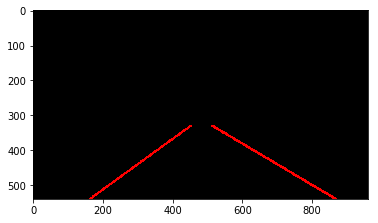

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [22]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))